## Keras implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate, ZeroPadding2D, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, input_size = (None, None), max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, *input_size))
    else:
        input_a = Input(shape=(*input_size, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1)) (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    _ = Flatten(name = 'flatten') (_)
    _ = Dense(1, name = 'final_dense', activation = "sigmoid" if use_sigmoid else None) (_)
    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
def UNET_G_SM(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=ngf, nf_next=ngf)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(ngf, kernel_size=(13, 4), strides=(1, 2),
                            use_bias=True,
                            kernel_initializer = conv_init,
                            name = 'convt.fin')(_)
    _ = Cropping2D((0, 1))(_)
    
    _ = Activation("relu")(_)
    _ = Conv2DTranspose(ngf//2, kernel_size=4, strides=2,
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(nc_out, kernel_size=(3, 4), strides=(1, 2),
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfinfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [9]:
def UNET_G_MS(isize, nc_in=1, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, *musicSize))
    else:
        _ = inputs = Input(shape=(*musicSize, nc_in))
    _ = conv2d(ngf, kernel_size=4, strides=(1, 2), use_bias=True,
                   padding="same", name = 'conv_superfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    #_ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=4, strides=2, use_bias=True,
                   padding="same", name = 'conv_first') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=(13, 4), strides=(1,2), use_bias=True,
               padding="valid", name = 'conv_firstfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = block(_, isize, ngf*2, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [10]:
nc_s = 3
nc_m = 1
ngf = 128
ndf = 128

spriteSize = (32, 32)
musicSize = (88, 256)
fs = 32
snap_to = 1 # snaps to every 1/4 of a second
snap_factor = 1 / snap_to
dur = 8.0
pitch_range = (21, 109)
binary_music = True

use_lsgan = True
λ = 5 if use_lsgan else 100
md_weight = 1
mg_weight = 1

cycleS_loss_weight = 1
cycleM_loss_weight = 1

continue_training = False
batchSize = 2
lrD = 3e-5
lrG = 6e-5

assert((fs // snap_factor) * snap_factor == fs)

In [11]:
netGM = UNET_G_SM(32, nc_s, nc_m, ngf) #netGA
netGM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_32 (Conv2D)                (None, 16, 16, 128)  6272        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 128)  0           conv_32[0][0]                    
__________________________________________________________________________________________________
conv_16 (Conv2D)                (None, 8, 8, 256)    524288      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [12]:
netGS = UNET_G_MS(32, nc_m, nc_s, ngf) #netGB
netGS.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 88, 256, 1)   0                                            
__________________________________________________________________________________________________
conv_superfirst (Conv2D)        (None, 88, 128, 128) 2176        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 88, 128, 128) 0           conv_superfirst[0][0]            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 44, 64, 256)  524544      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [15]:
netDM = BASIC_D(nc_m, ndf, input_size = musicSize, use_sigmoid = not use_lsgan) # netDA
netDS = BASIC_D(nc_s, ndf, input_size = spriteSize, use_sigmoid = not use_lsgan) # netDB
netDM.summary()
netDS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 88, 256, 1)        0         
_________________________________________________________________
First (Conv2D)               (None, 44, 128, 128)      2176      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 44, 128, 128)      0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 22, 64, 256)       524288    
_________________________________________________________________
batch_normalization_15 (Batc (None, 22, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 22, 64, 256)       0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, 11, 32, 512)       2097152   
__________

In [16]:
from keras.optimizers import RMSprop, SGD, Adam

In [17]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

bce_loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))
    
def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_M, fake_S, rec_M, cycleM_generate = cycle_variables(netGS, netGM)
real_S, fake_M, rec_S, cycleS_generate = cycle_variables(netGM, netGS)

In [18]:
def DM_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(cycleM_loss_weight * K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

def DS_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(cycleS_loss_weight * K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DM, loss_GM, loss_cycM = DM_loss(netDM, real_M, fake_M, rec_M)
loss_DS, loss_GS, loss_cycS = DS_loss(netDS, real_S, fake_S, rec_S)
loss_cyc = loss_cycM+loss_cycS

In [19]:
loss_G = loss_GM+loss_GS+λ*loss_cyc
loss_D = loss_DM+loss_DS

weightsD = netDM.trainable_weights + netDS.trainable_weights
weightsG = netGM.trainable_weights + netGS.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_M, real_S],[md_weight * loss_DM/2, loss_DS/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_M, real_S], [mg_weight * loss_GM, loss_GS, loss_cyc], training_updates)

In [20]:
!pip install pretty_midi
import pretty_midi

def prepare_midi(pm, fs = 16, duration = 30.0, pitchrange = (0, 128)):
    """ 
    Takes a given midi file name and returns a PrettyMIDI object and its piano roll. 

    Extended description of function. 

    Parameters: 
    name (str): Name of midi file
    fs (int): Samples per sec
    duration (float): duration of time to keep 
    pitchrange (tuple[int]): tuple of starting pitch and ending pitch. 0 to 127 possible

    Returns: 
    (PrettyMIDI, numpyArray): prettymidi object and cropped piano roll array

    """ 

    pmroll = pm.get_piano_roll(fs)[pitchrange[0] : pitchrange[1]]
    if duration > 0:
        pmroll = pmroll[:, 0 : int(duration * fs)]
    return pmroll

def to_midi(pr, fs = 8, pitchrange = (0, 128), force_velocity = False):
    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program = piano_program)
    
    pitch_start = pitchrange[0]
    for p in range(len(pr)):
        start = False
        startTime = 0.0
        v = 0
        for t in range(len(pr[p])):
            if not start and int(pr[p][t]) > 0:
                start = True
                v = int(pr[p][t])
                startTime = t / fs
            elif start and int(pr[p][t]) != v:
                endTime = t / fs
                vel = v
                if force_velocity:
                    vel = 125
                _ = pretty_midi.Note(velocity = vel, 
                                    pitch = pitch_start + p, start = startTime, end = endTime)
                piano.notes.append(_)
                if int(pr[p][t]) == 0:
                    start = False
                else:
                    startTime = endTime
                    v = int(pr[p][t])
    
    pm.instruments.append(piano)
    return pm


In [21]:
def show_pitch_occur(midis):
    pitches = [0] * 128
    for fn in midis:        
        try:
            _ = pretty_midi.PrettyMIDI(fn)
            print(fn, "\n loading... loaded")
        except:
            print(fn, "\n loading... ERROR")
        roll = prepare_midi(_, fs = 8, duration = 0.0)
        for p in range(128):
            if len(set(roll[p])) > 1:
                pitches[p] += 1

    for p in range(128):
        print(p, pitches[p], sep=': ')

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern, recursive = True)

def read_image(fn, imgSize, augment=False):
    im = Image.open(fn).convert("RGBA")
    im = im.resize(imgSize, Image.BILINEAR )
    img = np.array(im, dtype=np.float64)
    alphaLayer = img[:,:,3] / 255.0
    img[:,:,0] *= alphaLayer
    img[:,:,1] *= alphaLayer
    img[:,:,2] *= alphaLayer
    img = (img/255.0*2-1)[:,:,:3]
    if augment and randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

def read_midi(fn, imgSize, fs, duration, prange, augment=False):
    try:
        _ = pretty_midi.PrettyMIDI(fn)
    except:
        return None
    roll = prepare_midi(_, fs, 0, prange)
    window = int(fs * duration)
    end = len(roll[0]) - int(5 * fs) - window
    if end < int(5 * fs):
        print(end, " not big enough (", fn, ")")
        return None
    start = np.random.randint(int(5 * fs), end)
    snap = fs // snap_factor
    start = int((start // snap) * snap)
    img = roll[:, start : start + window]
    if binary_music:
        img = np.clip(img, 0, 1)*2 - 1
    else:
        img = (img/127.0 * 2 - 1)
    #if augment and randint(0,1):
    #    img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    if img.shape != imgSize:
        print("[ERROR] Created an invalid shaped piece of music data! Size: ", img.shape, " instead of ", imgSize)
    return img

data = "sprites2music"
train_S = load_data('trainingSet/sprites/**/*.png')
train_M = load_data('trainingSet/music/**/*.mid')

print("[Removing songs that are too short]")
to_remove = []
for m in train_M:
    if read_midi(m, musicSize, fs, dur, pitch_range) is None:
        to_remove.append(m)
for m in to_remove:
    train_M.remove(m)

assert len(train_M) and len(train_S)

shuffle(train_M)
shuffle(train_S)

print("Num midi files: ", len(train_M))
print("Num sprites: ", len(train_S))

[Removing songs that are too short]


C:\Users\mmille95\AppData\Local\conda\conda\envs\cycleGAN\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


-263  not big enough ( trainingSet/music\vgpiano\CastleVania_-_StageClear.mid )
-197  not big enough ( trainingSet/music\vgpiano\cchitcat.mid )
-288  not big enough ( trainingSet/music\vgpiano\command_melody_lozww_piano.mid )
-7  not big enough ( trainingSet/music\vgpiano\Creation_piano_.mid )
80  not big enough ( trainingSet/music\vgpiano\DKONG.mid )
36  not big enough ( trainingSet/music\vgpiano\dk_title.mid )
-324  not big enough ( trainingSet/music\vgpiano\GameOverPiano.mid )
-160  not big enough ( trainingSet/music\vgpiano\inverted_song_time_piano.mid )
-324  not big enough ( trainingSet/music\vgpiano\Mario_Dies_Super_Mario_World.mid )
-237  not big enough ( trainingSet/music\vgpiano\mmx5bossintropianoversion.mid )
-236  not big enough ( trainingSet/music\vgpiano\MP_Artifact_-_Piano_Only_-_By_DaDude.mid )
-234  not big enough ( trainingSet/music\vgpiano\MP_Item_Acquired_-_Piano_Only_-_By_DaDude.mid )
-77  not big enough ( trainingSet/music\vgpiano\Music_Box_Clock.mid )
159  not bi

440 trainingSet/music\vgpiano\Olympus_no_tatakai_piano.mid


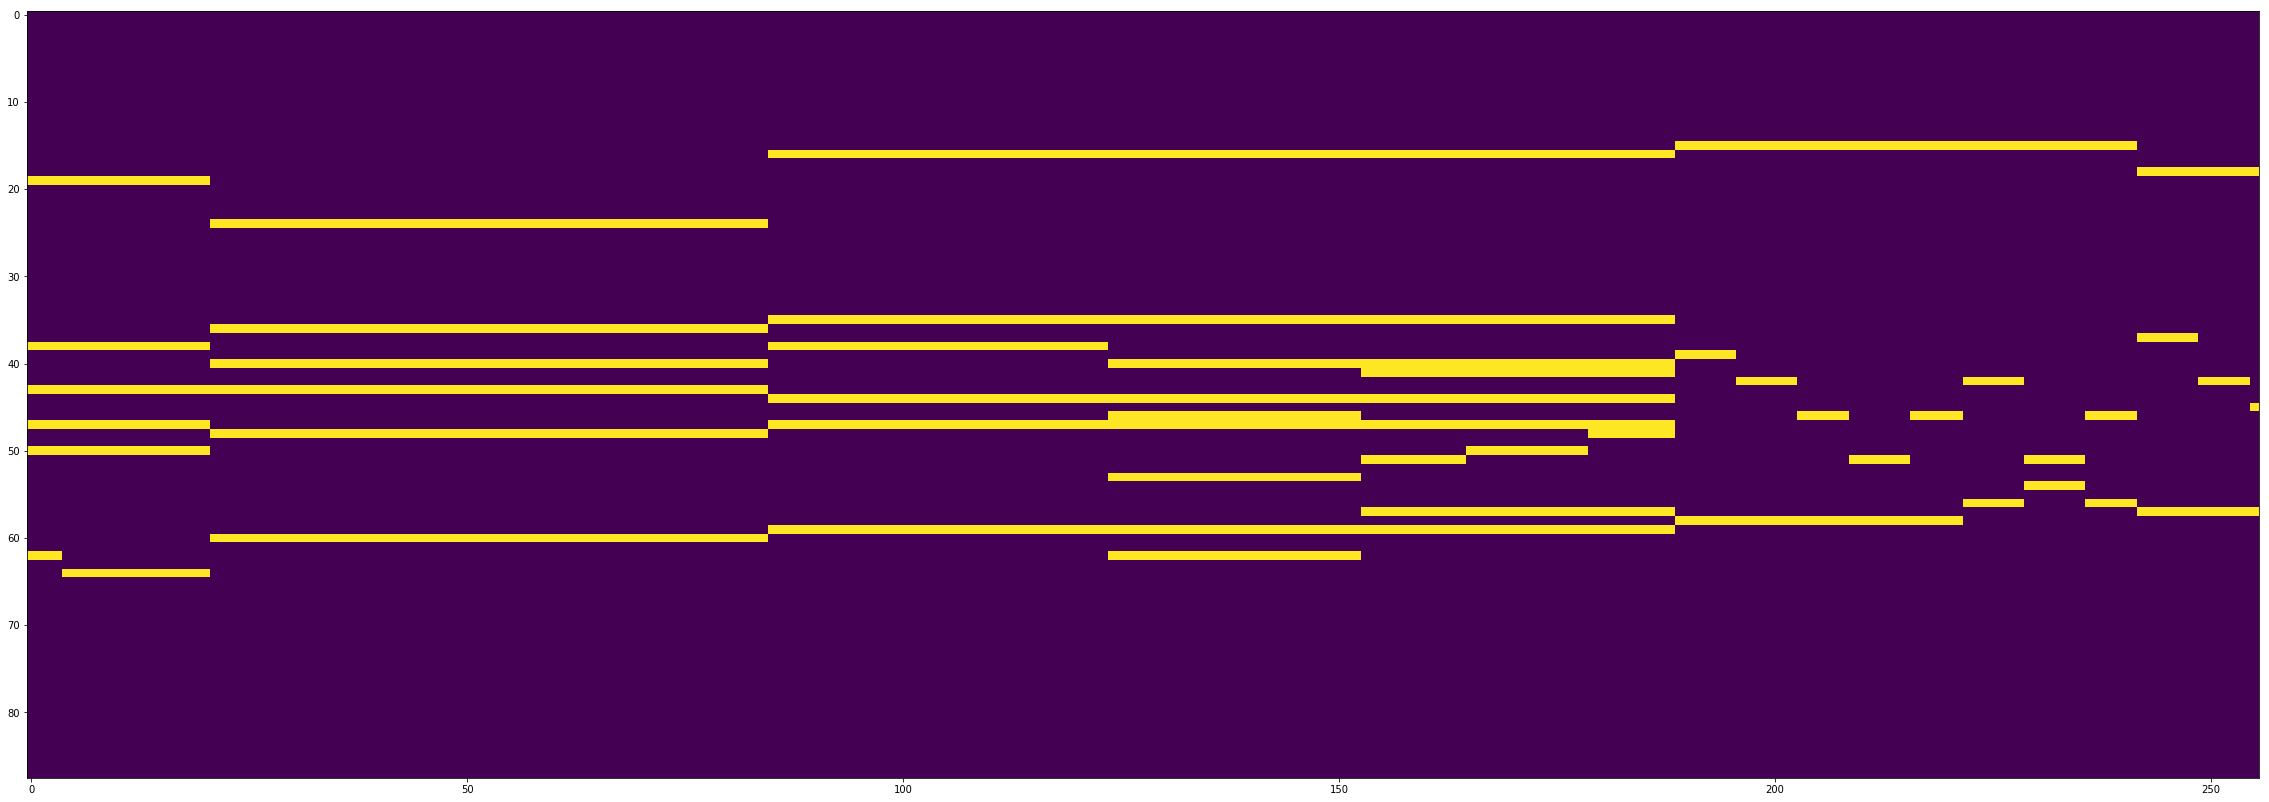

(88, 256)


In [23]:
#show_pitch_occur(train_M)
test = None
while test is None:
    n = np.random.randint(len(train_M))
    print(n, train_M[n])
    test = read_midi(train_M[n], musicSize, fs, dur, pitch_range)
plt.figure(figsize = (40, 80))
plt.imshow(test)
plt.show()

test = test.clip(0, 1)
pm = to_midi(test, fs, pitch_range, force_velocity= binary_music)
pm.write('test.mid')
print(test.shape)

In [26]:
def minibatchS(data, batchsize, imgSize = spriteSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j], imgSize, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       
        
def minibatchM(data, batchsize, imgSize = musicSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_midi(data[j], imgSize, fs, dur, pitch_range, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.expand_dims(np.float32(rtn), -1)

def minibatchMS(dataM, dataS, batchsize):
    batchM=minibatchM(dataM, batchsize, augment=False)
    batchS=minibatchS(dataS, batchsize, augment=True)
    tmpsize = None
    while True:        
        ep1, M = batchM.send(tmpsize)
        ep2, S = batchS.send(tmpsize)
        tmpsize = yield max(ep1, ep2), M, S

In [27]:
def showX(X, imageWidth, imageHeight, nc, rows=1, figsize = (20, 40)):
    assert X.shape[0]%rows == 0
    cols = X.shape[0]//rows
    plt.figure(figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            int_X = X[i]
            #if (imageHeight, imageWidth) == spriteSize: #Fix here
            int_X = ((int_X+1)/2)
            int_X = (int_X*255).clip(0,255).astype('uint8')
            if channel_first:
                int_X = np.moveaxis(int_X.reshape(-1,nc,imageWidth, imageHeight), 1, nc)
            else:
                int_X = int_X.reshape(-1, imageWidth, imageHeight, nc)
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(np.squeeze(int_X), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
            ax.axis('off')
    plt.show()

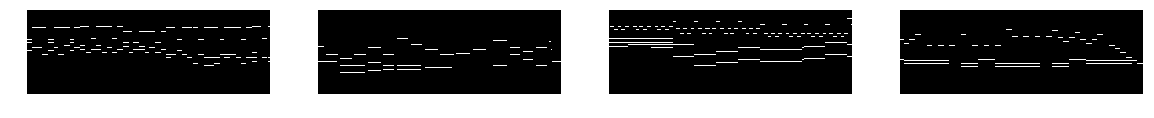

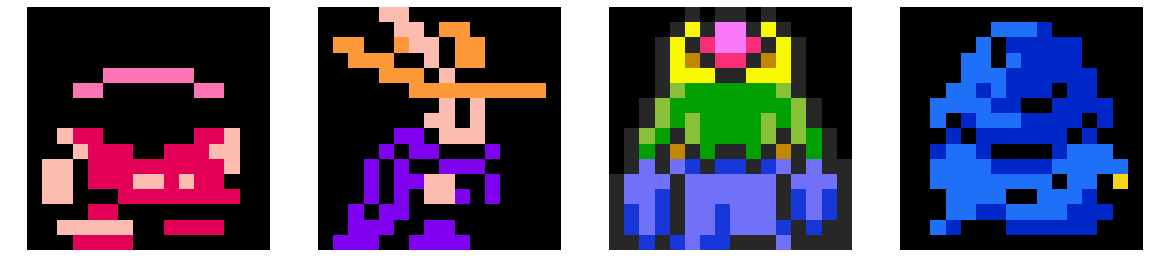

In [29]:
train_batch = minibatchMS(train_M, train_S, 4)

_, M, S = next(train_batch)
showX(M, *musicSize, nc_m)
showX(S, *spriteSize, nc_s)
del train_batch, M, S

In [30]:
def showG(M,S):
    def G(fn_generate, X):
        fakes = []
        recs = []
        for i in range(X.shape[0]):
            fake, rec = fn_generate([X[i:i+1]])
            fakes.append(fake[0])
            recs.append(rec[0])
        return [np.array(fakes), np.array(recs)]
    rM = G(cycleM_generate, M)
    rS = G(cycleS_generate, S)
    arr = [M,*rM,S,*rS]
    for elem in arr:
        print(elem.shape)
        showX(elem, elem.shape[1], elem.shape[2], elem.shape[3], 1)

[0/100][25] Loss_D: 1.358688 0.490102 Loss_G: 1.087268 0.614367 loss_cyc 1.815347 0.710
[0/100][50] Loss_D: 0.606103 0.270249 Loss_G: 0.976530 0.416294 loss_cyc 1.833328 0.944
[0/100][75] Loss_D: 0.509841 0.239452 Loss_G: 0.916882 0.302589 loss_cyc 1.794060 1.184
[0/100][100] Loss_D: 0.445857 0.208681 Loss_G: 1.173652 0.221942 loss_cyc 1.750985 1.430
[0/100][125] Loss_D: 0.365569 0.216676 Loss_G: 0.919564 0.224376 loss_cyc 1.739804 1.666
[0/100][150] Loss_D: 0.346011 0.205217 Loss_G: 1.065017 0.220845 loss_cyc 1.720893 1.894
[0/100][175] Loss_D: 0.303858 0.227073 Loss_G: 1.341554 0.220751 loss_cyc 1.673080 2.138
[0/100][200] Loss_D: 0.273756 0.214009 Loss_G: 1.312672 0.235690 loss_cyc 1.659042 2.381
[0/100][225] Loss_D: 0.191089 0.206658 Loss_G: 1.205741 0.261056 loss_cyc 1.648344 2.620
[0/100][250] Loss_D: 0.184615 0.208249 Loss_G: 1.021269 0.288476 loss_cyc 1.605220 2.866
[0/100][275] Loss_D: 0.117377 0.180490 Loss_G: 0.966512 0.312797 loss_cyc 1.589576 3.108
[0/100][300] Loss_D: 0.1

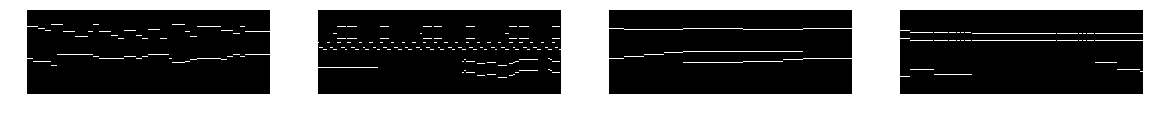

(4, 32, 32, 3)


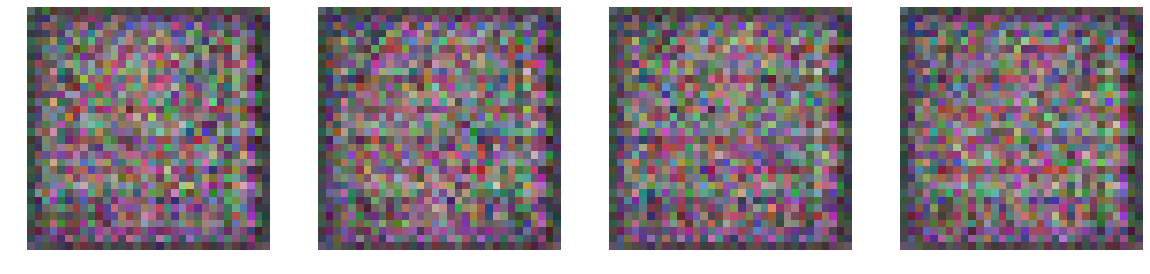

(4, 88, 256, 1)


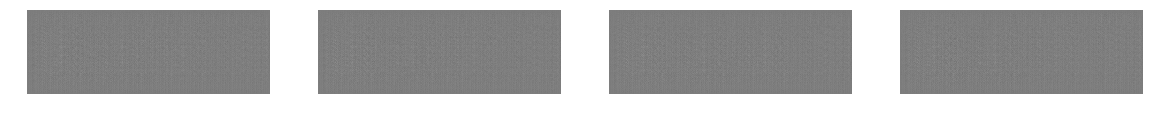

(4, 32, 32, 3)


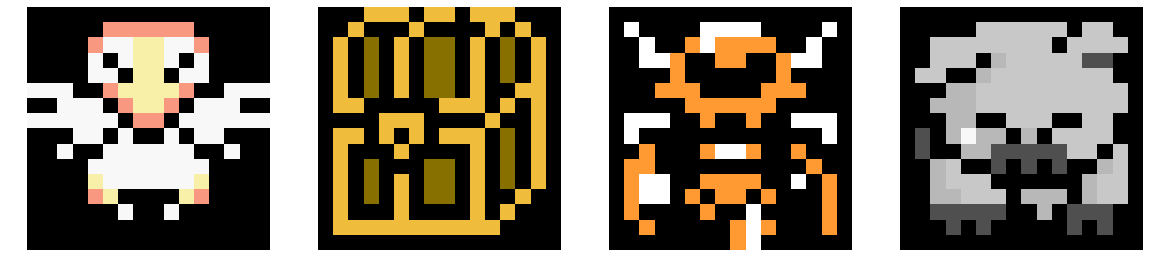

(4, 88, 256, 1)


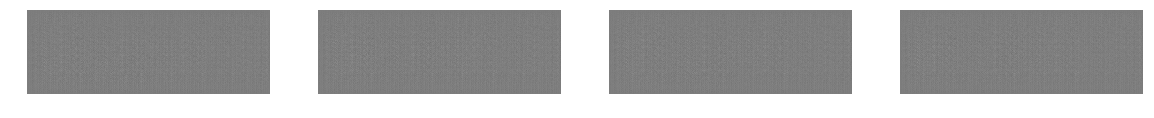

(4, 32, 32, 3)


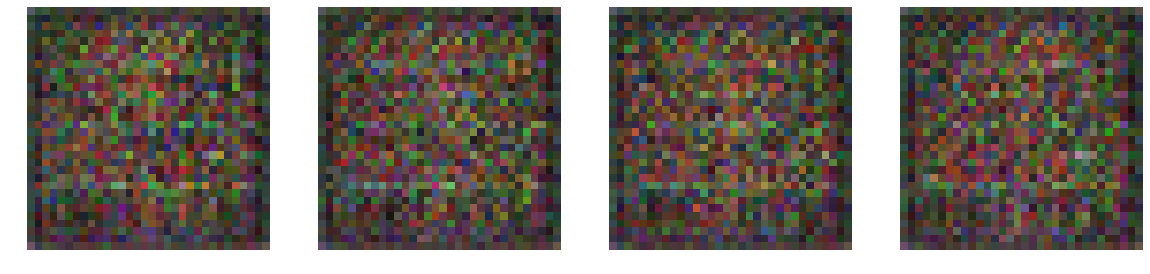

[1/100][375] Loss_D: 0.095182 0.234962 Loss_G: 1.112094 0.268966 loss_cyc 1.579900 4.125
[1/100][400] Loss_D: 0.121038 0.272110 Loss_G: 1.021852 0.294264 loss_cyc 1.575611 4.371
[1/100][425] Loss_D: 0.082973 0.261686 Loss_G: 1.062955 0.289655 loss_cyc 1.598438 4.607
[1/100][450] Loss_D: 0.065795 0.272764 Loss_G: 1.031526 0.336102 loss_cyc 1.555649 4.851
[1/100][475] Loss_D: 0.084430 0.227283 Loss_G: 1.062241 0.390475 loss_cyc 1.565464 5.088
[1/100][500] Loss_D: 0.053294 0.244892 Loss_G: 1.000703 0.431985 loss_cyc 1.543146 5.312
[1/100][525] Loss_D: 0.067203 0.212095 Loss_G: 1.055163 0.360359 loss_cyc 1.559817 5.558
[1/100][550] Loss_D: 0.050553 0.187150 Loss_G: 1.061128 0.366912 loss_cyc 1.507521 5.801
[1/100][575] Loss_D: 0.053869 0.221487 Loss_G: 1.035837 0.406469 loss_cyc 1.508904 6.041
[1/100][600] Loss_D: 0.068576 0.134917 Loss_G: 1.109390 0.434042 loss_cyc 1.536716 6.277
[1/100][625] Loss_D: 0.043582 0.142234 Loss_G: 1.051064 0.424359 loss_cyc 1.496282 6.520
[1/100][650] Loss_D: 

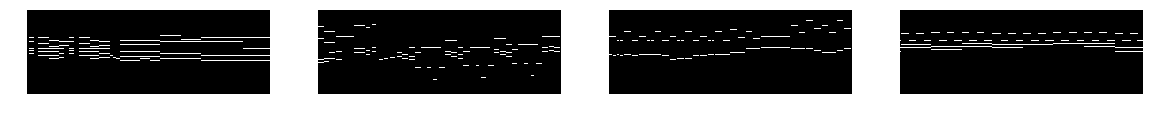

(4, 32, 32, 3)


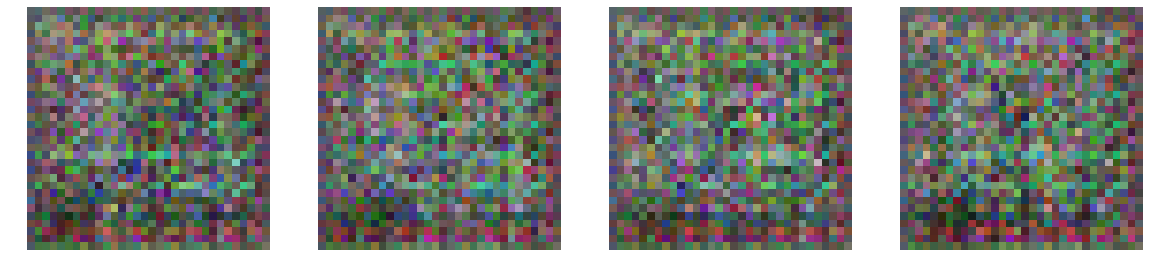

(4, 88, 256, 1)


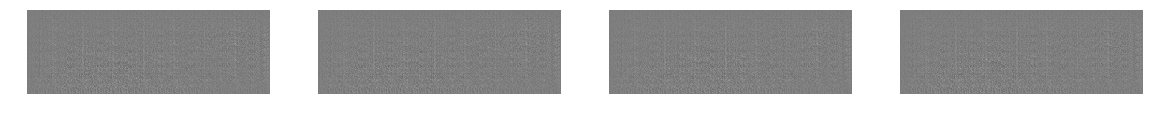

(4, 32, 32, 3)


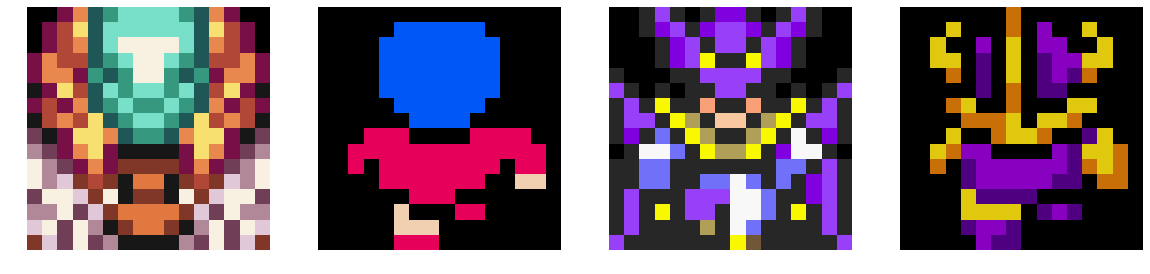

(4, 88, 256, 1)


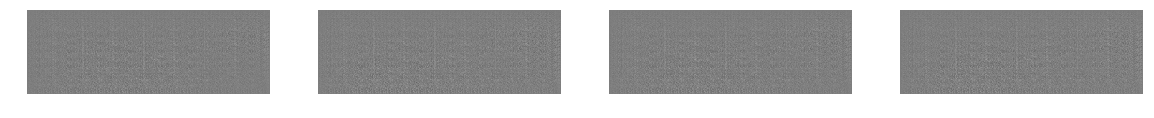

(4, 32, 32, 3)


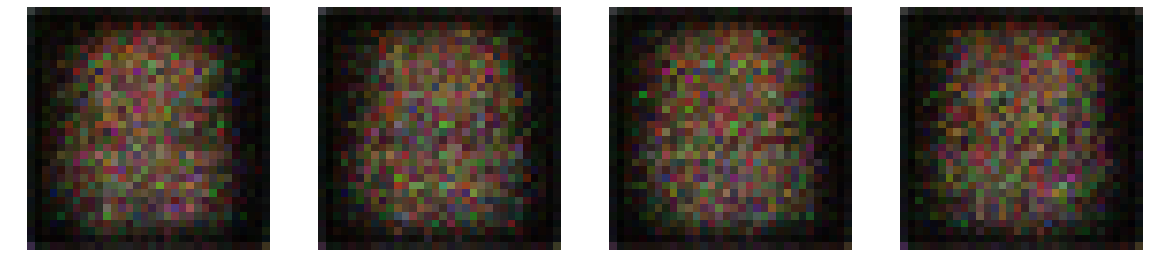

[2/100][700] Loss_D: 0.039042 0.129121 Loss_G: 1.018079 0.438145 loss_cyc 1.510942 7.304
[2/100][725] Loss_D: 0.038108 0.258779 Loss_G: 0.982411 0.618025 loss_cyc 1.483833 7.544
[2/100][750] Loss_D: 0.055653 0.234178 Loss_G: 1.049968 0.586153 loss_cyc 1.491308 7.788
[2/100][775] Loss_D: 0.043473 0.199788 Loss_G: 1.058428 0.655011 loss_cyc 1.478212 8.024
[2/100][800] Loss_D: 0.037214 0.190219 Loss_G: 1.038799 0.684243 loss_cyc 1.481794 8.259
[2/100][825] Loss_D: 0.027459 0.157966 Loss_G: 1.080545 0.647558 loss_cyc 1.487952 8.494
[2/100][850] Loss_D: 0.030473 0.159012 Loss_G: 1.036396 0.614336 loss_cyc 1.492353 8.724
[2/100][875] Loss_D: 0.029259 0.116374 Loss_G: 1.060077 0.508428 loss_cyc 1.462695 8.965
[2/100][900] Loss_D: 0.025927 0.124720 Loss_G: 1.014688 0.468300 loss_cyc 1.491358 9.207
[2/100][925] Loss_D: 0.027360 0.084119 Loss_G: 1.104264 0.627777 loss_cyc 1.503264 9.444
[2/100][950] Loss_D: 0.029940 0.095153 Loss_G: 1.034476 0.654938 loss_cyc 1.481702 9.693
[2/100][975] Loss_D: 

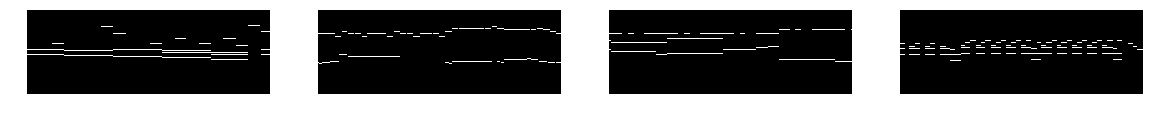

(4, 32, 32, 3)


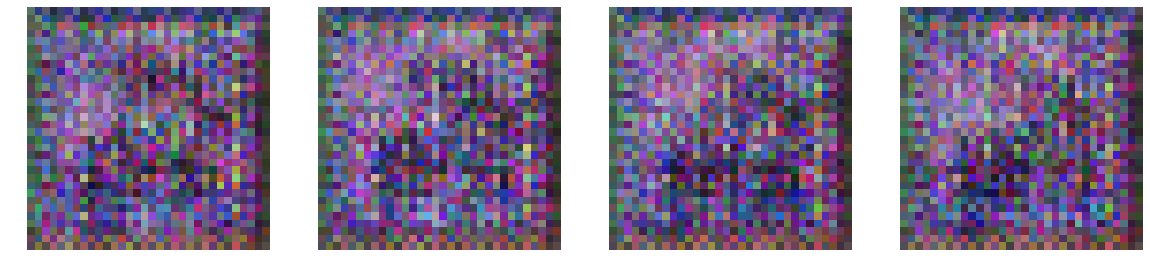

(4, 88, 256, 1)


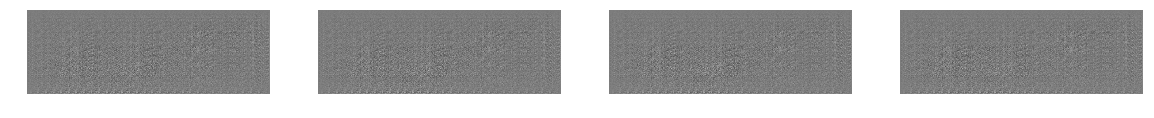

(4, 32, 32, 3)


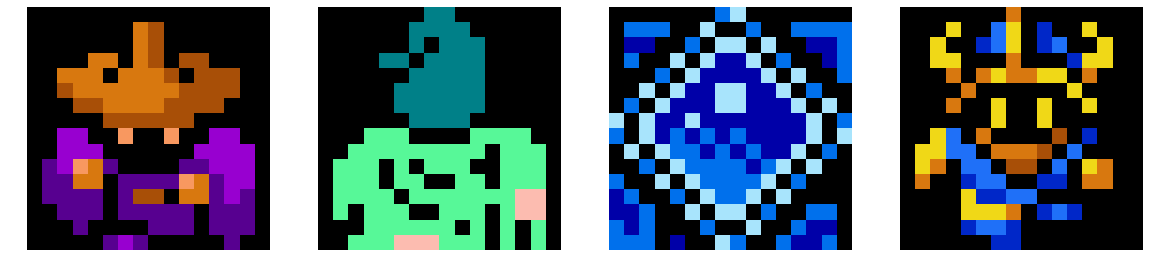

(4, 88, 256, 1)


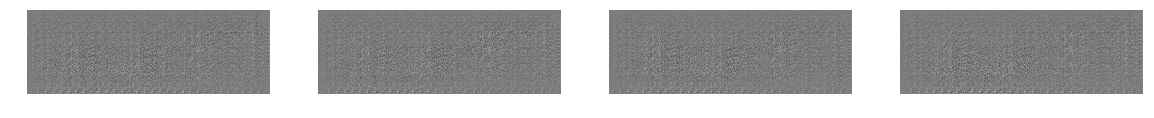

(4, 32, 32, 3)


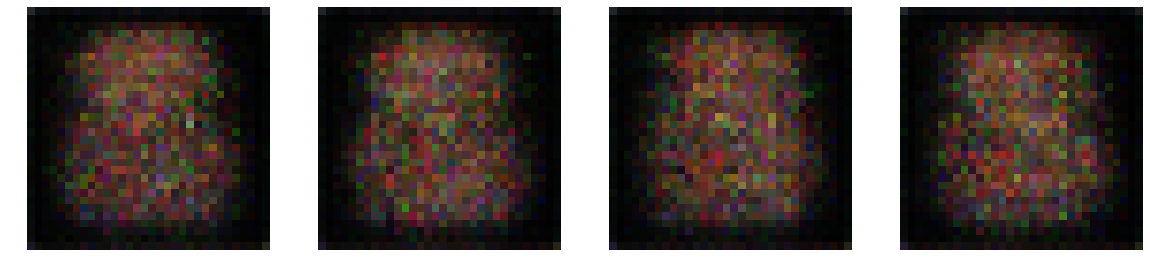

[3/100][1050] Loss_D: 0.021578 0.119328 Loss_G: 1.009320 0.625845 loss_cyc 1.456471 10.713
[3/100][1075] Loss_D: 0.017751 0.075430 Loss_G: 1.029602 0.783382 loss_cyc 1.456600 10.958
[3/100][1100] Loss_D: 0.025272 0.080183 Loss_G: 1.035235 0.814993 loss_cyc 1.446802 11.191
[3/100][1125] Loss_D: 0.026632 0.076839 Loss_G: 1.044737 0.861326 loss_cyc 1.452231 11.439
[3/100][1150] Loss_D: 0.020685 0.135326 Loss_G: 1.009391 0.996364 loss_cyc 1.461296 11.683
[3/100][1175] Loss_D: 0.023399 0.234366 Loss_G: 1.024706 0.847584 loss_cyc 1.468769 11.913
[3/100][1200] Loss_D: 0.018432 0.156219 Loss_G: 0.968281 0.755940 loss_cyc 1.442875 12.153
[3/100][1225] Loss_D: 0.019326 0.155598 Loss_G: 1.013310 0.767563 loss_cyc 1.473641 12.395
[3/100][1250] Loss_D: 0.025771 0.116226 Loss_G: 0.992656 0.928863 loss_cyc 1.451553 12.637
[3/100][1275] Loss_D: 0.017534 0.115636 Loss_G: 0.981659 0.961585 loss_cyc 1.438133 12.876
[3/100][1300] Loss_D: 0.017529 0.149743 Loss_G: 1.003402 0.944288 loss_cyc 1.439338 13.111

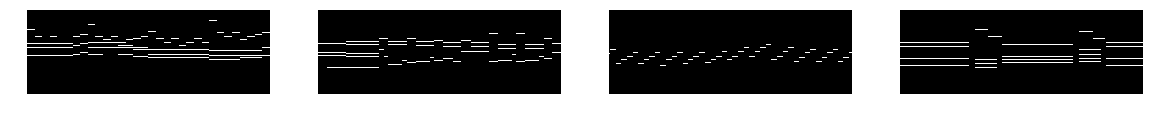

(4, 32, 32, 3)


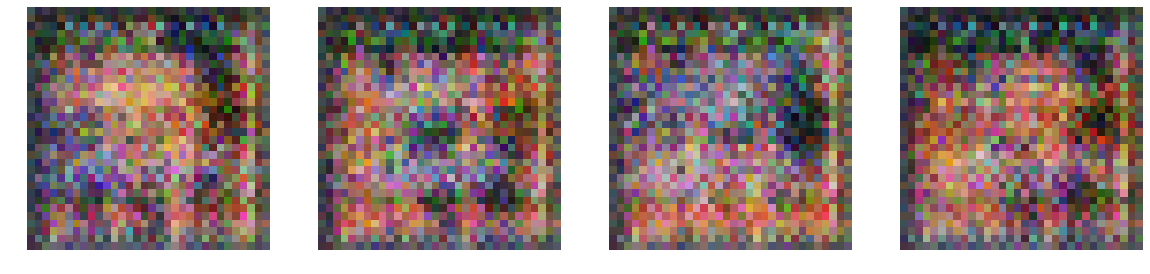

(4, 88, 256, 1)


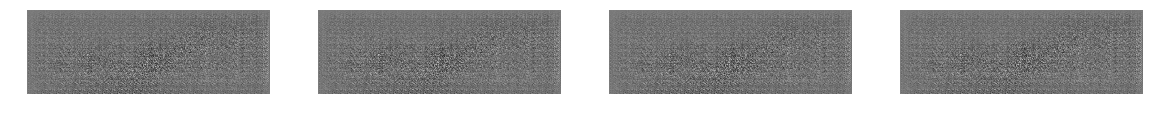

(4, 32, 32, 3)


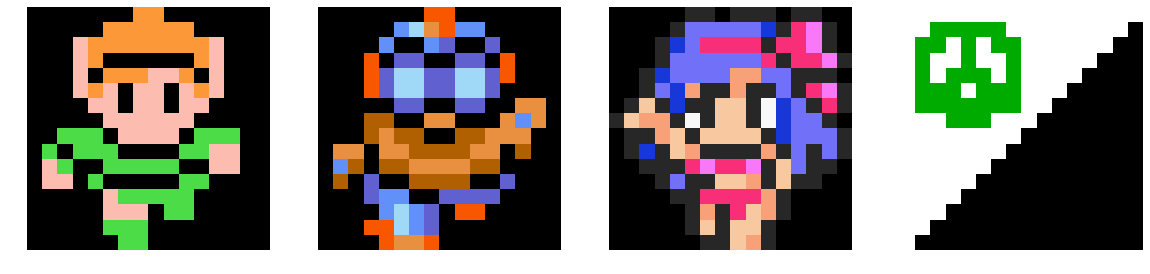

(4, 88, 256, 1)


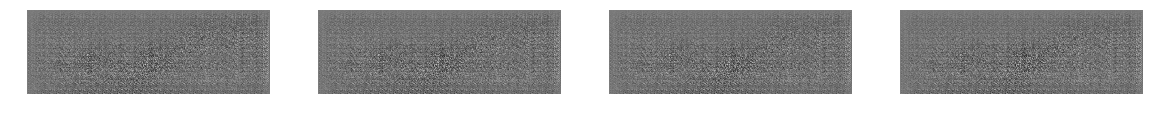

(4, 32, 32, 3)


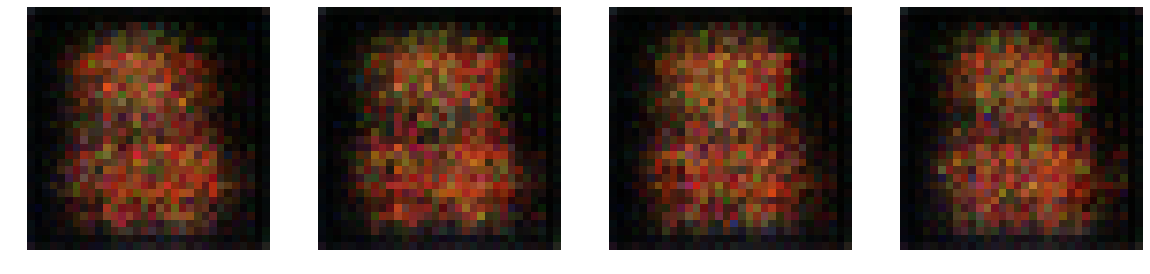

[4/100][1400] Loss_D: 0.015051 0.120346 Loss_G: 1.015961 0.882715 loss_cyc 1.381858 14.109
[4/100][1425] Loss_D: 0.022592 0.120296 Loss_G: 1.028631 0.912193 loss_cyc 1.339887 14.355
[4/100][1450] Loss_D: 0.035955 0.121830 Loss_G: 1.010151 0.925320 loss_cyc 1.078165 14.594
[4/100][1475] Loss_D: 0.031603 0.130119 Loss_G: 1.020728 1.091248 loss_cyc 0.930407 14.825
[4/100][1500] Loss_D: 0.021498 0.095267 Loss_G: 0.962692 0.906987 loss_cyc 0.906619 15.071
[4/100][1525] Loss_D: 0.033456 0.167549 Loss_G: 0.948109 1.038059 loss_cyc 0.916601 15.314
[4/100][1550] Loss_D: 0.023034 0.099393 Loss_G: 0.981997 0.951253 loss_cyc 0.882202 15.561
[4/100][1575] Loss_D: 0.024807 0.117429 Loss_G: 0.950197 1.070151 loss_cyc 0.882729 15.794
[4/100][1600] Loss_D: 0.028856 0.115900 Loss_G: 0.954811 1.064079 loss_cyc 0.883977 16.036
[4/100][1625] Loss_D: 0.040656 0.119516 Loss_G: 0.955760 0.908246 loss_cyc 0.836236 16.270
[4/100][1650] Loss_D: 0.042910 0.109306 Loss_G: 0.970534 1.086035 loss_cyc 0.796881 16.508

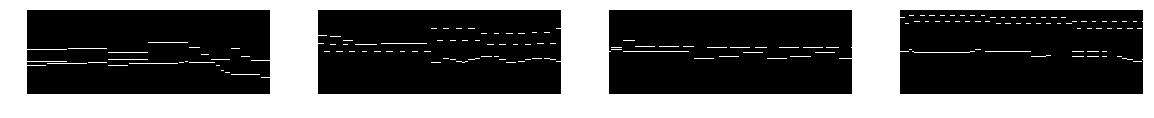

(4, 32, 32, 3)


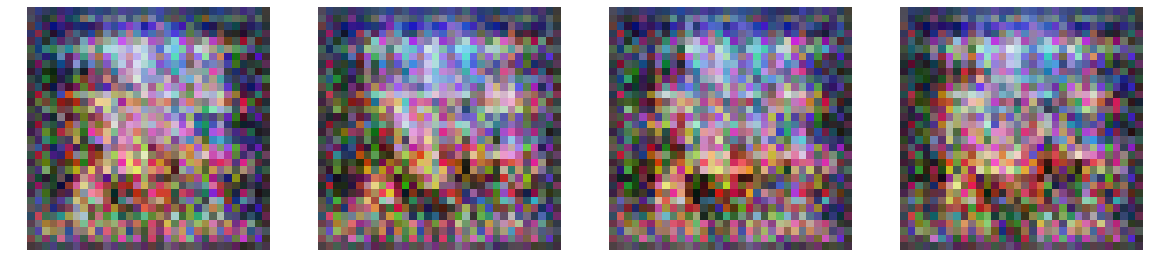

(4, 88, 256, 1)


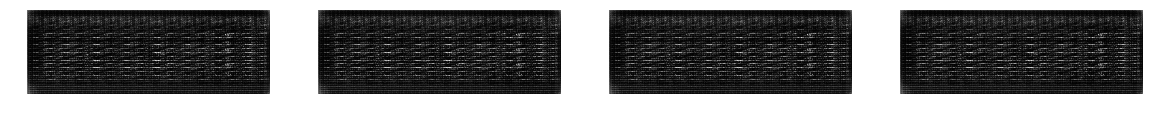

(4, 32, 32, 3)


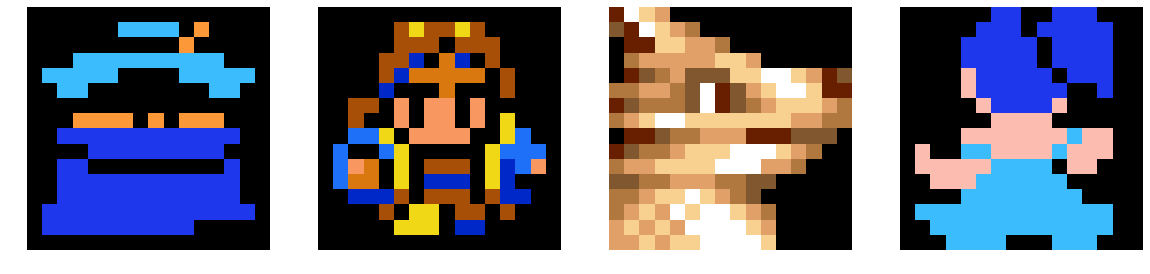

(4, 88, 256, 1)


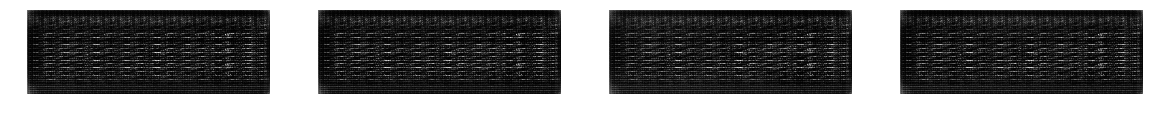

(4, 32, 32, 3)


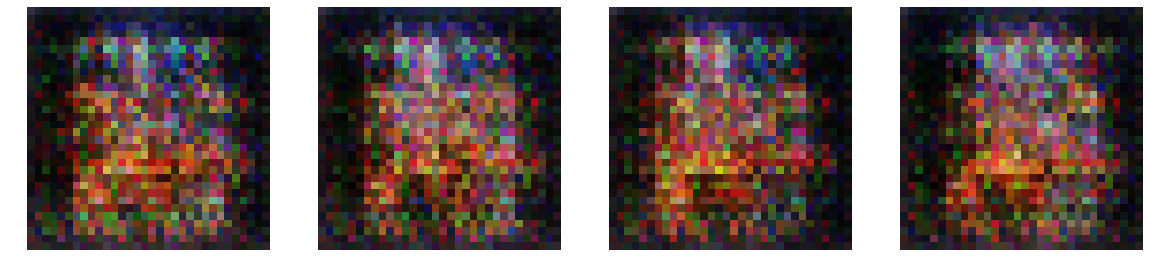

[5/100][1750] Loss_D: 0.019303 0.082536 Loss_G: 0.994895 1.173595 loss_cyc 0.773418 17.488
[5/100][1775] Loss_D: 0.013350 0.057530 Loss_G: 0.988082 1.045461 loss_cyc 0.729201 17.719
[5/100][1800] Loss_D: 0.018895 0.069413 Loss_G: 1.005786 1.175005 loss_cyc 0.769519 17.949
[5/100][1825] Loss_D: 0.018225 0.061922 Loss_G: 0.970615 0.874007 loss_cyc 0.746482 18.175
[5/100][1850] Loss_D: 0.014949 0.040940 Loss_G: 0.982574 0.890160 loss_cyc 0.729773 18.414
[5/100][1875] Loss_D: 0.019863 0.082244 Loss_G: 0.984420 1.166666 loss_cyc 0.703758 18.651
[5/100][1900] Loss_D: 0.020475 0.092523 Loss_G: 0.995609 1.123732 loss_cyc 0.707560 18.884
[5/100][1925] Loss_D: 0.039798 0.117416 Loss_G: 0.965824 1.079585 loss_cyc 0.757406 19.127
[5/100][1950] Loss_D: 0.020773 0.105763 Loss_G: 0.987912 1.152031 loss_cyc 0.706534 19.382
[5/100][1975] Loss_D: 0.025758 0.067893 Loss_G: 0.979990 1.122768 loss_cyc 0.633361 19.618
[5/100][2000] Loss_D: 0.022894 0.099069 Loss_G: 1.002447 1.079056 loss_cyc 0.663615 19.855

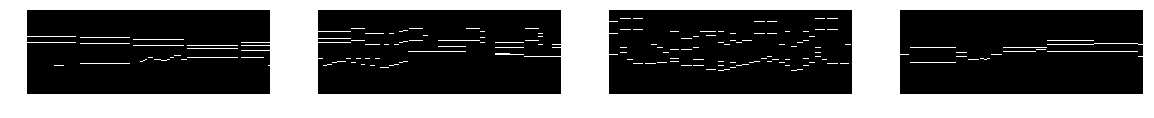

(4, 32, 32, 3)


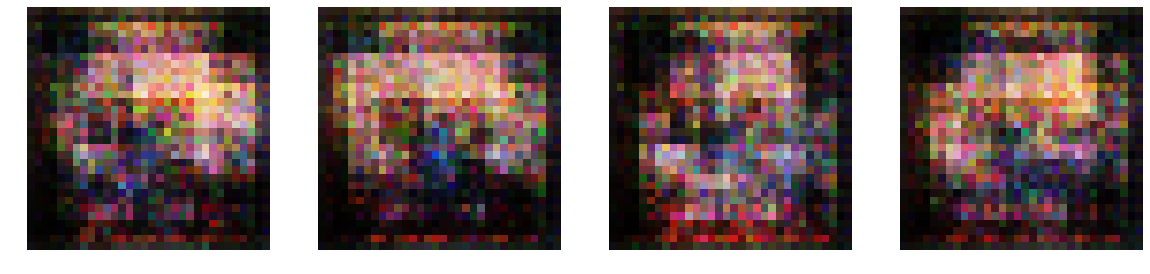

(4, 88, 256, 1)


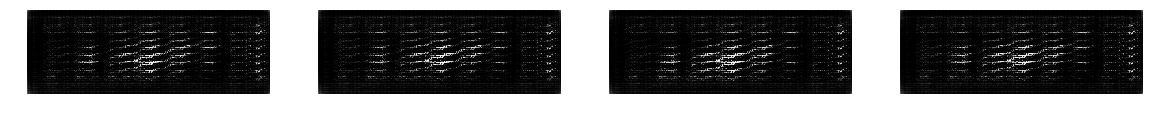

(4, 32, 32, 3)


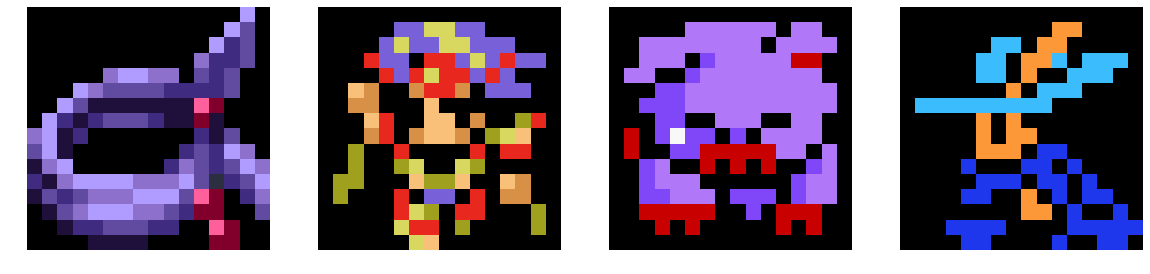

(4, 88, 256, 1)


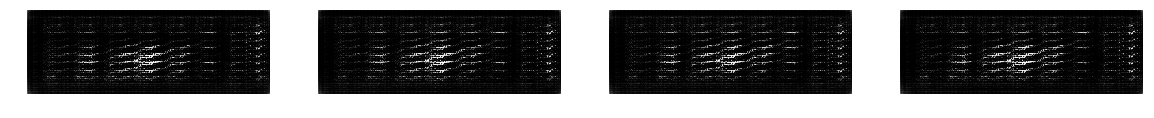

(4, 32, 32, 3)


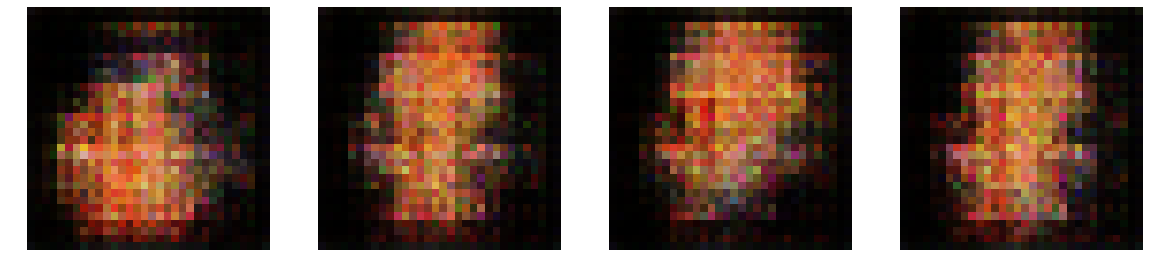

[6/100][2100] Loss_D: 0.007796 0.100517 Loss_G: 0.995189 0.943016 loss_cyc 0.612733 20.865
[6/100][2125] Loss_D: 0.015887 0.089507 Loss_G: 0.982727 0.989439 loss_cyc 0.631652 21.106
[6/100][2150] Loss_D: 0.009486 0.080743 Loss_G: 0.983436 1.123836 loss_cyc 0.639228 21.350
[6/100][2175] Loss_D: 0.008046 0.071598 Loss_G: 0.991925 1.184251 loss_cyc 0.627480 21.579
[6/100][2200] Loss_D: 0.008956 0.106592 Loss_G: 0.973272 1.083593 loss_cyc 0.631213 21.817
[6/100][2225] Loss_D: 0.011462 0.069340 Loss_G: 1.000187 1.049617 loss_cyc 0.580613 22.056
[6/100][2250] Loss_D: 0.009264 0.072466 Loss_G: 0.984190 1.144221 loss_cyc 0.561598 22.289
[6/100][2275] Loss_D: 0.015665 0.075069 Loss_G: 0.975822 1.144626 loss_cyc 0.589537 22.521
[6/100][2300] Loss_D: 0.013386 0.092144 Loss_G: 0.979174 1.058306 loss_cyc 0.579335 22.746
[6/100][2325] Loss_D: 0.017316 0.083903 Loss_G: 0.972911 1.021411 loss_cyc 0.573382 22.983
[6/100][2350] Loss_D: 0.008351 0.092556 Loss_G: 1.008012 1.075980 loss_cyc 0.584232 23.219

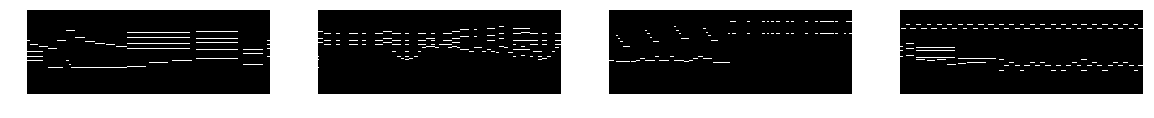

(4, 32, 32, 3)


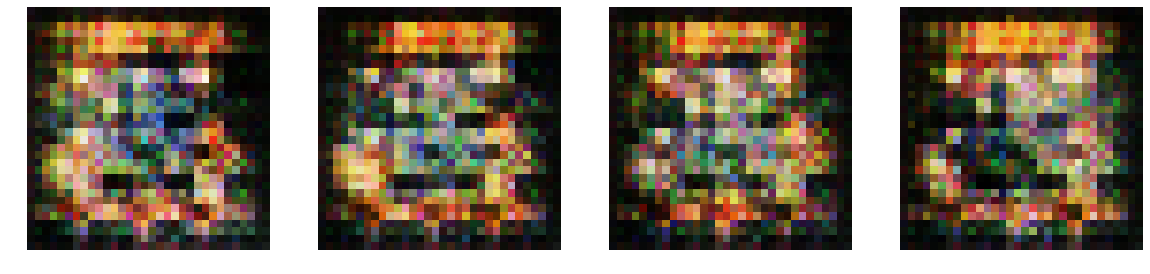

(4, 88, 256, 1)


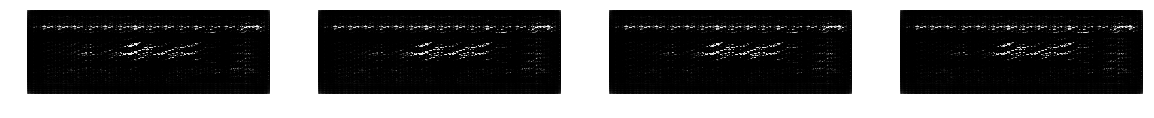

(4, 32, 32, 3)


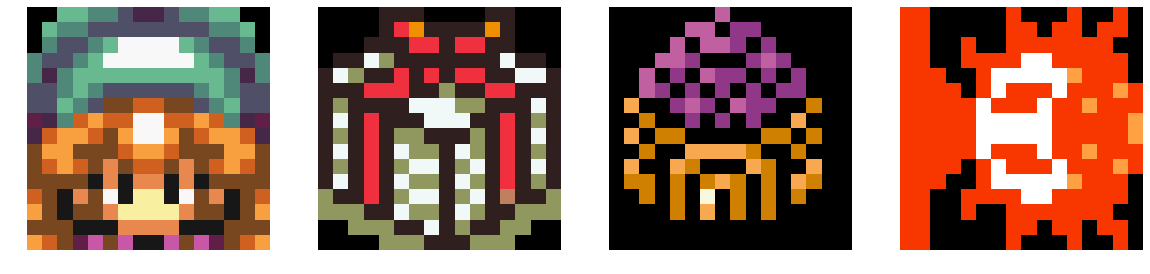

(4, 88, 256, 1)


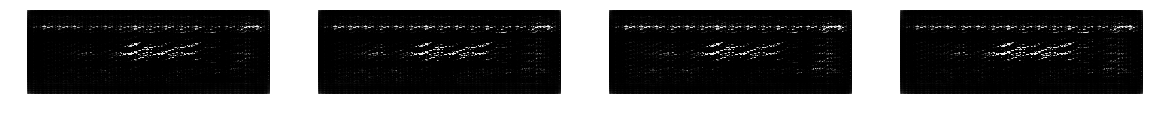

(4, 32, 32, 3)


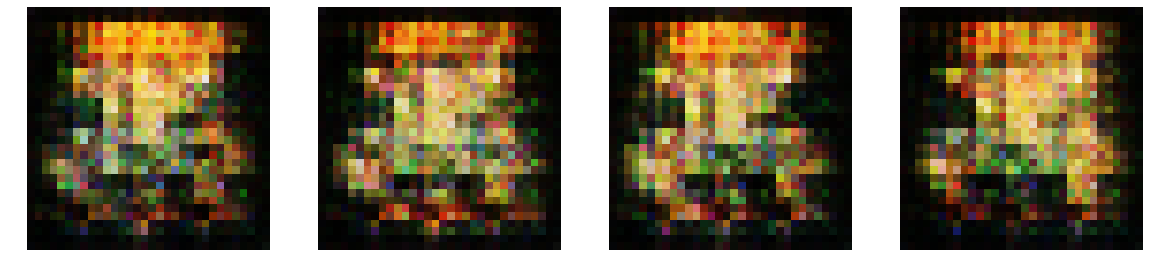

[7/100][2450] Loss_D: 0.005597 0.072389 Loss_G: 0.982496 1.218247 loss_cyc 0.575061 24.234
[7/100][2475] Loss_D: 0.013363 0.060803 Loss_G: 0.990884 1.013779 loss_cyc 0.620546 24.469
[7/100][2500] Loss_D: 0.006328 0.077689 Loss_G: 0.977912 1.104422 loss_cyc 0.574219 24.716
[7/100][2525] Loss_D: 0.014825 0.065026 Loss_G: 0.953558 1.306949 loss_cyc 0.562578 24.948
[7/100][2550] Loss_D: 0.027201 0.089284 Loss_G: 0.982233 1.193459 loss_cyc 0.605159 25.184
[7/100][2575] Loss_D: 0.018232 0.095577 Loss_G: 0.974705 1.114068 loss_cyc 0.585939 25.418
[7/100][2600] Loss_D: 0.011522 0.069666 Loss_G: 0.971481 1.033570 loss_cyc 0.567453 25.661
[7/100][2625] Loss_D: 0.014822 0.071008 Loss_G: 0.959376 1.124737 loss_cyc 0.561216 25.902
[7/100][2650] Loss_D: 0.009451 0.062939 Loss_G: 0.988417 1.122857 loss_cyc 0.577888 26.137
[7/100][2675] Loss_D: 0.009988 0.070488 Loss_G: 0.979928 1.024323 loss_cyc 0.558297 26.375
[7/100][2700] Loss_D: 0.014369 0.096019 Loss_G: 0.983310 1.142421 loss_cyc 0.572395 26.607

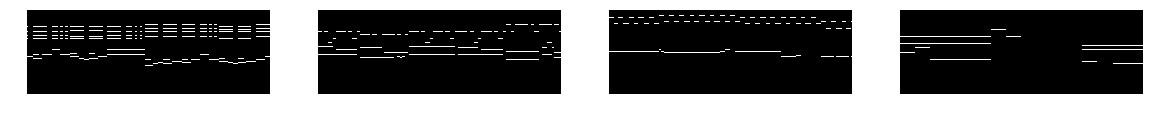

(4, 32, 32, 3)


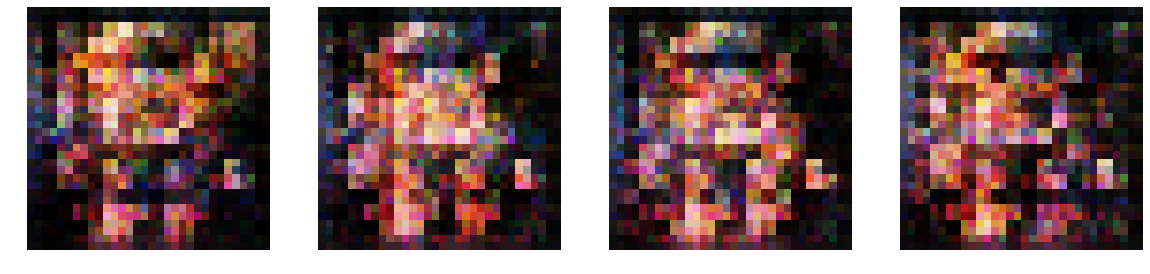

(4, 88, 256, 1)


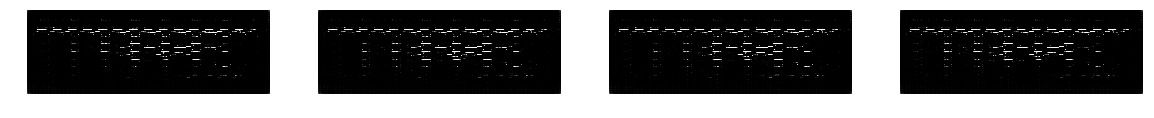

(4, 32, 32, 3)


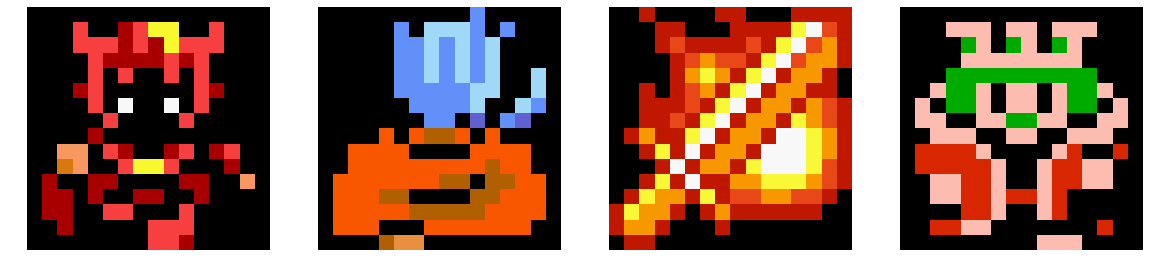

(4, 88, 256, 1)


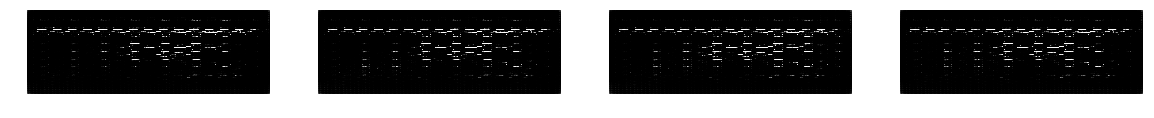

(4, 32, 32, 3)


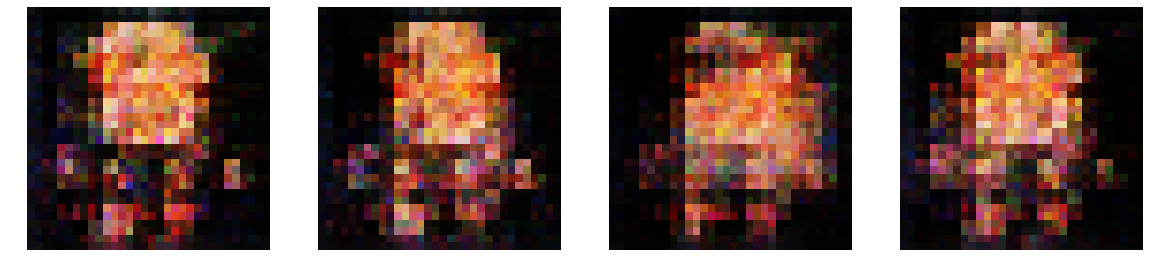

[8/100][2800] Loss_D: 0.009387 0.094396 Loss_G: 0.980606 1.081783 loss_cyc 0.511976 27.608
[8/100][2825] Loss_D: 0.018541 0.064694 Loss_G: 0.968251 1.277606 loss_cyc 0.585922 27.842
[8/100][2850] Loss_D: 0.008127 0.064391 Loss_G: 0.995989 1.242328 loss_cyc 0.562248 28.071
[8/100][2875] Loss_D: 0.006325 0.075019 Loss_G: 0.983992 1.347616 loss_cyc 0.546331 28.300
[8/100][2900] Loss_D: 0.009958 0.094040 Loss_G: 0.982188 1.107255 loss_cyc 0.573511 28.538
[8/100][2925] Loss_D: 0.009973 0.057027 Loss_G: 0.968150 1.167754 loss_cyc 0.543542 28.773
[8/100][2950] Loss_D: 0.012734 0.092521 Loss_G: 0.992201 1.177577 loss_cyc 0.573189 29.018
[8/100][2975] Loss_D: 0.006350 0.057441 Loss_G: 0.998616 1.113679 loss_cyc 0.530966 29.254
[8/100][3000] Loss_D: 0.008852 0.094900 Loss_G: 0.990040 1.050483 loss_cyc 0.548860 29.490
[8/100][3025] Loss_D: 0.010860 0.060919 Loss_G: 0.980729 1.051271 loss_cyc 0.573988 29.730
[8/100][3050] Loss_D: 0.010745 0.097375 Loss_G: 0.974590 1.037874 loss_cyc 0.533744 29.978

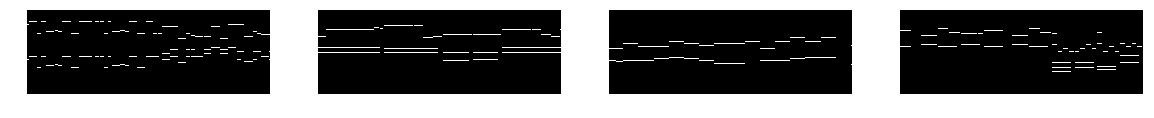

(4, 32, 32, 3)


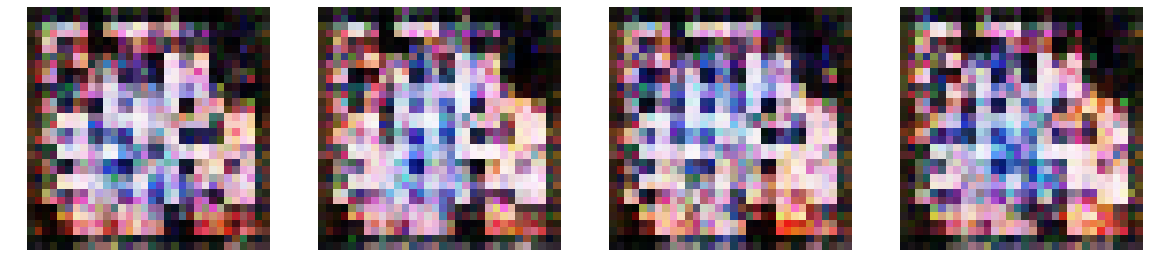

(4, 88, 256, 1)


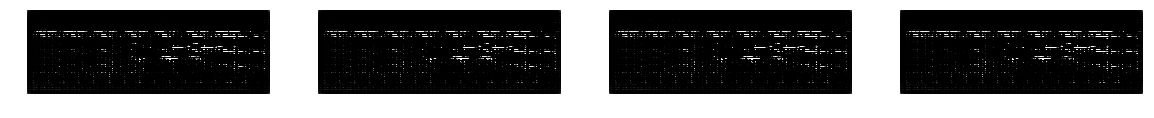

(4, 32, 32, 3)


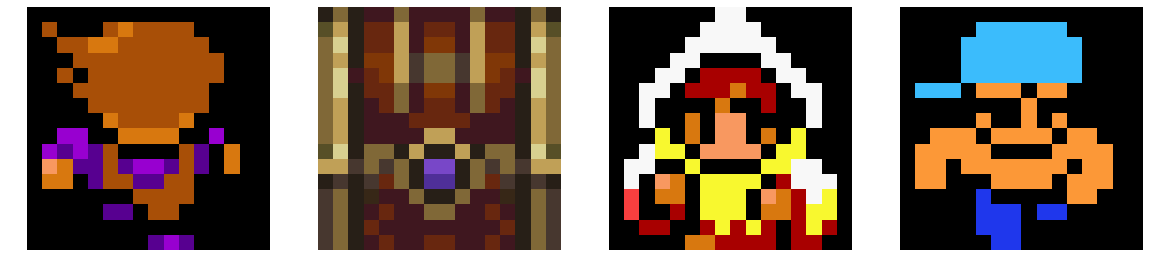

(4, 88, 256, 1)


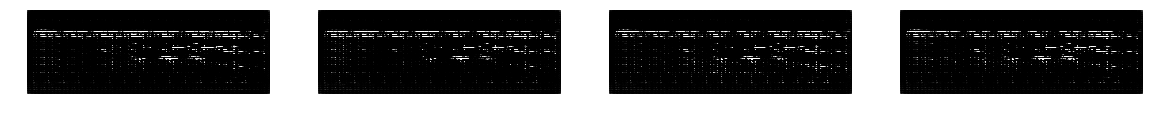

(4, 32, 32, 3)


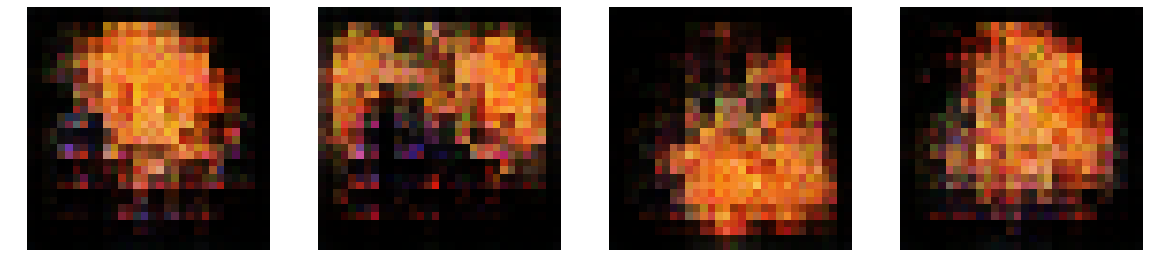

[9/100][3150] Loss_D: 0.015709 0.089653 Loss_G: 0.960594 1.107991 loss_cyc 0.568502 30.976
[9/100][3175] Loss_D: 0.019512 0.084991 Loss_G: 0.988528 1.044058 loss_cyc 0.550574 31.212
[9/100][3200] Loss_D: 0.015817 0.061857 Loss_G: 1.006800 1.107472 loss_cyc 0.564949 31.456
[9/100][3225] Loss_D: 0.014833 0.088688 Loss_G: 0.969444 1.013046 loss_cyc 0.567761 31.701
[9/100][3250] Loss_D: 0.032585 0.047444 Loss_G: 0.973849 1.022606 loss_cyc 0.549135 31.945
[9/100][3275] Loss_D: 0.010493 0.077811 Loss_G: 0.987912 1.155348 loss_cyc 0.562886 32.191
[9/100][3300] Loss_D: 0.009813 0.049653 Loss_G: 0.985098 1.092821 loss_cyc 0.536441 32.429
[9/100][3325] Loss_D: 0.014763 0.057646 Loss_G: 0.986207 1.024688 loss_cyc 0.527715 32.649
[9/100][3350] Loss_D: 0.008471 0.069299 Loss_G: 0.996440 1.010641 loss_cyc 0.528382 32.898
[9/100][3375] Loss_D: 0.011546 0.060194 Loss_G: 0.979506 1.239828 loss_cyc 0.529109 33.132
[9/100][3400] Loss_D: 0.007176 0.057031 Loss_G: 0.994880 1.037857 loss_cyc 0.541237 33.368

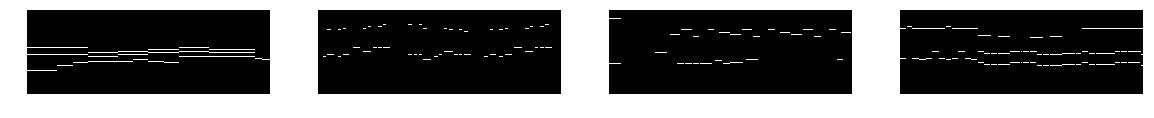

(4, 32, 32, 3)


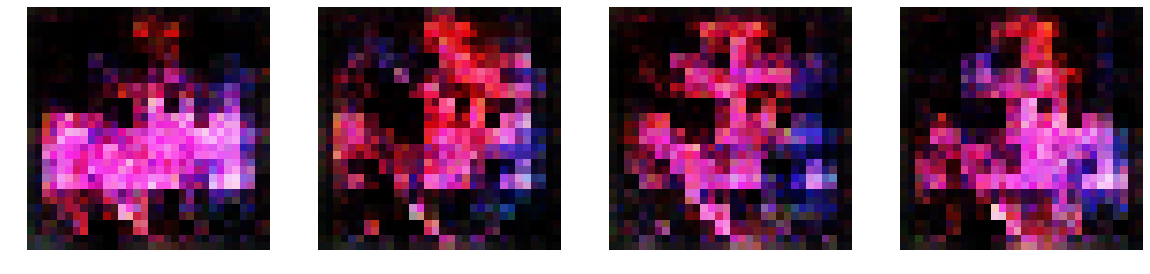

(4, 88, 256, 1)


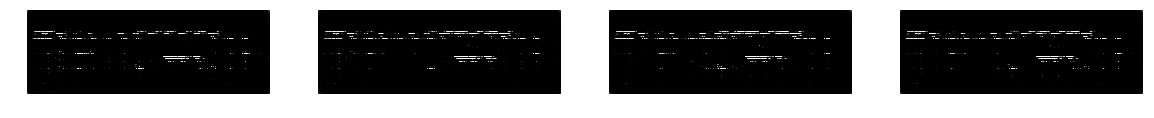

(4, 32, 32, 3)


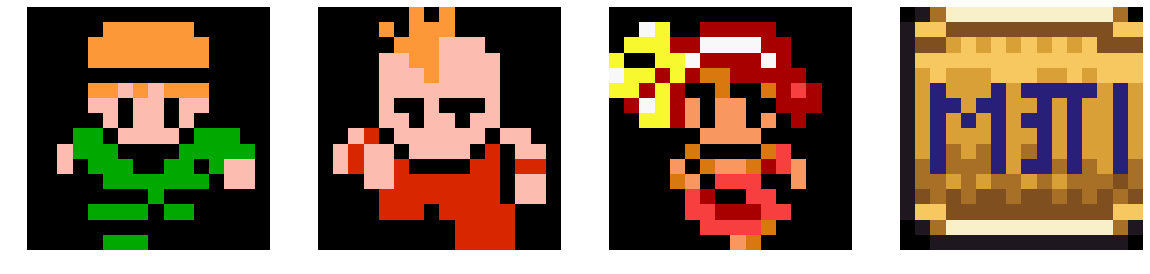

(4, 88, 256, 1)


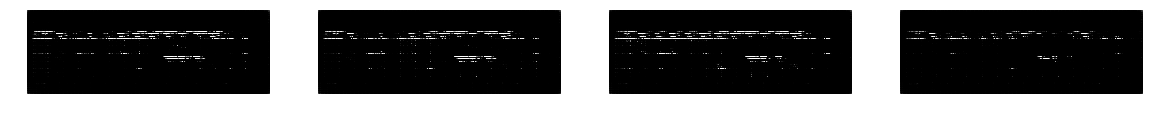

(4, 32, 32, 3)


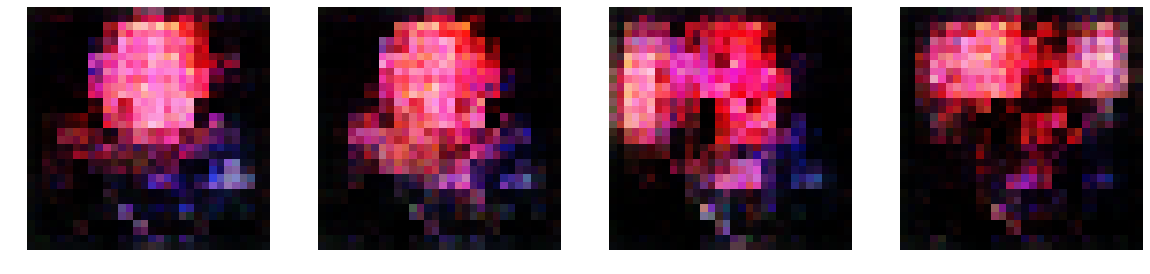

[10/100][3475] Loss_D: 0.013848 0.058671 Loss_G: 0.960863 1.079095 loss_cyc 0.537034 34.119
[10/100][3500] Loss_D: 0.023949 0.051193 Loss_G: 0.974598 0.995004 loss_cyc 0.564331 34.357
[10/100][3525] Loss_D: 0.018370 0.067237 Loss_G: 0.969709 1.107035 loss_cyc 0.538862 34.590
[10/100][3550] Loss_D: 0.011513 0.058356 Loss_G: 0.990577 1.169281 loss_cyc 0.533851 34.830
[10/100][3575] Loss_D: 0.012753 0.103899 Loss_G: 0.983692 1.308786 loss_cyc 0.544766 35.064
[10/100][3600] Loss_D: 0.011550 0.109445 Loss_G: 0.997879 1.210809 loss_cyc 0.546764 35.298
[10/100][3625] Loss_D: 0.018929 0.087182 Loss_G: 0.988730 0.969663 loss_cyc 0.516722 35.528
[10/100][3650] Loss_D: 0.010296 0.096867 Loss_G: 0.987439 0.915715 loss_cyc 0.506671 35.789
[10/100][3675] Loss_D: 0.025289 0.115933 Loss_G: 0.972086 1.053052 loss_cyc 0.553826 36.017
[10/100][3700] Loss_D: 0.016584 0.077635 Loss_G: 0.983082 1.105419 loss_cyc 0.522258 36.253
[10/100][3725] Loss_D: 0.023133 0.075984 Loss_G: 0.953266 1.053392 loss_cyc 0.53

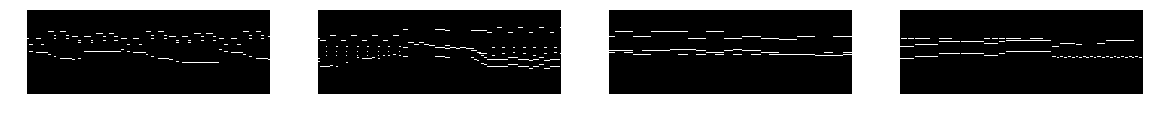

(4, 32, 32, 3)


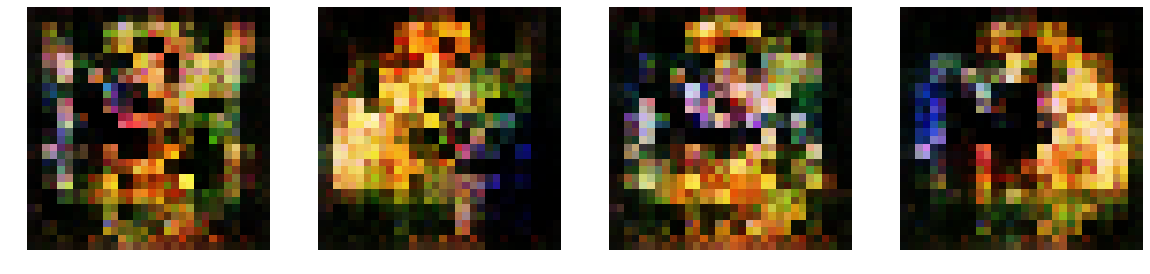

(4, 88, 256, 1)


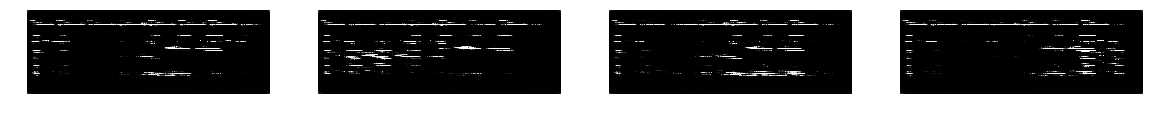

(4, 32, 32, 3)


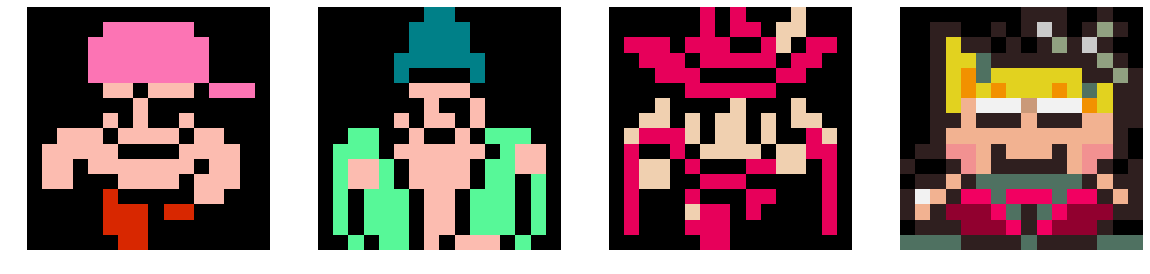

(4, 88, 256, 1)


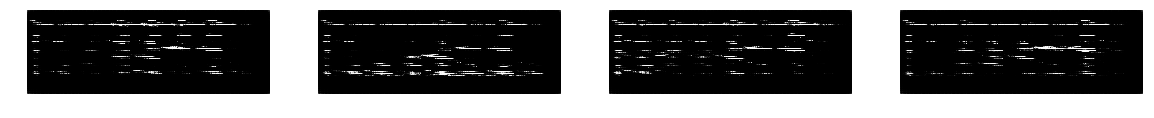

(4, 32, 32, 3)


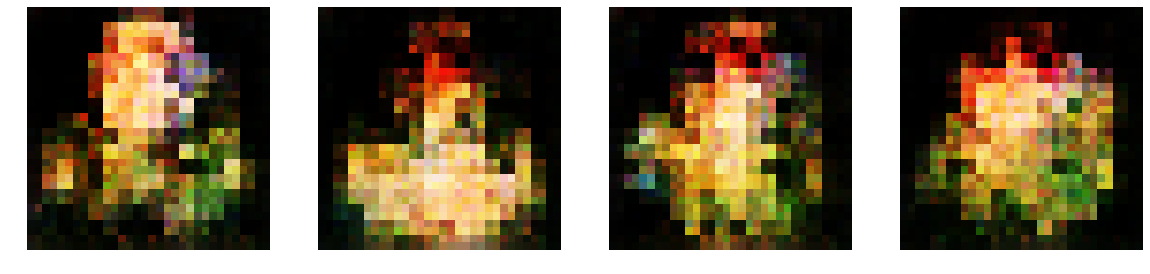

[11/100][3825] Loss_D: 0.026779 0.075001 Loss_G: 0.966053 1.019296 loss_cyc 0.508281 37.504
[11/100][3850] Loss_D: 0.025454 0.072804 Loss_G: 0.932573 1.054633 loss_cyc 0.519313 37.737
[11/100][3875] Loss_D: 0.029355 0.075099 Loss_G: 0.943078 1.018948 loss_cyc 0.545364 37.988
[11/100][3900] Loss_D: 0.018959 0.083326 Loss_G: 0.950587 1.018781 loss_cyc 0.514806 38.224
[11/100][3925] Loss_D: 0.018784 0.070905 Loss_G: 0.973031 0.915687 loss_cyc 0.534430 38.454
[11/100][3950] Loss_D: 0.018723 0.081450 Loss_G: 0.999751 1.092440 loss_cyc 0.531649 38.688
[11/100][3975] Loss_D: 0.018865 0.081036 Loss_G: 0.991668 1.098541 loss_cyc 0.550497 38.921
[11/100][4000] Loss_D: 0.023544 0.081456 Loss_G: 0.990265 1.003310 loss_cyc 0.574362 39.157
[11/100][4025] Loss_D: 0.023400 0.089392 Loss_G: 0.988171 1.056273 loss_cyc 0.531471 39.394
[11/100][4050] Loss_D: 0.028403 0.083361 Loss_G: 0.963298 1.084977 loss_cyc 0.507831 39.641
[11/100][4075] Loss_D: 0.023904 0.084762 Loss_G: 0.967835 0.900818 loss_cyc 0.49

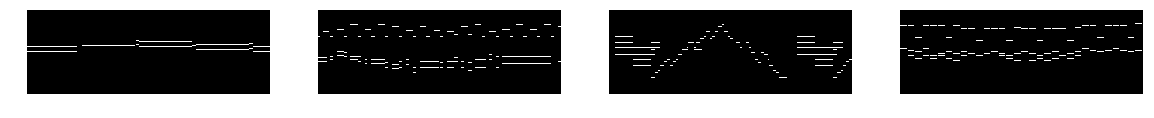

(4, 32, 32, 3)


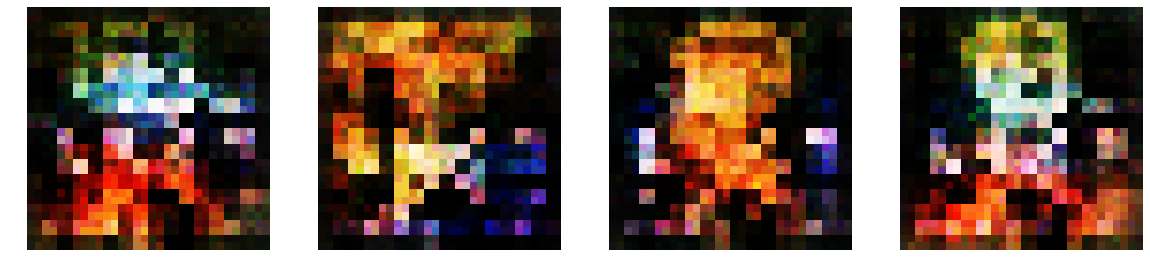

(4, 88, 256, 1)


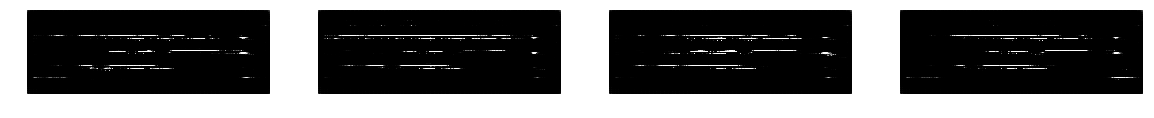

(4, 32, 32, 3)


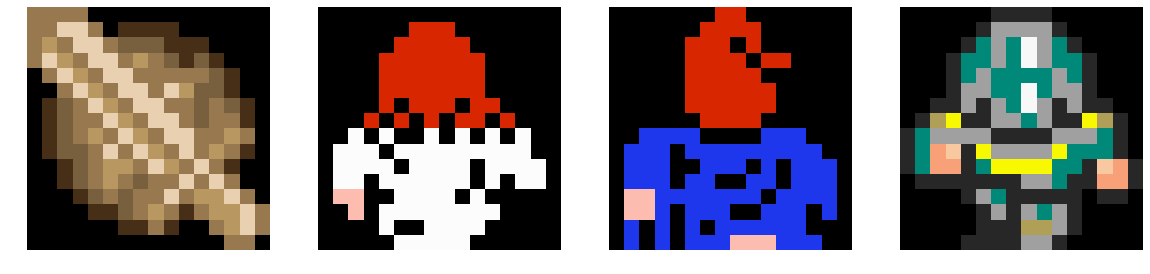

(4, 88, 256, 1)


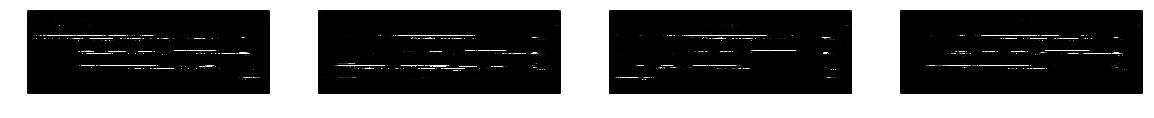

(4, 32, 32, 3)


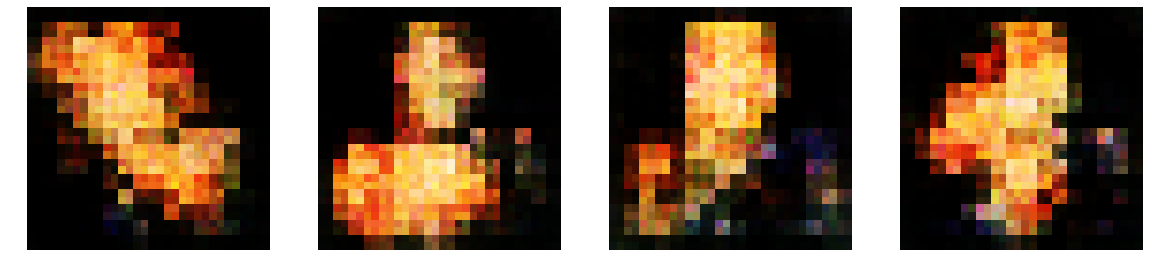

[12/100][4175] Loss_D: 0.028744 0.068708 Loss_G: 0.976444 0.987086 loss_cyc 0.517856 40.875
[12/100][4200] Loss_D: 0.022974 0.077438 Loss_G: 0.968427 1.026528 loss_cyc 0.520594 41.117
[12/100][4225] Loss_D: 0.019737 0.068964 Loss_G: 0.957592 1.013057 loss_cyc 0.511282 41.364
[12/100][4250] Loss_D: 0.025946 0.084638 Loss_G: 0.973355 1.072172 loss_cyc 0.566696 41.595
[12/100][4275] Loss_D: 0.023550 0.075935 Loss_G: 0.959984 0.924590 loss_cyc 0.508654 41.827
[12/100][4300] Loss_D: 0.022135 0.090313 Loss_G: 0.987634 0.914417 loss_cyc 0.532432 42.072
[12/100][4325] Loss_D: 0.017381 0.088885 Loss_G: 1.010247 0.938944 loss_cyc 0.497542 42.310
[12/100][4350] Loss_D: 0.015881 0.094852 Loss_G: 0.985205 1.201601 loss_cyc 0.590999 42.545
[12/100][4375] Loss_D: 0.033738 0.074872 Loss_G: 0.916312 0.940039 loss_cyc 0.537792 42.781
[12/100][4400] Loss_D: 0.028497 0.085778 Loss_G: 0.975280 0.952206 loss_cyc 0.536386 43.019
[12/100][4425] Loss_D: 0.020111 0.123008 Loss_G: 0.969673 0.832069 loss_cyc 0.50

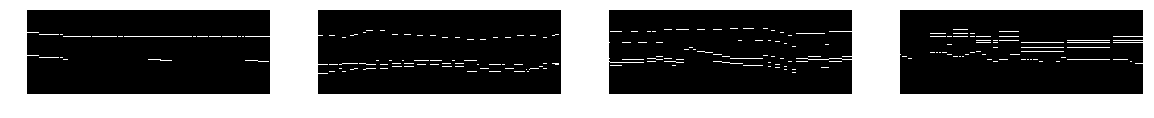

(4, 32, 32, 3)


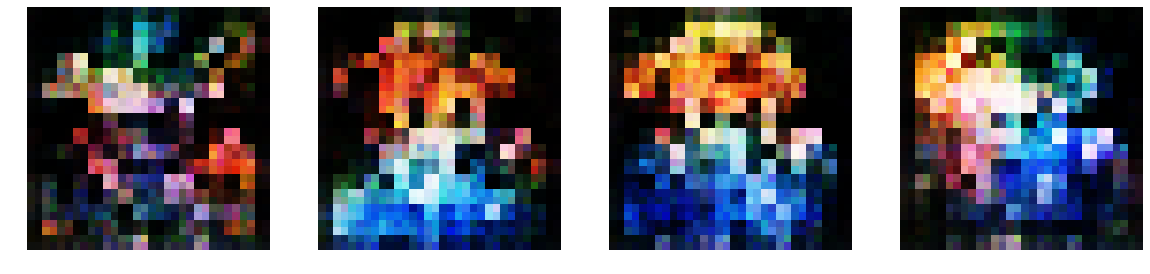

(4, 88, 256, 1)


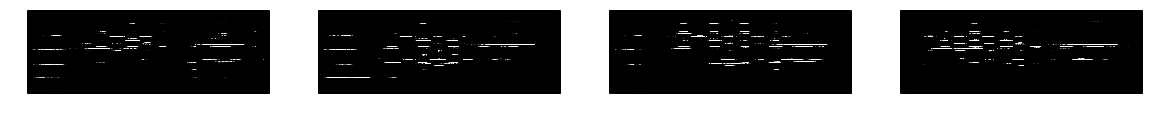

(4, 32, 32, 3)


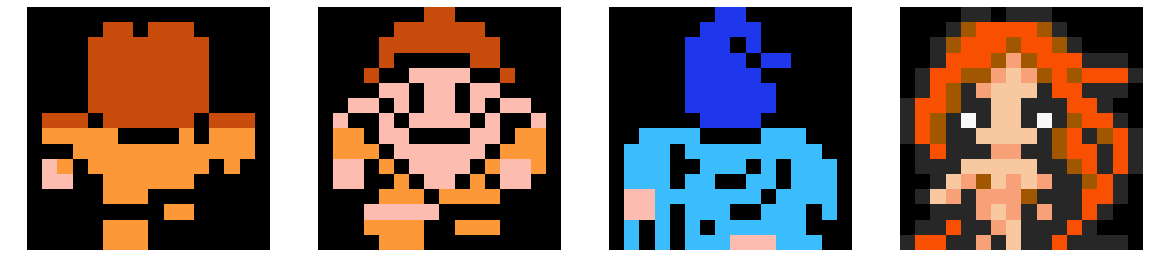

(4, 88, 256, 1)


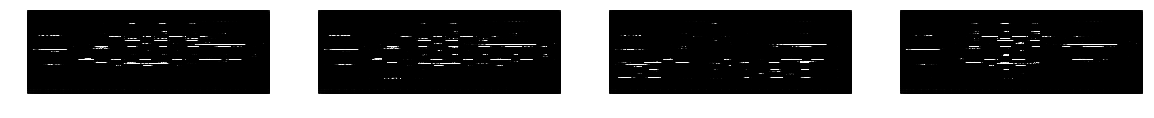

(4, 32, 32, 3)


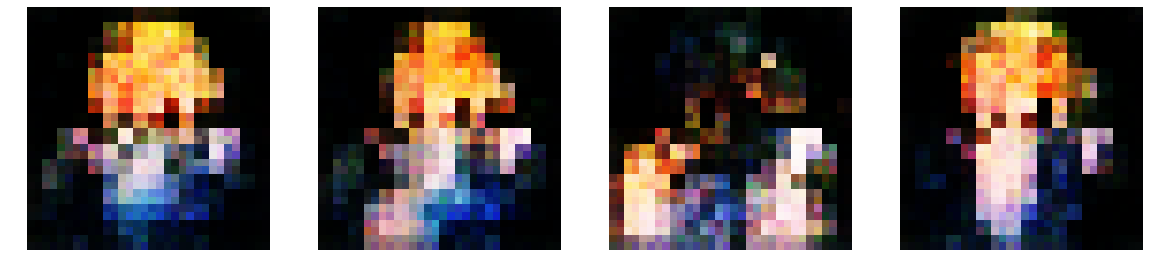

[13/100][4525] Loss_D: 0.029616 0.092752 Loss_G: 0.951711 0.946747 loss_cyc 0.516869 44.254
[13/100][4550] Loss_D: 0.029843 0.069825 Loss_G: 0.977626 0.968124 loss_cyc 0.555532 44.500
[13/100][4575] Loss_D: 0.027201 0.083144 Loss_G: 0.944502 1.039194 loss_cyc 0.524057 44.739
[13/100][4600] Loss_D: 0.036144 0.085057 Loss_G: 0.960152 1.044854 loss_cyc 0.490871 44.981
[13/100][4625] Loss_D: 0.030297 0.077934 Loss_G: 0.962111 1.001030 loss_cyc 0.536930 45.226
[13/100][4650] Loss_D: 0.033466 0.100525 Loss_G: 0.931906 1.144188 loss_cyc 0.557379 45.466
[13/100][4675] Loss_D: 0.013907 0.104465 Loss_G: 0.954861 1.125386 loss_cyc 0.506355 45.703
[13/100][4700] Loss_D: 0.025944 0.102099 Loss_G: 0.959339 0.853283 loss_cyc 0.526035 45.940
[13/100][4725] Loss_D: 0.023389 0.083431 Loss_G: 0.961955 0.905404 loss_cyc 0.497323 46.188
[13/100][4750] Loss_D: 0.025266 0.059232 Loss_G: 0.911466 0.991249 loss_cyc 0.500320 46.421
[13/100][4775] Loss_D: 0.030014 0.113405 Loss_G: 0.931915 1.055978 loss_cyc 0.53

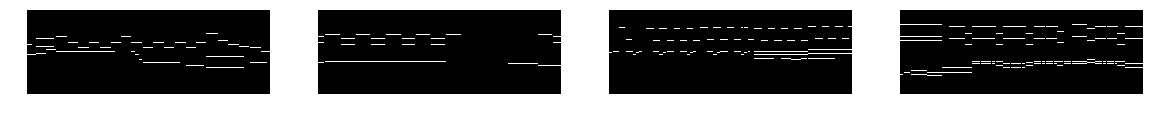

(4, 32, 32, 3)


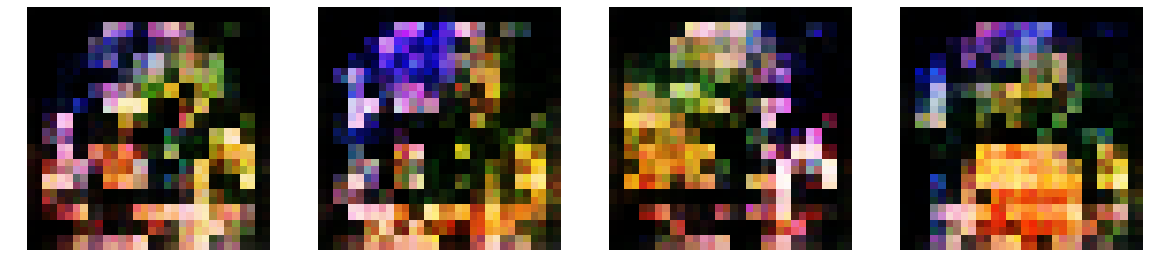

(4, 88, 256, 1)


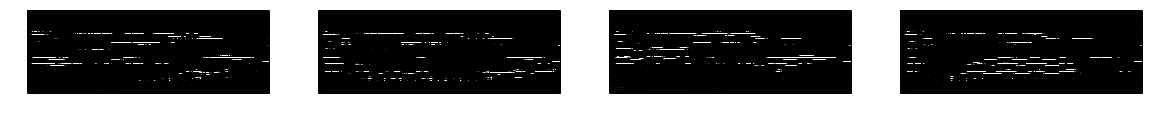

(4, 32, 32, 3)


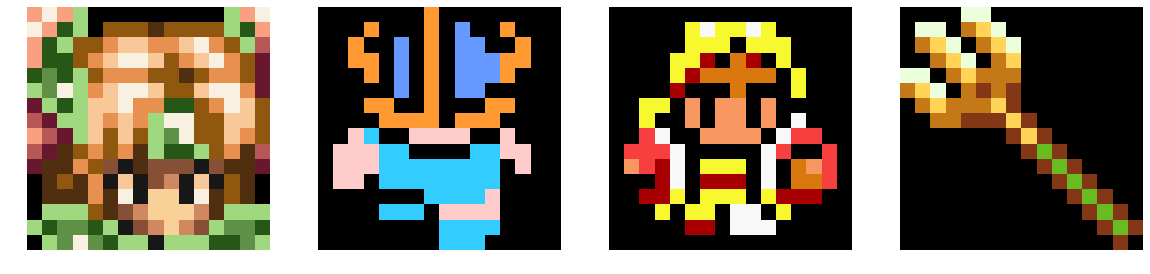

(4, 88, 256, 1)


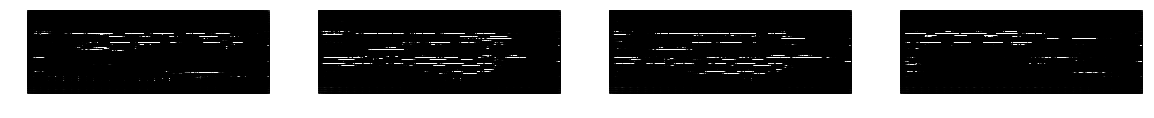

(4, 32, 32, 3)


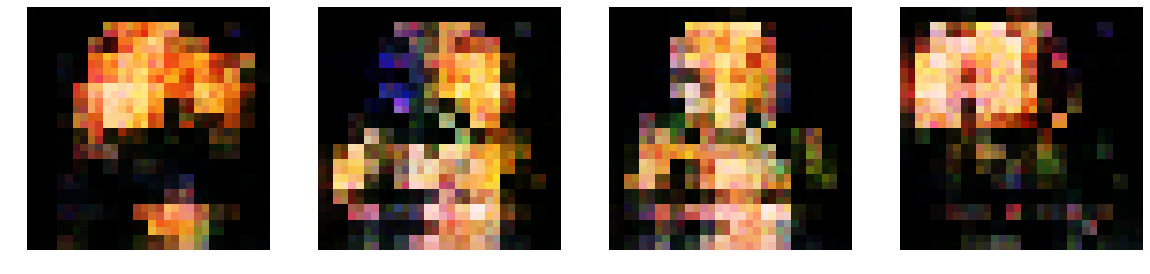

[14/100][4875] Loss_D: 0.026879 0.087626 Loss_G: 0.920709 1.008288 loss_cyc 0.509750 47.616
[14/100][4900] Loss_D: 0.021723 0.089122 Loss_G: 0.964179 0.936644 loss_cyc 0.503425 47.851
[14/100][4925] Loss_D: 0.038650 0.064930 Loss_G: 0.927587 0.989536 loss_cyc 0.515367 48.077
[14/100][4950] Loss_D: 0.034156 0.066461 Loss_G: 0.975363 0.995808 loss_cyc 0.504962 48.316
[14/100][4975] Loss_D: 0.036851 0.060919 Loss_G: 0.951006 0.982343 loss_cyc 0.531220 48.554
[14/100][5000] Loss_D: 0.019200 0.089896 Loss_G: 0.944000 0.980880 loss_cyc 0.528526 48.789
[14/100][5025] Loss_D: 0.022326 0.068225 Loss_G: 0.919178 1.030352 loss_cyc 0.525615 49.028
[14/100][5050] Loss_D: 0.032117 0.106746 Loss_G: 0.939376 1.049703 loss_cyc 0.520985 49.273
[14/100][5075] Loss_D: 0.024531 0.114604 Loss_G: 0.968607 0.840727 loss_cyc 0.538252 49.506
[14/100][5100] Loss_D: 0.025978 0.118793 Loss_G: 0.974190 0.924276 loss_cyc 0.534297 49.760
[14/100][5125] Loss_D: 0.026474 0.097982 Loss_G: 0.957914 0.834140 loss_cyc 0.51

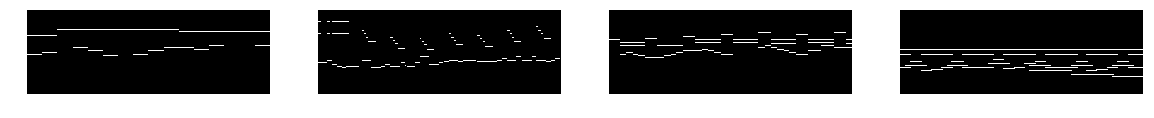

(4, 32, 32, 3)


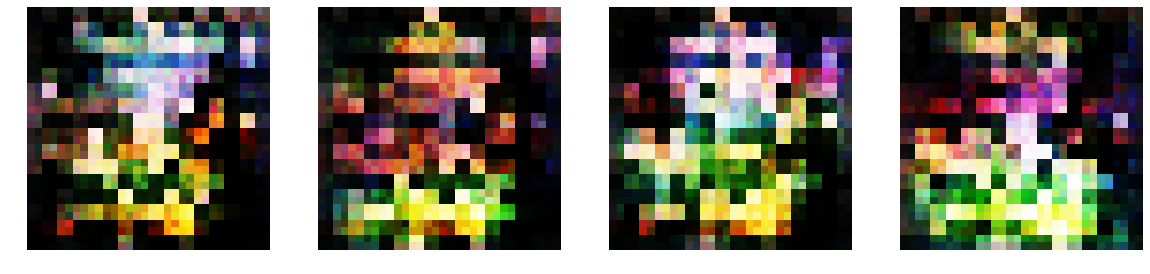

(4, 88, 256, 1)


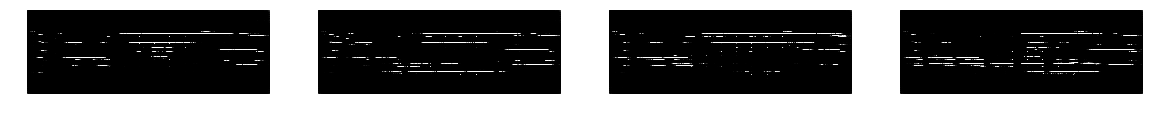

(4, 32, 32, 3)


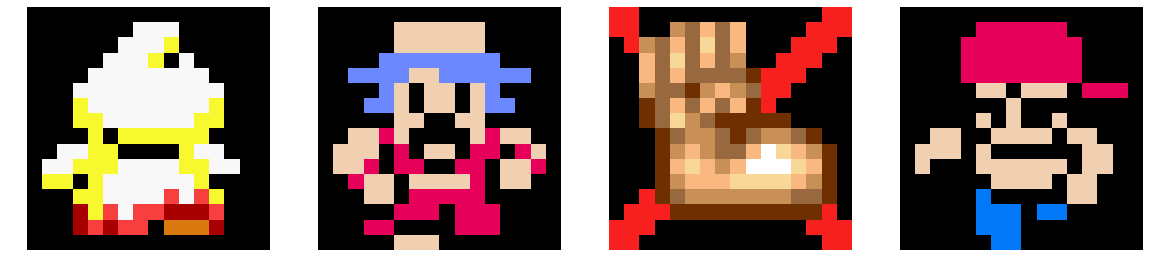

(4, 88, 256, 1)


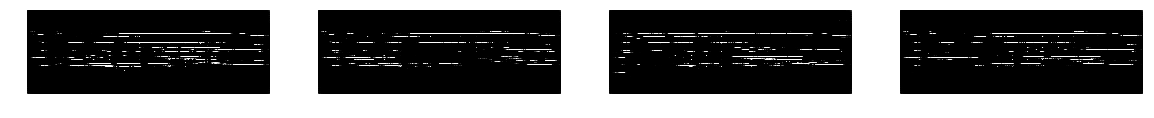

(4, 32, 32, 3)


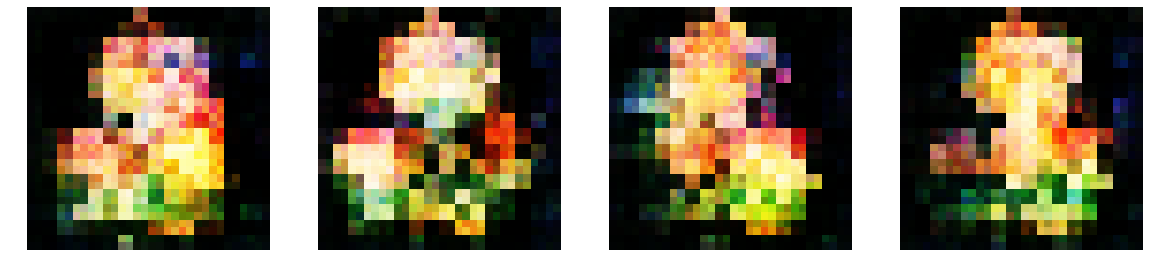

[15/100][5225] Loss_D: 0.065898 0.082177 Loss_G: 0.981619 0.951689 loss_cyc 0.532924 50.994
[15/100][5250] Loss_D: 0.046575 0.074212 Loss_G: 0.953851 1.215979 loss_cyc 0.532155 51.233
[15/100][5275] Loss_D: 0.032455 0.087817 Loss_G: 0.929269 1.077149 loss_cyc 0.564712 51.475
[15/100][5300] Loss_D: 0.034104 0.067847 Loss_G: 0.900914 1.072111 loss_cyc 0.536511 51.702
[15/100][5325] Loss_D: 0.040898 0.088857 Loss_G: 0.949377 1.025125 loss_cyc 0.544254 51.945
[15/100][5350] Loss_D: 0.050639 0.108057 Loss_G: 0.900984 0.946447 loss_cyc 0.506580 52.177
[15/100][5375] Loss_D: 0.057076 0.086325 Loss_G: 0.882401 0.901328 loss_cyc 0.515192 52.411
[15/100][5400] Loss_D: 0.053500 0.087469 Loss_G: 0.906971 0.936425 loss_cyc 0.530756 52.637
[15/100][5425] Loss_D: 0.058795 0.099945 Loss_G: 0.919906 0.911423 loss_cyc 0.524564 52.887
[15/100][5450] Loss_D: 0.029073 0.058985 Loss_G: 1.005813 0.975295 loss_cyc 0.557851 53.117
[15/100][5475] Loss_D: 0.039906 0.052042 Loss_G: 0.921248 1.012064 loss_cyc 0.53

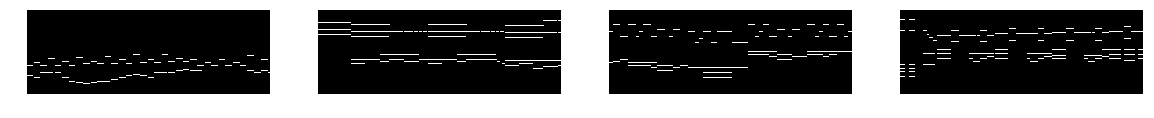

(4, 32, 32, 3)


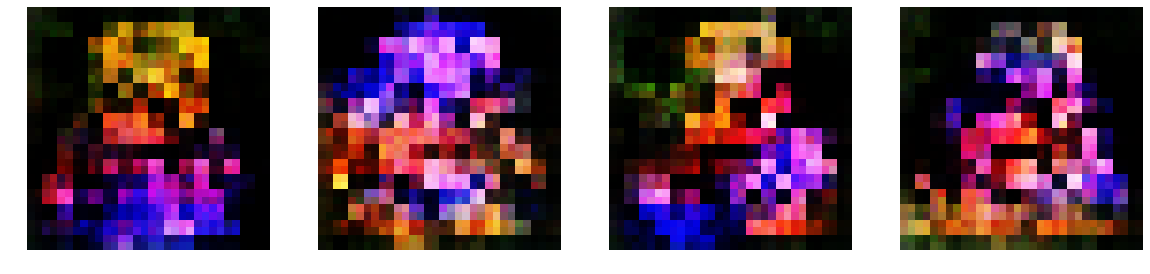

(4, 88, 256, 1)


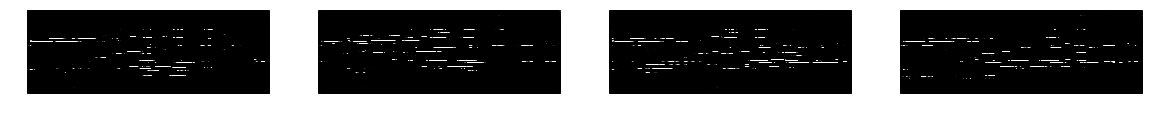

(4, 32, 32, 3)


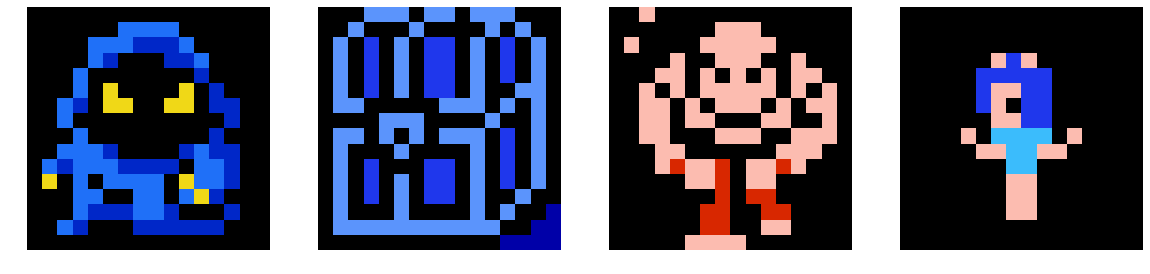

(4, 88, 256, 1)


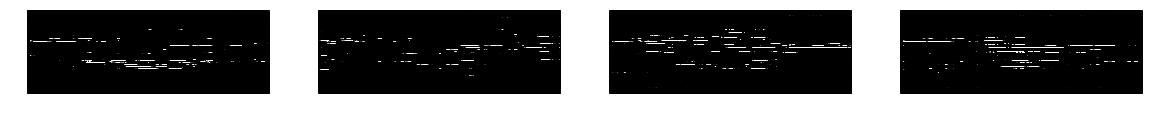

(4, 32, 32, 3)


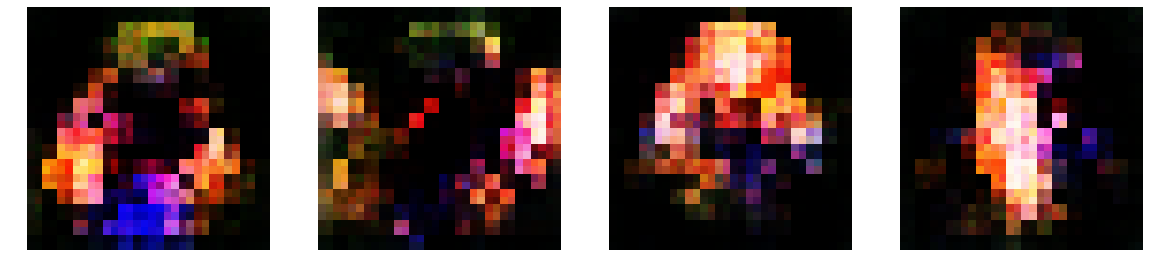

[16/100][5575] Loss_D: 0.027662 0.083796 Loss_G: 0.915882 0.882459 loss_cyc 0.526804 54.355
[16/100][5600] Loss_D: 0.064475 0.083486 Loss_G: 0.920968 0.908910 loss_cyc 0.498308 54.591
[16/100][5625] Loss_D: 0.054366 0.067258 Loss_G: 0.907355 1.133730 loss_cyc 0.505703 54.838
[16/100][5650] Loss_D: 0.037353 0.100086 Loss_G: 0.893844 1.124073 loss_cyc 0.519132 55.077
[16/100][5675] Loss_D: 0.069002 0.083884 Loss_G: 0.911279 1.001451 loss_cyc 0.539806 55.310
[16/100][5700] Loss_D: 0.045283 0.093025 Loss_G: 0.908165 0.848685 loss_cyc 0.535103 55.547
[16/100][5725] Loss_D: 0.056352 0.128819 Loss_G: 0.907696 0.854226 loss_cyc 0.520186 55.782
[16/100][5750] Loss_D: 0.036513 0.060492 Loss_G: 0.955426 0.880382 loss_cyc 0.498814 56.025
[16/100][5775] Loss_D: 0.047449 0.060409 Loss_G: 0.903757 0.875854 loss_cyc 0.515290 56.266
[16/100][5800] Loss_D: 0.041561 0.105132 Loss_G: 0.926181 0.960680 loss_cyc 0.511527 56.500
[16/100][5825] Loss_D: 0.043512 0.082168 Loss_G: 0.937607 0.882582 loss_cyc 0.53

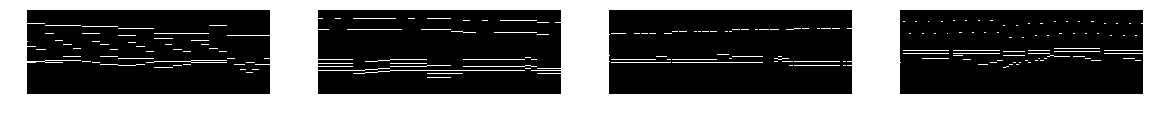

(4, 32, 32, 3)


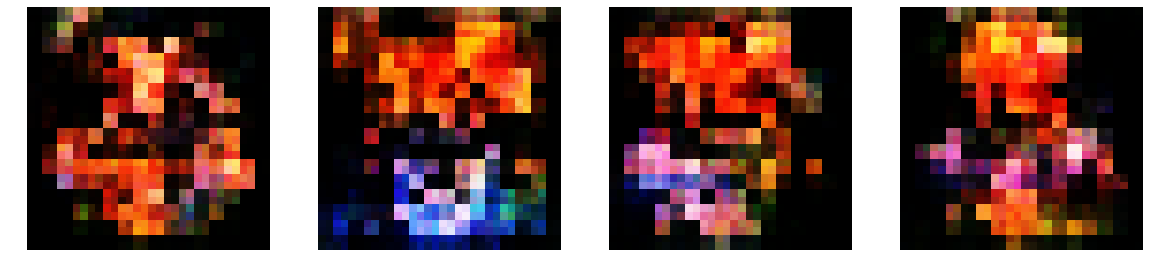

(4, 88, 256, 1)


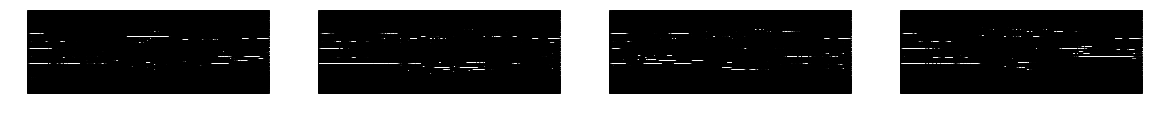

(4, 32, 32, 3)


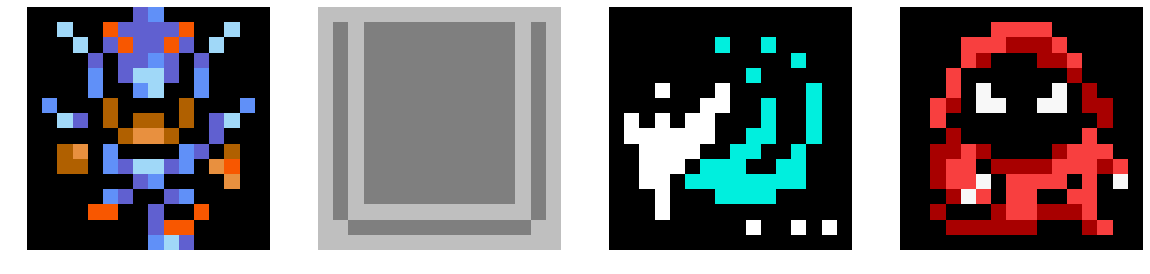

(4, 88, 256, 1)


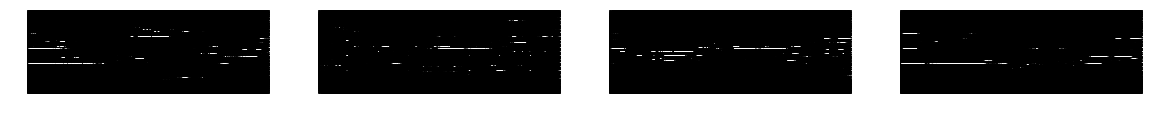

(4, 32, 32, 3)


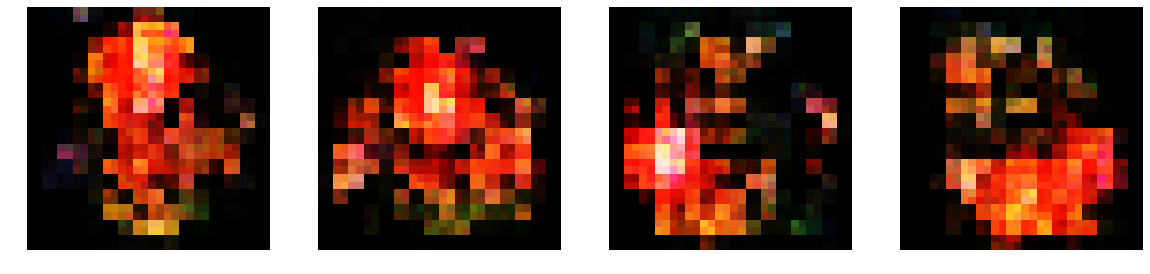

[17/100][5925] Loss_D: 0.036614 0.056222 Loss_G: 0.944255 0.992715 loss_cyc 0.478988 57.738
[17/100][5950] Loss_D: 0.053502 0.081253 Loss_G: 0.862882 0.962532 loss_cyc 0.517907 57.971
[17/100][5975] Loss_D: 0.038756 0.067380 Loss_G: 0.908902 0.880173 loss_cyc 0.496367 58.213
[17/100][6000] Loss_D: 0.042700 0.075472 Loss_G: 0.961090 0.948753 loss_cyc 0.499190 58.450
[17/100][6025] Loss_D: 0.040694 0.072532 Loss_G: 0.847118 0.986271 loss_cyc 0.509266 58.676
[17/100][6050] Loss_D: 0.040792 0.090272 Loss_G: 0.972919 0.926543 loss_cyc 0.487292 58.911
[17/100][6075] Loss_D: 0.045890 0.060901 Loss_G: 0.955187 0.963349 loss_cyc 0.513333 59.151
[17/100][6100] Loss_D: 0.042315 0.072202 Loss_G: 0.923888 0.961458 loss_cyc 0.527212 59.388
[17/100][6125] Loss_D: 0.037981 0.065015 Loss_G: 0.987167 0.918150 loss_cyc 0.494952 59.617
[17/100][6150] Loss_D: 0.039851 0.085811 Loss_G: 0.985619 1.064378 loss_cyc 0.518701 59.856
[17/100][6175] Loss_D: 0.046131 0.076926 Loss_G: 0.914889 0.941561 loss_cyc 0.51

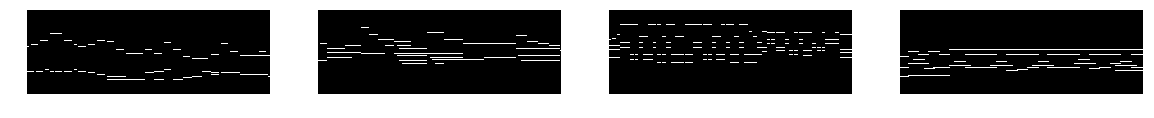

(4, 32, 32, 3)


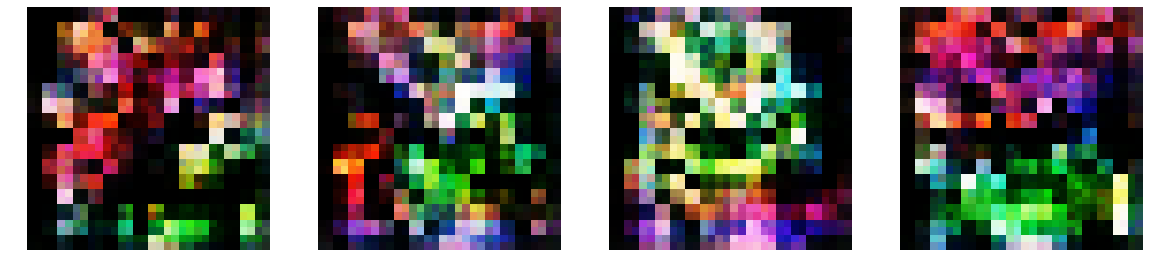

(4, 88, 256, 1)


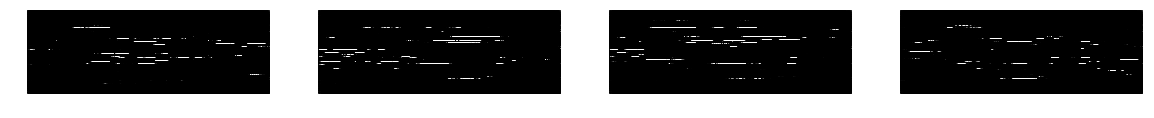

(4, 32, 32, 3)


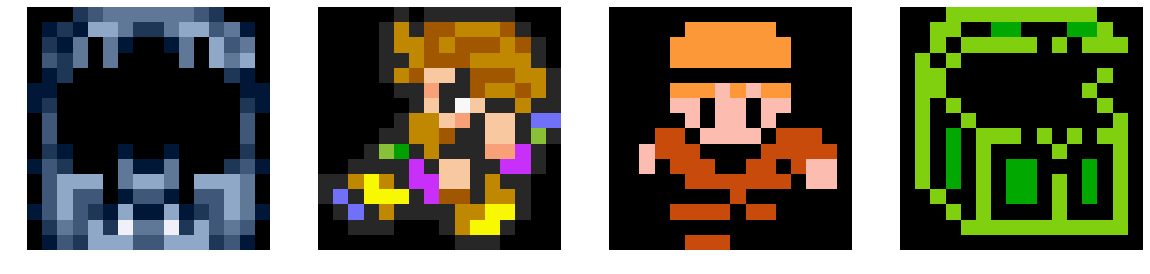

(4, 88, 256, 1)


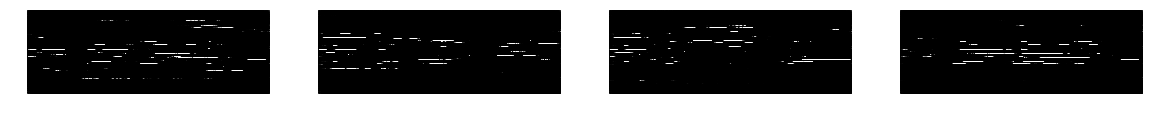

(4, 32, 32, 3)


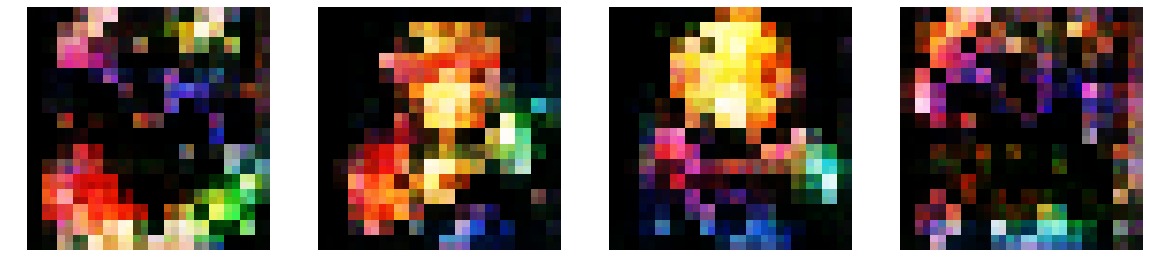

[18/100][6250] Loss_D: 0.031869 0.119689 Loss_G: 0.920013 0.771569 loss_cyc 0.515192 60.875
[18/100][6275] Loss_D: 0.043837 0.097529 Loss_G: 0.912260 0.880957 loss_cyc 0.496780 61.111
[18/100][6300] Loss_D: 0.033594 0.091653 Loss_G: 0.899932 0.870672 loss_cyc 0.518632 61.348
[18/100][6325] Loss_D: 0.041781 0.069955 Loss_G: 0.923463 0.884006 loss_cyc 0.504564 61.577
[18/100][6350] Loss_D: 0.037680 0.073874 Loss_G: 0.928752 0.909405 loss_cyc 0.509406 61.822
[18/100][6375] Loss_D: 0.045348 0.081468 Loss_G: 0.896087 0.943199 loss_cyc 0.525516 62.044
[18/100][6400] Loss_D: 0.043679 0.088019 Loss_G: 0.914132 1.038995 loss_cyc 0.488346 62.279
[18/100][6425] Loss_D: 0.055336 0.074754 Loss_G: 0.887856 0.979094 loss_cyc 0.496357 62.509
[18/100][6450] Loss_D: 0.051130 0.091913 Loss_G: 0.905967 0.833409 loss_cyc 0.492670 62.753
[18/100][6475] Loss_D: 0.063688 0.090239 Loss_G: 0.916246 0.867190 loss_cyc 0.491604 62.991
[18/100][6500] Loss_D: 0.063597 0.088170 Loss_G: 0.927655 0.897364 loss_cyc 0.49

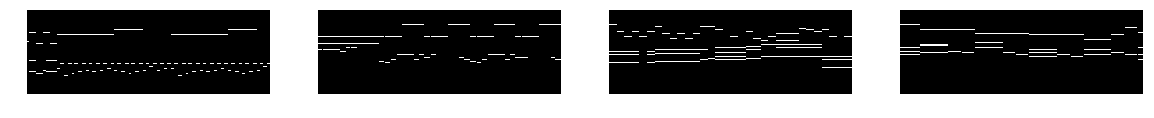

(4, 32, 32, 3)


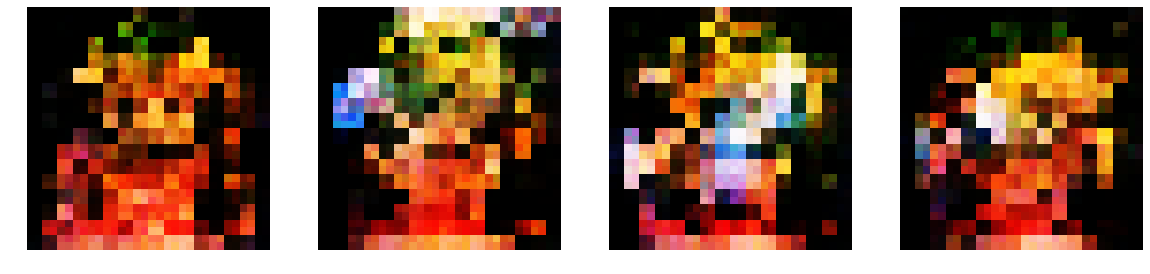

(4, 88, 256, 1)


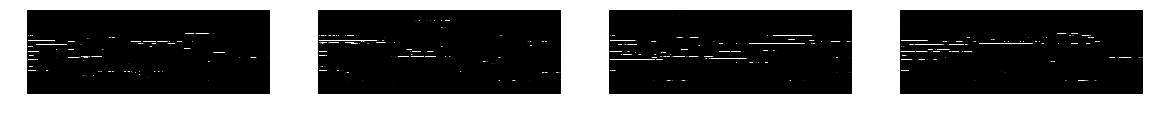

(4, 32, 32, 3)


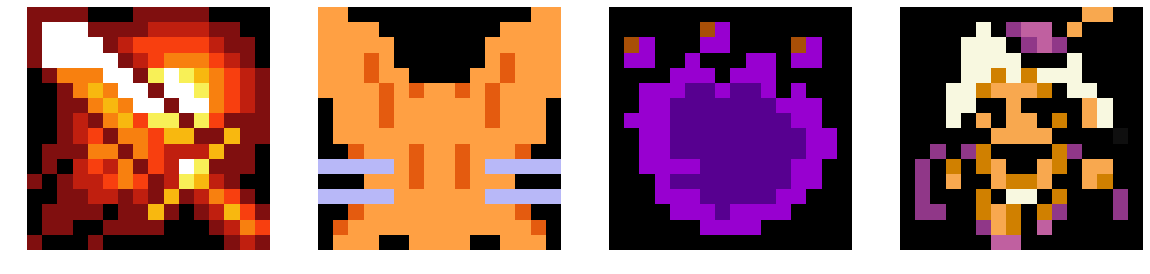

(4, 88, 256, 1)


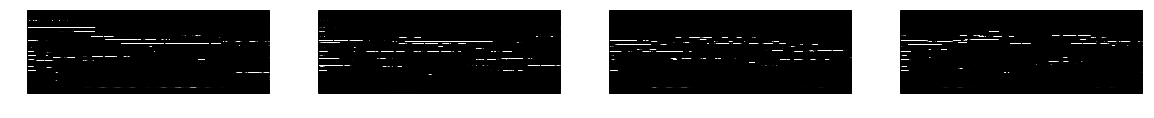

(4, 32, 32, 3)


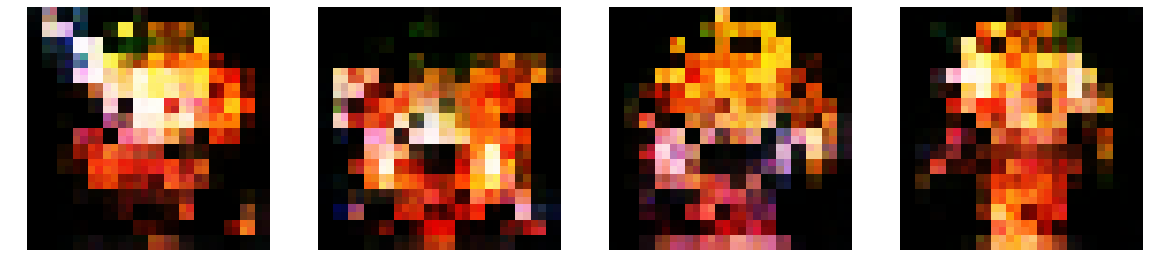

[19/100][6600] Loss_D: 0.040322 0.139287 Loss_G: 0.921609 0.926215 loss_cyc 0.482191 64.249
[19/100][6625] Loss_D: 0.052776 0.087473 Loss_G: 0.923091 0.898211 loss_cyc 0.493069 64.483
[19/100][6650] Loss_D: 0.046879 0.073881 Loss_G: 0.846492 0.989253 loss_cyc 0.478809 64.713
[19/100][6675] Loss_D: 0.048738 0.102132 Loss_G: 0.902865 0.909518 loss_cyc 0.502331 64.948
[19/100][6700] Loss_D: 0.049492 0.094590 Loss_G: 0.951993 0.960132 loss_cyc 0.468306 65.192
[19/100][6725] Loss_D: 0.046099 0.075036 Loss_G: 0.899862 1.081086 loss_cyc 0.466216 65.437
[19/100][6750] Loss_D: 0.044201 0.093236 Loss_G: 0.909219 0.941082 loss_cyc 0.478788 65.666
[19/100][6775] Loss_D: 0.046150 0.101765 Loss_G: 1.004107 0.843807 loss_cyc 0.475557 65.897
[19/100][6800] Loss_D: 0.061235 0.088804 Loss_G: 0.913756 0.886362 loss_cyc 0.458898 66.140
[19/100][6825] Loss_D: 0.063872 0.052595 Loss_G: 0.923562 0.967852 loss_cyc 0.496816 66.370
[19/100][6850] Loss_D: 0.034543 0.057783 Loss_G: 0.911981 0.995482 loss_cyc 0.48

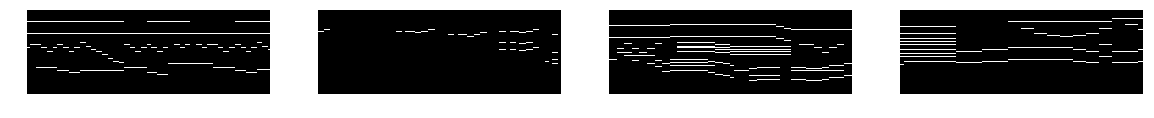

(4, 32, 32, 3)


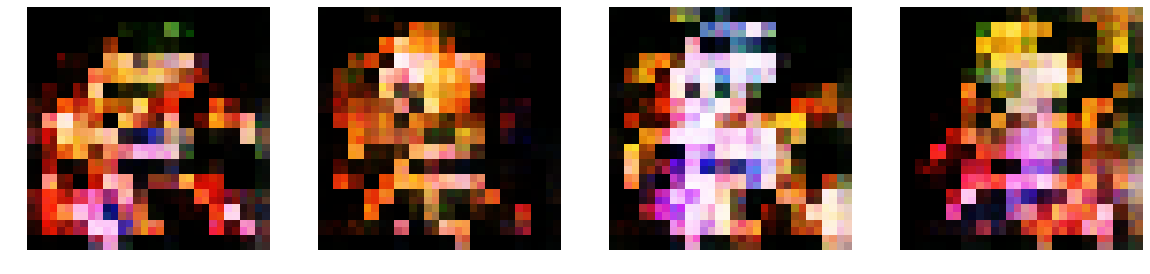

(4, 88, 256, 1)


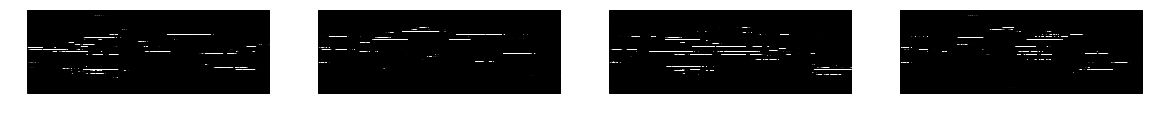

(4, 32, 32, 3)


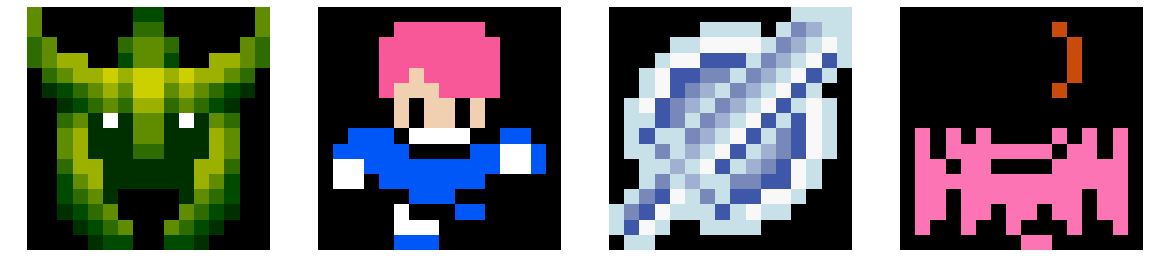

(4, 88, 256, 1)


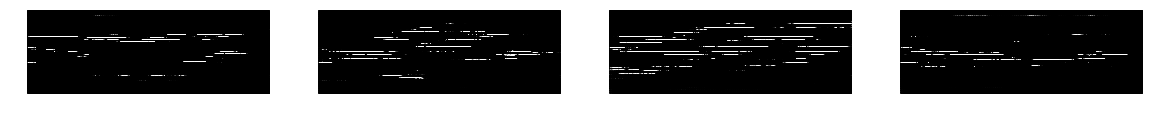

(4, 32, 32, 3)


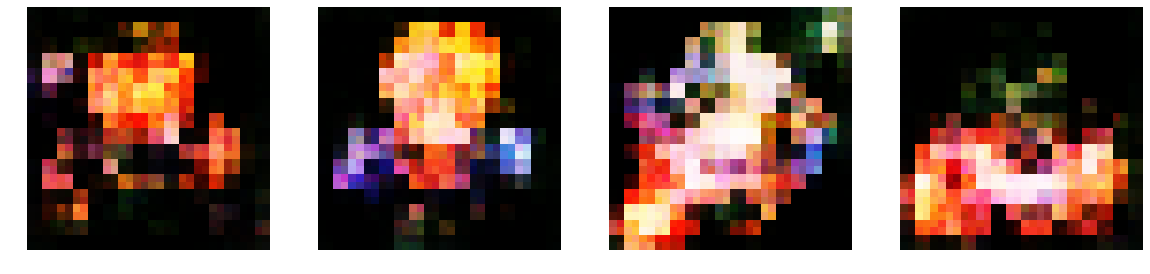

[20/100][6950] Loss_D: 0.061306 0.061496 Loss_G: 0.895745 0.981756 loss_cyc 0.453509 67.627
[20/100][6975] Loss_D: 0.066722 0.067745 Loss_G: 0.897808 1.004151 loss_cyc 0.469652 67.866
[20/100][7000] Loss_D: 0.032739 0.082623 Loss_G: 0.951130 0.963588 loss_cyc 0.476864 68.099
[20/100][7025] Loss_D: 0.050448 0.092134 Loss_G: 0.850913 0.923851 loss_cyc 0.509977 68.351
[20/100][7050] Loss_D: 0.041498 0.096270 Loss_G: 0.917274 1.044735 loss_cyc 0.466016 68.589
[20/100][7075] Loss_D: 0.066779 0.064128 Loss_G: 0.886428 1.024687 loss_cyc 0.496984 68.827
[20/100][7100] Loss_D: 0.051387 0.057705 Loss_G: 0.875965 0.983154 loss_cyc 0.518028 69.053
[20/100][7125] Loss_D: 0.070172 0.066020 Loss_G: 0.843075 0.957209 loss_cyc 0.472457 69.291
[20/100][7150] Loss_D: 0.032484 0.083181 Loss_G: 0.967826 0.933795 loss_cyc 0.491010 69.522
[20/100][7175] Loss_D: 0.052924 0.081193 Loss_G: 0.912253 1.015631 loss_cyc 0.517768 69.768
[20/100][7200] Loss_D: 0.035836 0.077046 Loss_G: 0.935226 0.914022 loss_cyc 0.46

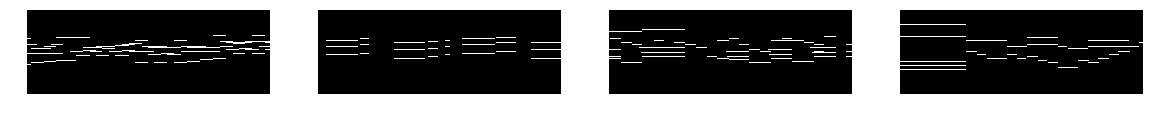

(4, 32, 32, 3)


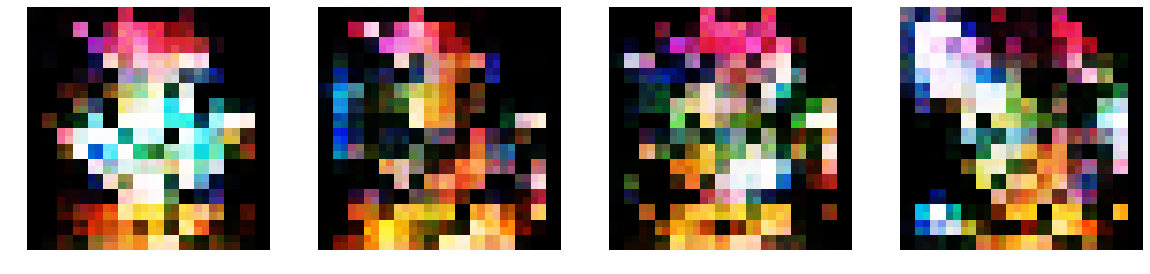

(4, 88, 256, 1)


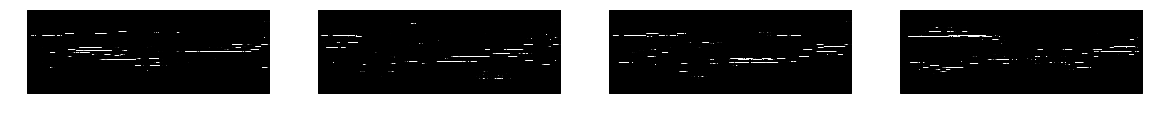

(4, 32, 32, 3)


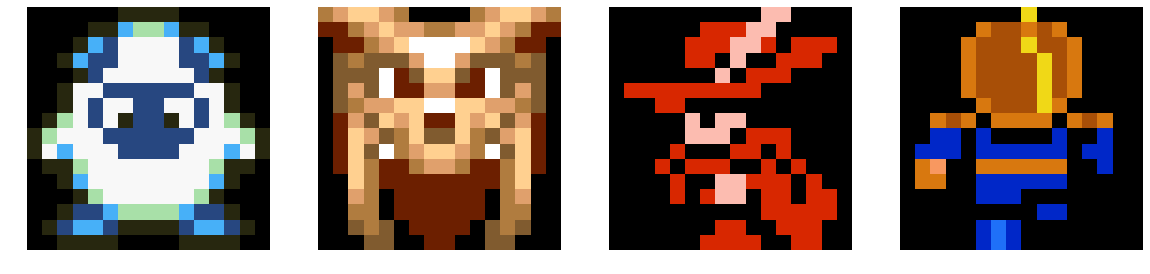

(4, 88, 256, 1)


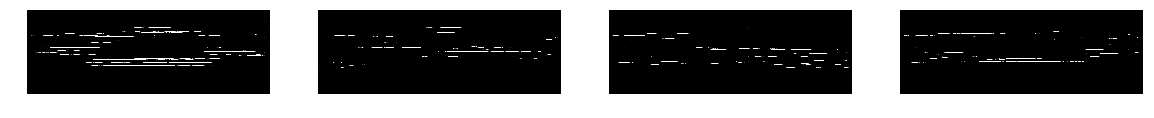

(4, 32, 32, 3)


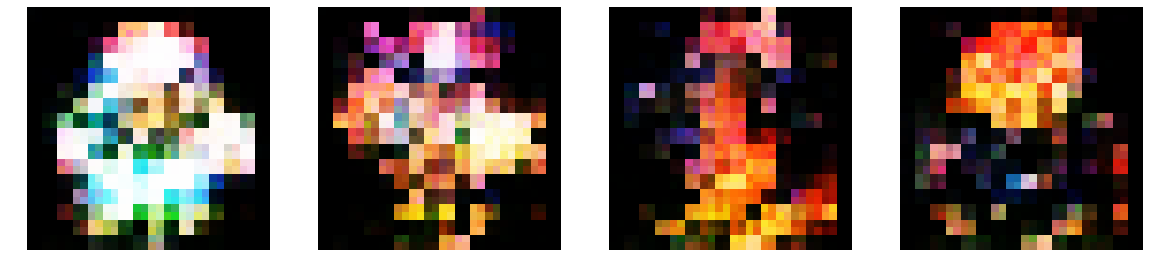

[21/100][7300] Loss_D: 0.047958 0.079631 Loss_G: 0.929050 1.025325 loss_cyc 0.501314 71.005
[21/100][7325] Loss_D: 0.032661 0.076265 Loss_G: 0.911319 1.013712 loss_cyc 0.496096 71.241
[21/100][7350] Loss_D: 0.043788 0.074889 Loss_G: 0.993701 0.927711 loss_cyc 0.469630 71.474
[21/100][7375] Loss_D: 0.039541 0.048383 Loss_G: 0.879371 0.885486 loss_cyc 0.475993 71.729
[21/100][7400] Loss_D: 0.043758 0.060991 Loss_G: 0.929961 0.950224 loss_cyc 0.505410 71.972
[21/100][7425] Loss_D: 0.049093 0.080583 Loss_G: 0.893631 0.977225 loss_cyc 0.474307 72.198
[21/100][7450] Loss_D: 0.045096 0.090428 Loss_G: 0.975838 0.912708 loss_cyc 0.514165 72.450
[21/100][7475] Loss_D: 0.037969 0.083492 Loss_G: 0.953422 0.942832 loss_cyc 0.468638 72.688
[21/100][7500] Loss_D: 0.043004 0.058602 Loss_G: 0.827723 0.897929 loss_cyc 0.459733 72.915
[21/100][7525] Loss_D: 0.032605 0.061804 Loss_G: 0.952724 0.912233 loss_cyc 0.477256 73.148
[21/100][7550] Loss_D: 0.042139 0.087576 Loss_G: 0.915860 0.965284 loss_cyc 0.49

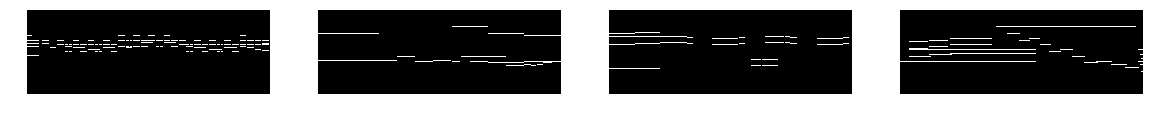

(4, 32, 32, 3)


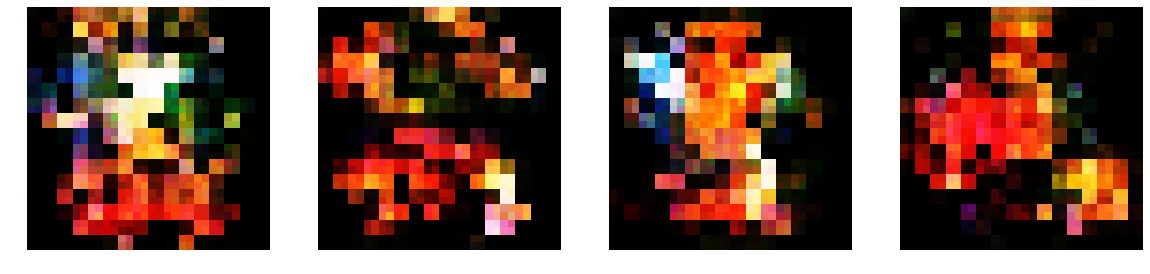

(4, 88, 256, 1)


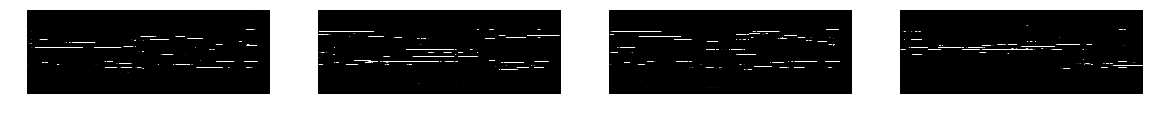

(4, 32, 32, 3)


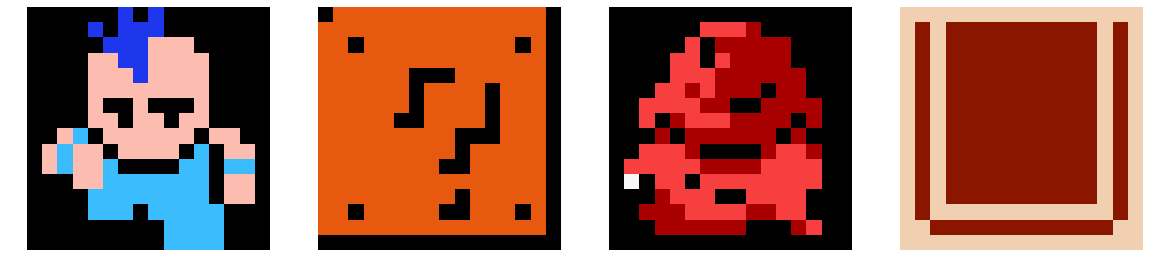

(4, 88, 256, 1)


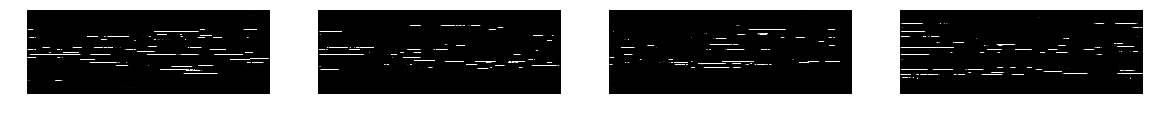

(4, 32, 32, 3)


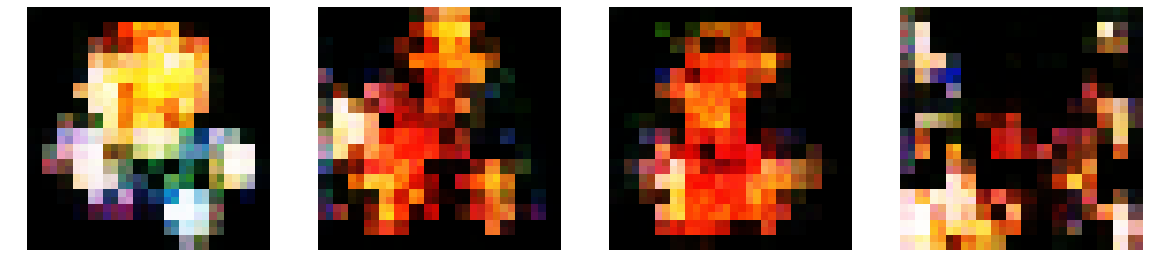

[22/100][7650] Loss_D: 0.031868 0.076658 Loss_G: 0.905199 0.887318 loss_cyc 0.481396 74.387
[22/100][7675] Loss_D: 0.063750 0.065053 Loss_G: 0.906749 0.928171 loss_cyc 0.480611 74.622
[22/100][7700] Loss_D: 0.026911 0.074881 Loss_G: 0.919222 1.021649 loss_cyc 0.488002 74.865
[22/100][7725] Loss_D: 0.041059 0.069347 Loss_G: 0.866544 0.943797 loss_cyc 0.461158 75.109
[22/100][7750] Loss_D: 0.054278 0.089416 Loss_G: 0.867679 1.069451 loss_cyc 0.481078 75.354
[22/100][7775] Loss_D: 0.056390 0.090305 Loss_G: 0.921221 0.968229 loss_cyc 0.488360 75.595
[22/100][7800] Loss_D: 0.047721 0.070292 Loss_G: 0.877061 0.931882 loss_cyc 0.452677 75.824
[22/100][7825] Loss_D: 0.050071 0.072235 Loss_G: 0.951733 0.825387 loss_cyc 0.467862 76.053
[22/100][7850] Loss_D: 0.034526 0.085569 Loss_G: 0.922343 0.931955 loss_cyc 0.458122 76.287
[22/100][7875] Loss_D: 0.063902 0.081644 Loss_G: 0.876871 0.838009 loss_cyc 0.469635 76.519
[22/100][7900] Loss_D: 0.056803 0.154995 Loss_G: 0.874847 1.047295 loss_cyc 0.48

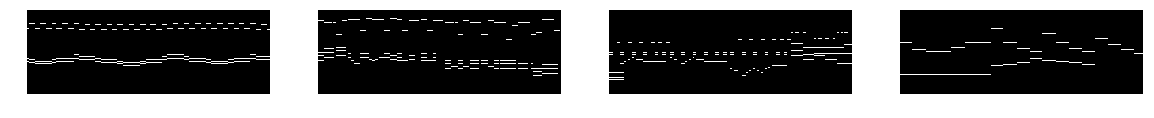

(4, 32, 32, 3)


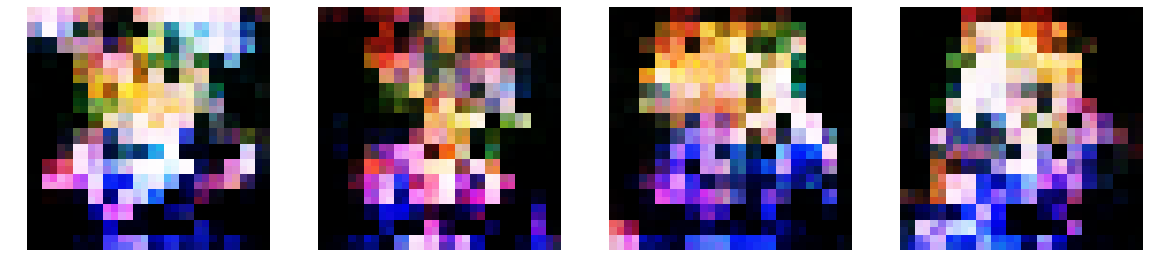

(4, 88, 256, 1)


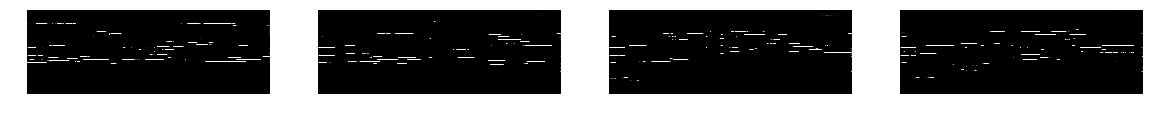

(4, 32, 32, 3)


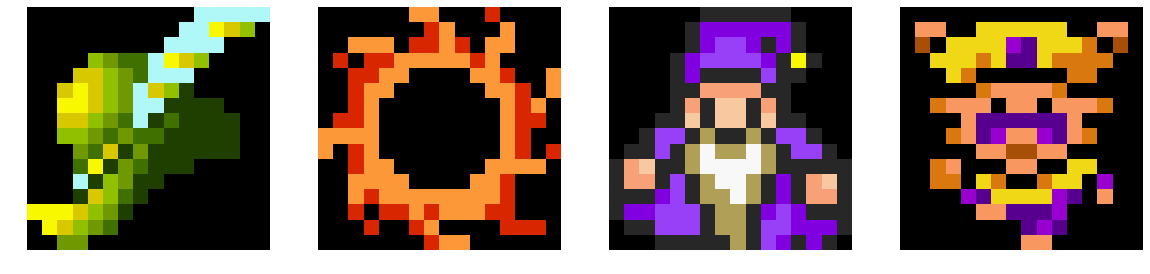

(4, 88, 256, 1)


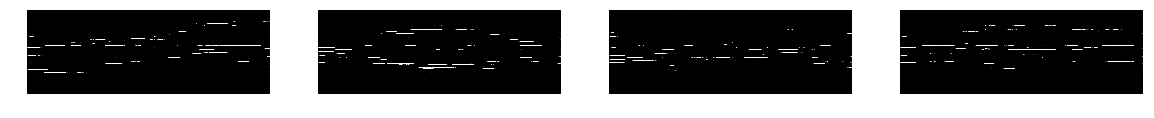

(4, 32, 32, 3)


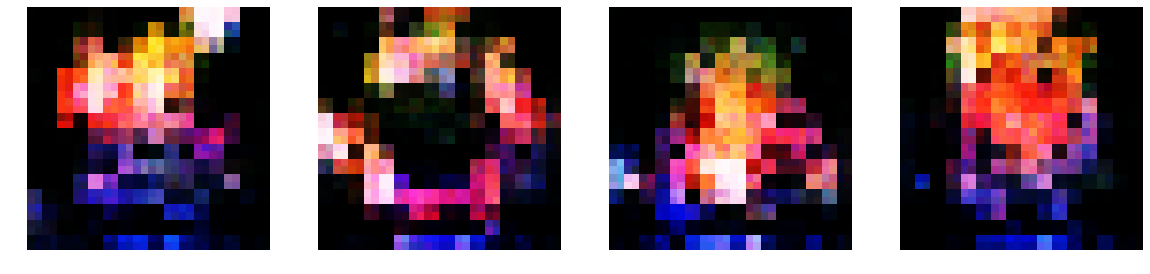

[23/100][8000] Loss_D: 0.029878 0.067174 Loss_G: 0.943234 0.925194 loss_cyc 0.475538 77.768
[23/100][8025] Loss_D: 0.043631 0.089602 Loss_G: 0.920478 0.913007 loss_cyc 0.465642 78.007
[23/100][8050] Loss_D: 0.043781 0.081548 Loss_G: 0.867906 0.870774 loss_cyc 0.468611 78.253
[23/100][8075] Loss_D: 0.036974 0.054709 Loss_G: 0.915712 0.898726 loss_cyc 0.428747 78.486
[23/100][8100] Loss_D: 0.031853 0.057212 Loss_G: 0.929338 0.915692 loss_cyc 0.425528 78.727
[23/100][8125] Loss_D: 0.064822 0.076508 Loss_G: 0.894829 0.927606 loss_cyc 0.474920 78.965
[23/100][8150] Loss_D: 0.029161 0.073074 Loss_G: 0.950173 0.920076 loss_cyc 0.448707 79.197
[23/100][8175] Loss_D: 0.036657 0.049131 Loss_G: 0.898439 0.899602 loss_cyc 0.482684 79.431
[23/100][8200] Loss_D: 0.048429 0.082268 Loss_G: 0.916726 0.877710 loss_cyc 0.481012 79.665
[23/100][8225] Loss_D: 0.053005 0.061800 Loss_G: 0.882622 0.969086 loss_cyc 0.484226 79.901
[23/100][8250] Loss_D: 0.035579 0.103294 Loss_G: 0.921388 0.933556 loss_cyc 0.45

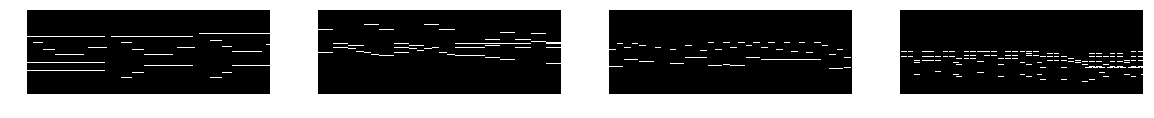

(4, 32, 32, 3)


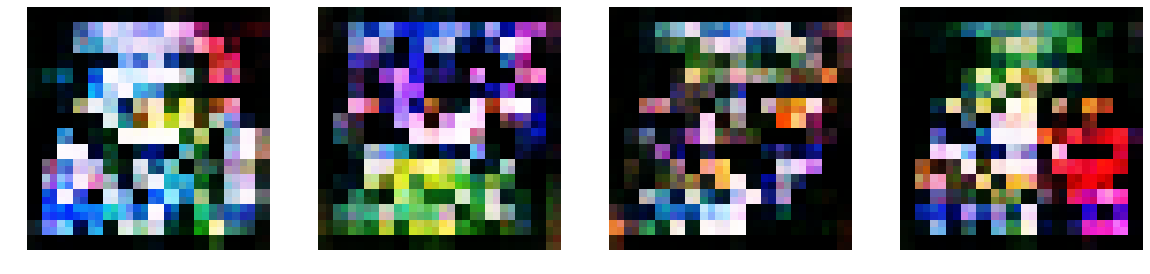

(4, 88, 256, 1)


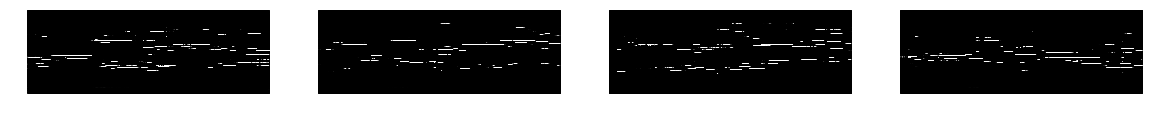

(4, 32, 32, 3)


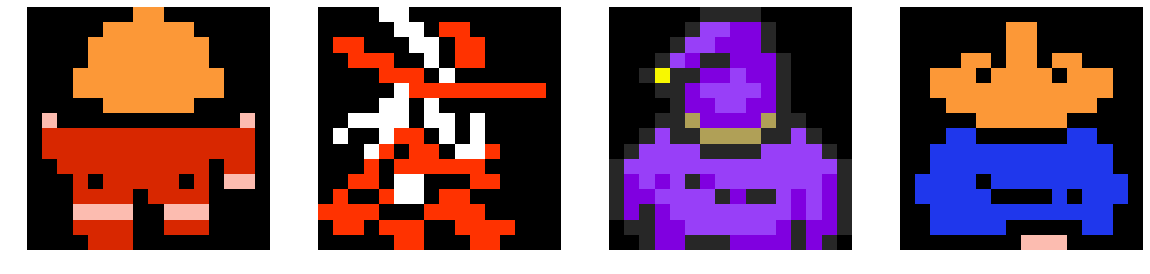

(4, 88, 256, 1)


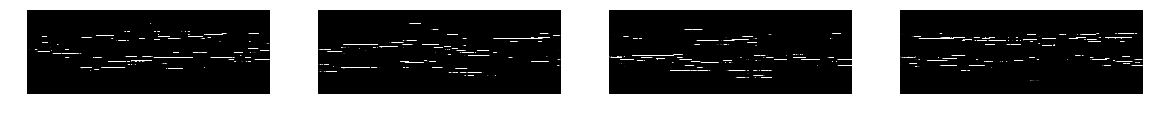

(4, 32, 32, 3)


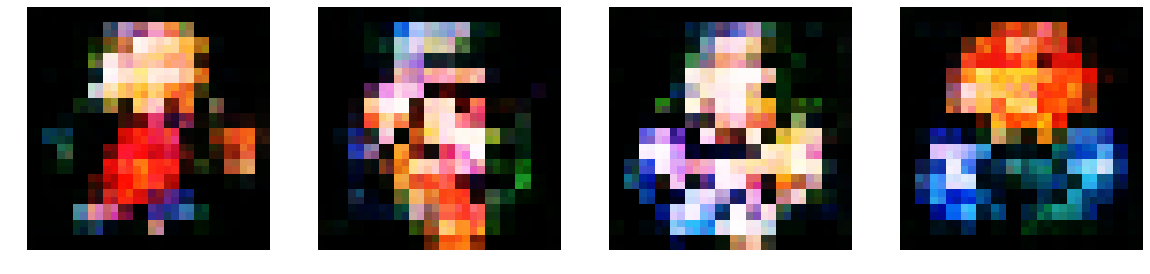

[24/100][8350] Loss_D: 0.049093 0.075090 Loss_G: 0.864390 0.936014 loss_cyc 0.481401 81.152
[24/100][8375] Loss_D: 0.049938 0.073659 Loss_G: 0.932006 0.901660 loss_cyc 0.457135 81.381
[24/100][8400] Loss_D: 0.042119 0.075480 Loss_G: 0.903994 1.030672 loss_cyc 0.466569 81.627
[24/100][8425] Loss_D: 0.047704 0.097996 Loss_G: 0.911948 0.899333 loss_cyc 0.464493 81.864
[24/100][8450] Loss_D: 0.057967 0.063744 Loss_G: 0.857266 0.911855 loss_cyc 0.452639 82.101
[24/100][8475] Loss_D: 0.045712 0.054616 Loss_G: 0.857242 1.010978 loss_cyc 0.457922 82.332
[24/100][8500] Loss_D: 0.059268 0.071570 Loss_G: 0.908326 0.945418 loss_cyc 0.469363 82.571
[24/100][8525] Loss_D: 0.049273 0.072109 Loss_G: 0.904672 0.935736 loss_cyc 0.476465 82.813
[24/100][8550] Loss_D: 0.059754 0.058175 Loss_G: 0.882401 0.850693 loss_cyc 0.459428 83.052
[24/100][8575] Loss_D: 0.057910 0.087419 Loss_G: 0.887027 0.892022 loss_cyc 0.467422 83.284
[24/100][8600] Loss_D: 0.056499 0.075584 Loss_G: 0.843999 0.939822 loss_cyc 0.45

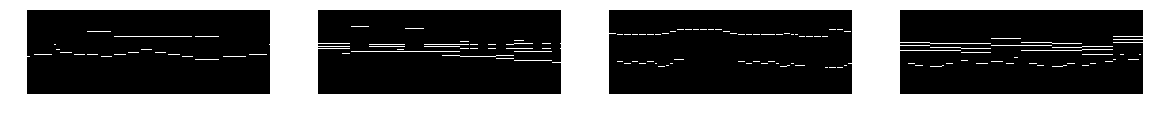

(4, 32, 32, 3)


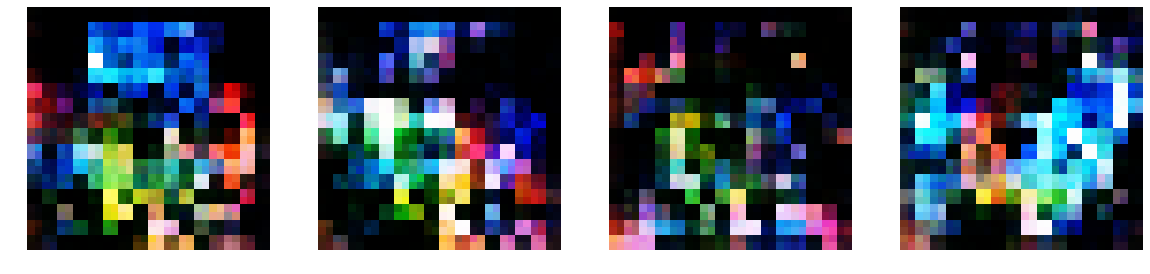

(4, 88, 256, 1)


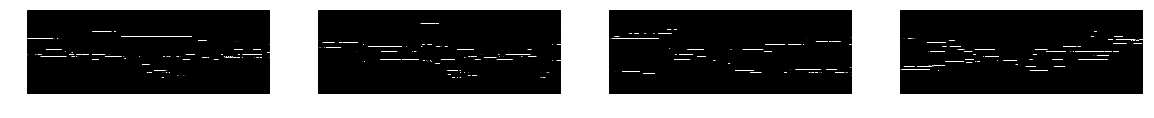

(4, 32, 32, 3)


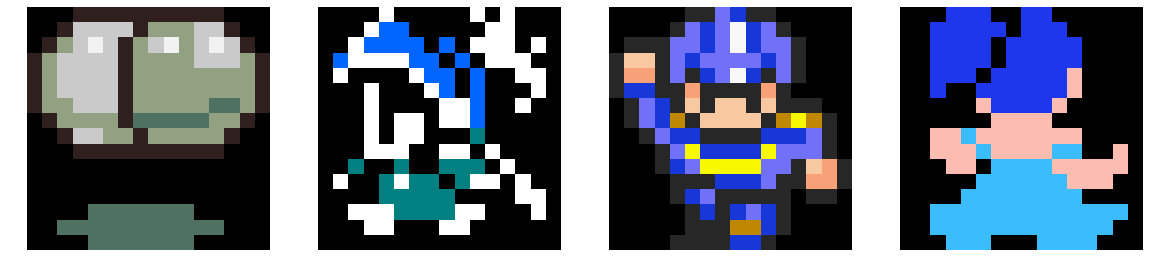

(4, 88, 256, 1)


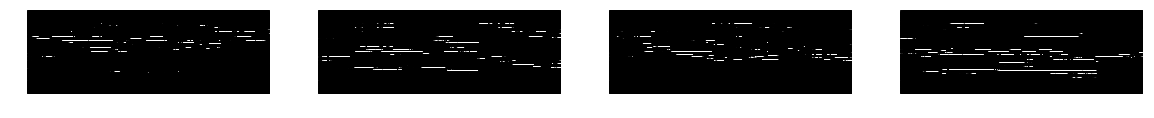

(4, 32, 32, 3)


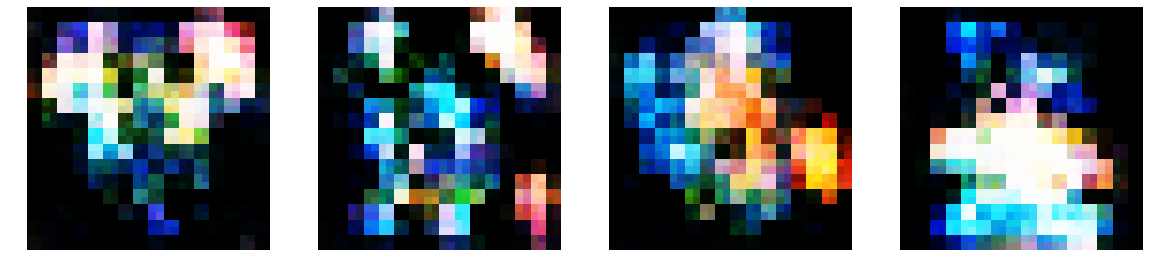

[25/100][8700] Loss_D: 0.052036 0.103170 Loss_G: 0.932877 0.895495 loss_cyc 0.485113 84.528
[25/100][8725] Loss_D: 0.051636 0.082166 Loss_G: 0.889626 0.928310 loss_cyc 0.447894 84.760
[25/100][8750] Loss_D: 0.043142 0.081235 Loss_G: 0.940199 0.936935 loss_cyc 0.455254 85.010
[25/100][8775] Loss_D: 0.040744 0.064207 Loss_G: 0.922813 0.904542 loss_cyc 0.468669 85.250
[25/100][8800] Loss_D: 0.044848 0.087870 Loss_G: 0.937066 0.851199 loss_cyc 0.441136 85.485
[25/100][8825] Loss_D: 0.061182 0.046277 Loss_G: 0.824404 1.015348 loss_cyc 0.448471 85.724
[25/100][8850] Loss_D: 0.062984 0.085203 Loss_G: 0.860942 0.987837 loss_cyc 0.438311 85.964
[25/100][8875] Loss_D: 0.049016 0.043570 Loss_G: 0.888537 0.867630 loss_cyc 0.442124 86.205
[25/100][8900] Loss_D: 0.038136 0.052191 Loss_G: 0.913756 0.920320 loss_cyc 0.448535 86.442
[25/100][8925] Loss_D: 0.040484 0.064362 Loss_G: 0.861843 0.931534 loss_cyc 0.462633 86.685
[25/100][8950] Loss_D: 0.065301 0.082123 Loss_G: 0.923689 0.990111 loss_cyc 0.46

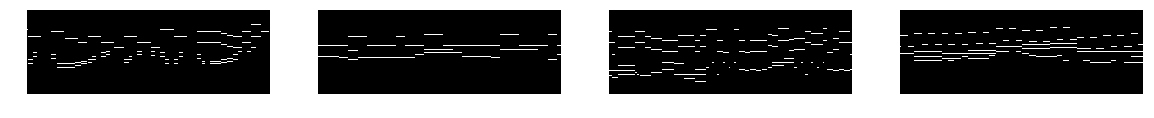

(4, 32, 32, 3)


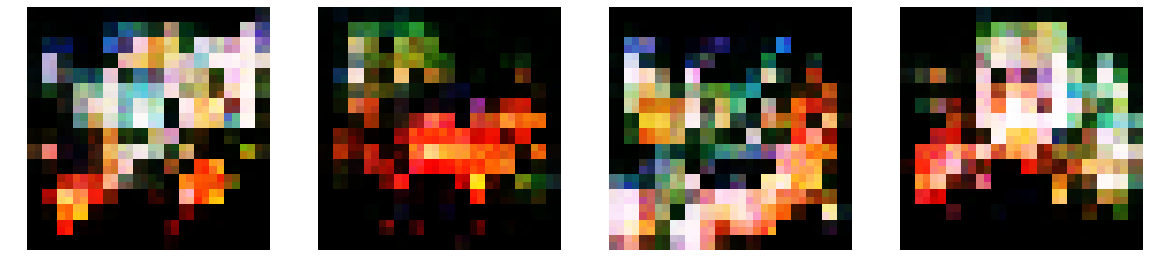

(4, 88, 256, 1)


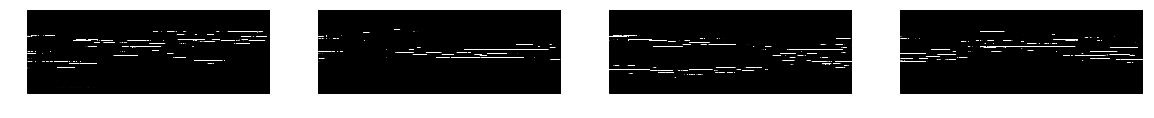

(4, 32, 32, 3)


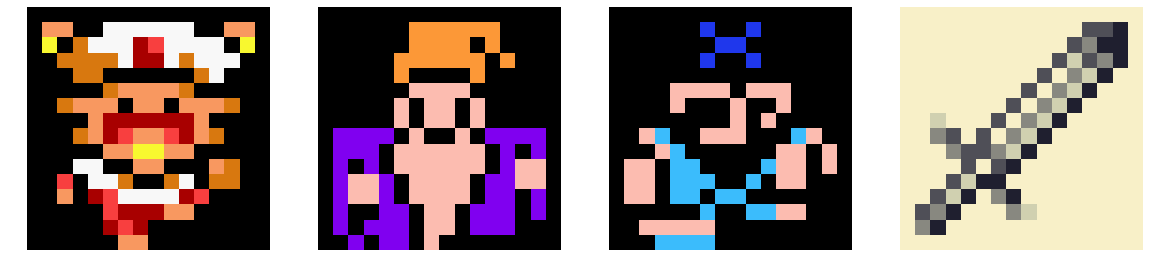

(4, 88, 256, 1)


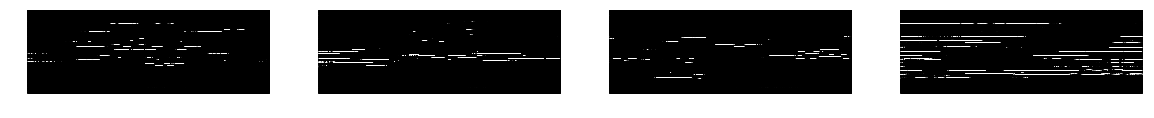

(4, 32, 32, 3)


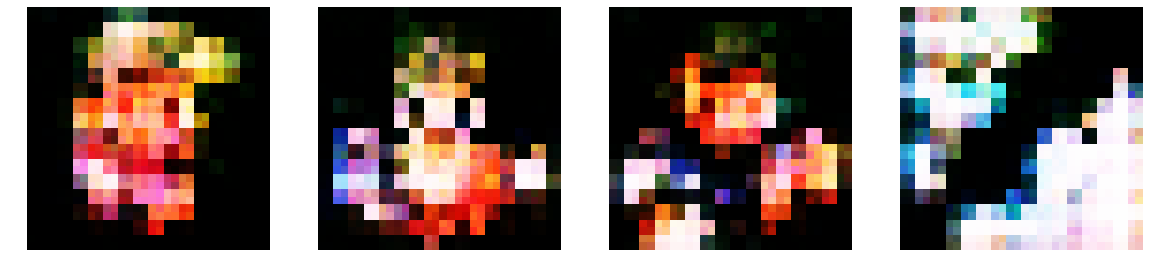

[26/100][9050] Loss_D: 0.042118 0.073247 Loss_G: 0.885896 0.954032 loss_cyc 0.460219 87.922
[26/100][9075] Loss_D: 0.053275 0.072866 Loss_G: 0.839919 1.034527 loss_cyc 0.479012 88.161
[26/100][9100] Loss_D: 0.048083 0.099686 Loss_G: 0.905417 0.840922 loss_cyc 0.474018 88.394
[26/100][9125] Loss_D: 0.046262 0.078368 Loss_G: 0.884034 0.984574 loss_cyc 0.451953 88.628
[26/100][9150] Loss_D: 0.052210 0.058853 Loss_G: 0.869182 0.976967 loss_cyc 0.464168 88.867
[26/100][9175] Loss_D: 0.048855 0.067262 Loss_G: 0.866241 0.818371 loss_cyc 0.430437 89.097
[26/100][9200] Loss_D: 0.081682 0.077741 Loss_G: 0.876728 0.930653 loss_cyc 0.469971 89.339
[26/100][9225] Loss_D: 0.058120 0.074998 Loss_G: 0.800638 0.910590 loss_cyc 0.469754 89.575
[26/100][9250] Loss_D: 0.060543 0.061511 Loss_G: 0.845621 0.794920 loss_cyc 0.475677 89.805
[26/100][9275] Loss_D: 0.057624 0.062927 Loss_G: 0.888248 0.952209 loss_cyc 0.466101 90.043
[26/100][9300] Loss_D: 0.040843 0.084379 Loss_G: 0.923697 0.895079 loss_cyc 0.48

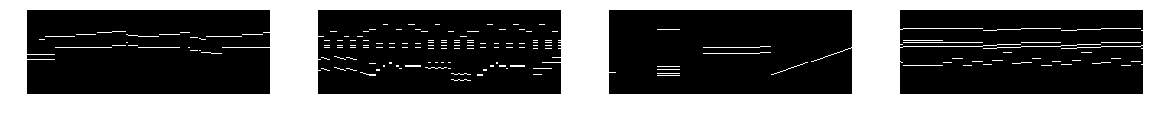

(4, 32, 32, 3)


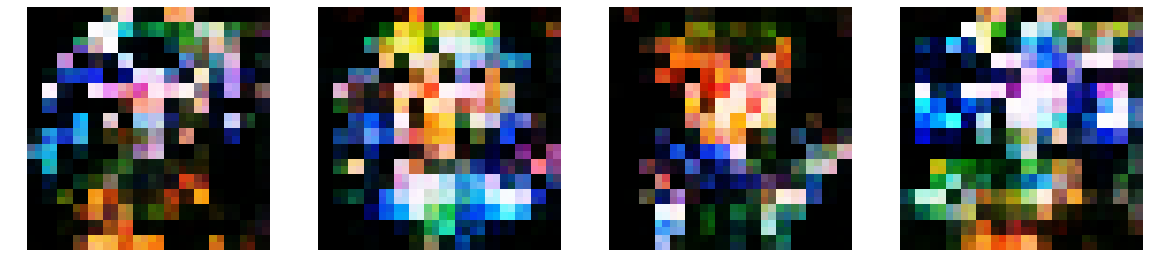

(4, 88, 256, 1)


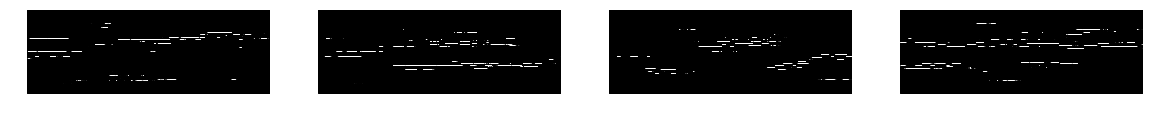

(4, 32, 32, 3)


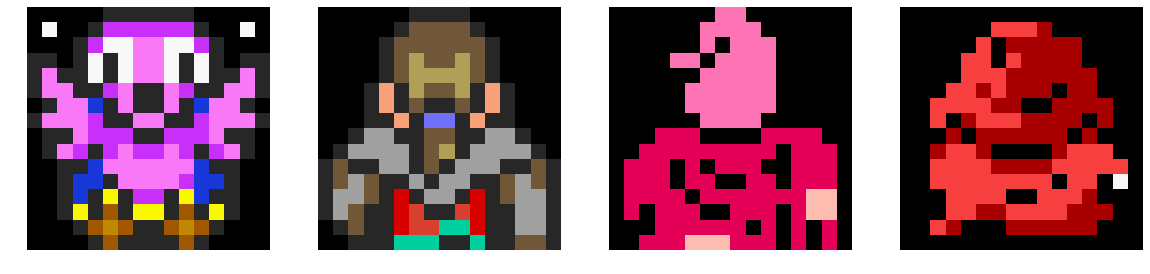

(4, 88, 256, 1)


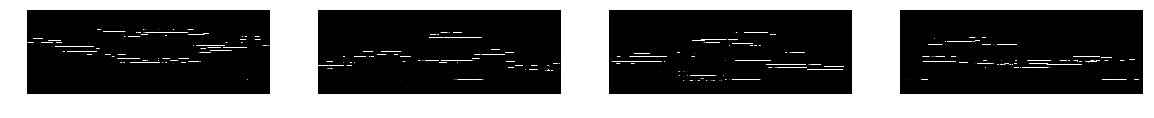

(4, 32, 32, 3)


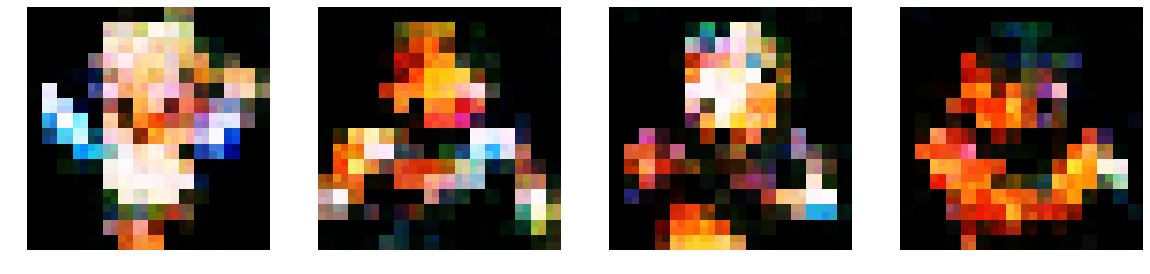

[27/100][9375] Loss_D: 0.045035 0.084436 Loss_G: 0.899302 1.008035 loss_cyc 0.475196 91.060
[27/100][9400] Loss_D: 0.055820 0.070878 Loss_G: 0.921463 0.907633 loss_cyc 0.484561 91.293
[27/100][9425] Loss_D: 0.045816 0.070214 Loss_G: 0.882611 0.964772 loss_cyc 0.458549 91.533
[27/100][9450] Loss_D: 0.048174 0.082833 Loss_G: 0.907543 0.936903 loss_cyc 0.472000 91.769
[27/100][9475] Loss_D: 0.036280 0.047060 Loss_G: 0.884474 0.919880 loss_cyc 0.465909 92.015
[27/100][9500] Loss_D: 0.036398 0.077291 Loss_G: 0.862303 1.006647 loss_cyc 0.496140 92.255
[27/100][9525] Loss_D: 0.046449 0.047226 Loss_G: 0.897763 0.941497 loss_cyc 0.495957 92.499
[27/100][9550] Loss_D: 0.092322 0.067184 Loss_G: 0.808467 0.878648 loss_cyc 0.448149 92.737
[27/100][9575] Loss_D: 0.045202 0.064469 Loss_G: 0.849930 0.901595 loss_cyc 0.441730 92.974
[27/100][9600] Loss_D: 0.063995 0.076893 Loss_G: 0.862216 0.977706 loss_cyc 0.460135 93.210
[27/100][9625] Loss_D: 0.078527 0.056767 Loss_G: 0.908421 0.993091 loss_cyc 0.44

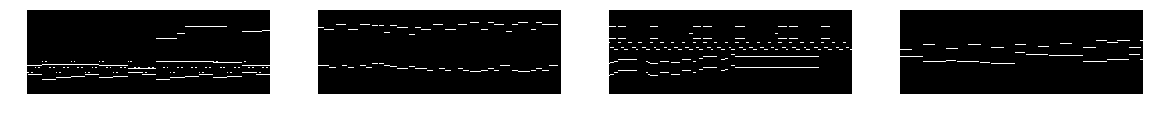

(4, 32, 32, 3)


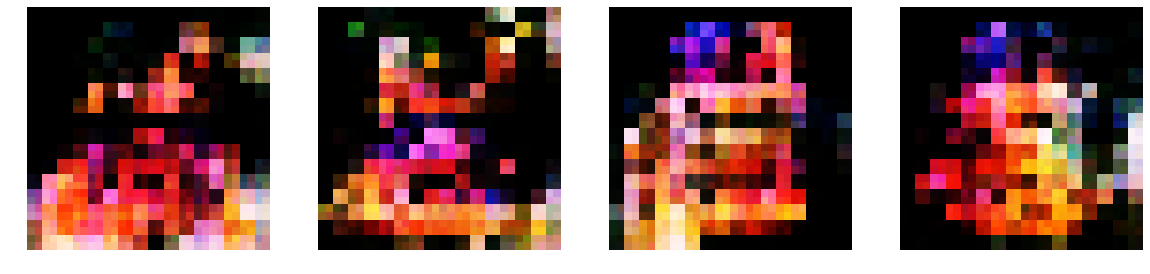

(4, 88, 256, 1)


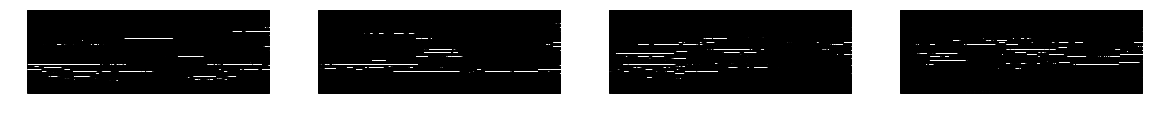

(4, 32, 32, 3)


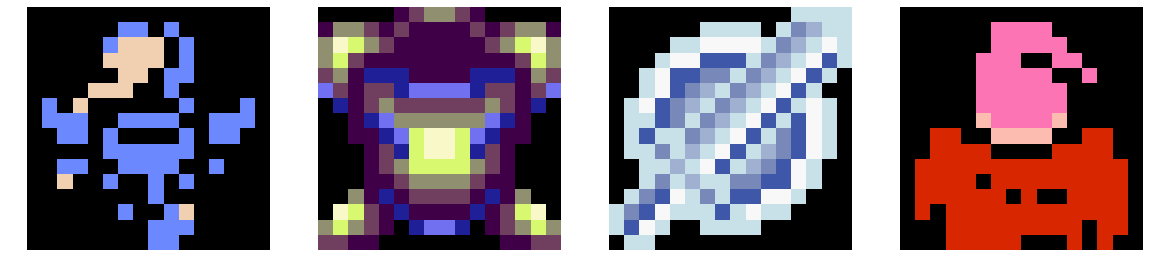

(4, 88, 256, 1)


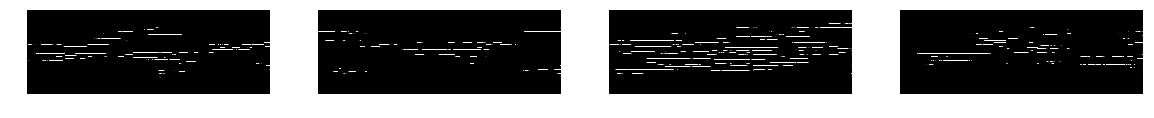

(4, 32, 32, 3)


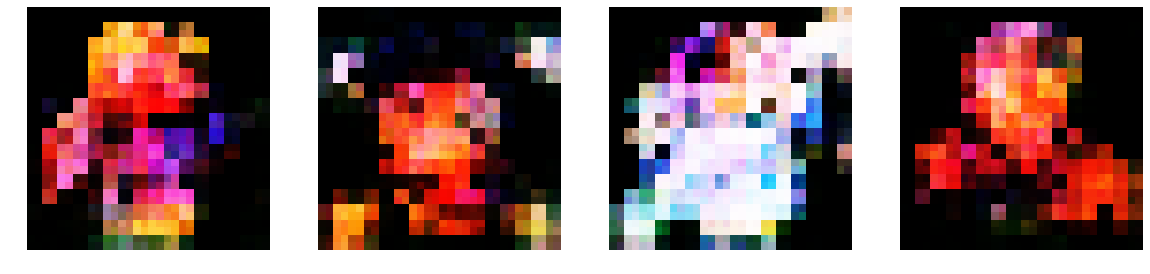

[28/100][9725] Loss_D: 0.059233 0.050497 Loss_G: 0.900471 0.974669 loss_cyc 0.470678 94.442
[28/100][9750] Loss_D: 0.073504 0.083190 Loss_G: 0.844872 1.005771 loss_cyc 0.482330 94.676
[28/100][9775] Loss_D: 0.052771 0.051276 Loss_G: 0.879809 0.969249 loss_cyc 0.458382 94.907
[28/100][9800] Loss_D: 0.050070 0.078098 Loss_G: 0.880917 0.946184 loss_cyc 0.461752 95.156
[28/100][9825] Loss_D: 0.062896 0.045212 Loss_G: 0.836224 0.996467 loss_cyc 0.449707 95.388
[28/100][9850] Loss_D: 0.054215 0.049400 Loss_G: 0.786515 0.937999 loss_cyc 0.466041 95.620
[28/100][9875] Loss_D: 0.071871 0.049150 Loss_G: 0.868507 1.011361 loss_cyc 0.501639 95.857
[28/100][9900] Loss_D: 0.085577 0.069131 Loss_G: 0.880770 0.902344 loss_cyc 0.497142 96.094
[28/100][9925] Loss_D: 0.058916 0.079827 Loss_G: 0.804151 1.045260 loss_cyc 0.518714 96.328
[28/100][9950] Loss_D: 0.055032 0.084109 Loss_G: 0.898739 0.910194 loss_cyc 0.515669 96.563
[28/100][9975] Loss_D: 0.072133 0.079606 Loss_G: 0.833866 0.924500 loss_cyc 0.47

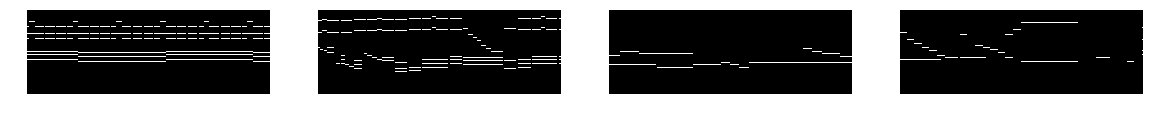

(4, 32, 32, 3)


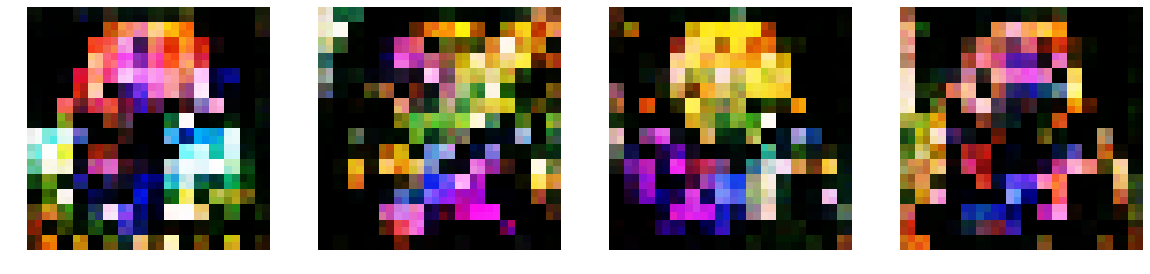

(4, 88, 256, 1)


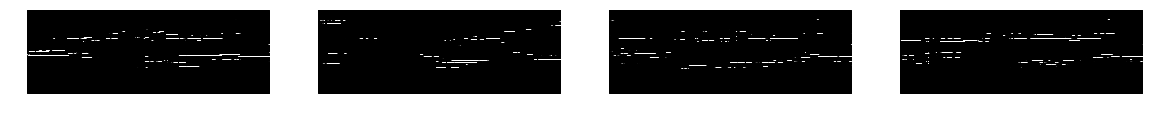

(4, 32, 32, 3)


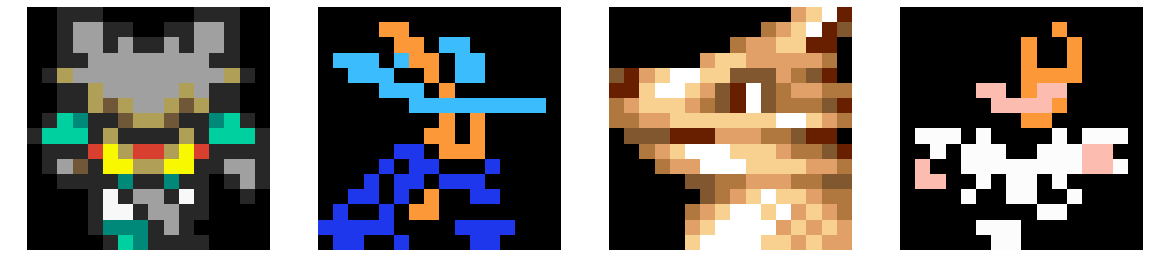

(4, 88, 256, 1)


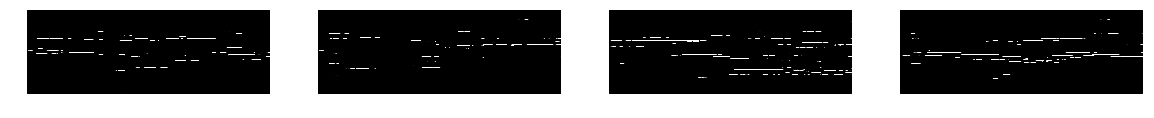

(4, 32, 32, 3)


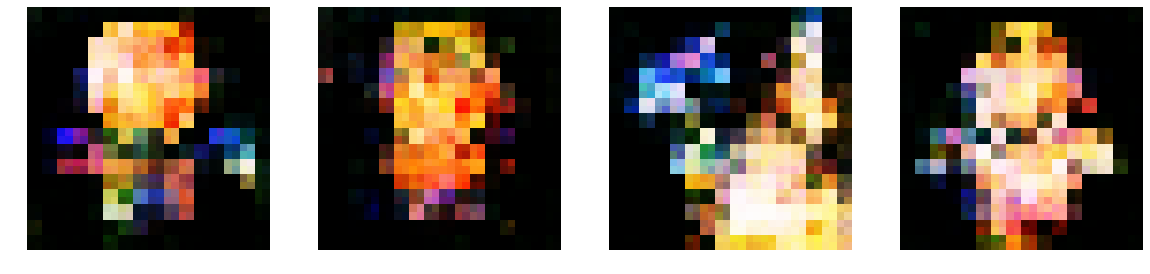

[29/100][10075] Loss_D: 0.043428 0.075474 Loss_G: 0.959586 0.986063 loss_cyc 0.513003 97.812
[29/100][10100] Loss_D: 0.038639 0.072384 Loss_G: 0.904497 0.949610 loss_cyc 0.478436 98.052
[29/100][10125] Loss_D: 0.051381 0.073450 Loss_G: 0.880866 0.893879 loss_cyc 0.469014 98.291
[29/100][10150] Loss_D: 0.041352 0.083211 Loss_G: 0.878903 0.968482 loss_cyc 0.470577 98.519
[29/100][10175] Loss_D: 0.035726 0.066624 Loss_G: 0.918848 0.851400 loss_cyc 0.461555 98.756
[29/100][10200] Loss_D: 0.046358 0.067312 Loss_G: 0.902960 1.003236 loss_cyc 0.483213 98.996
[29/100][10225] Loss_D: 0.042513 0.068799 Loss_G: 0.881451 1.010954 loss_cyc 0.454265 99.231
[29/100][10250] Loss_D: 0.062420 0.077130 Loss_G: 0.860961 0.912570 loss_cyc 0.485715 99.472
[29/100][10275] Loss_D: 0.041820 0.083652 Loss_G: 0.871203 0.942150 loss_cyc 0.503957 99.707
[29/100][10300] Loss_D: 0.028976 0.069435 Loss_G: 0.888135 1.020824 loss_cyc 0.479024 99.948
[29/100][10325] Loss_D: 0.049592 0.059883 Loss_G: 0.889938 1.078778 lo

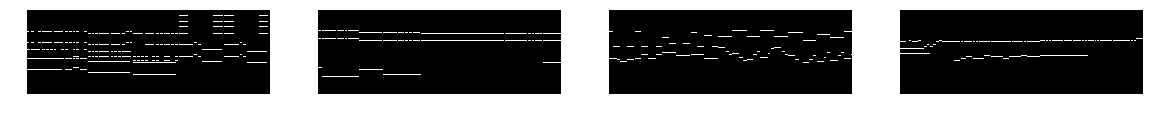

(4, 32, 32, 3)


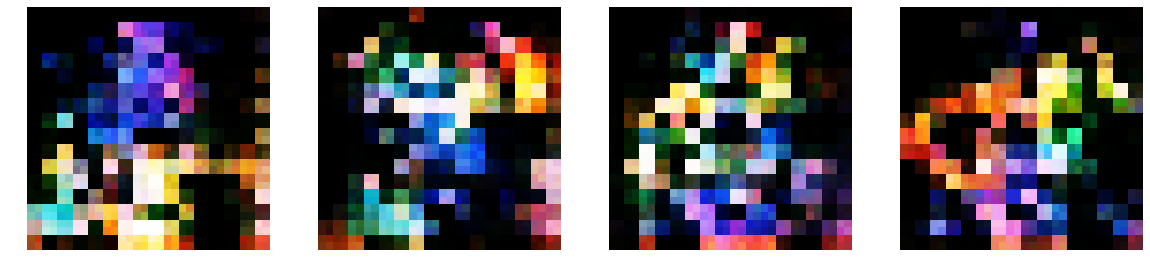

(4, 88, 256, 1)


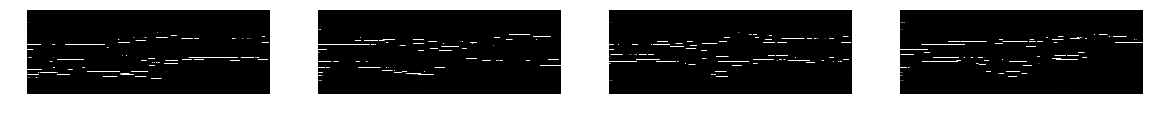

(4, 32, 32, 3)


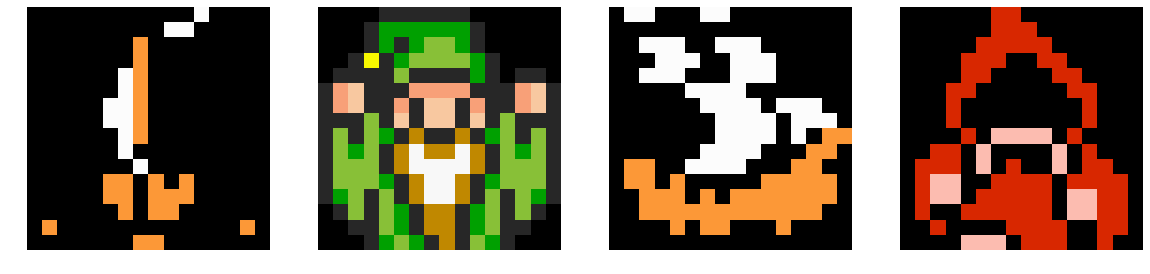

(4, 88, 256, 1)


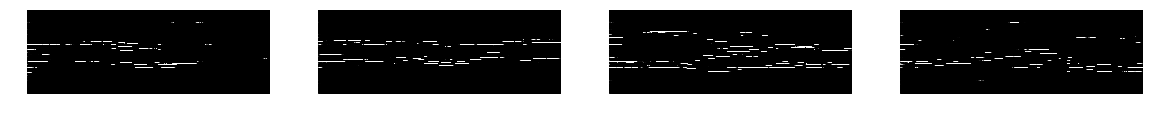

(4, 32, 32, 3)


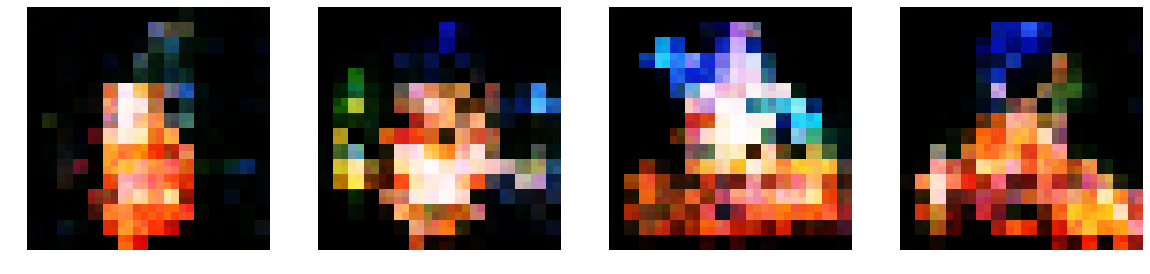

[30/100][10425] Loss_D: 0.067228 0.049507 Loss_G: 0.848231 1.012223 loss_cyc 0.455424 101.201
[30/100][10450] Loss_D: 0.052495 0.065984 Loss_G: 0.903093 1.001235 loss_cyc 0.438516 101.435
[30/100][10475] Loss_D: 0.040265 0.058740 Loss_G: 0.892616 0.928779 loss_cyc 0.438005 101.671
[30/100][10500] Loss_D: 0.054248 0.079748 Loss_G: 0.873422 0.909489 loss_cyc 0.470212 101.910
[30/100][10525] Loss_D: 0.044396 0.043662 Loss_G: 0.886661 0.957226 loss_cyc 0.460470 102.146
[30/100][10550] Loss_D: 0.035890 0.087663 Loss_G: 0.884718 1.024958 loss_cyc 0.466621 102.374
[30/100][10575] Loss_D: 0.040301 0.070123 Loss_G: 0.966943 0.905636 loss_cyc 0.453365 102.612
[30/100][10600] Loss_D: 0.042877 0.071757 Loss_G: 0.926331 0.919737 loss_cyc 0.447041 102.840
[30/100][10625] Loss_D: 0.057581 0.077084 Loss_G: 0.854759 0.903375 loss_cyc 0.456456 103.068
[30/100][10650] Loss_D: 0.049029 0.072608 Loss_G: 0.910349 0.973864 loss_cyc 0.459209 103.314
[30/100][10675] Loss_D: 0.042025 0.068498 Loss_G: 0.899905 0

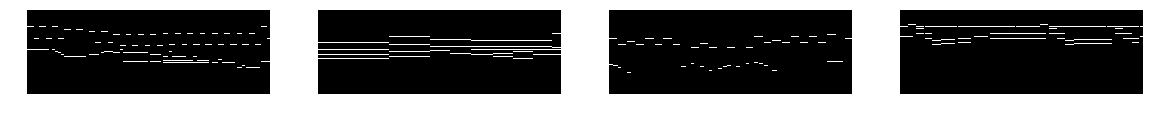

(4, 32, 32, 3)


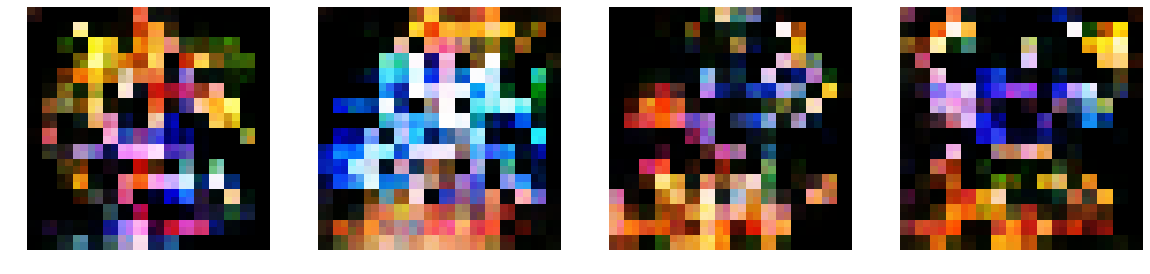

(4, 88, 256, 1)


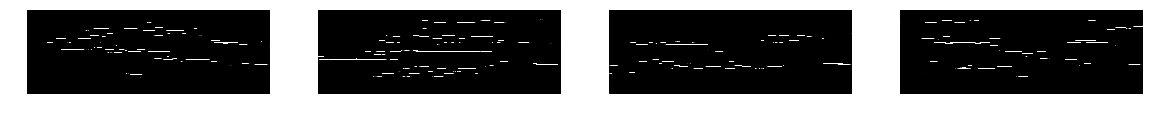

(4, 32, 32, 3)


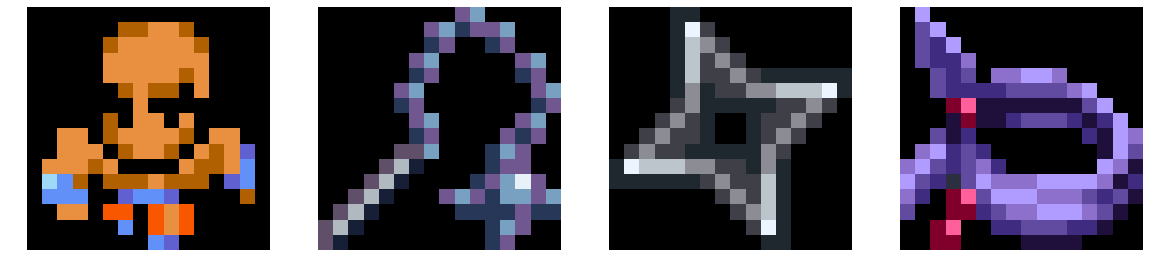

(4, 88, 256, 1)


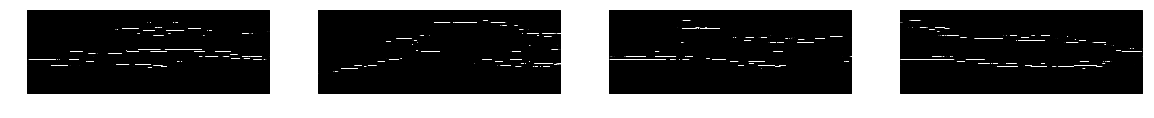

(4, 32, 32, 3)


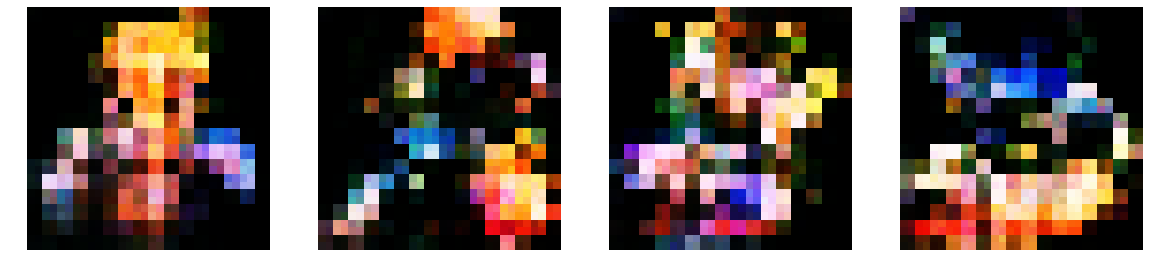

[31/100][10775] Loss_D: 0.040944 0.040504 Loss_G: 0.928720 0.985276 loss_cyc 0.460966 104.542
[31/100][10800] Loss_D: 0.039604 0.045992 Loss_G: 0.910079 0.936881 loss_cyc 0.450042 104.766
[31/100][10825] Loss_D: 0.039391 0.057080 Loss_G: 0.940403 1.033253 loss_cyc 0.438921 104.999
[31/100][10850] Loss_D: 0.057108 0.076783 Loss_G: 0.910254 0.917201 loss_cyc 0.489672 105.236
[31/100][10875] Loss_D: 0.059860 0.080092 Loss_G: 0.840885 0.914810 loss_cyc 0.453775 105.461
[31/100][10900] Loss_D: 0.048298 0.052583 Loss_G: 0.878639 0.913310 loss_cyc 0.433416 105.699
[31/100][10925] Loss_D: 0.062965 0.058810 Loss_G: 0.878454 0.992903 loss_cyc 0.474469 105.933
[31/100][10950] Loss_D: 0.063018 0.098409 Loss_G: 0.912153 0.973079 loss_cyc 0.494509 106.163
[31/100][10975] Loss_D: 0.059671 0.059145 Loss_G: 0.824186 1.039859 loss_cyc 0.492499 106.398
[31/100][11000] Loss_D: 0.056851 0.056770 Loss_G: 0.893380 0.936624 loss_cyc 0.472146 106.634
[31/100][11025] Loss_D: 0.065540 0.052111 Loss_G: 0.900552 0

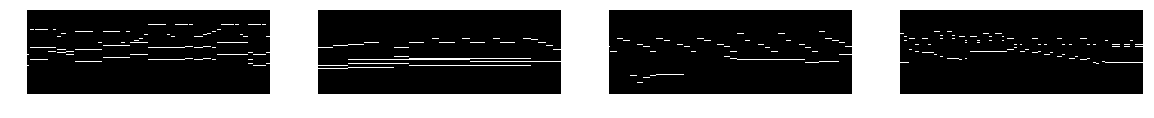

(4, 32, 32, 3)


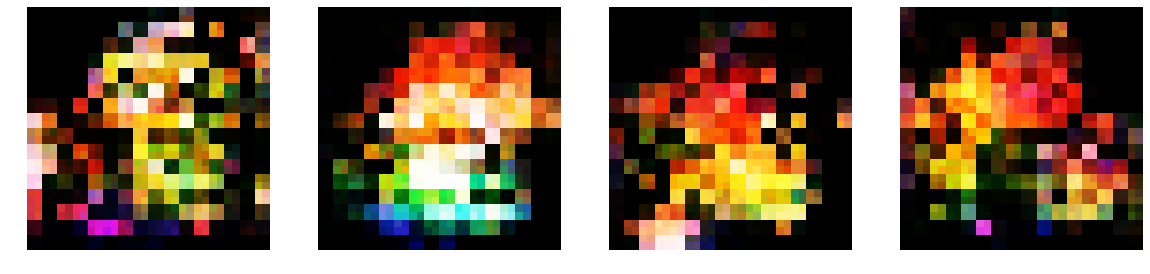

(4, 88, 256, 1)


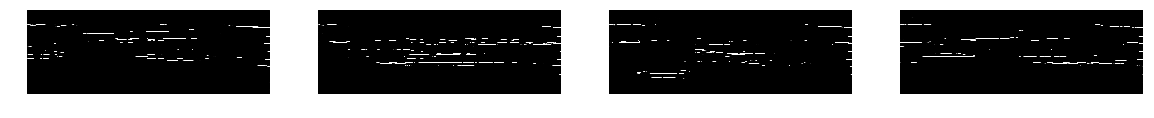

(4, 32, 32, 3)


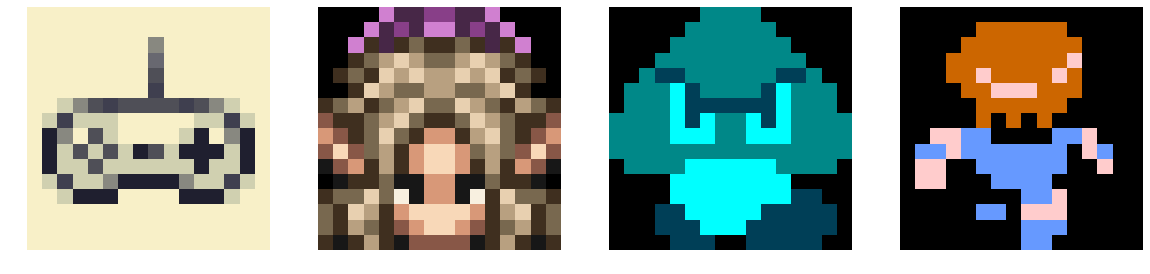

(4, 88, 256, 1)


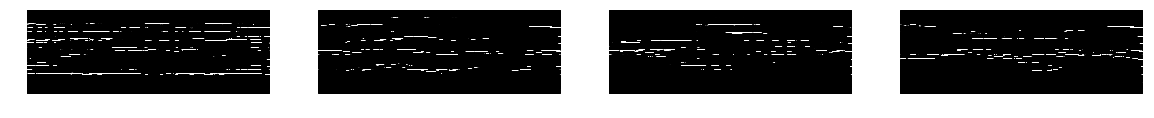

(4, 32, 32, 3)


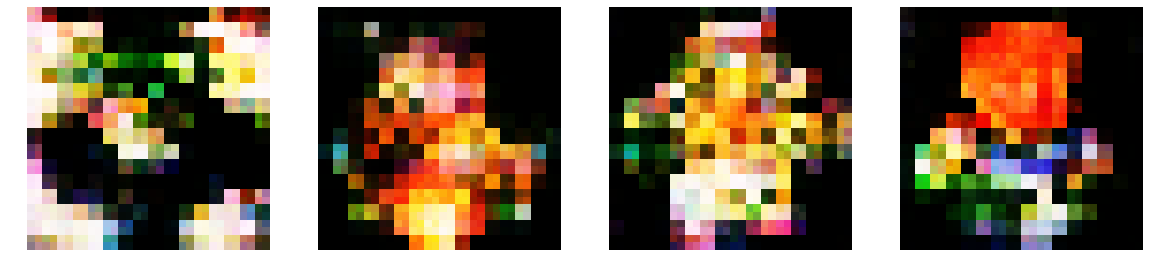

[32/100][11125] Loss_D: 0.045863 0.088840 Loss_G: 0.862859 0.987361 loss_cyc 0.491034 107.886
[32/100][11150] Loss_D: 0.054429 0.088030 Loss_G: 0.875986 0.872058 loss_cyc 0.488318 108.123
[32/100][11175] Loss_D: 0.036729 0.080319 Loss_G: 0.882451 0.935289 loss_cyc 0.457611 108.361
[32/100][11200] Loss_D: 0.027773 0.066162 Loss_G: 0.928311 0.956857 loss_cyc 0.473694 108.590
[32/100][11225] Loss_D: 0.045076 0.043372 Loss_G: 0.899960 1.031127 loss_cyc 0.462483 108.821
[32/100][11250] Loss_D: 0.069299 0.066674 Loss_G: 0.906900 0.870479 loss_cyc 0.474917 109.061
[32/100][11275] Loss_D: 0.046646 0.041919 Loss_G: 0.852077 0.934746 loss_cyc 0.490579 109.308
[32/100][11300] Loss_D: 0.048412 0.044775 Loss_G: 0.848938 0.944638 loss_cyc 0.421310 109.553
[32/100][11325] Loss_D: 0.073191 0.054509 Loss_G: 0.887447 0.895244 loss_cyc 0.471867 109.791
[32/100][11350] Loss_D: 0.055001 0.047329 Loss_G: 0.859751 0.868295 loss_cyc 0.471728 110.023
[32/100][11375] Loss_D: 0.072968 0.069793 Loss_G: 0.834055 0

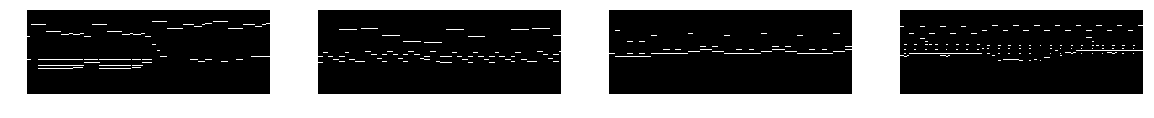

(4, 32, 32, 3)


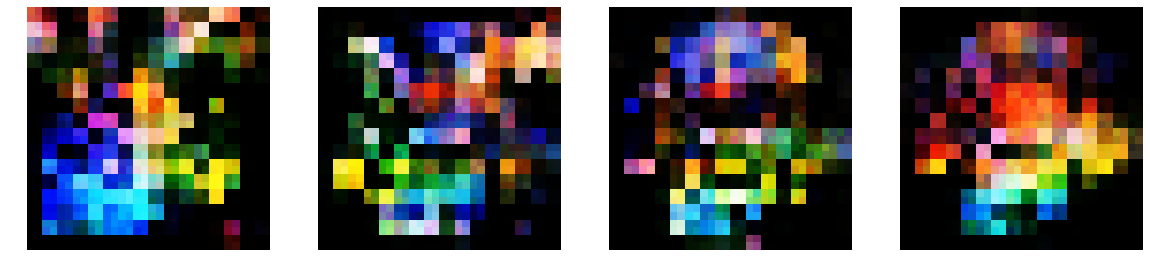

(4, 88, 256, 1)


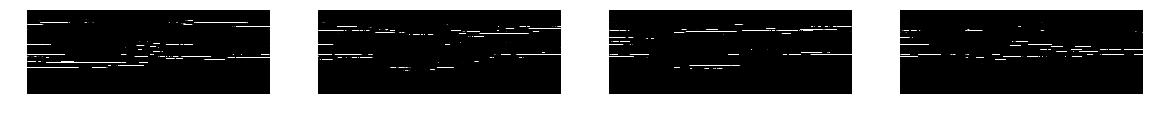

(4, 32, 32, 3)


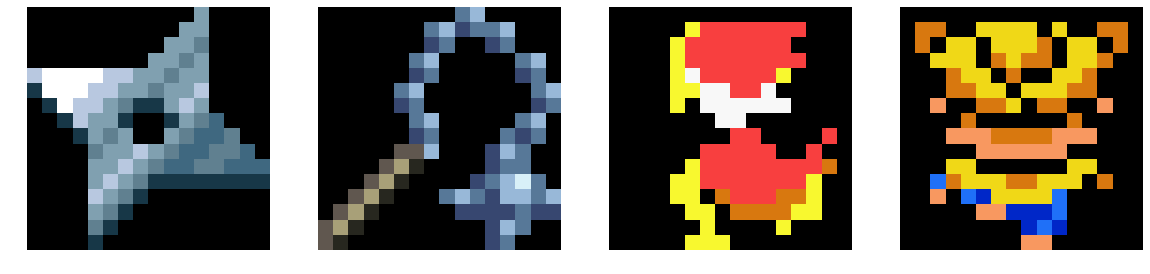

(4, 88, 256, 1)


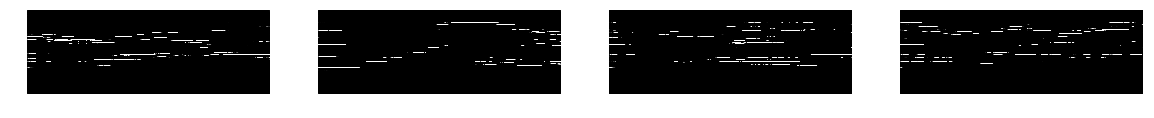

(4, 32, 32, 3)


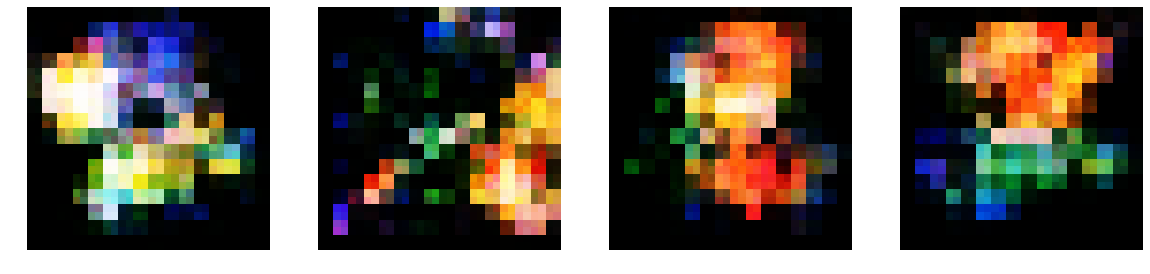

[33/100][11475] Loss_D: 0.085747 0.056996 Loss_G: 0.787707 0.963183 loss_cyc 0.444364 111.291
[33/100][11500] Loss_D: 0.066203 0.073810 Loss_G: 0.797760 0.954794 loss_cyc 0.441906 111.527
[33/100][11525] Loss_D: 0.067298 0.100821 Loss_G: 0.842424 1.017120 loss_cyc 0.427095 111.761
[33/100][11550] Loss_D: 0.063422 0.050843 Loss_G: 0.804672 1.017199 loss_cyc 0.446663 111.991
[33/100][11575] Loss_D: 0.069087 0.056644 Loss_G: 0.847392 0.985393 loss_cyc 0.483444 112.223
[33/100][11600] Loss_D: 0.092174 0.048610 Loss_G: 0.839245 0.922443 loss_cyc 0.451464 112.447
[33/100][11625] Loss_D: 0.077551 0.069458 Loss_G: 0.796962 0.942523 loss_cyc 0.476540 112.683
[33/100][11650] Loss_D: 0.051156 0.057883 Loss_G: 0.862363 0.951364 loss_cyc 0.457126 112.932
[33/100][11675] Loss_D: 0.044924 0.067597 Loss_G: 0.937855 0.925302 loss_cyc 0.418117 113.162
[33/100][11700] Loss_D: 0.060803 0.049057 Loss_G: 0.817634 0.939476 loss_cyc 0.468355 113.403
[33/100][11725] Loss_D: 0.064216 0.086462 Loss_G: 0.886957 0

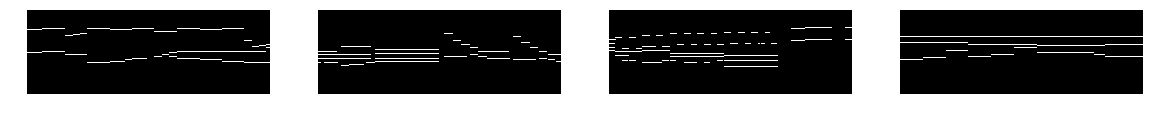

(4, 32, 32, 3)


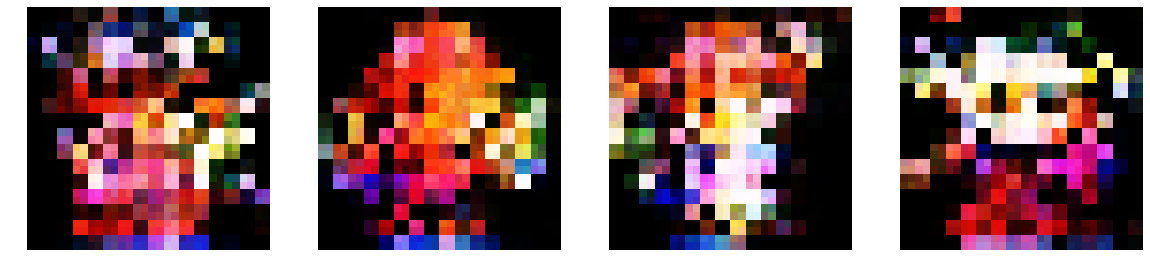

(4, 88, 256, 1)


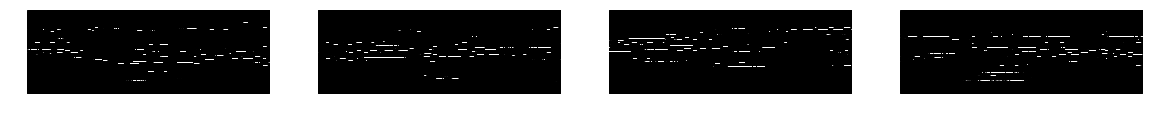

(4, 32, 32, 3)


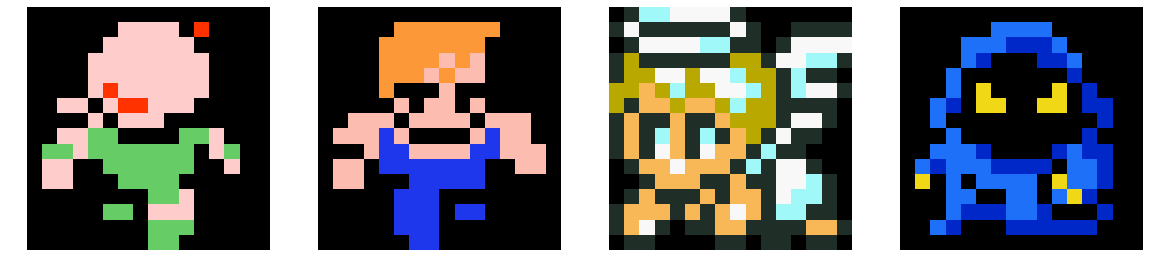

(4, 88, 256, 1)


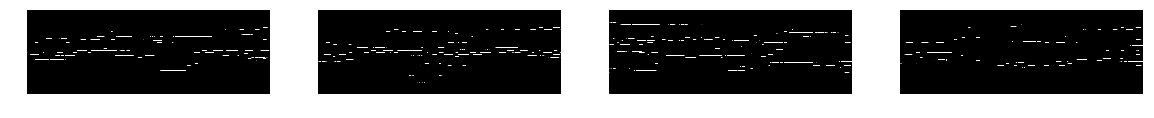

(4, 32, 32, 3)


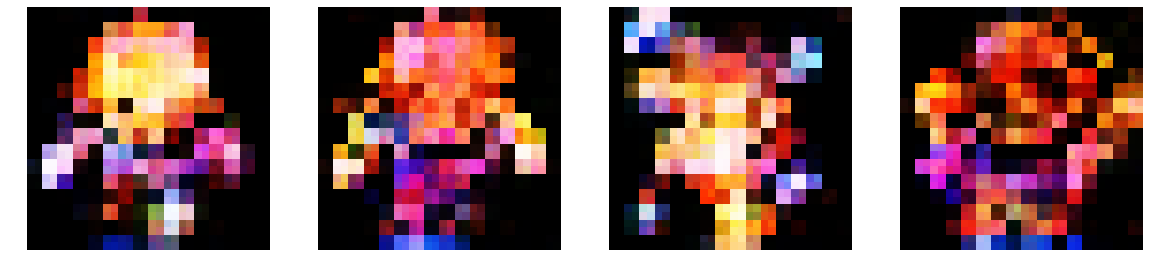

[34/100][11825] Loss_D: 0.057293 0.080613 Loss_G: 0.855051 0.997699 loss_cyc 0.466606 114.650
[34/100][11850] Loss_D: 0.041845 0.058920 Loss_G: 0.908979 0.943957 loss_cyc 0.455506 114.884
[34/100][11875] Loss_D: 0.050590 0.043275 Loss_G: 0.934842 1.048193 loss_cyc 0.459928 115.128
[34/100][11900] Loss_D: 0.054145 0.055537 Loss_G: 0.863443 0.925898 loss_cyc 0.440591 115.368
[34/100][11925] Loss_D: 0.055815 0.099490 Loss_G: 0.843816 0.988740 loss_cyc 0.433917 115.595
[34/100][11950] Loss_D: 0.054703 0.067636 Loss_G: 0.848086 1.010394 loss_cyc 0.439239 115.836
[34/100][11975] Loss_D: 0.051191 0.055340 Loss_G: 0.881134 0.891437 loss_cyc 0.431966 116.064
[34/100][12000] Loss_D: 0.056787 0.036819 Loss_G: 0.875246 0.918886 loss_cyc 0.446503 116.298
[34/100][12025] Loss_D: 0.074550 0.074323 Loss_G: 0.810152 1.021694 loss_cyc 0.462727 116.530
[34/100][12050] Loss_D: 0.049835 0.054302 Loss_G: 0.873488 0.872824 loss_cyc 0.435092 116.776
[34/100][12075] Loss_D: 0.065279 0.065061 Loss_G: 0.841063 0

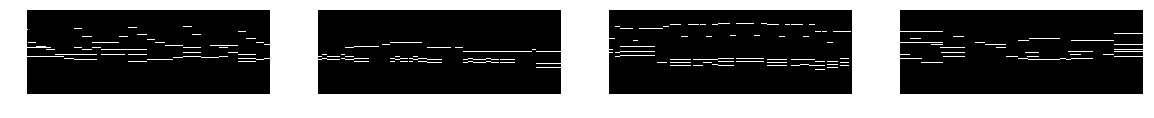

(4, 32, 32, 3)


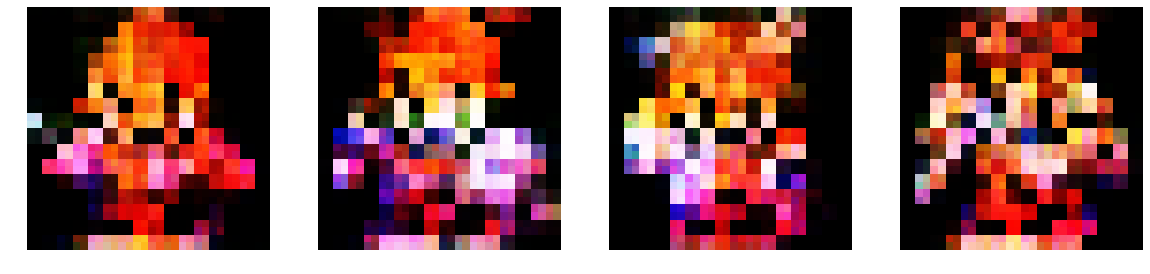

(4, 88, 256, 1)


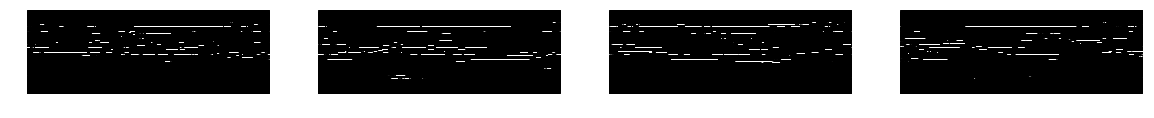

(4, 32, 32, 3)


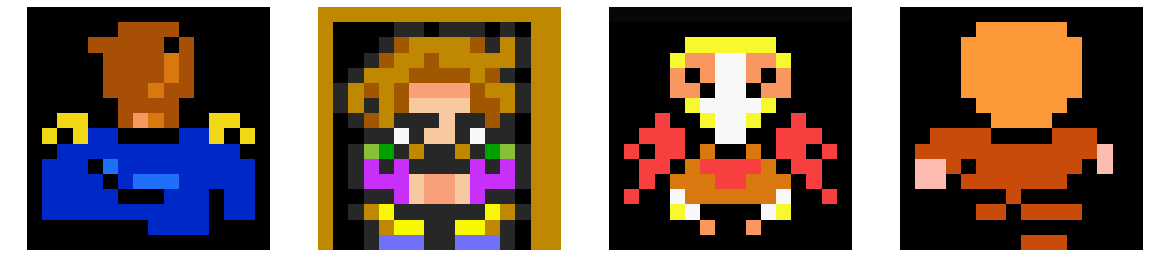

(4, 88, 256, 1)


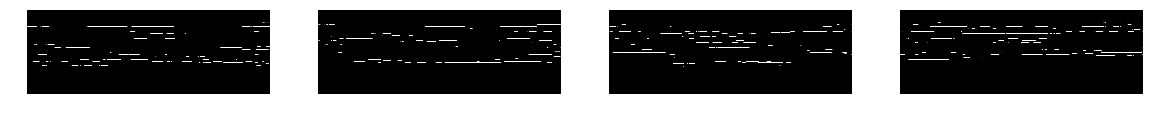

(4, 32, 32, 3)


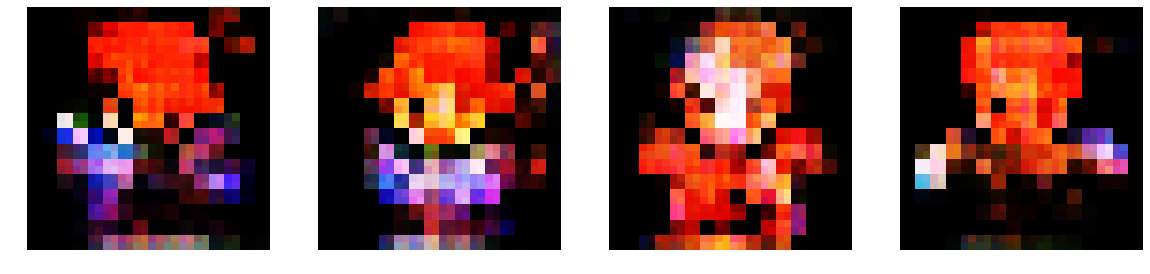

[35/100][12150] Loss_D: 0.038923 0.056193 Loss_G: 0.913352 1.012006 loss_cyc 0.466239 117.777
[35/100][12175] Loss_D: 0.050536 0.047775 Loss_G: 0.857694 1.038820 loss_cyc 0.444458 118.016
[35/100][12200] Loss_D: 0.071177 0.049312 Loss_G: 0.836216 0.943421 loss_cyc 0.471289 118.260
[35/100][12225] Loss_D: 0.037970 0.043467 Loss_G: 0.836251 0.906800 loss_cyc 0.466752 118.495
[35/100][12250] Loss_D: 0.060849 0.033634 Loss_G: 0.886719 0.959162 loss_cyc 0.447945 118.738
[35/100][12275] Loss_D: 0.039120 0.051461 Loss_G: 0.868164 1.038237 loss_cyc 0.446922 118.968
[35/100][12300] Loss_D: 0.052934 0.066076 Loss_G: 0.889569 1.036001 loss_cyc 0.448819 119.201
[35/100][12325] Loss_D: 0.037597 0.045403 Loss_G: 0.898953 0.948965 loss_cyc 0.457206 119.444
[35/100][12350] Loss_D: 0.056423 0.062001 Loss_G: 0.873533 0.993451 loss_cyc 0.466856 119.675
[35/100][12375] Loss_D: 0.052810 0.092011 Loss_G: 0.926596 0.932506 loss_cyc 0.458606 119.919
[35/100][12400] Loss_D: 0.047440 0.062379 Loss_G: 0.913059 1

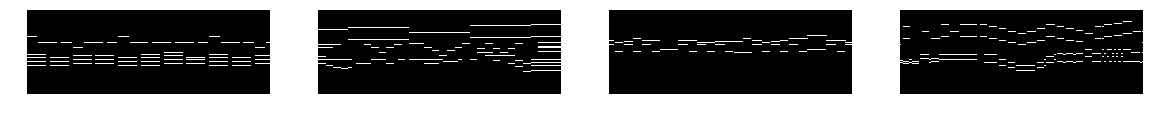

(4, 32, 32, 3)


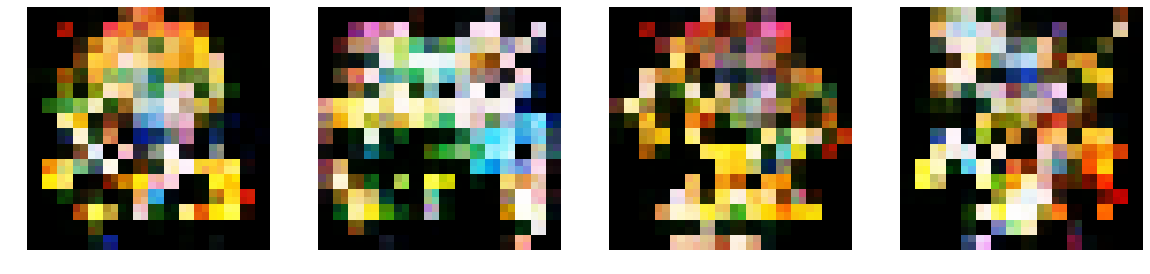

(4, 88, 256, 1)


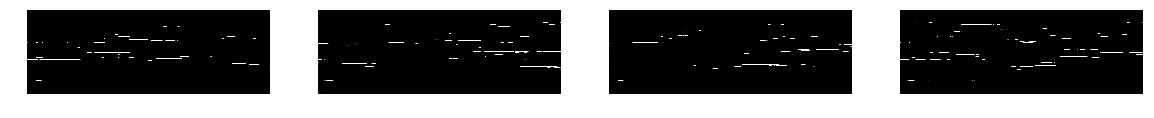

(4, 32, 32, 3)


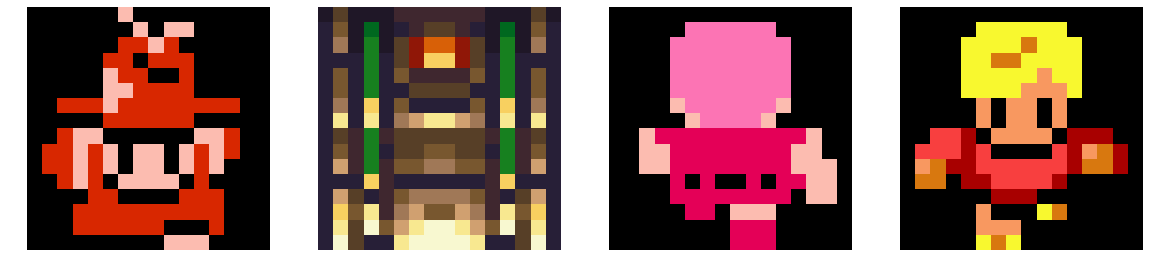

(4, 88, 256, 1)


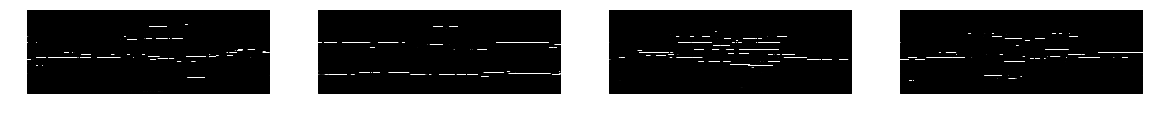

(4, 32, 32, 3)


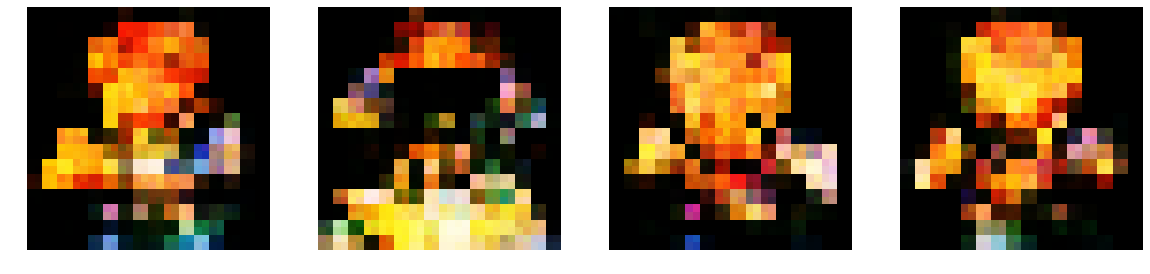

[36/100][12500] Loss_D: 0.039454 0.058889 Loss_G: 0.917799 0.988714 loss_cyc 0.466927 121.152
[36/100][12525] Loss_D: 0.047660 0.040592 Loss_G: 0.906437 0.954602 loss_cyc 0.462020 121.383
[36/100][12550] Loss_D: 0.039322 0.045308 Loss_G: 0.885267 1.067712 loss_cyc 0.452315 121.618
[36/100][12575] Loss_D: 0.070626 0.045363 Loss_G: 0.879755 1.015321 loss_cyc 0.466440 121.857
[36/100][12600] Loss_D: 0.048198 0.070937 Loss_G: 0.893559 0.917972 loss_cyc 0.480202 122.099
[36/100][12625] Loss_D: 0.032866 0.050083 Loss_G: 0.912255 0.955329 loss_cyc 0.476382 122.330
[36/100][12650] Loss_D: 0.063009 0.039116 Loss_G: 0.842746 1.039452 loss_cyc 0.457902 122.575
[36/100][12675] Loss_D: 0.051497 0.046636 Loss_G: 0.911154 0.945800 loss_cyc 0.443616 122.810
[36/100][12700] Loss_D: 0.059220 0.078929 Loss_G: 0.848258 1.039358 loss_cyc 0.434625 123.036
[36/100][12725] Loss_D: 0.045192 0.056326 Loss_G: 0.936586 0.951648 loss_cyc 0.432390 123.268
[36/100][12750] Loss_D: 0.033909 0.043258 Loss_G: 0.889084 0

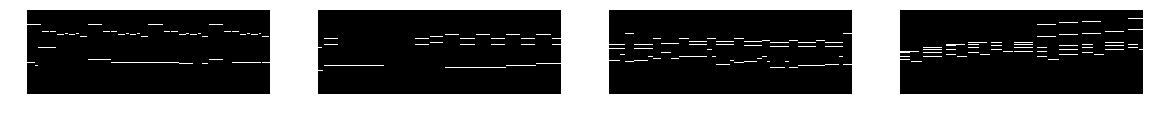

(4, 32, 32, 3)


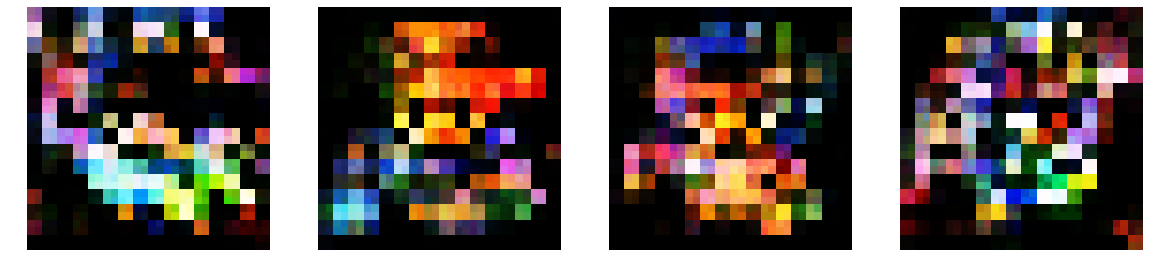

(4, 88, 256, 1)


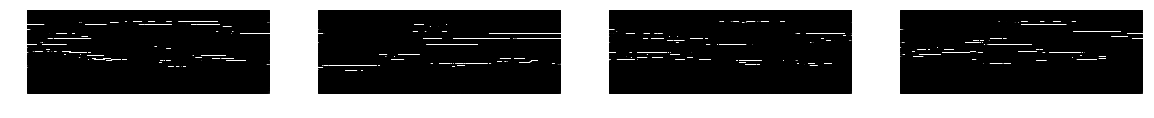

(4, 32, 32, 3)


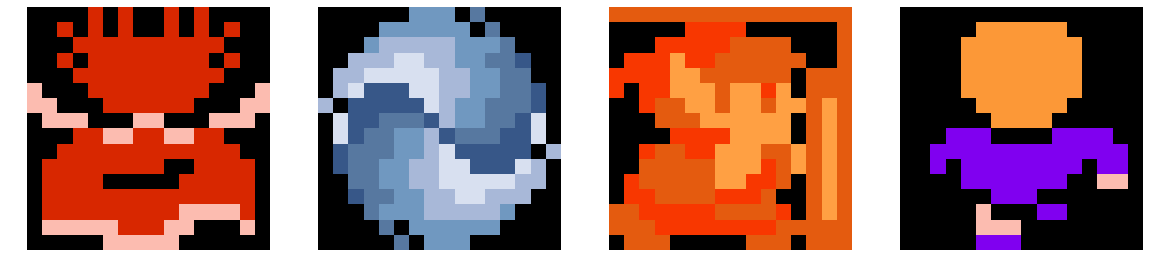

(4, 88, 256, 1)


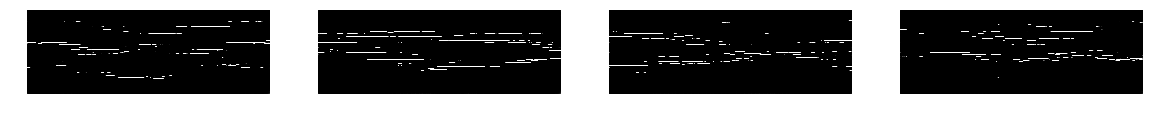

(4, 32, 32, 3)


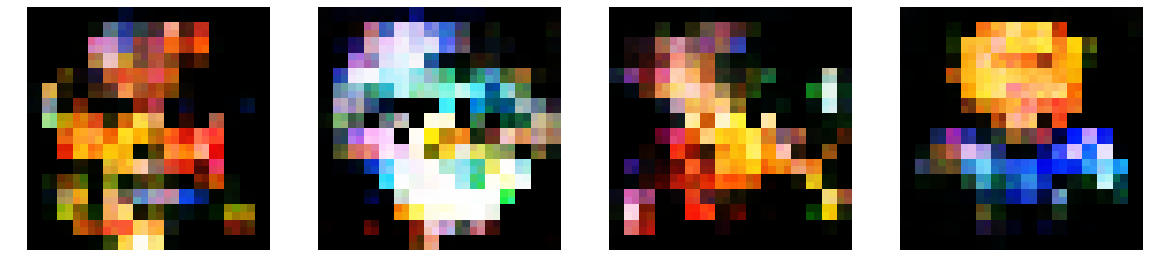

[37/100][12850] Loss_D: 0.060642 0.075694 Loss_G: 0.900310 0.950768 loss_cyc 0.451223 124.514
[37/100][12875] Loss_D: 0.042370 0.038965 Loss_G: 0.870268 0.875486 loss_cyc 0.456764 124.751
[37/100][12900] Loss_D: 0.038440 0.052858 Loss_G: 0.864390 0.947302 loss_cyc 0.449956 124.983
[37/100][12925] Loss_D: 0.060289 0.043858 Loss_G: 0.853466 0.962228 loss_cyc 0.435982 125.230
[37/100][12950] Loss_D: 0.041446 0.062275 Loss_G: 0.869483 0.914816 loss_cyc 0.432496 125.471
[37/100][12975] Loss_D: 0.050606 0.072097 Loss_G: 0.836260 0.995376 loss_cyc 0.461216 125.698
[37/100][13000] Loss_D: 0.055934 0.068451 Loss_G: 0.836488 0.932268 loss_cyc 0.465863 125.935
[37/100][13025] Loss_D: 0.053458 0.062174 Loss_G: 0.904372 1.020846 loss_cyc 0.463564 126.170
[37/100][13050] Loss_D: 0.078631 0.057332 Loss_G: 0.785356 0.978475 loss_cyc 0.423374 126.410
[37/100][13075] Loss_D: 0.046744 0.030095 Loss_G: 0.921429 0.883536 loss_cyc 0.408027 126.647
[37/100][13100] Loss_D: 0.047166 0.032086 Loss_G: 0.916901 0

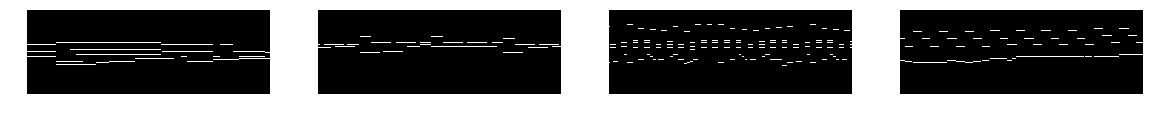

(4, 32, 32, 3)


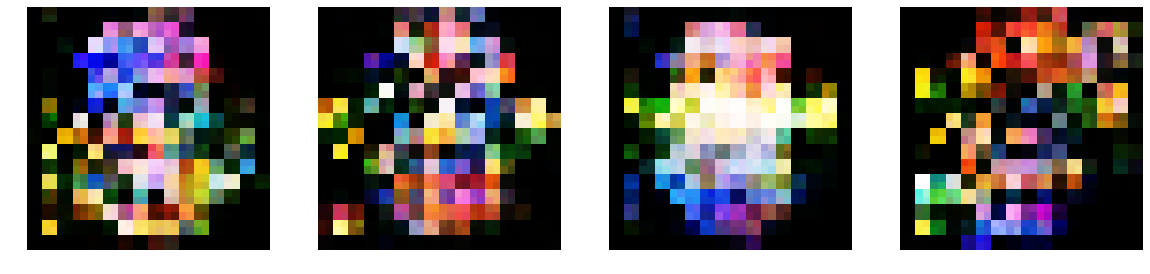

(4, 88, 256, 1)


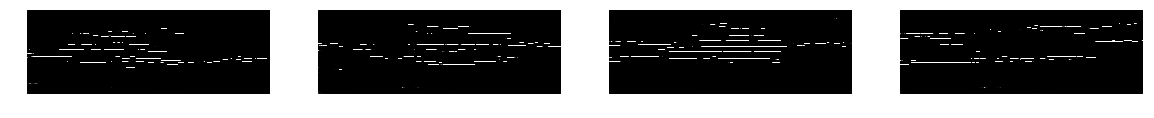

(4, 32, 32, 3)


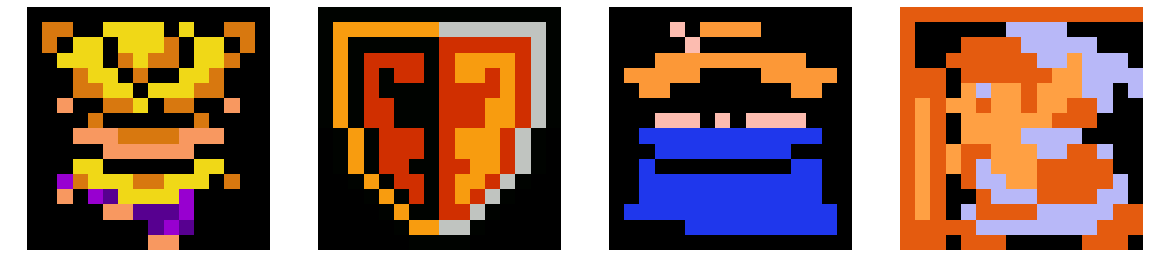

(4, 88, 256, 1)


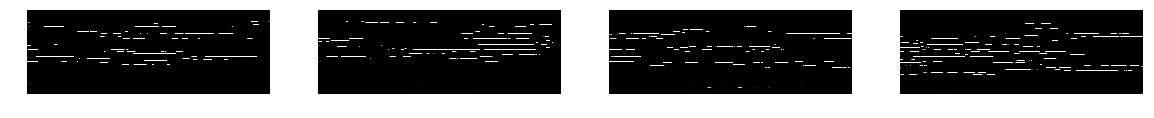

(4, 32, 32, 3)


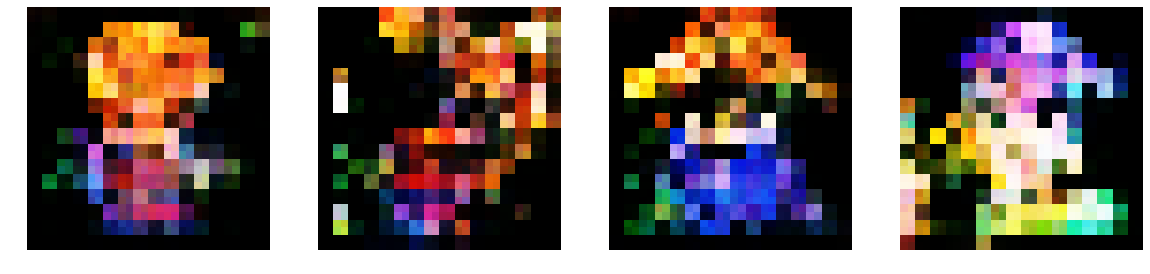

[38/100][13200] Loss_D: 0.066101 0.045402 Loss_G: 0.809769 1.003194 loss_cyc 0.462503 127.886
[38/100][13225] Loss_D: 0.041827 0.066488 Loss_G: 0.903576 0.994837 loss_cyc 0.464182 128.122
[38/100][13250] Loss_D: 0.036124 0.072987 Loss_G: 0.940366 0.911621 loss_cyc 0.459193 128.374
[38/100][13275] Loss_D: 0.051112 0.096966 Loss_G: 0.962375 0.947164 loss_cyc 0.479494 128.605
[38/100][13300] Loss_D: 0.040461 0.064290 Loss_G: 0.903796 0.926446 loss_cyc 0.454630 128.833
[38/100][13325] Loss_D: 0.044815 0.066783 Loss_G: 0.917920 0.950182 loss_cyc 0.449017 129.079
[38/100][13350] Loss_D: 0.081834 0.058222 Loss_G: 0.820163 0.873970 loss_cyc 0.434483 129.315
[38/100][13375] Loss_D: 0.071072 0.073695 Loss_G: 0.871821 0.990606 loss_cyc 0.432580 129.555
[38/100][13400] Loss_D: 0.050592 0.054491 Loss_G: 0.864628 0.890053 loss_cyc 0.440214 129.792
[38/100][13425] Loss_D: 0.050247 0.040935 Loss_G: 0.904521 1.047369 loss_cyc 0.443635 130.025
[38/100][13450] Loss_D: 0.059377 0.063766 Loss_G: 0.786561 0

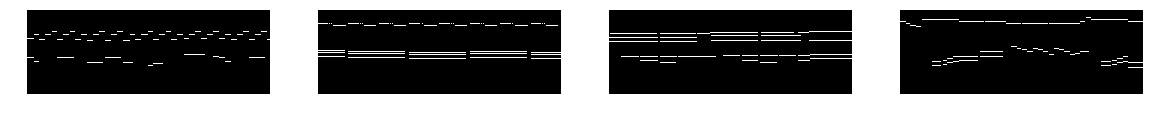

(4, 32, 32, 3)


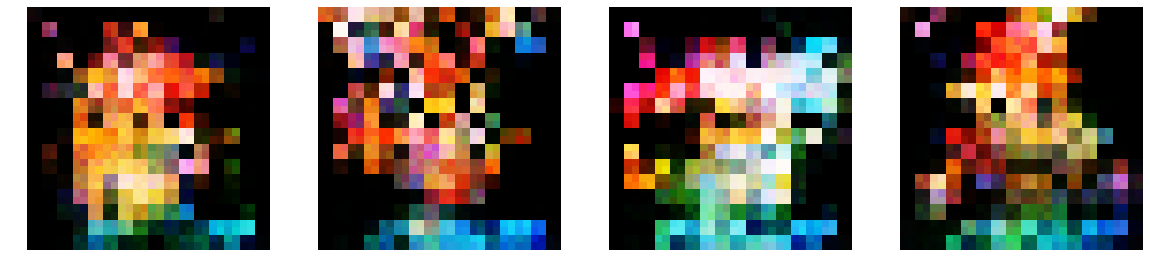

(4, 88, 256, 1)


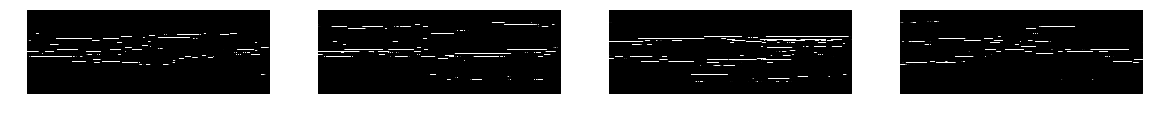

(4, 32, 32, 3)


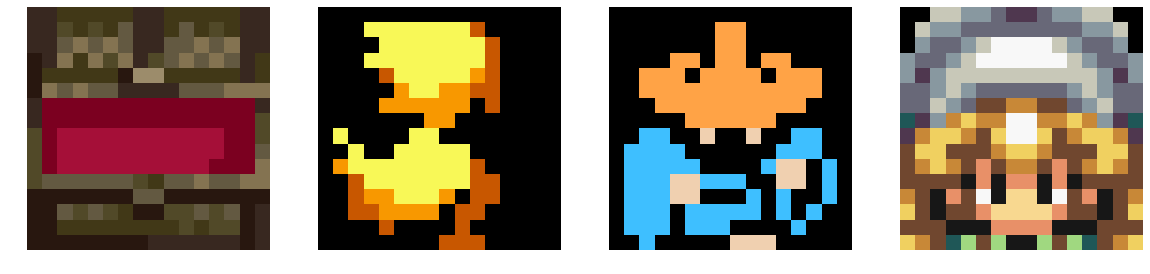

(4, 88, 256, 1)


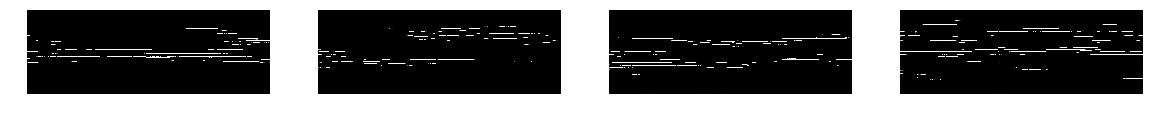

(4, 32, 32, 3)


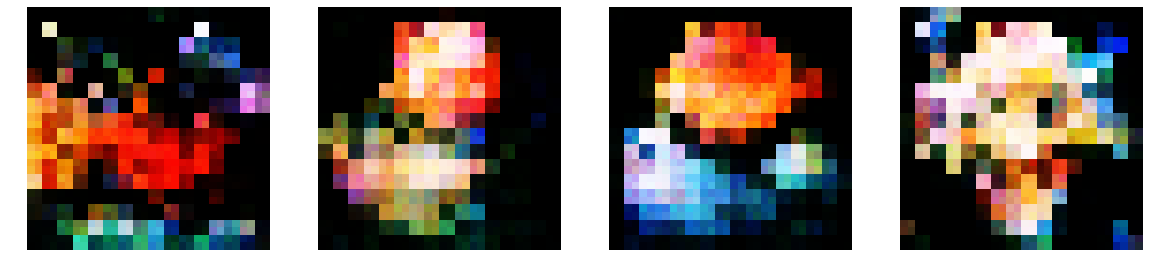

[39/100][13550] Loss_D: 0.093074 0.032656 Loss_G: 0.827899 0.924242 loss_cyc 0.468567 131.271
[39/100][13575] Loss_D: 0.059077 0.055612 Loss_G: 0.848106 0.964061 loss_cyc 0.488400 131.513
[39/100][13600] Loss_D: 0.079530 0.068173 Loss_G: 0.776235 0.921049 loss_cyc 0.462100 131.749
[39/100][13625] Loss_D: 0.057894 0.070472 Loss_G: 0.891958 0.949340 loss_cyc 0.460895 131.980
[39/100][13650] Loss_D: 0.051329 0.043463 Loss_G: 0.850308 0.959811 loss_cyc 0.407271 132.217
[39/100][13675] Loss_D: 0.053038 0.045671 Loss_G: 0.914502 1.006733 loss_cyc 0.443891 132.460
[39/100][13700] Loss_D: 0.051678 0.040608 Loss_G: 0.931409 0.902434 loss_cyc 0.450149 132.698
[39/100][13725] Loss_D: 0.054631 0.047438 Loss_G: 0.878872 0.985416 loss_cyc 0.449205 132.930
[39/100][13750] Loss_D: 0.049149 0.058790 Loss_G: 0.965470 1.076216 loss_cyc 0.459184 133.164
[39/100][13775] Loss_D: 0.058101 0.054853 Loss_G: 0.842678 1.003680 loss_cyc 0.452298 133.409
[39/100][13800] Loss_D: 0.070642 0.051696 Loss_G: 0.840508 1

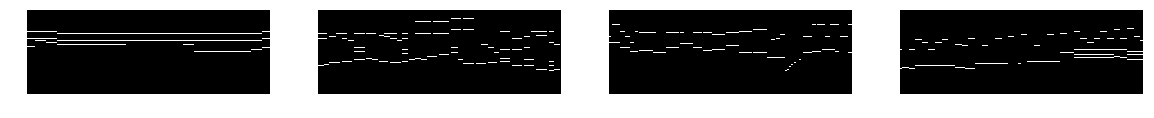

(4, 32, 32, 3)


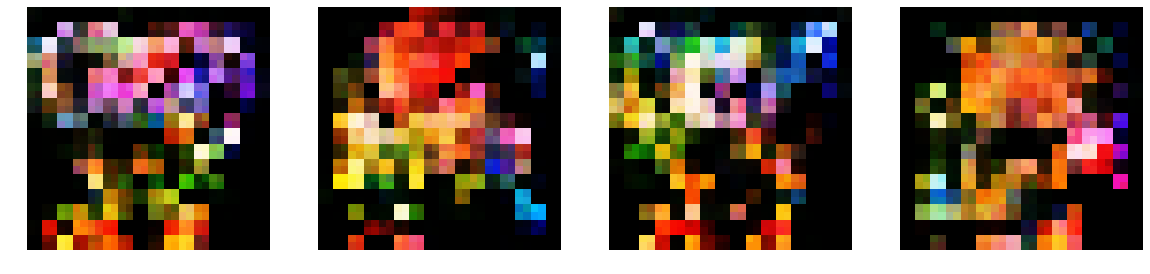

(4, 88, 256, 1)


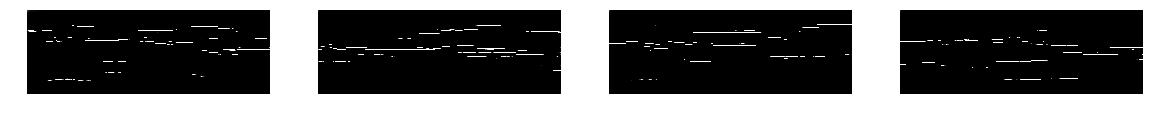

(4, 32, 32, 3)


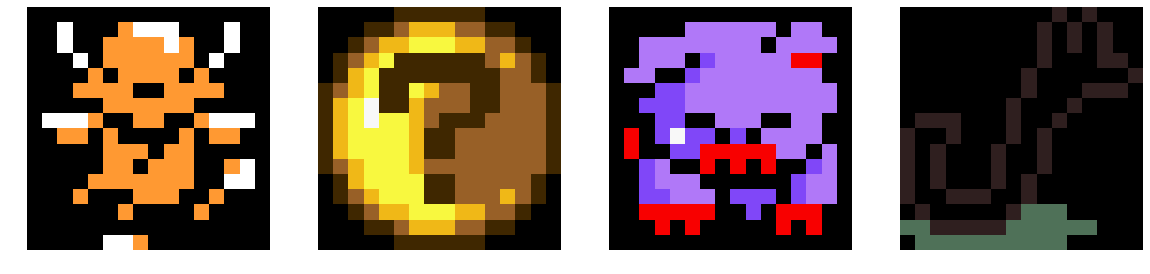

(4, 88, 256, 1)


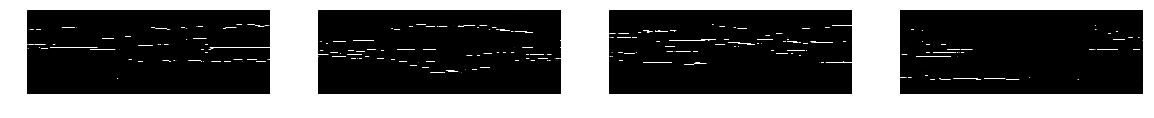

(4, 32, 32, 3)


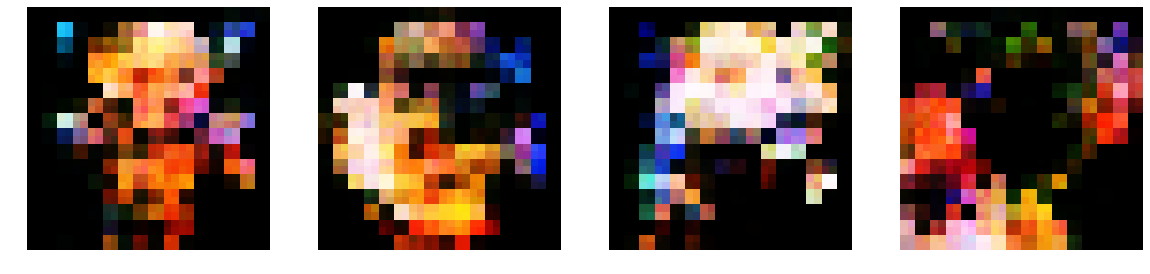

[40/100][13900] Loss_D: 0.035974 0.036906 Loss_G: 0.877482 1.015136 loss_cyc 0.422375 134.647
[40/100][13925] Loss_D: 0.037943 0.061442 Loss_G: 0.947021 0.960366 loss_cyc 0.428134 134.891
[40/100][13950] Loss_D: 0.037803 0.053842 Loss_G: 0.911477 0.982179 loss_cyc 0.453426 135.121
[40/100][13975] Loss_D: 0.035489 0.033556 Loss_G: 0.948257 0.965482 loss_cyc 0.441063 135.361
[40/100][14000] Loss_D: 0.040057 0.051347 Loss_G: 0.862049 0.930359 loss_cyc 0.485475 135.610
[40/100][14025] Loss_D: 0.020066 0.050514 Loss_G: 0.920604 0.954559 loss_cyc 0.467369 135.852
[40/100][14050] Loss_D: 0.030613 0.055863 Loss_G: 0.911202 0.985793 loss_cyc 0.438476 136.085
[40/100][14075] Loss_D: 0.038186 0.059695 Loss_G: 0.898138 0.997301 loss_cyc 0.446212 136.316
[40/100][14100] Loss_D: 0.030745 0.050577 Loss_G: 0.910428 0.964759 loss_cyc 0.455478 136.551
[40/100][14125] Loss_D: 0.044797 0.038281 Loss_G: 0.909040 0.918892 loss_cyc 0.433207 136.787
[40/100][14150] Loss_D: 0.029868 0.059796 Loss_G: 0.868136 1

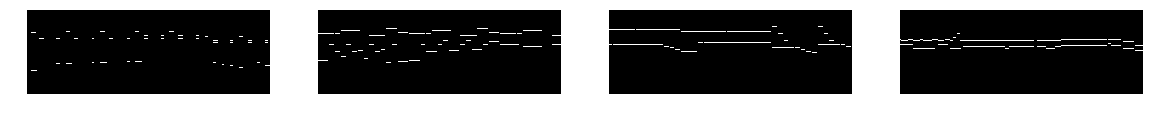

(4, 32, 32, 3)


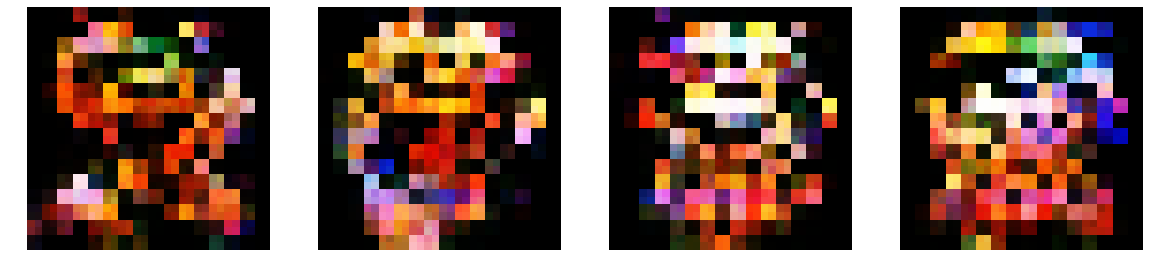

(4, 88, 256, 1)


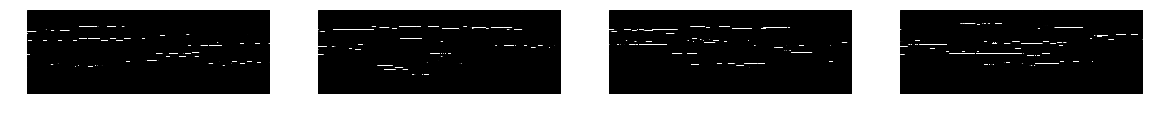

(4, 32, 32, 3)


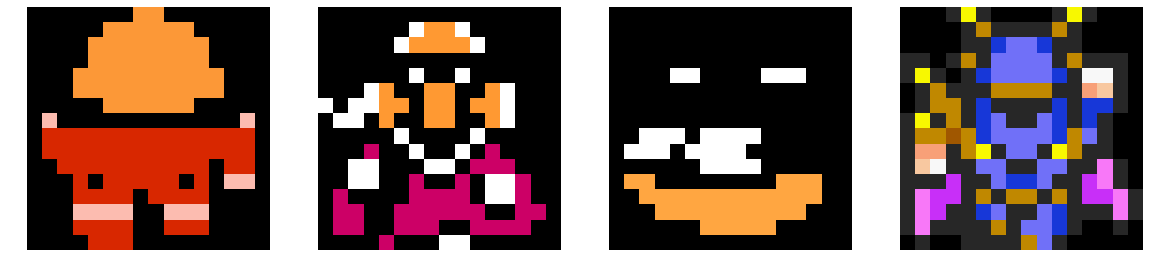

(4, 88, 256, 1)


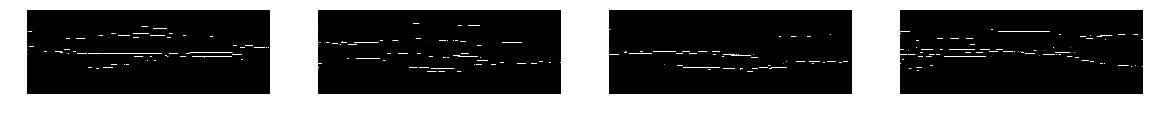

(4, 32, 32, 3)


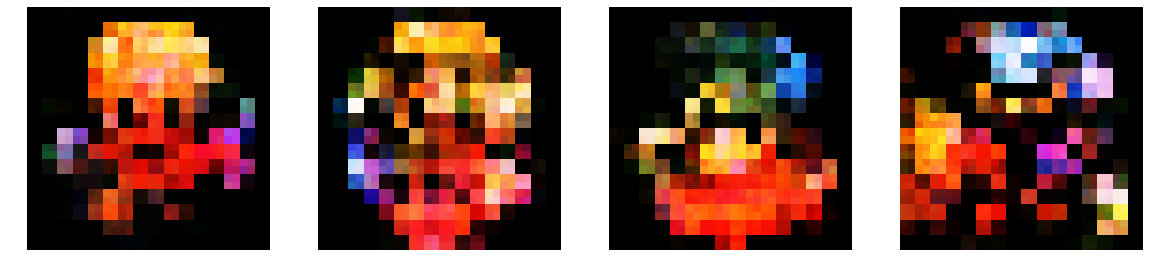

[41/100][14250] Loss_D: 0.037949 0.063363 Loss_G: 0.932869 0.965418 loss_cyc 0.451331 138.029
[41/100][14275] Loss_D: 0.043479 0.069978 Loss_G: 0.878773 0.939707 loss_cyc 0.420769 138.271
[41/100][14300] Loss_D: 0.053011 0.048871 Loss_G: 0.888779 0.960665 loss_cyc 0.436923 138.509
[41/100][14325] Loss_D: 0.045644 0.043716 Loss_G: 0.884370 1.069028 loss_cyc 0.458572 138.736
[41/100][14350] Loss_D: 0.042449 0.043690 Loss_G: 0.949798 0.979605 loss_cyc 0.466501 138.980
[41/100][14375] Loss_D: 0.054096 0.040618 Loss_G: 0.903585 0.940759 loss_cyc 0.475968 139.215
[41/100][14400] Loss_D: 0.037242 0.037846 Loss_G: 0.868951 1.051454 loss_cyc 0.462057 139.461
[41/100][14425] Loss_D: 0.047420 0.047128 Loss_G: 0.810863 0.994126 loss_cyc 0.441837 139.693
[41/100][14450] Loss_D: 0.042376 0.048512 Loss_G: 0.902009 1.006982 loss_cyc 0.464952 139.924
[41/100][14475] Loss_D: 0.065601 0.045284 Loss_G: 0.870200 1.097699 loss_cyc 0.472495 140.169
[41/100][14500] Loss_D: 0.031992 0.042329 Loss_G: 0.861620 0

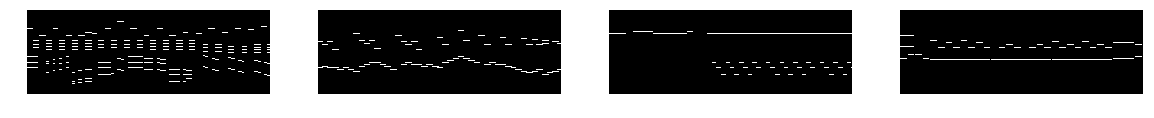

(4, 32, 32, 3)


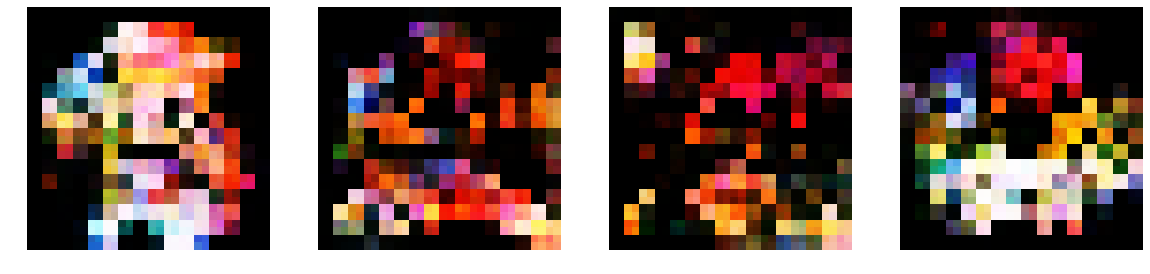

(4, 88, 256, 1)


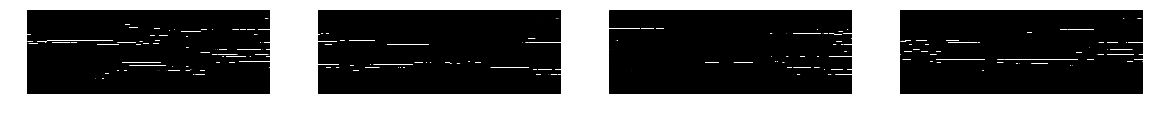

(4, 32, 32, 3)


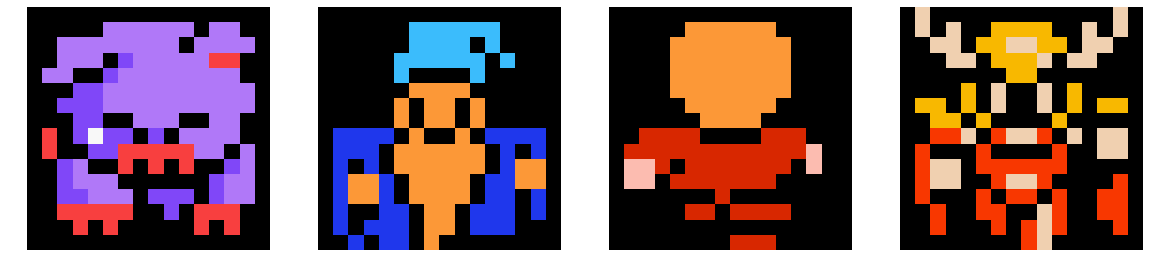

(4, 88, 256, 1)


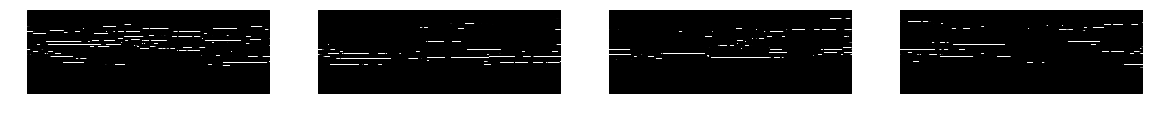

(4, 32, 32, 3)


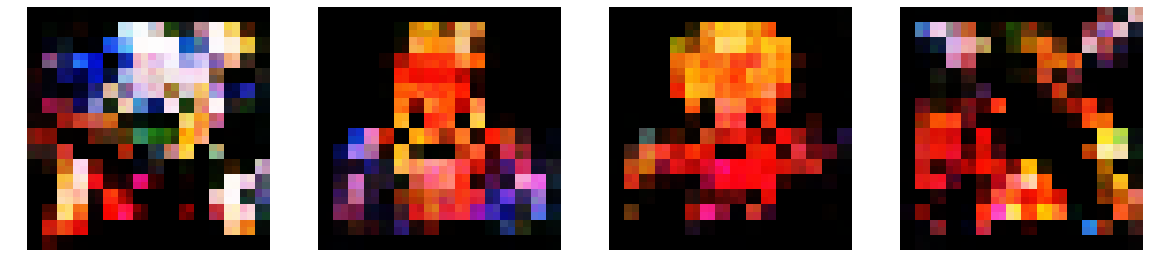

[42/100][14600] Loss_D: 0.055186 0.048338 Loss_G: 0.869784 0.948671 loss_cyc 0.476701 141.409
[42/100][14625] Loss_D: 0.046954 0.030696 Loss_G: 0.905571 0.961886 loss_cyc 0.430042 141.645
[42/100][14650] Loss_D: 0.047760 0.033604 Loss_G: 0.870101 0.919261 loss_cyc 0.467594 141.877
[42/100][14675] Loss_D: 0.043361 0.034279 Loss_G: 0.881870 0.949487 loss_cyc 0.483422 142.114
[42/100][14700] Loss_D: 0.061224 0.063691 Loss_G: 0.874141 0.947730 loss_cyc 0.466239 142.355
[42/100][14725] Loss_D: 0.044478 0.039255 Loss_G: 0.840710 1.060675 loss_cyc 0.465976 142.584
[42/100][14750] Loss_D: 0.029247 0.045222 Loss_G: 0.942805 1.066413 loss_cyc 0.450380 142.814
[42/100][14775] Loss_D: 0.047613 0.039107 Loss_G: 0.859897 1.003765 loss_cyc 0.461711 143.048
[42/100][14800] Loss_D: 0.049639 0.059810 Loss_G: 0.864900 1.010994 loss_cyc 0.439802 143.293
[42/100][14825] Loss_D: 0.058685 0.033334 Loss_G: 0.870427 0.992779 loss_cyc 0.468268 143.544
[42/100][14850] Loss_D: 0.050504 0.049968 Loss_G: 0.954869 1

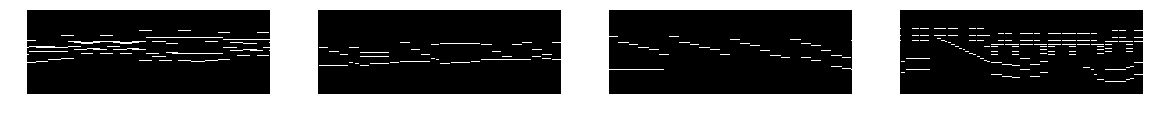

(4, 32, 32, 3)


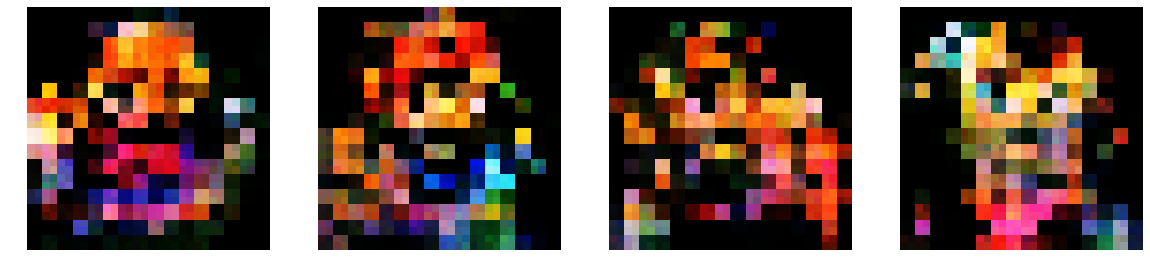

(4, 88, 256, 1)


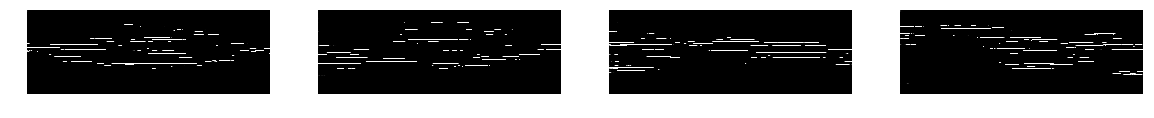

(4, 32, 32, 3)


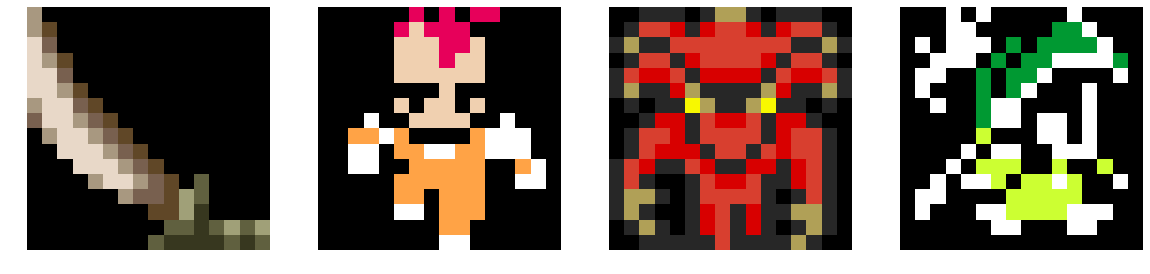

(4, 88, 256, 1)


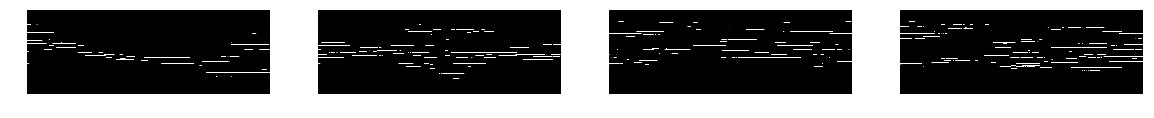

(4, 32, 32, 3)


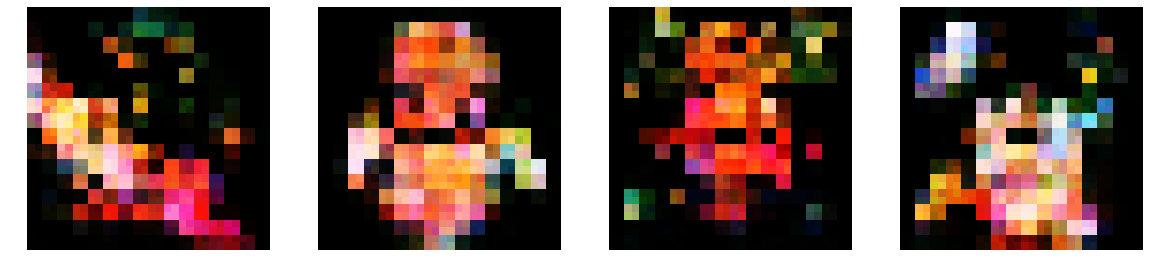

[43/100][14925] Loss_D: 0.048326 0.053308 Loss_G: 0.896576 1.056375 loss_cyc 0.440709 144.549
[43/100][14950] Loss_D: 0.044068 0.056645 Loss_G: 0.846143 1.021818 loss_cyc 0.468580 144.789
[43/100][14975] Loss_D: 0.055473 0.044570 Loss_G: 0.868696 1.047735 loss_cyc 0.457930 145.030
[43/100][15000] Loss_D: 0.049551 0.043358 Loss_G: 0.846378 0.968516 loss_cyc 0.456188 145.267
[43/100][15025] Loss_D: 0.048415 0.050376 Loss_G: 0.839794 0.902948 loss_cyc 0.456895 145.509
[43/100][15050] Loss_D: 0.054662 0.049819 Loss_G: 0.889141 0.943753 loss_cyc 0.454321 145.743
[43/100][15075] Loss_D: 0.051967 0.049659 Loss_G: 0.882402 0.940541 loss_cyc 0.447652 145.982
[43/100][15100] Loss_D: 0.038340 0.032202 Loss_G: 0.916294 0.917545 loss_cyc 0.449850 146.215
[43/100][15125] Loss_D: 0.037538 0.048467 Loss_G: 0.872693 0.985817 loss_cyc 0.420274 146.458
[43/100][15150] Loss_D: 0.045019 0.037089 Loss_G: 0.956283 0.995382 loss_cyc 0.435572 146.691
[43/100][15175] Loss_D: 0.057416 0.037303 Loss_G: 0.866590 0

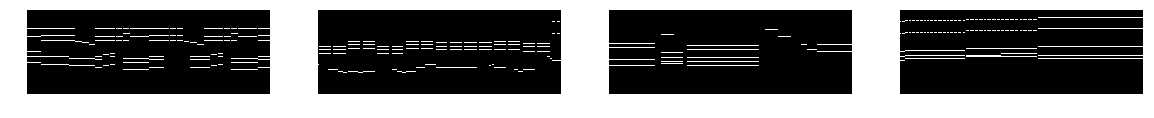

(4, 32, 32, 3)


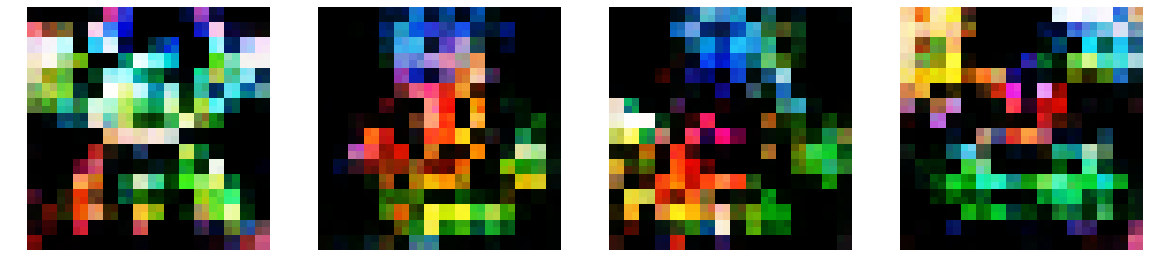

(4, 88, 256, 1)


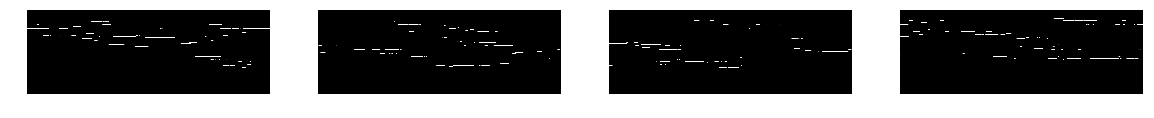

(4, 32, 32, 3)


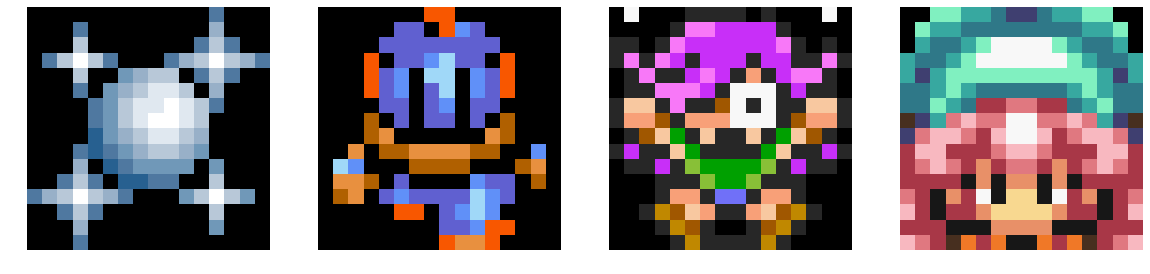

(4, 88, 256, 1)


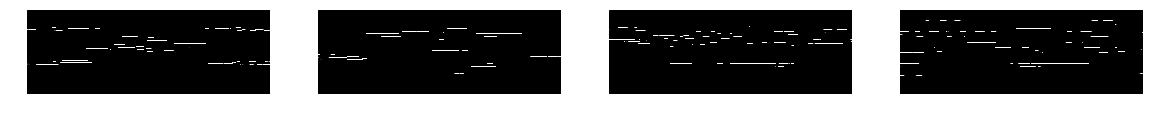

(4, 32, 32, 3)


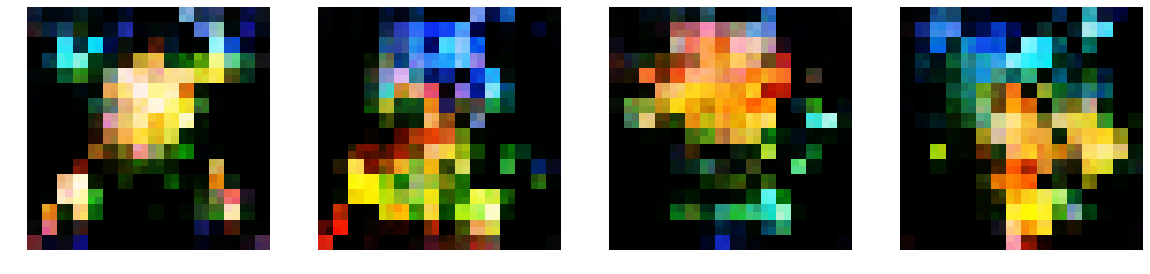

[44/100][15275] Loss_D: 0.045699 0.044803 Loss_G: 0.853342 0.931906 loss_cyc 0.432097 147.927
[44/100][15300] Loss_D: 0.048207 0.031490 Loss_G: 0.928012 0.990510 loss_cyc 0.466801 148.174
[44/100][15325] Loss_D: 0.043122 0.061478 Loss_G: 0.856463 1.121617 loss_cyc 0.464385 148.403
[44/100][15350] Loss_D: 0.036600 0.074321 Loss_G: 0.913128 0.939725 loss_cyc 0.423237 148.640
[44/100][15375] Loss_D: 0.036427 0.063567 Loss_G: 0.913215 1.076513 loss_cyc 0.428386 148.877
[44/100][15400] Loss_D: 0.050598 0.038897 Loss_G: 0.930045 0.930216 loss_cyc 0.431447 149.112
[44/100][15425] Loss_D: 0.041679 0.054694 Loss_G: 0.868471 1.000361 loss_cyc 0.436026 149.340
[44/100][15450] Loss_D: 0.059948 0.029461 Loss_G: 0.905368 0.996670 loss_cyc 0.407946 149.584
[44/100][15475] Loss_D: 0.052890 0.037913 Loss_G: 0.826228 0.916995 loss_cyc 0.431381 149.826
[44/100][15500] Loss_D: 0.041191 0.048415 Loss_G: 0.891122 1.002413 loss_cyc 0.456276 150.060
[44/100][15525] Loss_D: 0.044633 0.060684 Loss_G: 0.880168 1

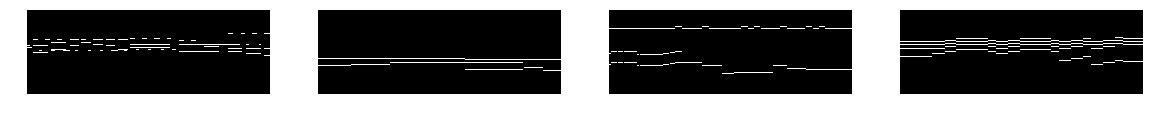

(4, 32, 32, 3)


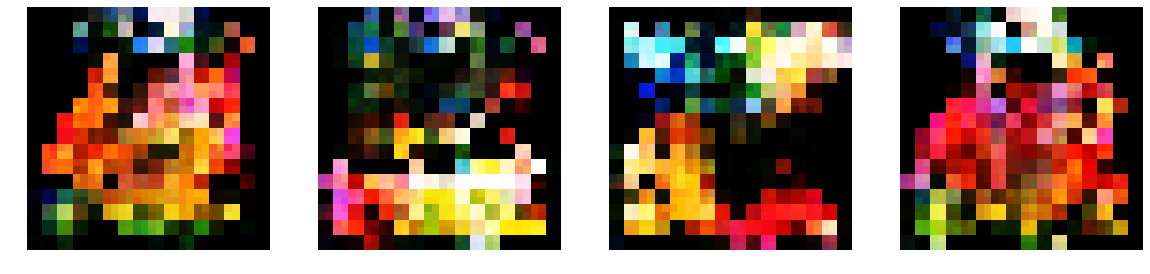

(4, 88, 256, 1)


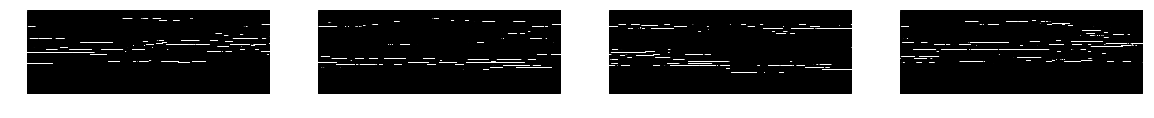

(4, 32, 32, 3)


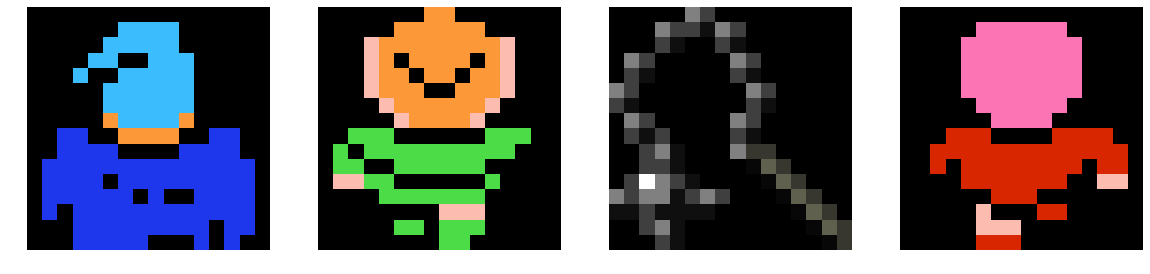

(4, 88, 256, 1)


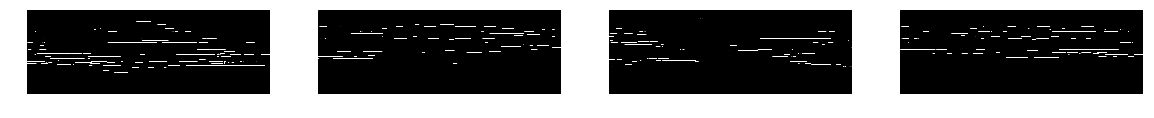

(4, 32, 32, 3)


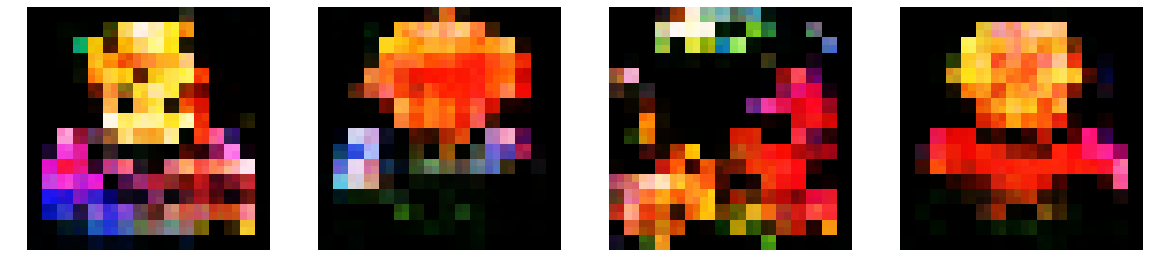

[45/100][15625] Loss_D: 0.054234 0.028526 Loss_G: 0.880214 1.023018 loss_cyc 0.415601 151.303
[45/100][15650] Loss_D: 0.051933 0.032320 Loss_G: 0.856431 0.931196 loss_cyc 0.432178 151.537
[45/100][15675] Loss_D: 0.031095 0.033403 Loss_G: 0.977513 1.097454 loss_cyc 0.408555 151.770
[45/100][15700] Loss_D: 0.066699 0.055815 Loss_G: 0.839954 0.995738 loss_cyc 0.430322 152.002
[45/100][15725] Loss_D: 0.061560 0.043851 Loss_G: 0.885086 0.993196 loss_cyc 0.461831 152.240
[45/100][15750] Loss_D: 0.043919 0.045473 Loss_G: 0.860300 0.968187 loss_cyc 0.418001 152.475
[45/100][15775] Loss_D: 0.047381 0.038222 Loss_G: 0.947122 0.971870 loss_cyc 0.424512 152.713
[45/100][15800] Loss_D: 0.047785 0.029229 Loss_G: 0.818885 1.039350 loss_cyc 0.442877 152.945
[45/100][15825] Loss_D: 0.045301 0.053933 Loss_G: 0.925155 0.950523 loss_cyc 0.432847 153.189
[45/100][15850] Loss_D: 0.042721 0.045233 Loss_G: 0.875359 1.036115 loss_cyc 0.396022 153.421
[45/100][15875] Loss_D: 0.031548 0.072185 Loss_G: 0.925740 1

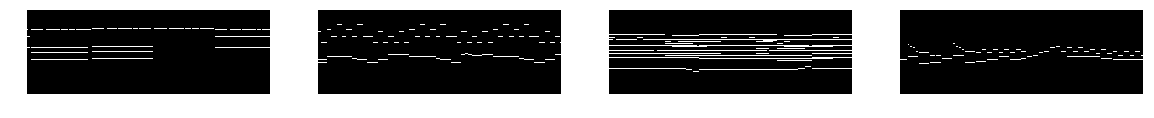

(4, 32, 32, 3)


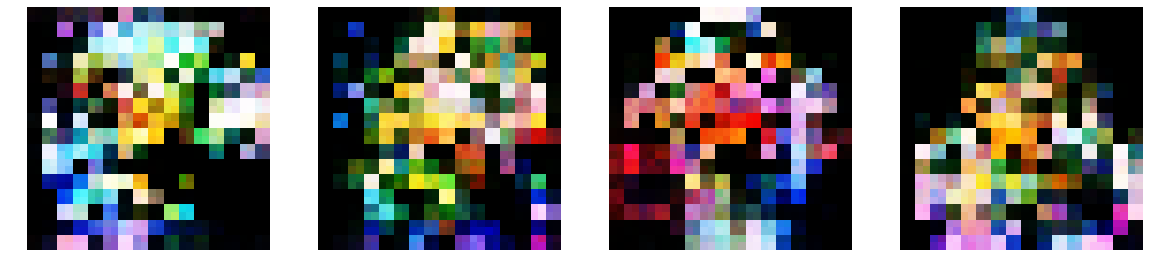

(4, 88, 256, 1)


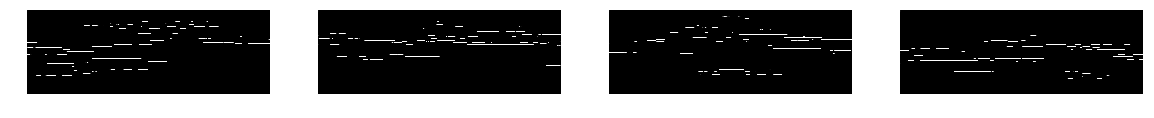

(4, 32, 32, 3)


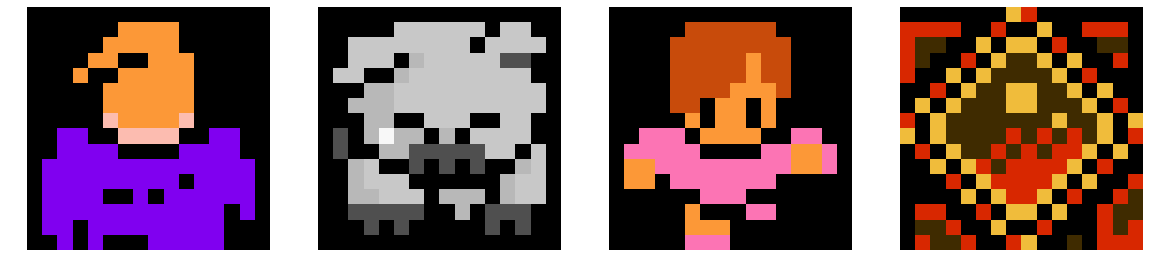

(4, 88, 256, 1)


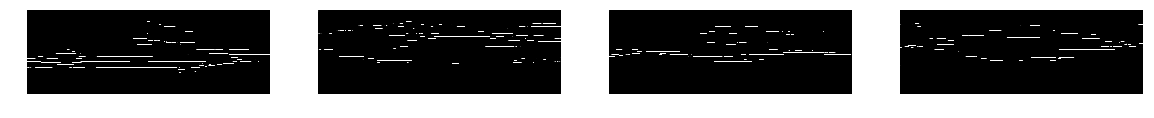

(4, 32, 32, 3)


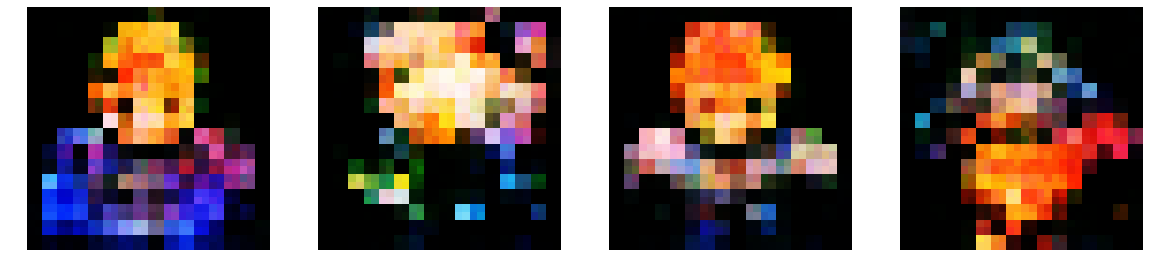

[46/100][15975] Loss_D: 0.044801 0.051472 Loss_G: 0.871476 1.056619 loss_cyc 0.411336 154.691
[46/100][16000] Loss_D: 0.045426 0.059051 Loss_G: 0.894946 0.987367 loss_cyc 0.440754 154.925
[46/100][16025] Loss_D: 0.077393 0.032762 Loss_G: 0.804355 1.002878 loss_cyc 0.425629 155.156
[46/100][16050] Loss_D: 0.043461 0.034150 Loss_G: 0.900331 0.995959 loss_cyc 0.428269 155.405
[46/100][16075] Loss_D: 0.048778 0.040554 Loss_G: 0.818813 1.058285 loss_cyc 0.465635 155.641
[46/100][16100] Loss_D: 0.056491 0.046532 Loss_G: 0.845118 1.071670 loss_cyc 0.424199 155.878
[46/100][16125] Loss_D: 0.034773 0.063482 Loss_G: 0.867243 1.037651 loss_cyc 0.433813 156.112
[46/100][16150] Loss_D: 0.050134 0.058114 Loss_G: 0.939020 0.953566 loss_cyc 0.409557 156.353
[46/100][16175] Loss_D: 0.035573 0.036626 Loss_G: 0.924649 0.994691 loss_cyc 0.441854 156.582
[46/100][16200] Loss_D: 0.062614 0.044840 Loss_G: 0.858427 0.981507 loss_cyc 0.434977 156.814
[46/100][16225] Loss_D: 0.054997 0.039687 Loss_G: 0.846155 0

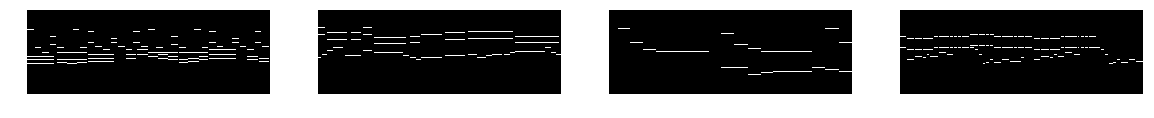

(4, 32, 32, 3)


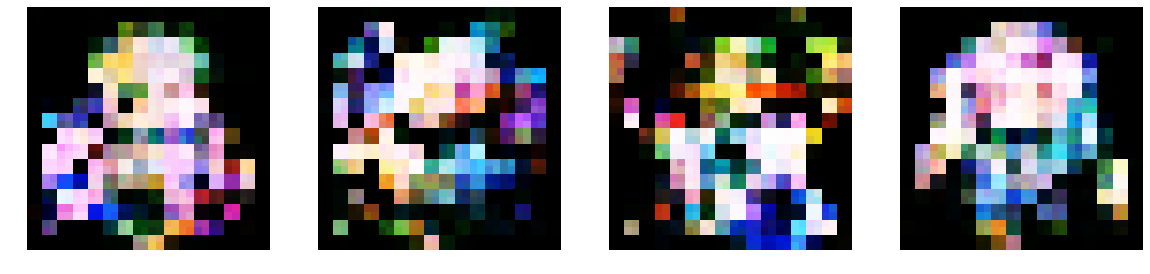

(4, 88, 256, 1)


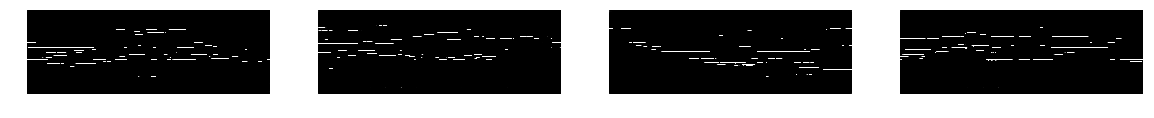

(4, 32, 32, 3)


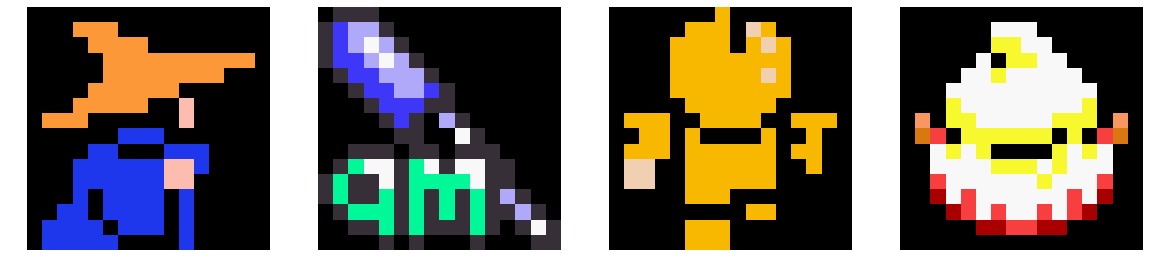

(4, 88, 256, 1)


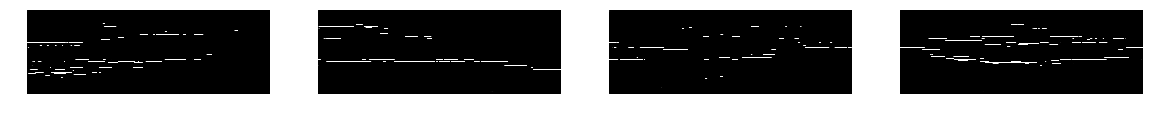

(4, 32, 32, 3)


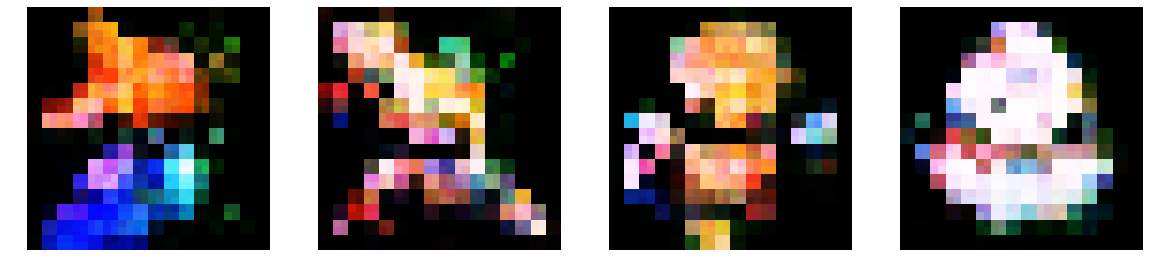

[47/100][16325] Loss_D: 0.032650 0.046612 Loss_G: 0.925080 1.007759 loss_cyc 0.425587 158.056
[47/100][16350] Loss_D: 0.074099 0.064258 Loss_G: 0.766399 1.001614 loss_cyc 0.432477 158.285
[47/100][16375] Loss_D: 0.046201 0.041083 Loss_G: 0.865546 0.974720 loss_cyc 0.439175 158.523
[47/100][16400] Loss_D: 0.045682 0.049583 Loss_G: 0.900262 1.012256 loss_cyc 0.421079 158.773
[47/100][16425] Loss_D: 0.045743 0.041982 Loss_G: 0.881129 0.941280 loss_cyc 0.441542 159.005
[47/100][16450] Loss_D: 0.048929 0.056125 Loss_G: 0.874181 0.952993 loss_cyc 0.423132 159.241
[47/100][16475] Loss_D: 0.059240 0.031141 Loss_G: 0.873441 0.930652 loss_cyc 0.427272 159.477
[47/100][16500] Loss_D: 0.060999 0.029398 Loss_G: 0.825901 0.973091 loss_cyc 0.430941 159.717
[47/100][16525] Loss_D: 0.051696 0.034684 Loss_G: 0.880171 1.005325 loss_cyc 0.424503 159.960
[47/100][16550] Loss_D: 0.036712 0.039502 Loss_G: 0.965878 1.029524 loss_cyc 0.441517 160.192
[47/100][16575] Loss_D: 0.039767 0.019819 Loss_G: 0.910000 0

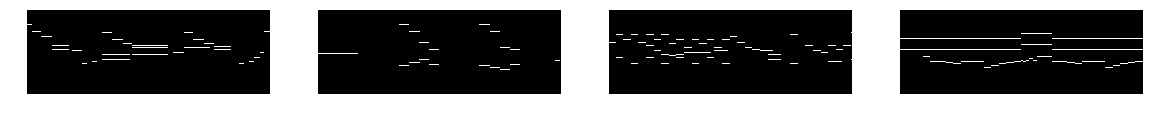

(4, 32, 32, 3)


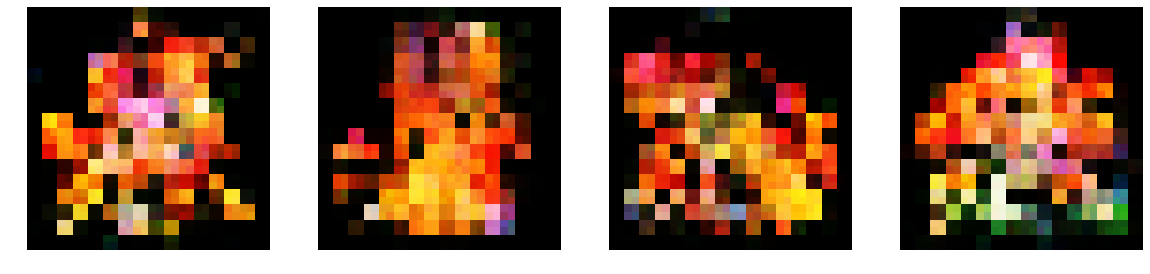

(4, 88, 256, 1)


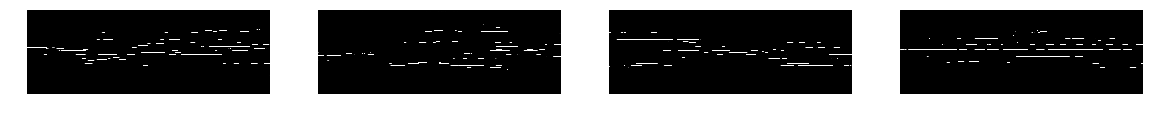

(4, 32, 32, 3)


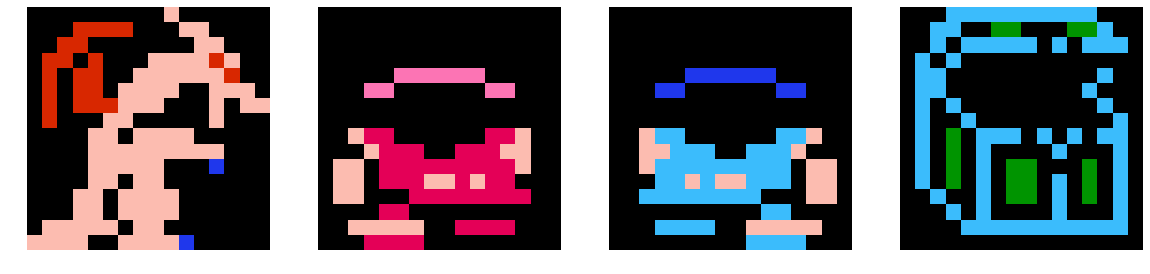

(4, 88, 256, 1)


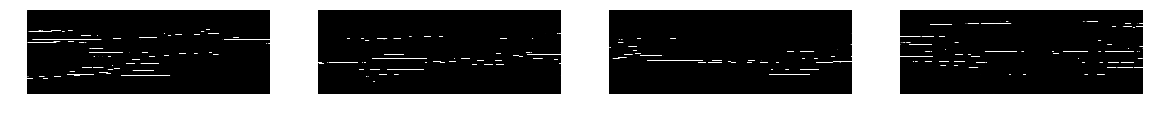

(4, 32, 32, 3)


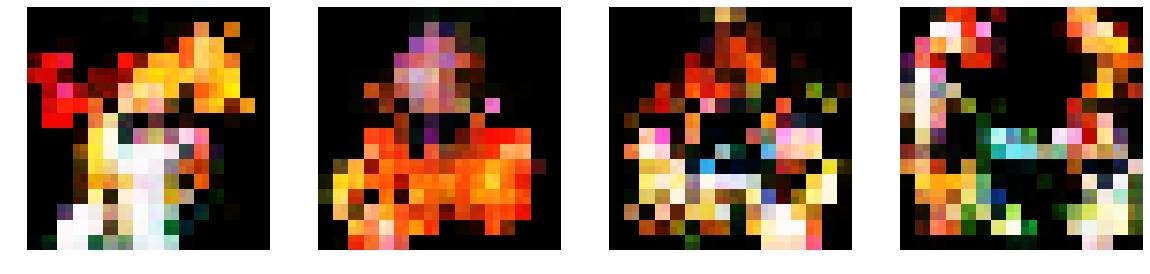

[48/100][16675] Loss_D: 0.045489 0.039287 Loss_G: 0.881879 1.097564 loss_cyc 0.425578 161.422
[48/100][16700] Loss_D: 0.049428 0.025167 Loss_G: 0.844902 1.030617 loss_cyc 0.425198 161.664
[48/100][16725] Loss_D: 0.042164 0.047447 Loss_G: 0.843254 0.985886 loss_cyc 0.419241 161.895
[48/100][16750] Loss_D: 0.031367 0.026824 Loss_G: 0.950613 0.937737 loss_cyc 0.432603 162.126
[48/100][16775] Loss_D: 0.057746 0.023205 Loss_G: 0.902976 1.052015 loss_cyc 0.425602 162.370
[48/100][16800] Loss_D: 0.034812 0.029876 Loss_G: 0.927072 1.023669 loss_cyc 0.447222 162.609
[48/100][16825] Loss_D: 0.049477 0.036876 Loss_G: 0.879884 1.012050 loss_cyc 0.448259 162.844
[48/100][16850] Loss_D: 0.047401 0.034044 Loss_G: 0.872188 0.991516 loss_cyc 0.440287 163.078
[48/100][16875] Loss_D: 0.046267 0.029484 Loss_G: 0.904092 1.030301 loss_cyc 0.438163 163.315
[48/100][16900] Loss_D: 0.051600 0.029794 Loss_G: 0.865107 1.074429 loss_cyc 0.412577 163.551
[48/100][16925] Loss_D: 0.040348 0.027550 Loss_G: 0.897014 1

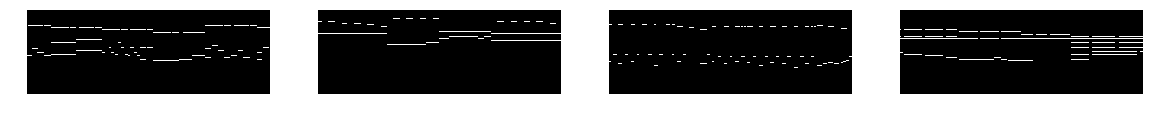

(4, 32, 32, 3)


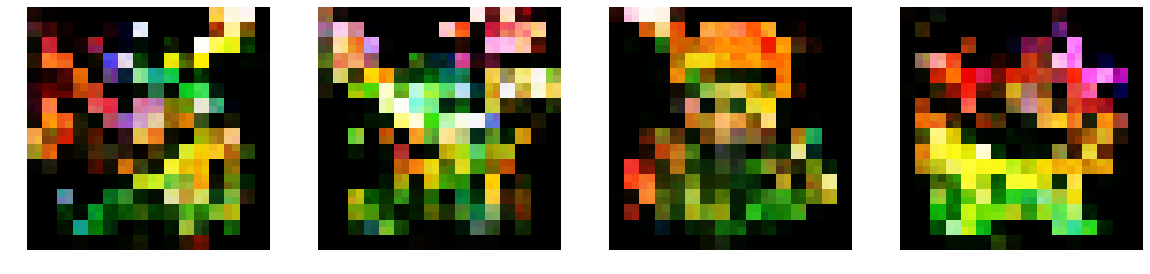

(4, 88, 256, 1)


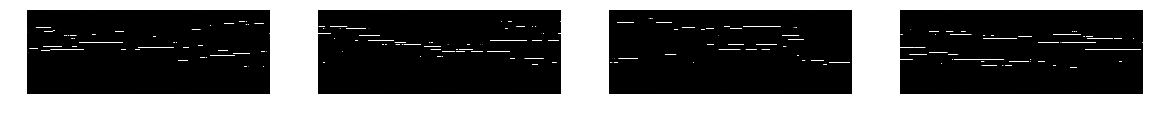

(4, 32, 32, 3)


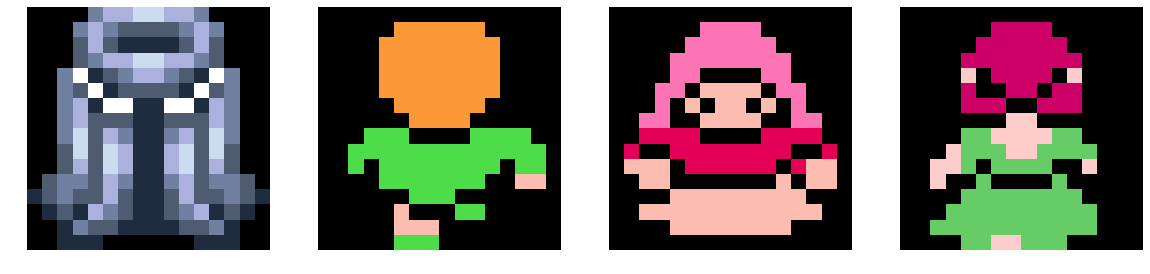

(4, 88, 256, 1)


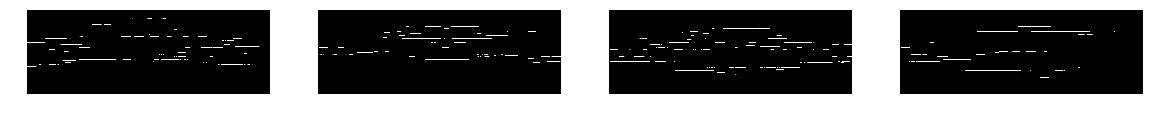

(4, 32, 32, 3)


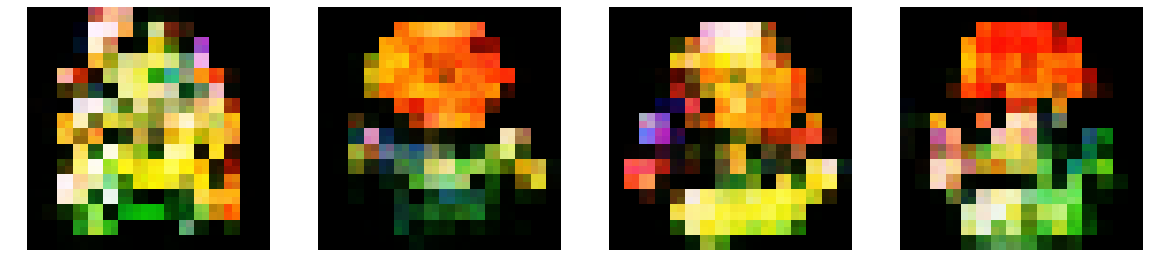

[49/100][17025] Loss_D: 0.046861 0.046796 Loss_G: 0.881467 0.992569 loss_cyc 0.446790 164.805
[49/100][17050] Loss_D: 0.067624 0.039574 Loss_G: 0.902196 1.072743 loss_cyc 0.412575 165.042
[49/100][17075] Loss_D: 0.042448 0.036242 Loss_G: 0.862598 1.051191 loss_cyc 0.435409 165.281
[49/100][17100] Loss_D: 0.030534 0.036475 Loss_G: 0.903003 1.024373 loss_cyc 0.428220 165.517
[49/100][17125] Loss_D: 0.057696 0.037626 Loss_G: 0.871452 1.079340 loss_cyc 0.441786 165.752
[49/100][17150] Loss_D: 0.038092 0.028013 Loss_G: 0.916894 1.025628 loss_cyc 0.430225 165.993
[49/100][17175] Loss_D: 0.060799 0.074734 Loss_G: 0.866997 0.991495 loss_cyc 0.459913 166.226
[49/100][17200] Loss_D: 0.041424 0.035142 Loss_G: 0.919207 0.944997 loss_cyc 0.458536 166.465
[49/100][17225] Loss_D: 0.054447 0.030963 Loss_G: 0.847941 0.973748 loss_cyc 0.471376 166.700
[49/100][17250] Loss_D: 0.031490 0.063137 Loss_G: 0.930197 0.987115 loss_cyc 0.433523 166.941
[49/100][17275] Loss_D: 0.037184 0.060257 Loss_G: 0.962073 0

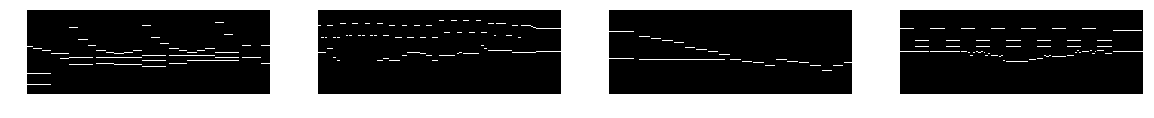

(4, 32, 32, 3)


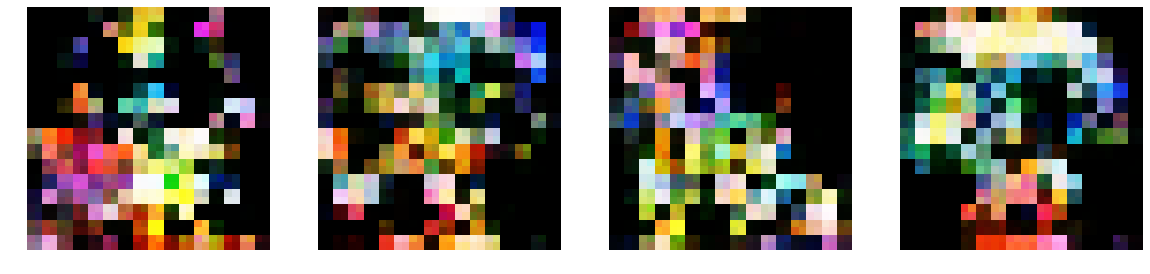

(4, 88, 256, 1)


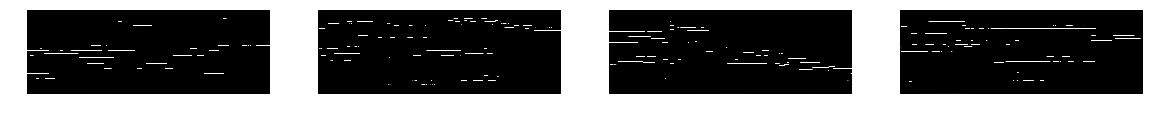

(4, 32, 32, 3)


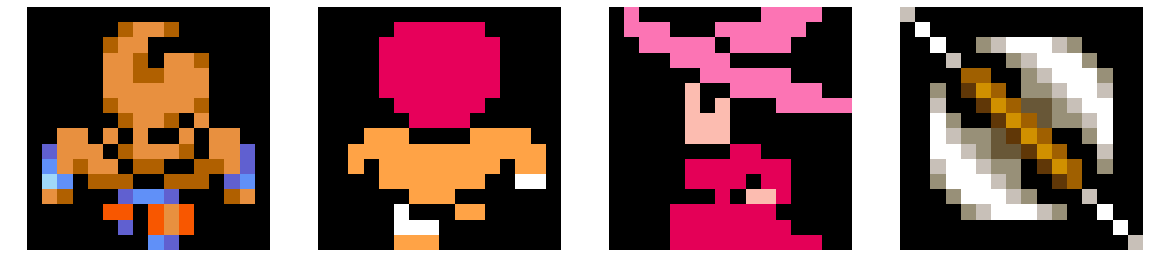

(4, 88, 256, 1)


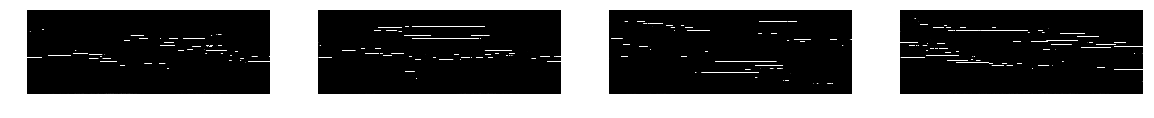

(4, 32, 32, 3)


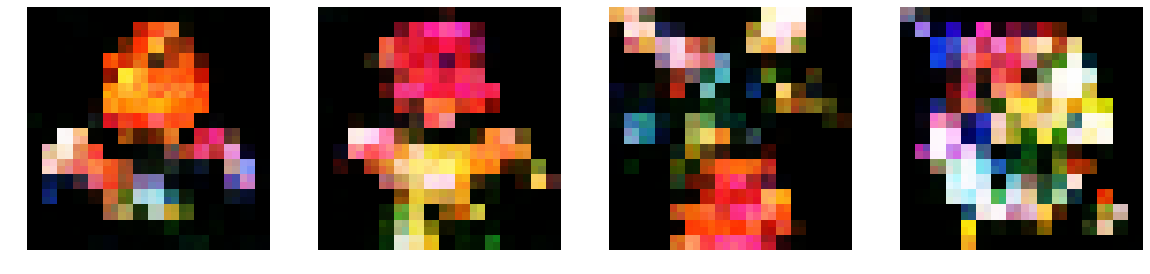

[50/100][17375] Loss_D: 0.029409 0.054266 Loss_G: 0.942332 1.150614 loss_cyc 0.443745 168.183
[50/100][17400] Loss_D: 0.030120 0.036298 Loss_G: 0.948917 1.068236 loss_cyc 0.453919 168.428
[50/100][17425] Loss_D: 0.048214 0.041543 Loss_G: 0.895216 0.957315 loss_cyc 0.439164 168.664
[50/100][17450] Loss_D: 0.050589 0.046908 Loss_G: 0.875623 0.969694 loss_cyc 0.433621 168.897
[50/100][17475] Loss_D: 0.035343 0.052402 Loss_G: 0.930636 0.978917 loss_cyc 0.427709 169.137
[50/100][17500] Loss_D: 0.037045 0.056575 Loss_G: 0.856470 0.900313 loss_cyc 0.419779 169.370
[50/100][17525] Loss_D: 0.034720 0.052688 Loss_G: 0.941966 1.001192 loss_cyc 0.428826 169.602
[50/100][17550] Loss_D: 0.039416 0.053731 Loss_G: 0.914545 0.920100 loss_cyc 0.413296 169.847
[50/100][17575] Loss_D: 0.040432 0.034853 Loss_G: 0.912476 1.010911 loss_cyc 0.424080 170.088
[50/100][17600] Loss_D: 0.027104 0.035422 Loss_G: 0.916310 0.940972 loss_cyc 0.404518 170.311
[50/100][17625] Loss_D: 0.041455 0.062675 Loss_G: 0.942280 0

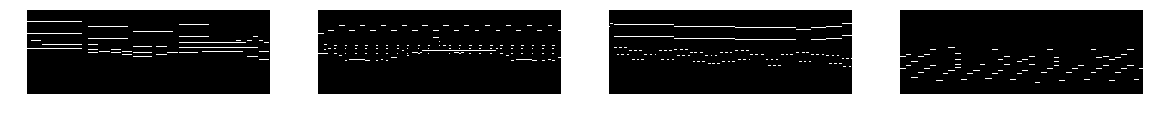

(4, 32, 32, 3)


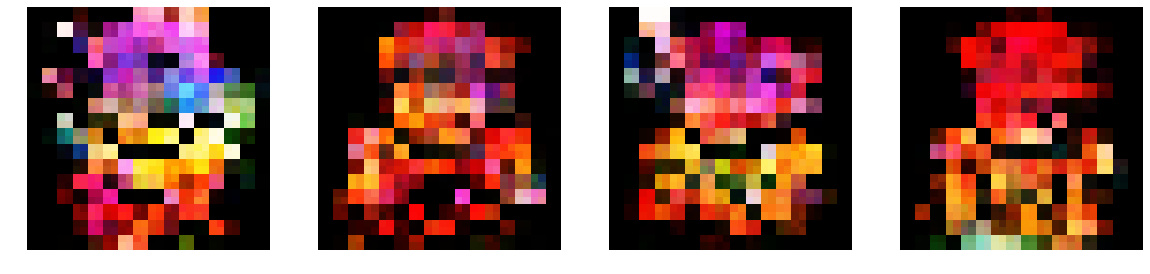

(4, 88, 256, 1)


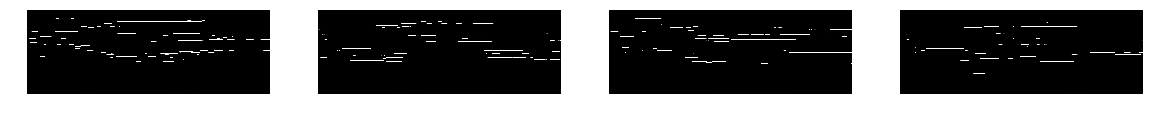

(4, 32, 32, 3)


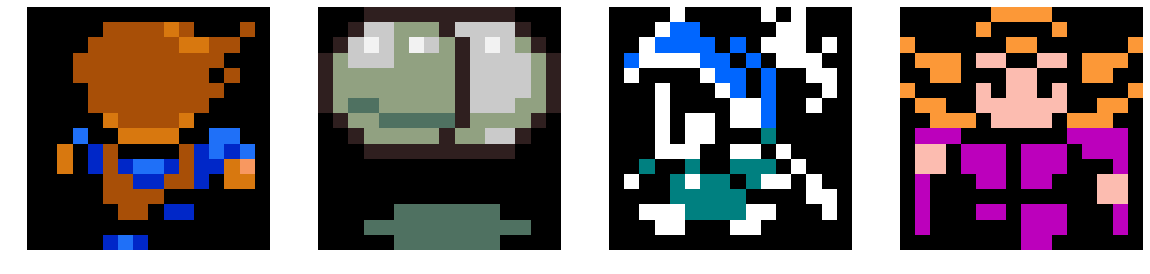

(4, 88, 256, 1)


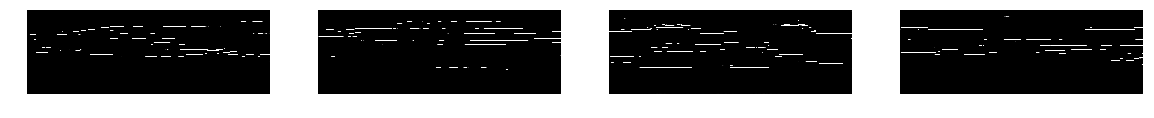

(4, 32, 32, 3)


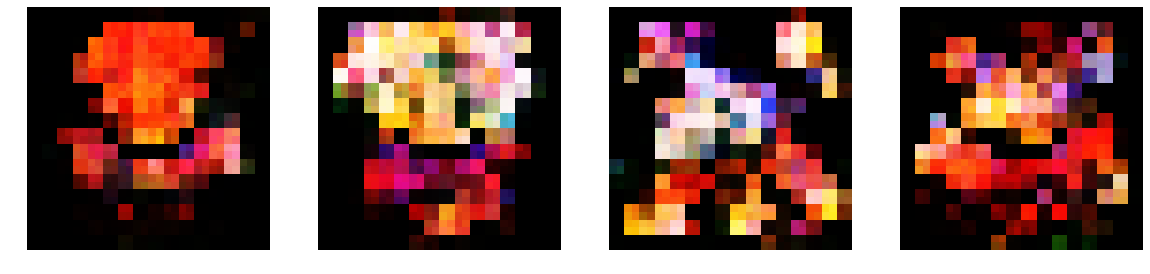

[51/100][17725] Loss_D: 0.035852 0.039559 Loss_G: 0.931194 0.989201 loss_cyc 0.437791 171.543
[51/100][17750] Loss_D: 0.036620 0.053466 Loss_G: 0.907069 0.947535 loss_cyc 0.445872 171.783
[51/100][17775] Loss_D: 0.028411 0.031642 Loss_G: 0.941787 0.964002 loss_cyc 0.452383 172.025
[51/100][17800] Loss_D: 0.036011 0.034298 Loss_G: 0.940679 0.979493 loss_cyc 0.400121 172.274
[51/100][17825] Loss_D: 0.039700 0.036061 Loss_G: 0.915529 1.023705 loss_cyc 0.443588 172.499
[51/100][17850] Loss_D: 0.047739 0.018900 Loss_G: 0.883159 0.999205 loss_cyc 0.429275 172.727
[51/100][17875] Loss_D: 0.055900 0.043593 Loss_G: 0.875891 1.071322 loss_cyc 0.416436 172.967
[51/100][17900] Loss_D: 0.042945 0.039101 Loss_G: 0.939975 0.975150 loss_cyc 0.430100 173.201
[51/100][17925] Loss_D: 0.038104 0.030667 Loss_G: 0.900528 1.019636 loss_cyc 0.443546 173.442
[51/100][17950] Loss_D: 0.029350 0.047330 Loss_G: 0.927331 0.995871 loss_cyc 0.438261 173.679
[51/100][17975] Loss_D: 0.036036 0.029874 Loss_G: 0.909276 0

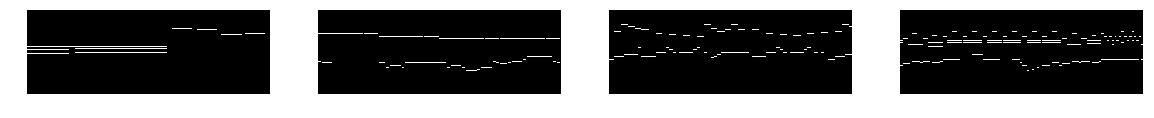

(4, 32, 32, 3)


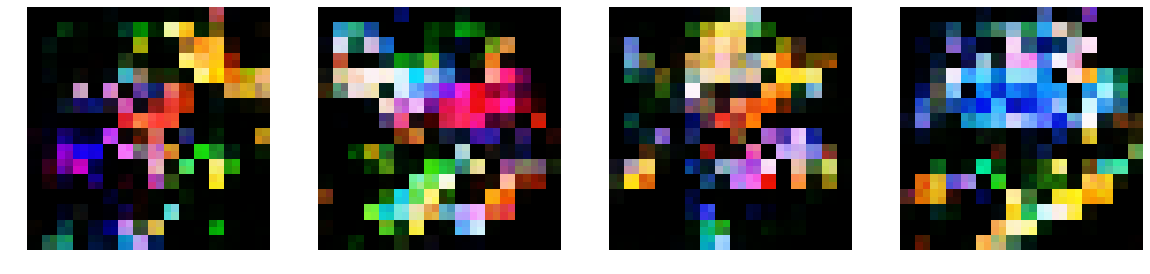

(4, 88, 256, 1)


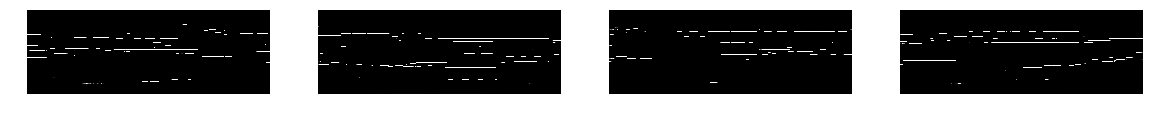

(4, 32, 32, 3)


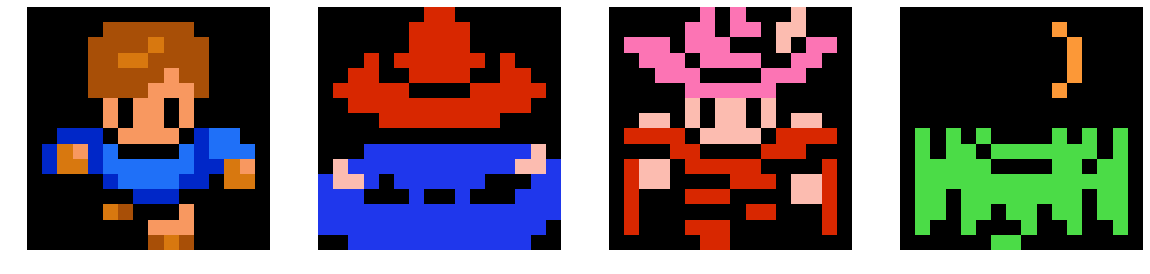

(4, 88, 256, 1)


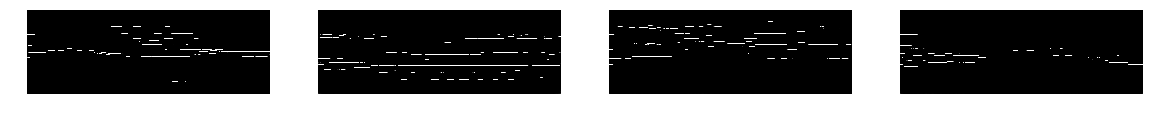

(4, 32, 32, 3)


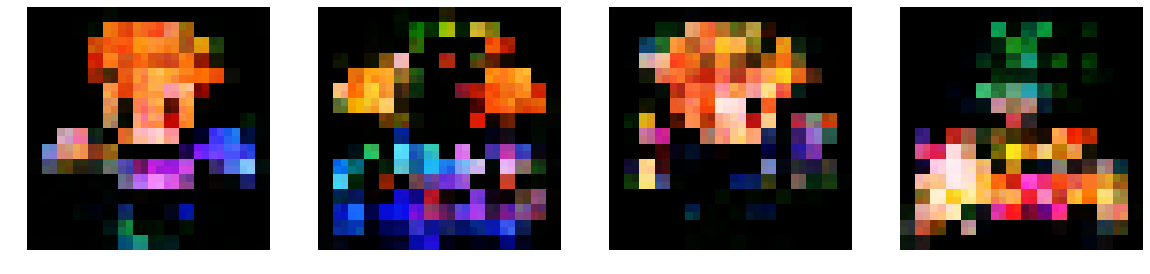

[52/100][18050] Loss_D: 0.030180 0.032340 Loss_G: 0.931276 0.944039 loss_cyc 0.398498 174.687
[52/100][18075] Loss_D: 0.034324 0.030517 Loss_G: 0.881441 1.014858 loss_cyc 0.419793 174.913
[52/100][18100] Loss_D: 0.024365 0.039606 Loss_G: 0.968196 0.986172 loss_cyc 0.448345 175.157
[52/100][18125] Loss_D: 0.036786 0.025642 Loss_G: 0.900946 1.004438 loss_cyc 0.433757 175.389
[52/100][18150] Loss_D: 0.051791 0.046591 Loss_G: 0.849306 1.068408 loss_cyc 0.425253 175.616
[52/100][18175] Loss_D: 0.038639 0.051095 Loss_G: 0.942514 0.995268 loss_cyc 0.407814 175.860
[52/100][18200] Loss_D: 0.049709 0.039293 Loss_G: 0.932329 1.001813 loss_cyc 0.436044 176.098
[52/100][18225] Loss_D: 0.035118 0.042943 Loss_G: 0.929691 0.971062 loss_cyc 0.424282 176.331
[52/100][18250] Loss_D: 0.027134 0.027293 Loss_G: 0.906314 0.993838 loss_cyc 0.434351 176.577
[52/100][18275] Loss_D: 0.027981 0.053985 Loss_G: 0.945790 1.038868 loss_cyc 0.426512 176.815
[52/100][18300] Loss_D: 0.025608 0.044155 Loss_G: 0.987697 0

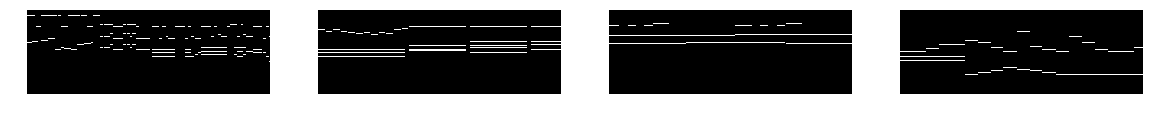

(4, 32, 32, 3)


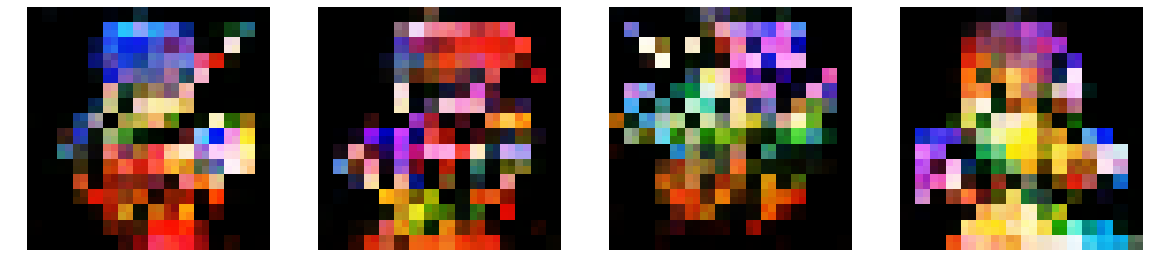

(4, 88, 256, 1)


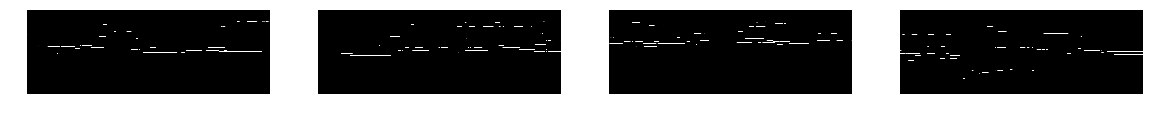

(4, 32, 32, 3)


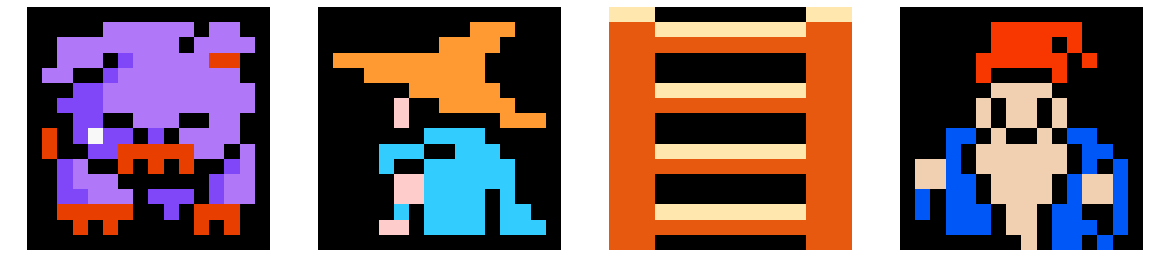

(4, 88, 256, 1)


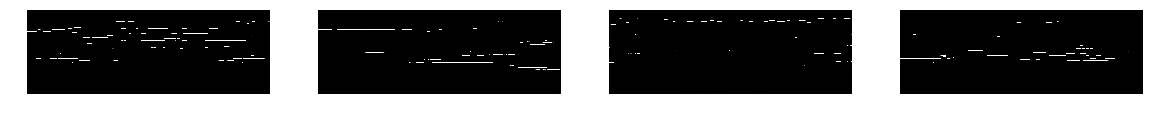

(4, 32, 32, 3)


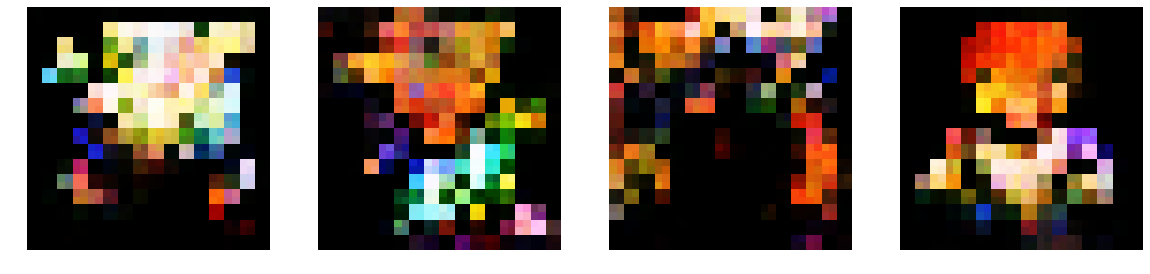

[53/100][18400] Loss_D: 0.043209 0.081236 Loss_G: 0.922995 0.966271 loss_cyc 0.419742 178.054
[53/100][18425] Loss_D: 0.045589 0.042013 Loss_G: 0.884339 0.938122 loss_cyc 0.429352 178.292
[53/100][18450] Loss_D: 0.037964 0.022285 Loss_G: 0.927320 0.985171 loss_cyc 0.434072 178.530
[53/100][18475] Loss_D: 0.030384 0.049026 Loss_G: 0.872299 1.081964 loss_cyc 0.415541 178.774
[53/100][18500] Loss_D: 0.026987 0.039832 Loss_G: 0.907694 1.004186 loss_cyc 0.397956 179.016
[53/100][18525] Loss_D: 0.032484 0.031533 Loss_G: 0.944437 0.942769 loss_cyc 0.407828 179.245
[53/100][18550] Loss_D: 0.027953 0.029699 Loss_G: 0.959335 0.959677 loss_cyc 0.418225 179.479
[53/100][18575] Loss_D: 0.033750 0.029586 Loss_G: 0.914040 1.086159 loss_cyc 0.426245 179.706
[53/100][18600] Loss_D: 0.035709 0.039025 Loss_G: 0.961883 0.957747 loss_cyc 0.414222 179.951
[53/100][18625] Loss_D: 0.040451 0.037110 Loss_G: 0.907349 1.023083 loss_cyc 0.429334 180.189
[53/100][18650] Loss_D: 0.047526 0.050012 Loss_G: 0.946082 1

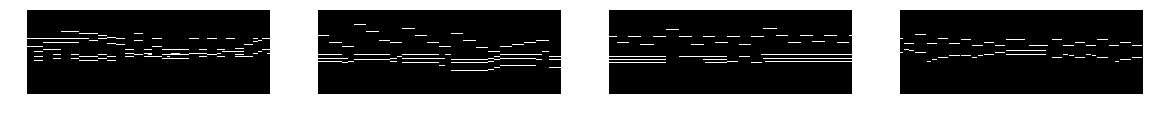

(4, 32, 32, 3)


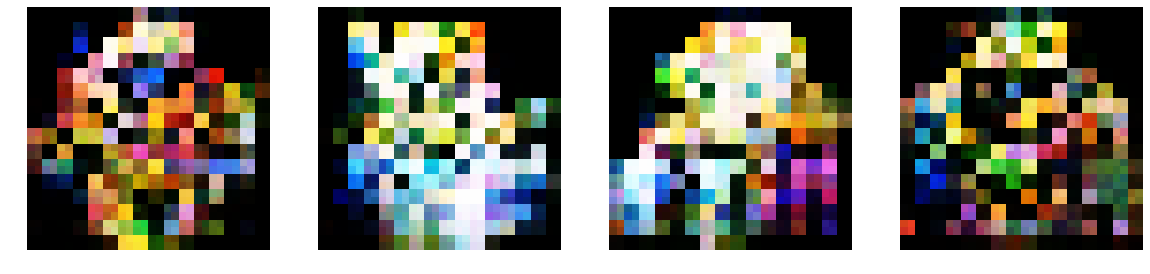

(4, 88, 256, 1)


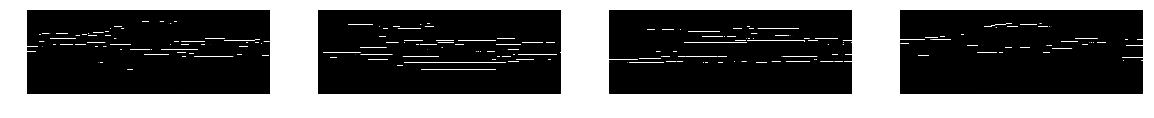

(4, 32, 32, 3)


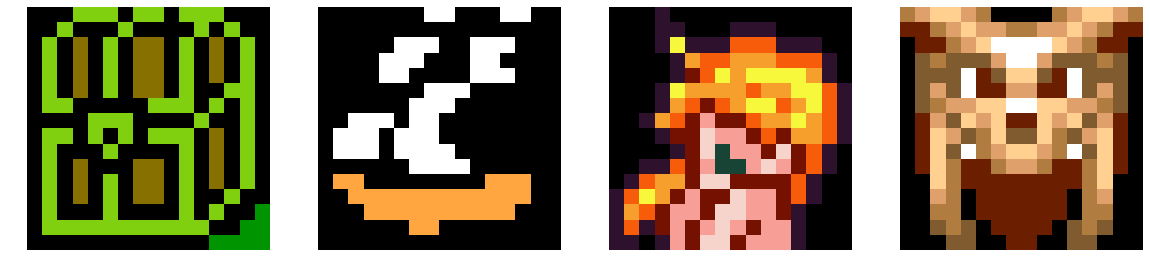

(4, 88, 256, 1)


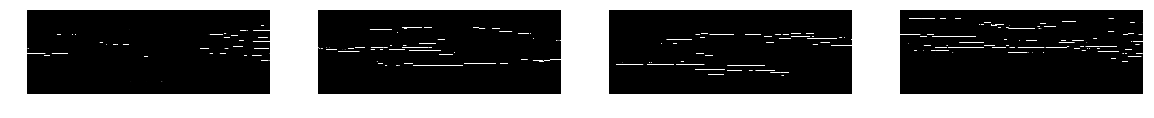

(4, 32, 32, 3)


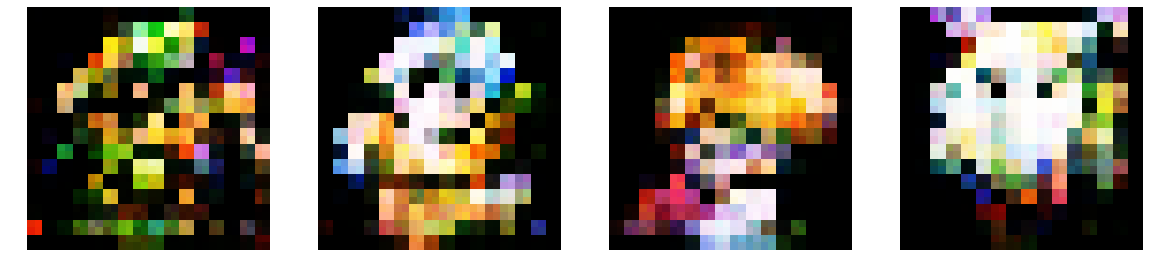

[54/100][18750] Loss_D: 0.047874 0.050218 Loss_G: 0.941120 0.946095 loss_cyc 0.423961 181.436
[54/100][18775] Loss_D: 0.038996 0.041517 Loss_G: 0.845228 0.963680 loss_cyc 0.418181 181.680
[54/100][18800] Loss_D: 0.032349 0.032853 Loss_G: 0.906283 1.032976 loss_cyc 0.391146 181.905
[54/100][18825] Loss_D: 0.049709 0.042709 Loss_G: 0.920067 0.921617 loss_cyc 0.437143 182.147
[54/100][18850] Loss_D: 0.057087 0.035685 Loss_G: 0.814274 1.006621 loss_cyc 0.445478 182.390
[54/100][18875] Loss_D: 0.043655 0.046603 Loss_G: 0.912126 1.069973 loss_cyc 0.435528 182.626
[54/100][18900] Loss_D: 0.027371 0.055966 Loss_G: 0.942430 1.037568 loss_cyc 0.406120 182.864
[54/100][18925] Loss_D: 0.047632 0.026699 Loss_G: 0.893395 1.064974 loss_cyc 0.411626 183.112
[54/100][18950] Loss_D: 0.037702 0.045588 Loss_G: 0.932441 1.003557 loss_cyc 0.410059 183.346
[54/100][18975] Loss_D: 0.040253 0.021027 Loss_G: 0.932906 0.930222 loss_cyc 0.420797 183.577
[54/100][19000] Loss_D: 0.034917 0.026118 Loss_G: 0.906066 1

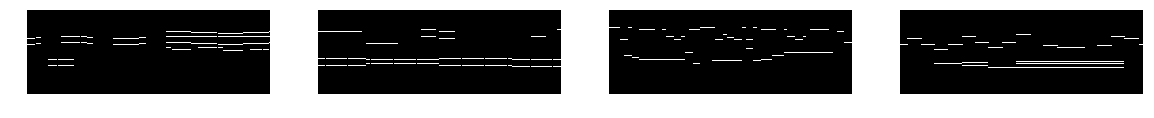

(4, 32, 32, 3)


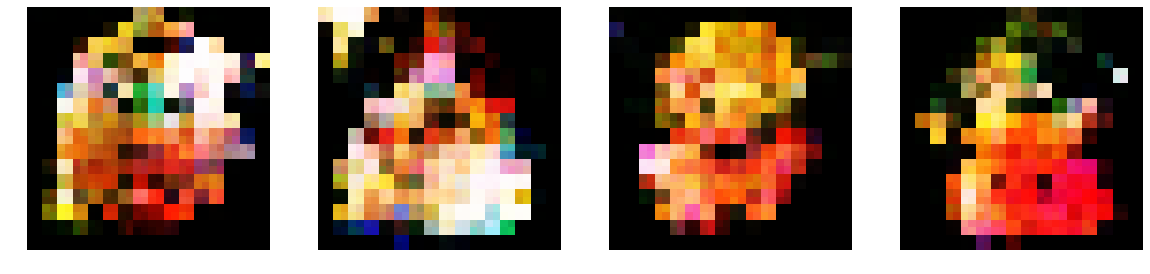

(4, 88, 256, 1)


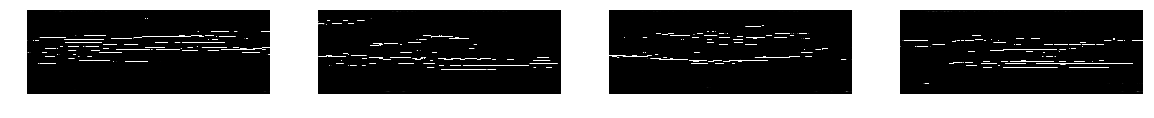

(4, 32, 32, 3)


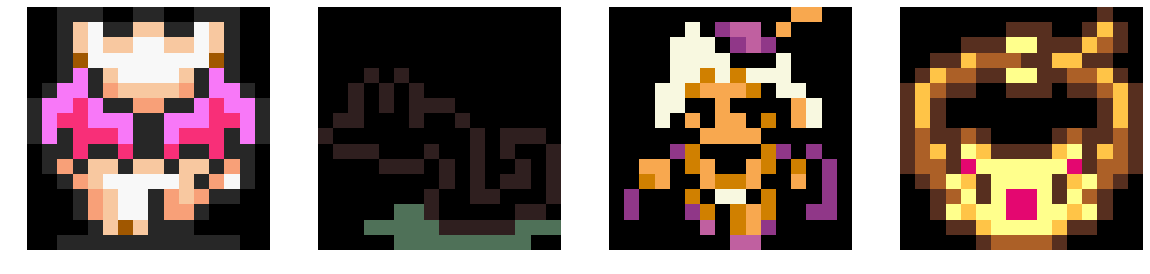

(4, 88, 256, 1)


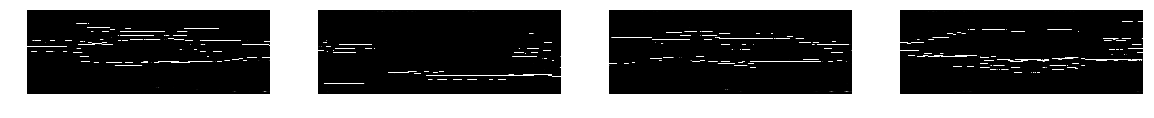

(4, 32, 32, 3)


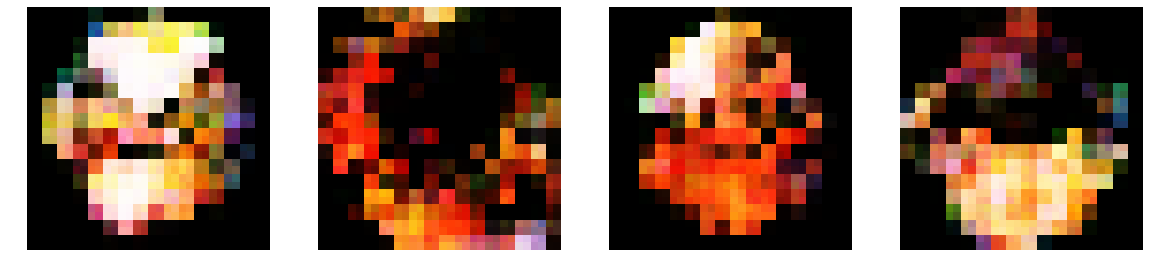

[55/100][19100] Loss_D: 0.041124 0.037126 Loss_G: 0.882370 1.072778 loss_cyc 0.431188 184.818
[55/100][19125] Loss_D: 0.029614 0.030008 Loss_G: 0.942045 1.043410 loss_cyc 0.450978 185.057
[55/100][19150] Loss_D: 0.038425 0.042209 Loss_G: 0.895991 0.981958 loss_cyc 0.445509 185.289
[55/100][19175] Loss_D: 0.032981 0.037152 Loss_G: 0.967647 1.004300 loss_cyc 0.407989 185.520
[55/100][19200] Loss_D: 0.034094 0.040682 Loss_G: 0.949487 0.951489 loss_cyc 0.443597 185.758
[55/100][19225] Loss_D: 0.025732 0.044228 Loss_G: 0.961531 1.008201 loss_cyc 0.457853 186.001
[55/100][19250] Loss_D: 0.025303 0.038910 Loss_G: 0.926718 0.987677 loss_cyc 0.437033 186.244
[55/100][19275] Loss_D: 0.037712 0.043221 Loss_G: 0.914409 0.968982 loss_cyc 0.430827 186.477
[55/100][19300] Loss_D: 0.032579 0.049025 Loss_G: 0.902339 1.005648 loss_cyc 0.434777 186.721
[55/100][19325] Loss_D: 0.027067 0.048873 Loss_G: 0.993845 1.018138 loss_cyc 0.434560 186.969
[55/100][19350] Loss_D: 0.037826 0.053317 Loss_G: 0.923556 0

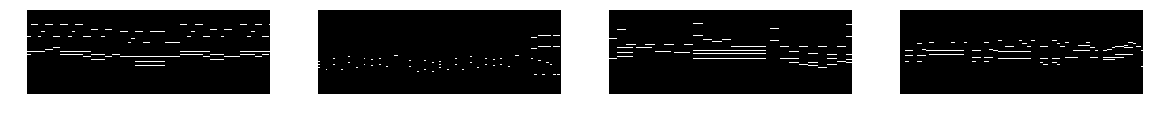

(4, 32, 32, 3)


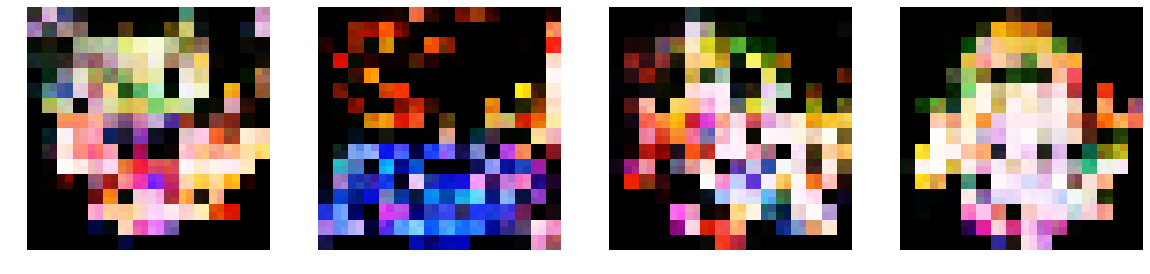

(4, 88, 256, 1)


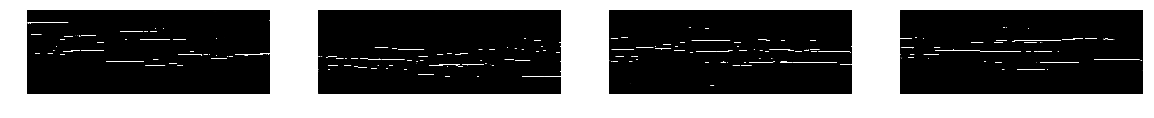

(4, 32, 32, 3)


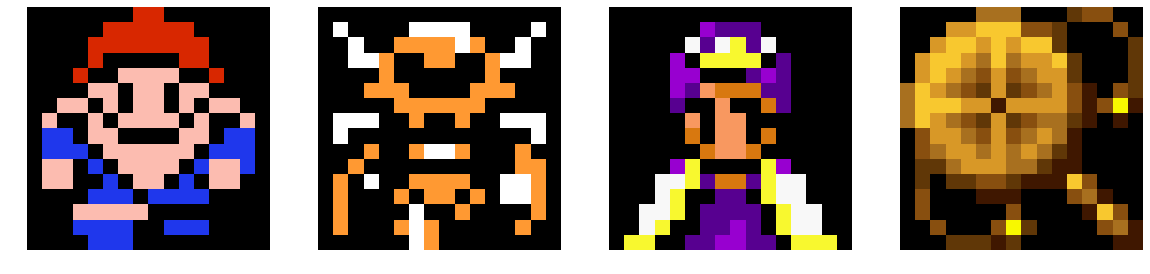

(4, 88, 256, 1)


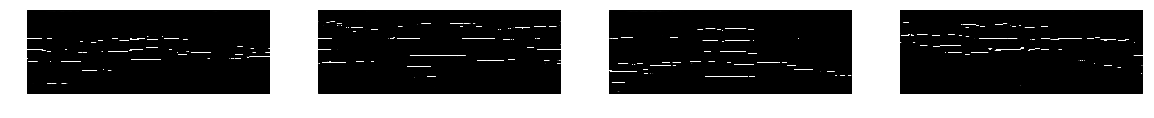

(4, 32, 32, 3)


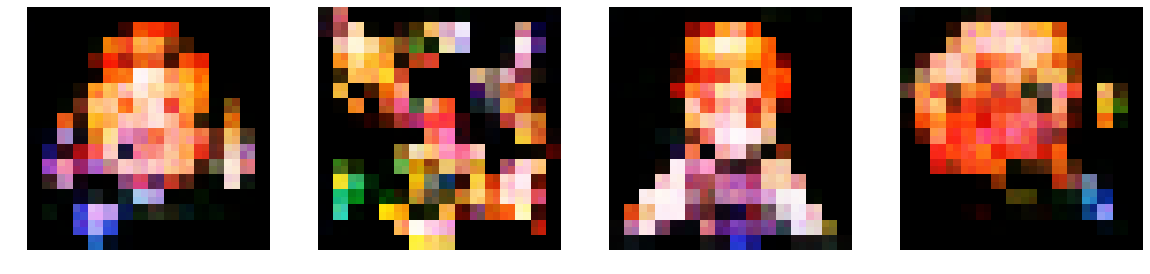

[56/100][19450] Loss_D: 0.022768 0.034992 Loss_G: 0.943566 1.020930 loss_cyc 0.448896 188.191
[56/100][19475] Loss_D: 0.034833 0.042716 Loss_G: 0.927700 0.960656 loss_cyc 0.414514 188.430
[56/100][19500] Loss_D: 0.023091 0.042868 Loss_G: 0.905438 0.951295 loss_cyc 0.405339 188.675
[56/100][19525] Loss_D: 0.026136 0.055849 Loss_G: 0.901363 1.030755 loss_cyc 0.424304 188.917
[56/100][19550] Loss_D: 0.038739 0.034803 Loss_G: 0.899664 1.001072 loss_cyc 0.406978 189.148
[56/100][19575] Loss_D: 0.020530 0.050674 Loss_G: 0.968068 1.004510 loss_cyc 0.409293 189.389
[56/100][19600] Loss_D: 0.023450 0.041015 Loss_G: 0.944871 1.049032 loss_cyc 0.436858 189.631
[56/100][19625] Loss_D: 0.026322 0.043373 Loss_G: 0.941773 0.892836 loss_cyc 0.436700 189.865
[56/100][19650] Loss_D: 0.037658 0.034339 Loss_G: 0.895484 1.069635 loss_cyc 0.409886 190.110
[56/100][19675] Loss_D: 0.037768 0.049281 Loss_G: 0.968654 1.067781 loss_cyc 0.433490 190.348
[56/100][19700] Loss_D: 0.046925 0.029032 Loss_G: 0.901712 1

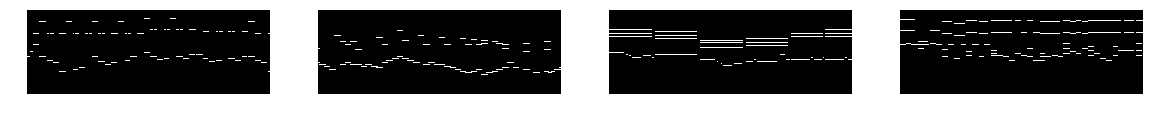

(4, 32, 32, 3)


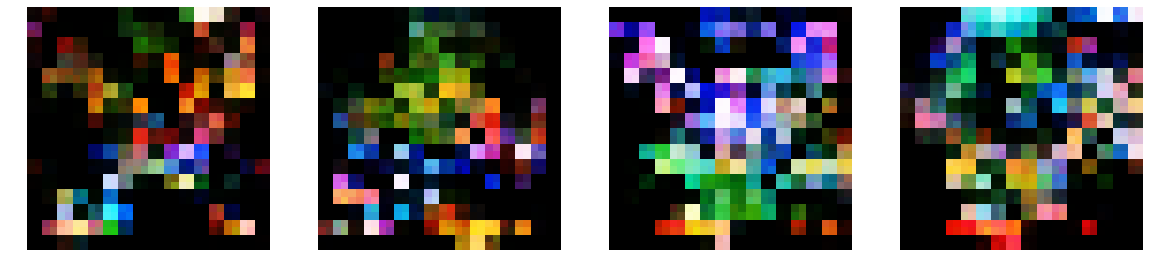

(4, 88, 256, 1)


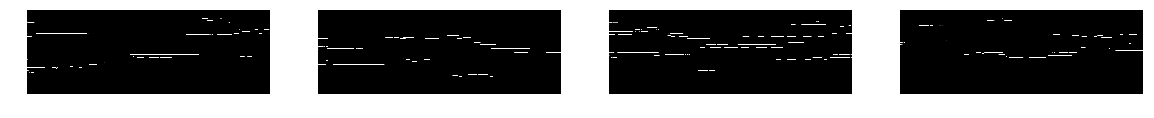

(4, 32, 32, 3)


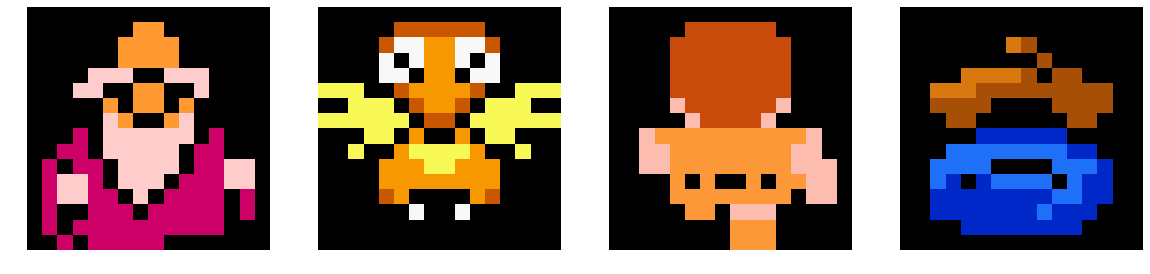

(4, 88, 256, 1)


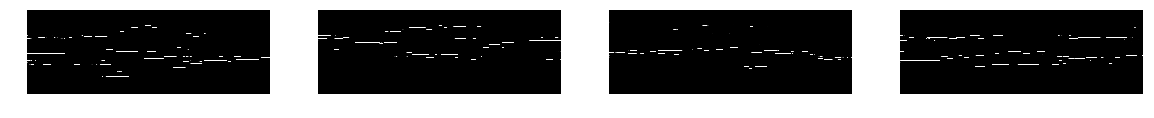

(4, 32, 32, 3)


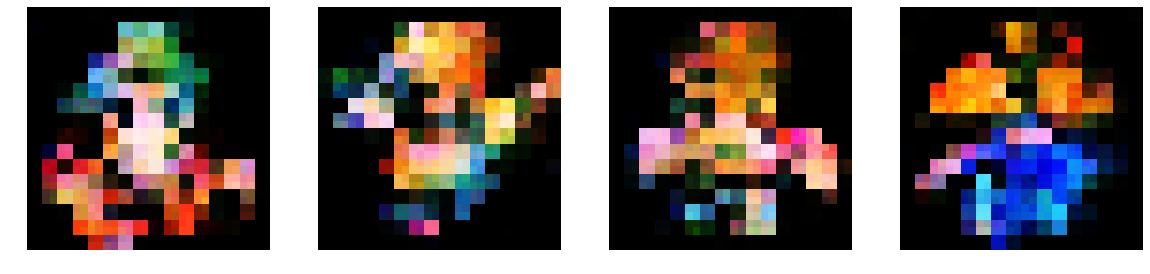

[57/100][19800] Loss_D: 0.021294 0.056297 Loss_G: 0.978042 1.159354 loss_cyc 0.446550 191.569
[57/100][19825] Loss_D: 0.034193 0.022209 Loss_G: 0.939239 0.934782 loss_cyc 0.413051 191.799
[57/100][19850] Loss_D: 0.025788 0.031328 Loss_G: 0.924306 0.988056 loss_cyc 0.423027 192.033
[57/100][19875] Loss_D: 0.023950 0.024761 Loss_G: 0.929026 1.044248 loss_cyc 0.424625 192.264
[57/100][19900] Loss_D: 0.014191 0.058294 Loss_G: 0.950011 0.946687 loss_cyc 0.419494 192.514
[57/100][19925] Loss_D: 0.026027 0.030337 Loss_G: 0.899682 1.029599 loss_cyc 0.425263 192.747
[57/100][19950] Loss_D: 0.048395 0.018730 Loss_G: 0.882951 0.967695 loss_cyc 0.408794 192.986
[57/100][19975] Loss_D: 0.032543 0.065611 Loss_G: 0.886423 0.977989 loss_cyc 0.396753 193.217
[57/100][20000] Loss_D: 0.033919 0.022576 Loss_G: 0.957174 0.931293 loss_cyc 0.400148 193.462
[57/100][20025] Loss_D: 0.037088 0.021278 Loss_G: 0.958247 0.951745 loss_cyc 0.456188 193.692
[57/100][20050] Loss_D: 0.054096 0.052544 Loss_G: 0.859126 1

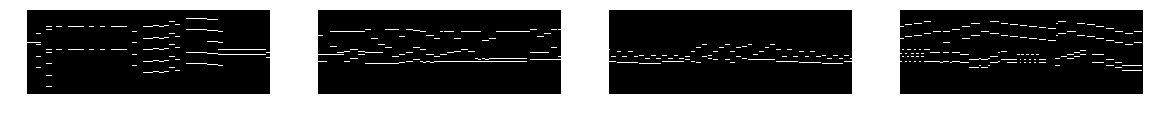

(4, 32, 32, 3)


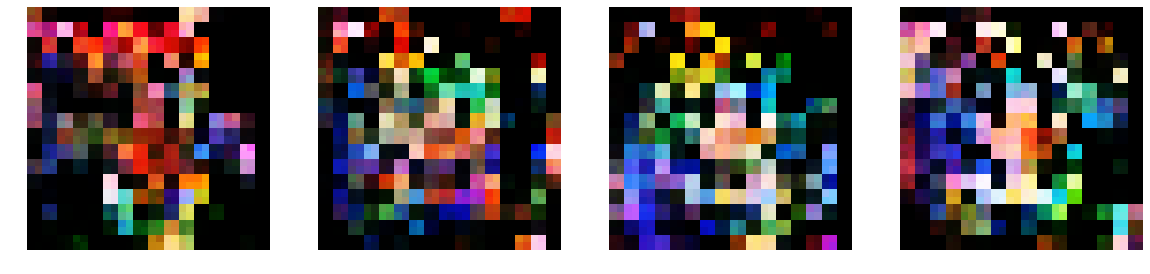

(4, 88, 256, 1)


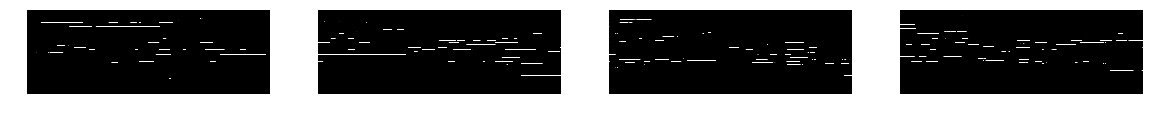

(4, 32, 32, 3)


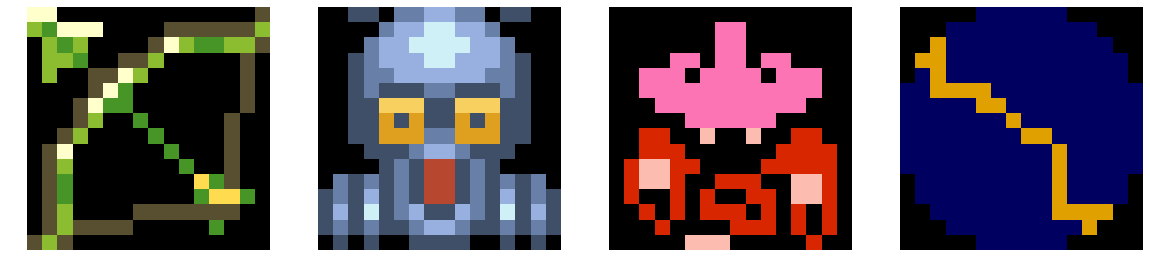

(4, 88, 256, 1)


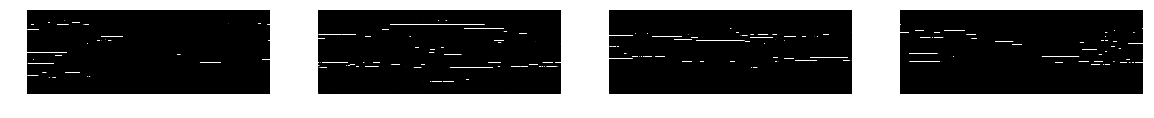

(4, 32, 32, 3)


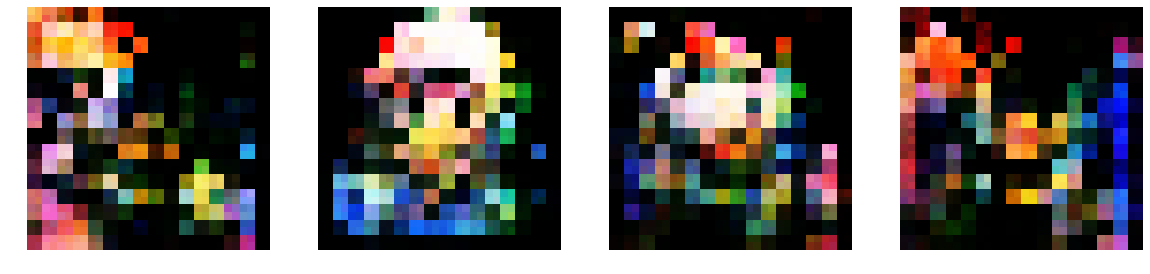

[58/100][20150] Loss_D: 0.047187 0.037073 Loss_G: 0.886048 1.039186 loss_cyc 0.415600 194.962
[58/100][20175] Loss_D: 0.041787 0.033312 Loss_G: 0.879614 0.989942 loss_cyc 0.405797 195.197
[58/100][20200] Loss_D: 0.081312 0.031660 Loss_G: 0.869409 0.991707 loss_cyc 0.413871 195.443
[58/100][20225] Loss_D: 0.046915 0.024657 Loss_G: 0.855885 0.977326 loss_cyc 0.425484 195.685
[58/100][20250] Loss_D: 0.036411 0.036545 Loss_G: 0.902391 0.984060 loss_cyc 0.439372 195.911
[58/100][20275] Loss_D: 0.044395 0.032389 Loss_G: 0.912792 1.052307 loss_cyc 0.428510 196.151
[58/100][20300] Loss_D: 0.042412 0.025916 Loss_G: 0.872770 1.012737 loss_cyc 0.404994 196.388
[58/100][20325] Loss_D: 0.052948 0.034333 Loss_G: 0.846741 0.972901 loss_cyc 0.431129 196.620
[58/100][20350] Loss_D: 0.051408 0.051535 Loss_G: 0.949986 1.083008 loss_cyc 0.467315 196.859
[58/100][20375] Loss_D: 0.044308 0.049988 Loss_G: 0.882819 0.997433 loss_cyc 0.424209 197.093
[58/100][20400] Loss_D: 0.042372 0.045260 Loss_G: 0.934239 0

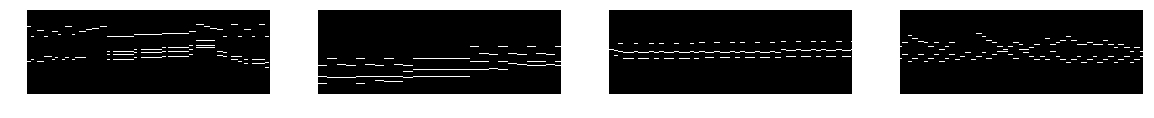

(4, 32, 32, 3)


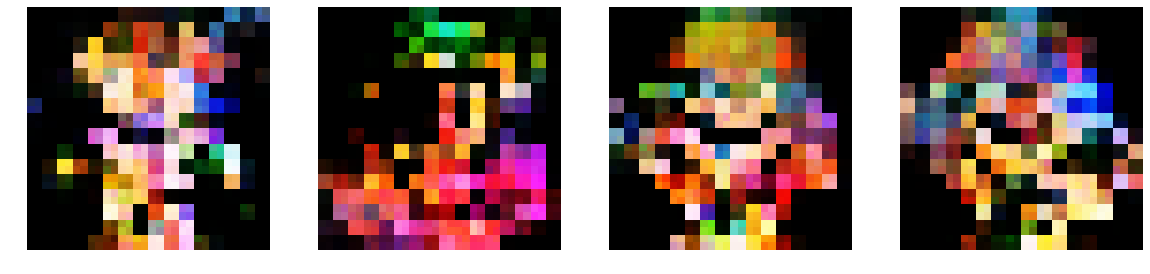

(4, 88, 256, 1)


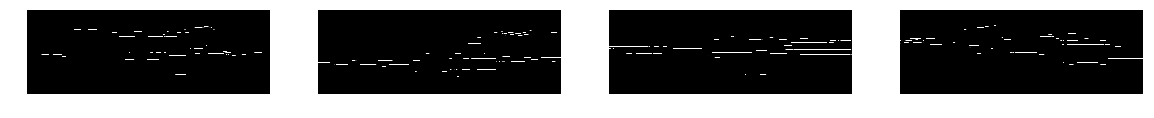

(4, 32, 32, 3)


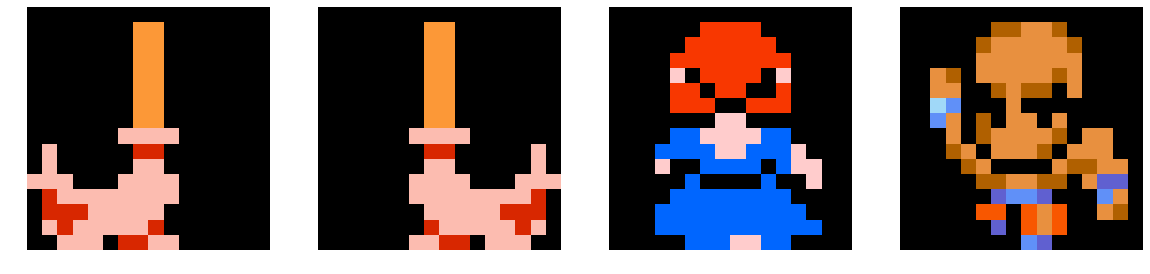

(4, 88, 256, 1)


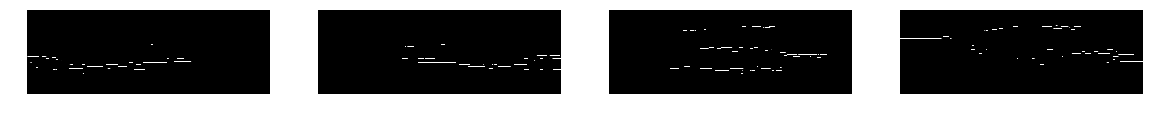

(4, 32, 32, 3)


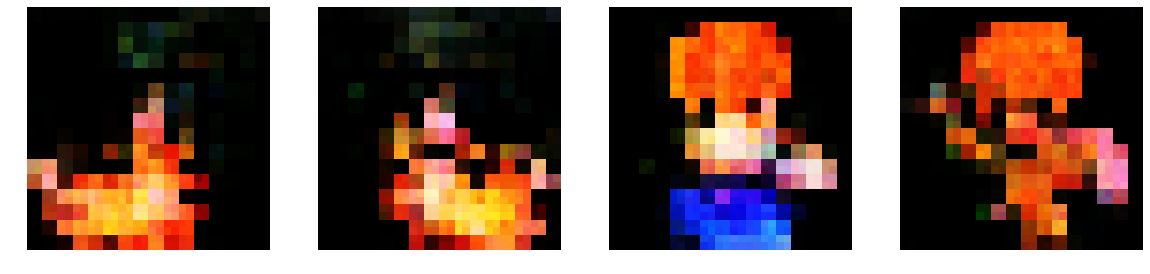

[59/100][20500] Loss_D: 0.025540 0.038988 Loss_G: 0.940137 0.963830 loss_cyc 0.423882 198.339
[59/100][20525] Loss_D: 0.031682 0.038818 Loss_G: 0.894035 1.043706 loss_cyc 0.403196 198.571
[59/100][20550] Loss_D: 0.035703 0.034917 Loss_G: 0.908848 1.006223 loss_cyc 0.400150 198.804
[59/100][20575] Loss_D: 0.042997 0.032033 Loss_G: 0.895874 1.063268 loss_cyc 0.391550 199.040
[59/100][20600] Loss_D: 0.027769 0.026026 Loss_G: 0.961389 1.019240 loss_cyc 0.409225 199.274
[59/100][20625] Loss_D: 0.038278 0.024758 Loss_G: 0.913834 1.049692 loss_cyc 0.397065 199.516
[59/100][20650] Loss_D: 0.039003 0.027708 Loss_G: 0.901383 1.061335 loss_cyc 0.409221 199.760
[59/100][20675] Loss_D: 0.039321 0.033235 Loss_G: 0.875704 0.998367 loss_cyc 0.416518 199.995
[59/100][20700] Loss_D: 0.024710 0.035274 Loss_G: 0.981459 1.023096 loss_cyc 0.431025 200.235
[59/100][20725] Loss_D: 0.037414 0.035616 Loss_G: 0.921408 0.995731 loss_cyc 0.434386 200.478
[59/100][20750] Loss_D: 0.040447 0.040696 Loss_G: 0.924302 0

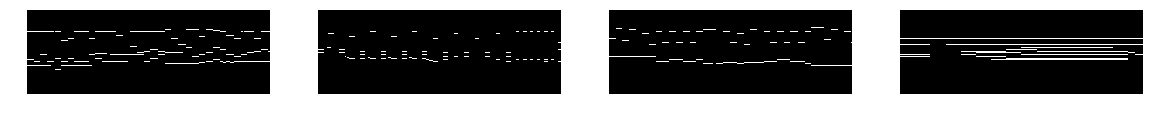

(4, 32, 32, 3)


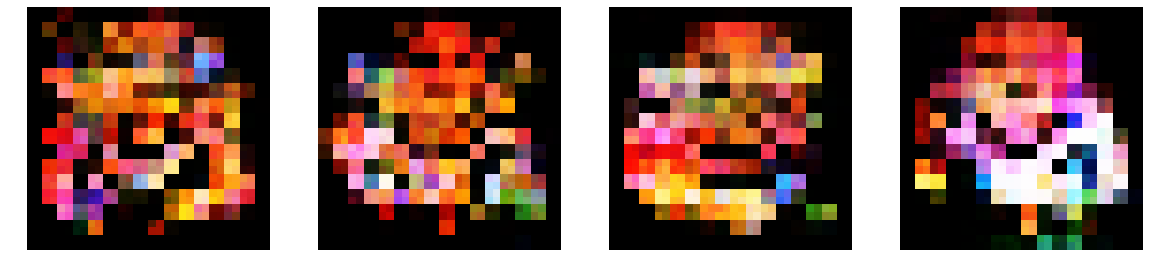

(4, 88, 256, 1)


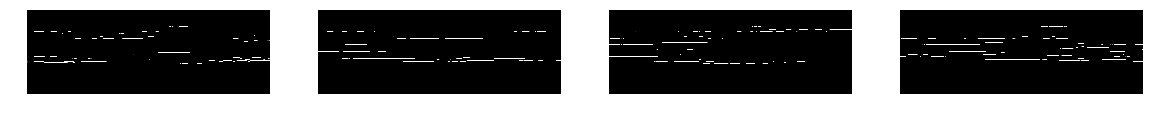

(4, 32, 32, 3)


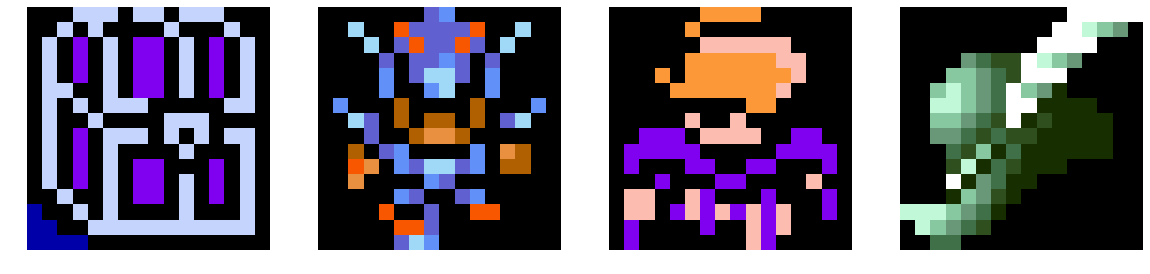

(4, 88, 256, 1)


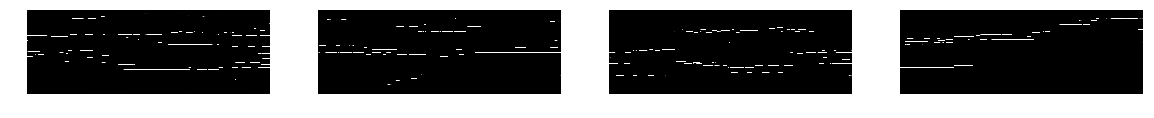

(4, 32, 32, 3)


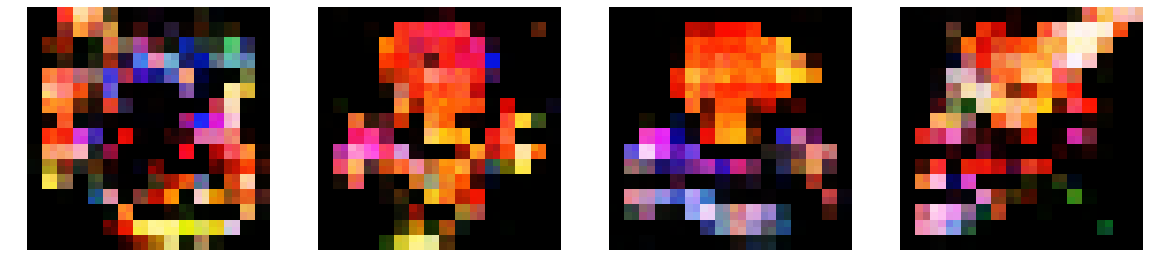

[60/100][20825] Loss_D: 0.036211 0.039422 Loss_G: 0.934532 0.952946 loss_cyc 0.406990 201.476
[60/100][20850] Loss_D: 0.044623 0.024955 Loss_G: 0.915517 0.950410 loss_cyc 0.403543 201.705
[60/100][20875] Loss_D: 0.055750 0.052426 Loss_G: 0.898997 0.936344 loss_cyc 0.413940 201.936
[60/100][20900] Loss_D: 0.027925 0.029751 Loss_G: 0.959658 1.027812 loss_cyc 0.397858 202.166
[60/100][20925] Loss_D: 0.064024 0.046268 Loss_G: 0.867678 1.033404 loss_cyc 0.419316 202.410
[60/100][20950] Loss_D: 0.024650 0.045734 Loss_G: 0.980086 0.971371 loss_cyc 0.437274 202.654
[60/100][20975] Loss_D: 0.048926 0.032229 Loss_G: 0.899232 0.933587 loss_cyc 0.394826 202.891
[60/100][21000] Loss_D: 0.042001 0.054744 Loss_G: 0.900411 1.025540 loss_cyc 0.395262 203.123
[60/100][21025] Loss_D: 0.037408 0.038691 Loss_G: 0.947920 1.025597 loss_cyc 0.417917 203.350
[60/100][21050] Loss_D: 0.046017 0.037751 Loss_G: 0.893272 0.996583 loss_cyc 0.425389 203.585
[60/100][21075] Loss_D: 0.031694 0.035759 Loss_G: 0.945936 0

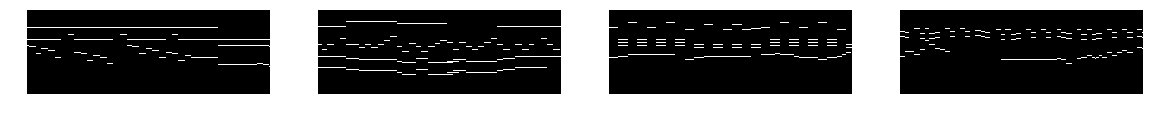

(4, 32, 32, 3)


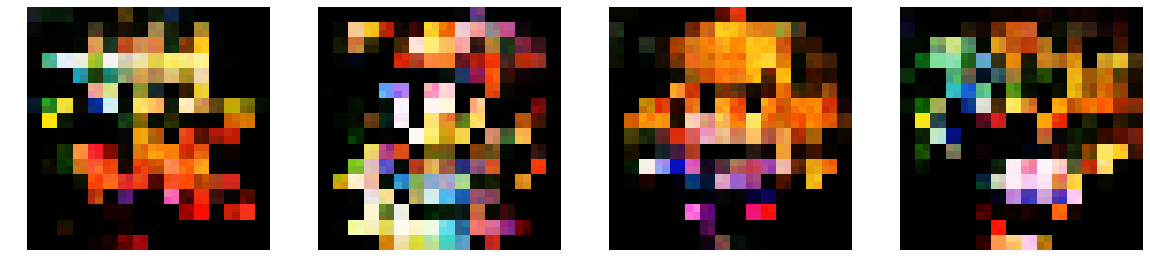

(4, 88, 256, 1)


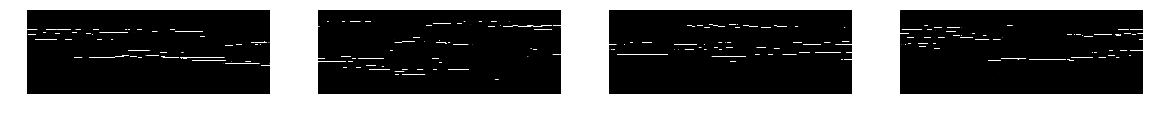

(4, 32, 32, 3)


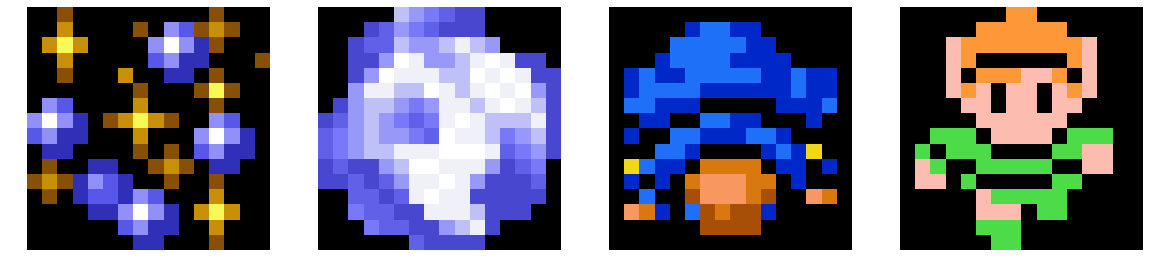

(4, 88, 256, 1)


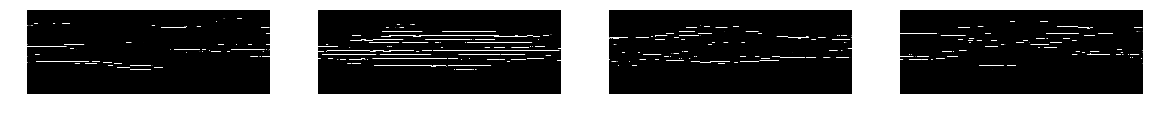

(4, 32, 32, 3)


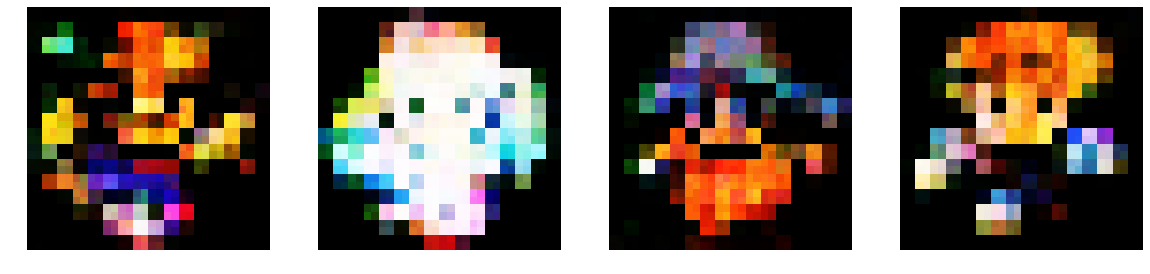

[61/100][21175] Loss_D: 0.033352 0.036424 Loss_G: 0.945933 1.036908 loss_cyc 0.401085 204.849
[61/100][21200] Loss_D: 0.038291 0.044127 Loss_G: 0.881903 0.934125 loss_cyc 0.409461 205.095
[61/100][21225] Loss_D: 0.049092 0.032565 Loss_G: 0.870666 0.912503 loss_cyc 0.404250 205.340
[61/100][21250] Loss_D: 0.036837 0.034275 Loss_G: 0.912319 1.004204 loss_cyc 0.403430 205.575
[61/100][21275] Loss_D: 0.027708 0.021646 Loss_G: 0.959806 1.032488 loss_cyc 0.403962 205.805
[61/100][21300] Loss_D: 0.036905 0.040146 Loss_G: 0.917422 1.002613 loss_cyc 0.413570 206.031
[61/100][21325] Loss_D: 0.038560 0.035714 Loss_G: 0.922152 1.005986 loss_cyc 0.409566 206.265
[61/100][21350] Loss_D: 0.049315 0.029286 Loss_G: 0.890495 1.099249 loss_cyc 0.409539 206.499
[61/100][21375] Loss_D: 0.025072 0.061129 Loss_G: 0.890283 0.938945 loss_cyc 0.421039 206.741
[61/100][21400] Loss_D: 0.035833 0.032028 Loss_G: 0.952074 0.979157 loss_cyc 0.431889 206.964
[61/100][21425] Loss_D: 0.023793 0.066749 Loss_G: 0.936307 0

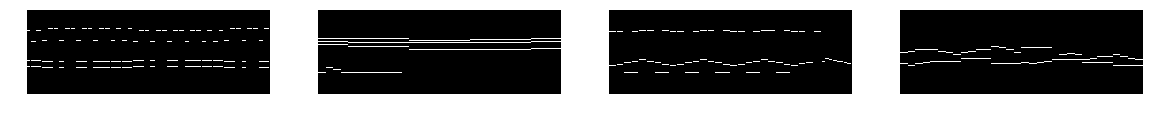

(4, 32, 32, 3)


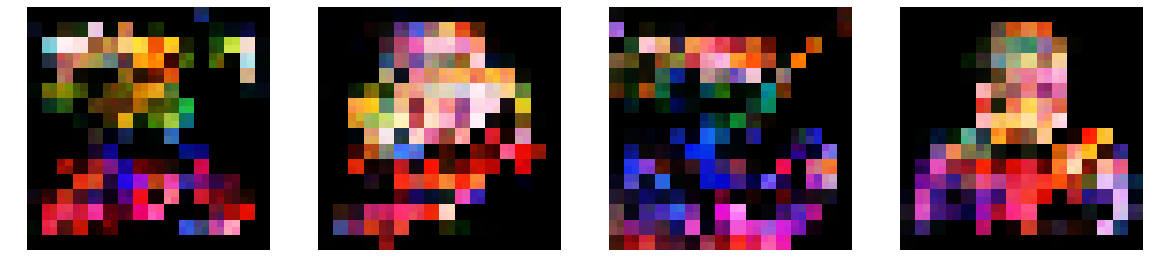

(4, 88, 256, 1)


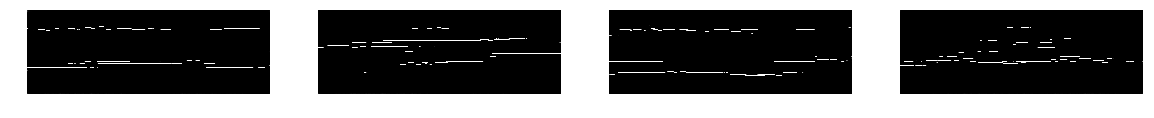

(4, 32, 32, 3)


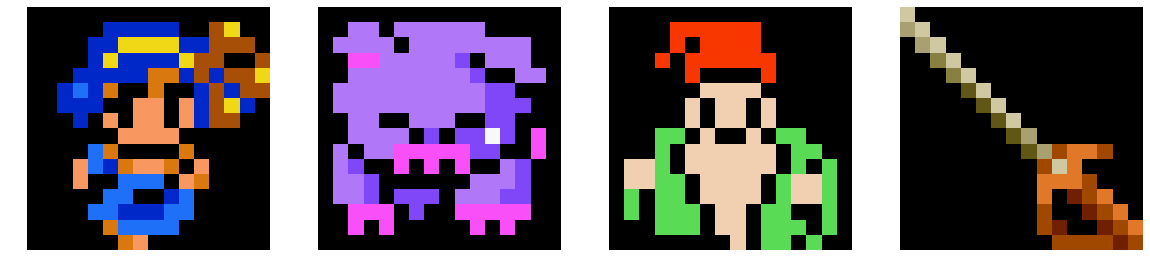

(4, 88, 256, 1)


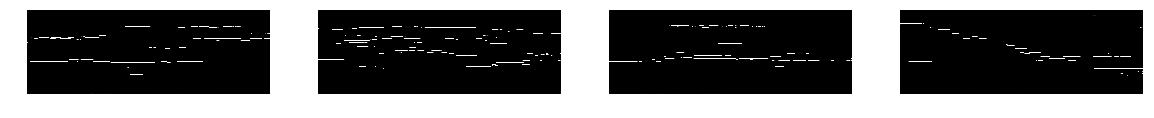

(4, 32, 32, 3)


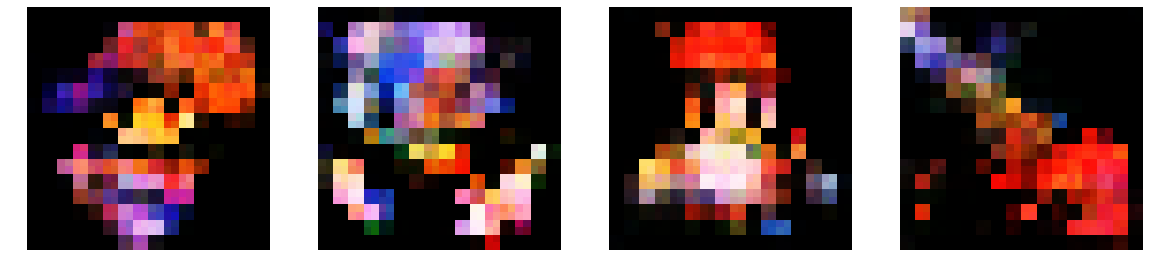

[62/100][21525] Loss_D: 0.033245 0.028773 Loss_G: 0.895835 1.022711 loss_cyc 0.433295 208.217
[62/100][21550] Loss_D: 0.029572 0.038943 Loss_G: 0.942145 0.960208 loss_cyc 0.410848 208.451
[62/100][21575] Loss_D: 0.019529 0.034457 Loss_G: 0.945997 1.051799 loss_cyc 0.415788 208.685
[62/100][21600] Loss_D: 0.031333 0.045846 Loss_G: 0.923117 1.054747 loss_cyc 0.427442 208.914
[62/100][21625] Loss_D: 0.026888 0.032326 Loss_G: 0.908208 1.072839 loss_cyc 0.445315 209.155
[62/100][21650] Loss_D: 0.030596 0.051727 Loss_G: 0.943507 0.927480 loss_cyc 0.423389 209.390
[62/100][21675] Loss_D: 0.024957 0.027209 Loss_G: 0.969858 0.981244 loss_cyc 0.425641 209.641
[62/100][21700] Loss_D: 0.039195 0.034473 Loss_G: 0.925202 1.059442 loss_cyc 0.397925 209.880
[62/100][21725] Loss_D: 0.045700 0.036176 Loss_G: 0.901016 1.044223 loss_cyc 0.414772 210.112
[62/100][21750] Loss_D: 0.032852 0.027541 Loss_G: 0.925916 0.921314 loss_cyc 0.437701 210.345
[62/100][21775] Loss_D: 0.038180 0.025145 Loss_G: 0.906384 0

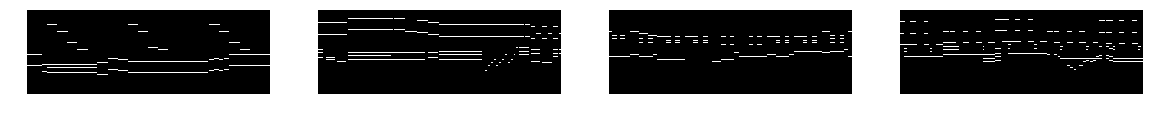

(4, 32, 32, 3)


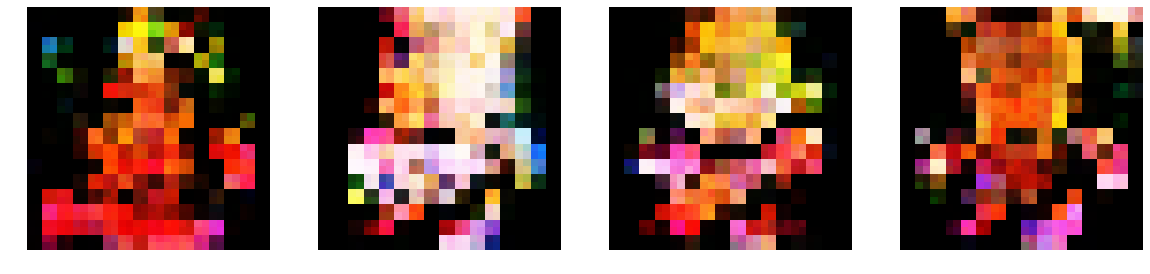

(4, 88, 256, 1)


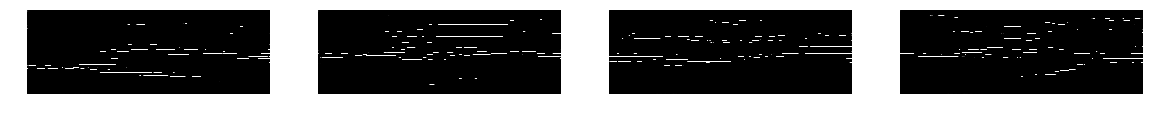

(4, 32, 32, 3)


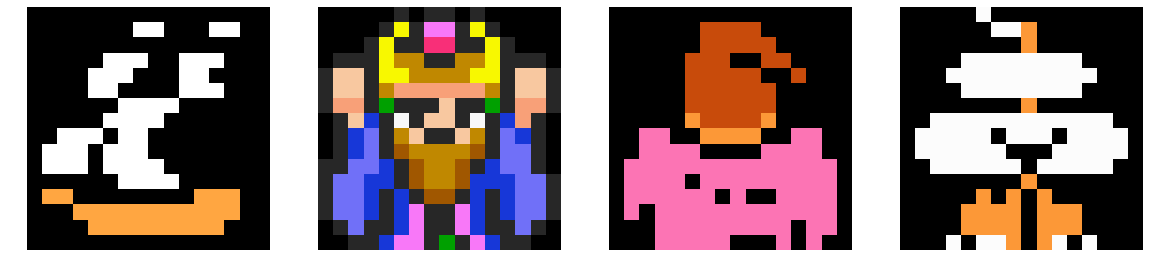

(4, 88, 256, 1)


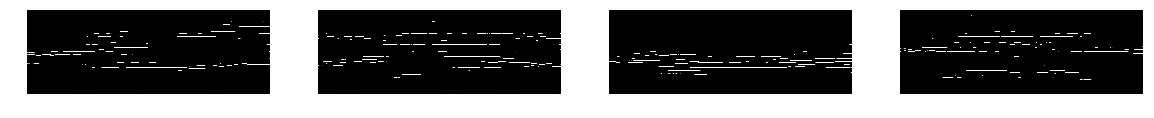

(4, 32, 32, 3)


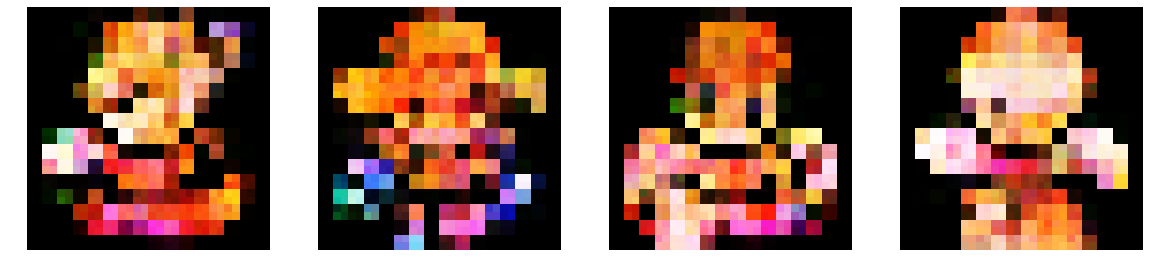

[63/100][21875] Loss_D: 0.019786 0.045127 Loss_G: 0.932644 1.046517 loss_cyc 0.385456 211.584
[63/100][21900] Loss_D: 0.036037 0.025129 Loss_G: 0.920750 0.943113 loss_cyc 0.418071 211.814
[63/100][21925] Loss_D: 0.053580 0.030964 Loss_G: 0.932174 1.008314 loss_cyc 0.424953 212.043
[63/100][21950] Loss_D: 0.048341 0.023908 Loss_G: 0.898618 0.954456 loss_cyc 0.422398 212.275
[63/100][21975] Loss_D: 0.039626 0.032917 Loss_G: 0.941692 1.004676 loss_cyc 0.412397 212.511
[63/100][22000] Loss_D: 0.044399 0.019908 Loss_G: 0.909951 0.997331 loss_cyc 0.416924 212.742
[63/100][22025] Loss_D: 0.045439 0.025801 Loss_G: 0.904705 0.907397 loss_cyc 0.404830 212.981
[63/100][22050] Loss_D: 0.041739 0.017013 Loss_G: 0.920823 0.985277 loss_cyc 0.405034 213.206
[63/100][22075] Loss_D: 0.071386 0.027156 Loss_G: 0.831880 0.978908 loss_cyc 0.405889 213.445
[63/100][22100] Loss_D: 0.034895 0.042315 Loss_G: 0.908715 1.008715 loss_cyc 0.400896 213.686
[63/100][22125] Loss_D: 0.053265 0.019943 Loss_G: 0.931447 0

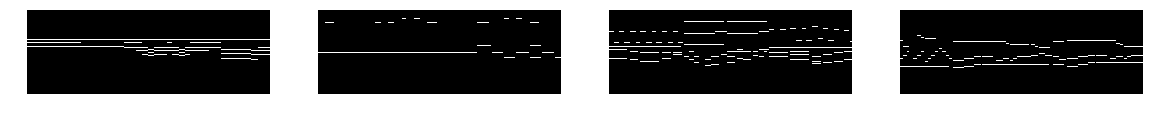

(4, 32, 32, 3)


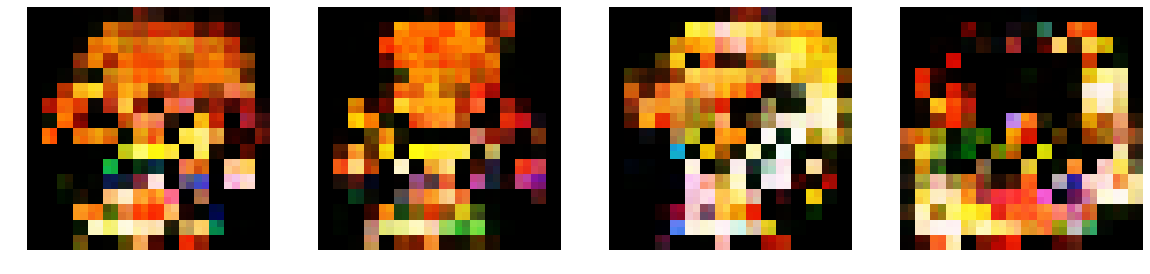

(4, 88, 256, 1)


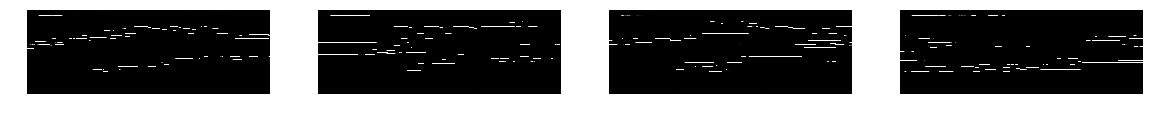

(4, 32, 32, 3)


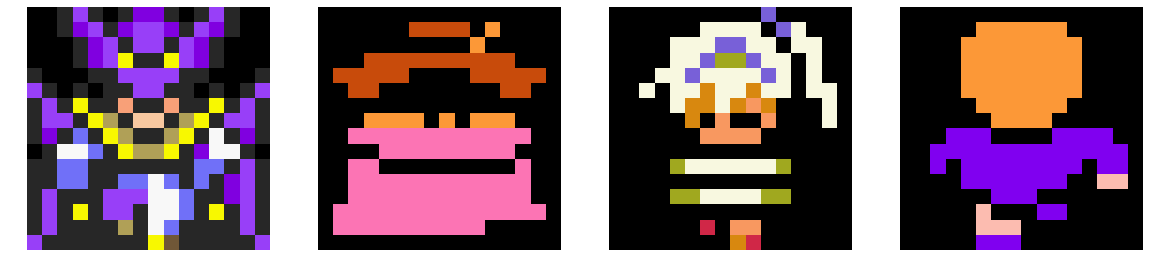

(4, 88, 256, 1)


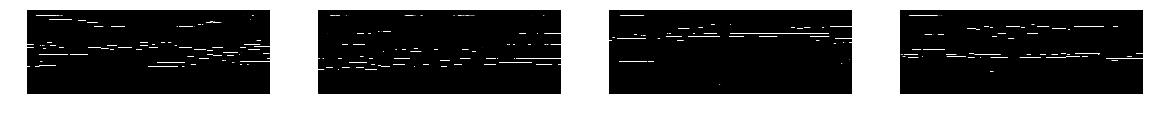

(4, 32, 32, 3)


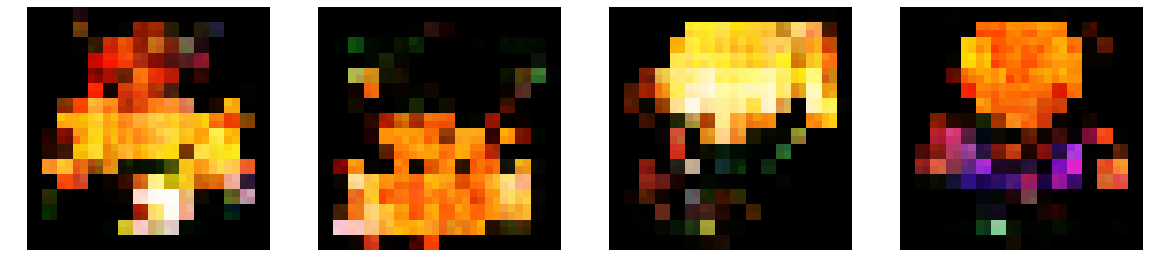

[64/100][22225] Loss_D: 0.047273 0.039356 Loss_G: 0.890606 1.014860 loss_cyc 0.410555 214.956
[64/100][22250] Loss_D: 0.028618 0.025571 Loss_G: 0.936627 1.095784 loss_cyc 0.429743 215.190
[64/100][22275] Loss_D: 0.028012 0.035613 Loss_G: 0.961717 0.948890 loss_cyc 0.425380 215.430
[64/100][22300] Loss_D: 0.024497 0.036869 Loss_G: 0.951213 1.008505 loss_cyc 0.395961 215.669
[64/100][22325] Loss_D: 0.035021 0.057047 Loss_G: 0.963284 1.054425 loss_cyc 0.421142 215.910
[64/100][22350] Loss_D: 0.033506 0.037047 Loss_G: 0.931647 1.017362 loss_cyc 0.429294 216.134
[64/100][22375] Loss_D: 0.049857 0.036474 Loss_G: 0.900391 0.945206 loss_cyc 0.420430 216.372
[64/100][22400] Loss_D: 0.026125 0.017435 Loss_G: 0.921568 1.047255 loss_cyc 0.437151 216.609
[64/100][22425] Loss_D: 0.018768 0.031704 Loss_G: 0.882584 0.945186 loss_cyc 0.419089 216.849
[64/100][22450] Loss_D: 0.019676 0.024987 Loss_G: 0.932895 1.064546 loss_cyc 0.406333 217.079
[64/100][22475] Loss_D: 0.041613 0.031199 Loss_G: 0.908547 1

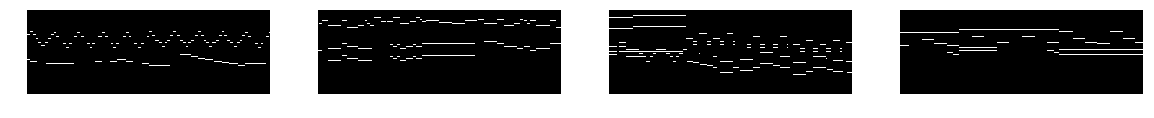

(4, 32, 32, 3)


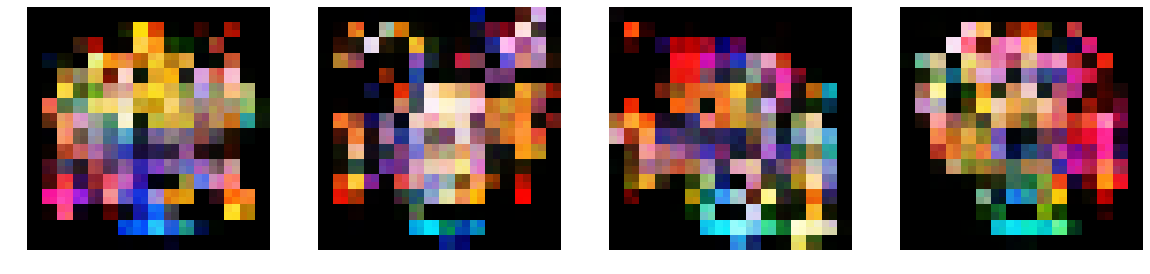

(4, 88, 256, 1)


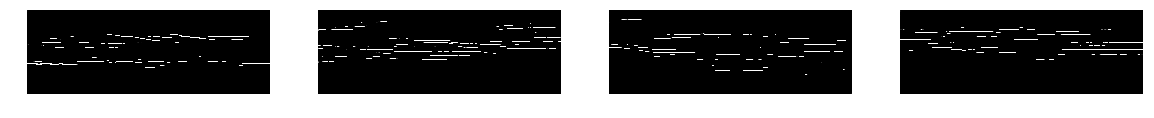

(4, 32, 32, 3)


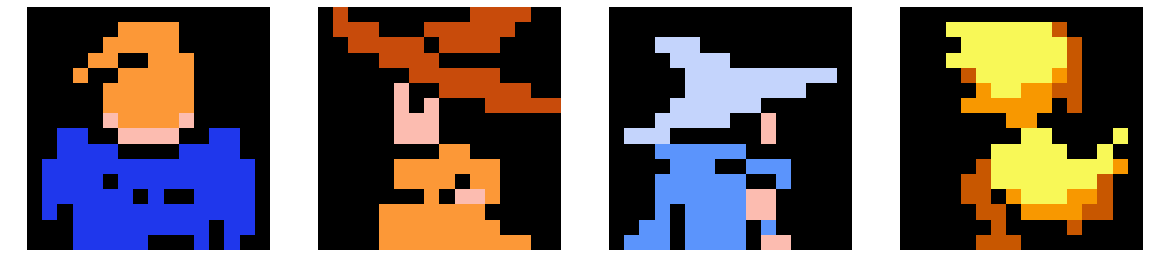

(4, 88, 256, 1)


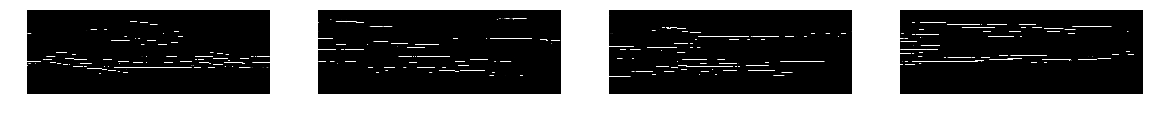

(4, 32, 32, 3)


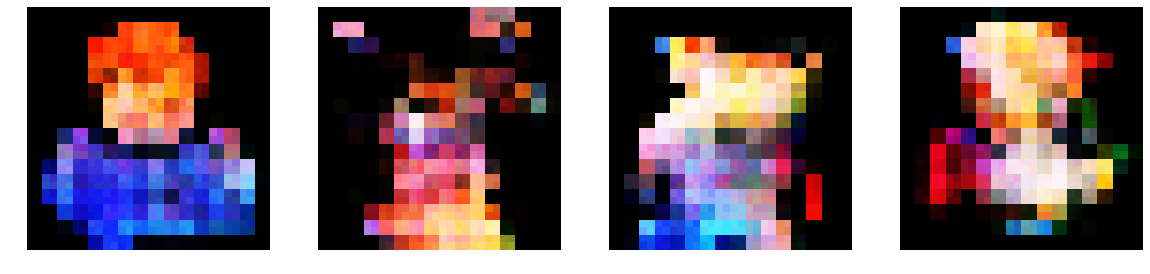

[65/100][22575] Loss_D: 0.032383 0.030553 Loss_G: 0.903279 1.007953 loss_cyc 0.400724 218.338
[65/100][22600] Loss_D: 0.020753 0.044926 Loss_G: 0.942735 1.005014 loss_cyc 0.400636 218.573
[65/100][22625] Loss_D: 0.025634 0.038265 Loss_G: 0.895992 0.987014 loss_cyc 0.395611 218.813
[65/100][22650] Loss_D: 0.023887 0.021847 Loss_G: 0.978577 0.997535 loss_cyc 0.430676 219.053
[65/100][22675] Loss_D: 0.031041 0.034680 Loss_G: 0.858626 0.988006 loss_cyc 0.399203 219.288
[65/100][22700] Loss_D: 0.022462 0.032746 Loss_G: 0.992509 0.991992 loss_cyc 0.396655 219.519
[65/100][22725] Loss_D: 0.017922 0.041223 Loss_G: 0.967130 0.999244 loss_cyc 0.435201 219.758
[65/100][22750] Loss_D: 0.026303 0.035620 Loss_G: 0.883481 1.041022 loss_cyc 0.432866 219.994
[65/100][22775] Loss_D: 0.017076 0.033600 Loss_G: 0.961930 1.034215 loss_cyc 0.431044 220.230
[65/100][22800] Loss_D: 0.020377 0.028957 Loss_G: 0.959296 1.007060 loss_cyc 0.387967 220.463
[65/100][22825] Loss_D: 0.030396 0.041195 Loss_G: 0.958857 0

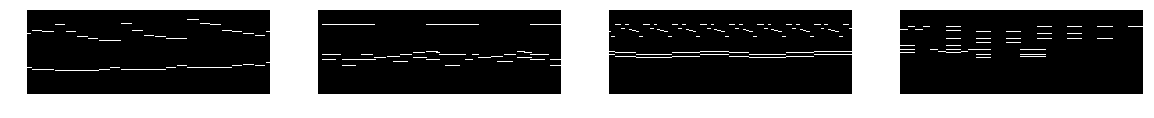

(4, 32, 32, 3)


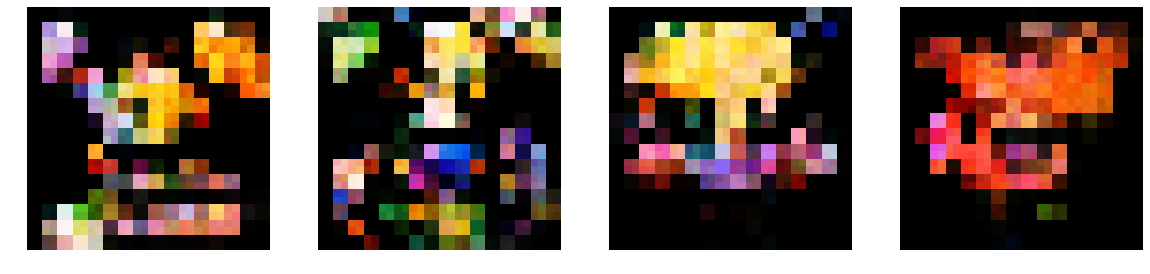

(4, 88, 256, 1)


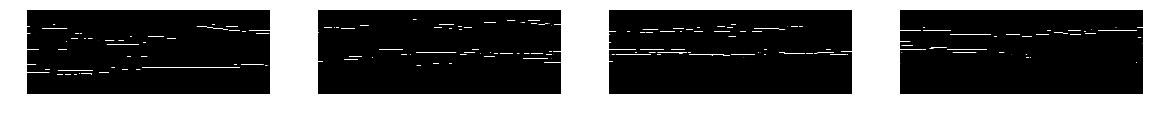

(4, 32, 32, 3)


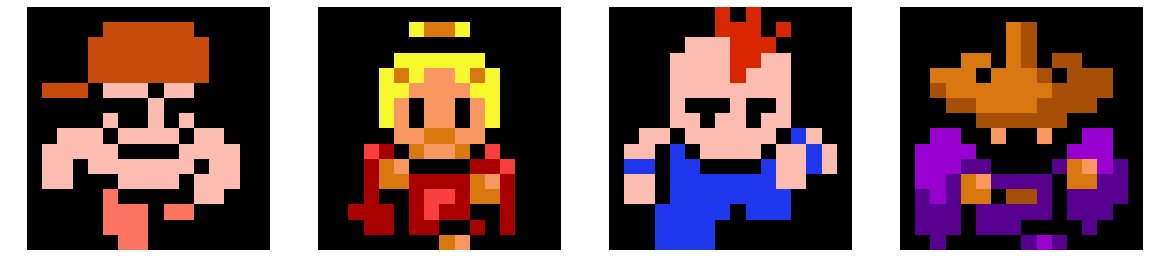

(4, 88, 256, 1)


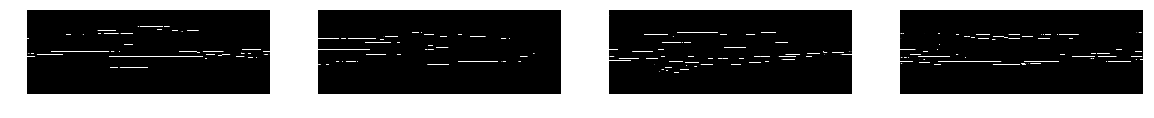

(4, 32, 32, 3)


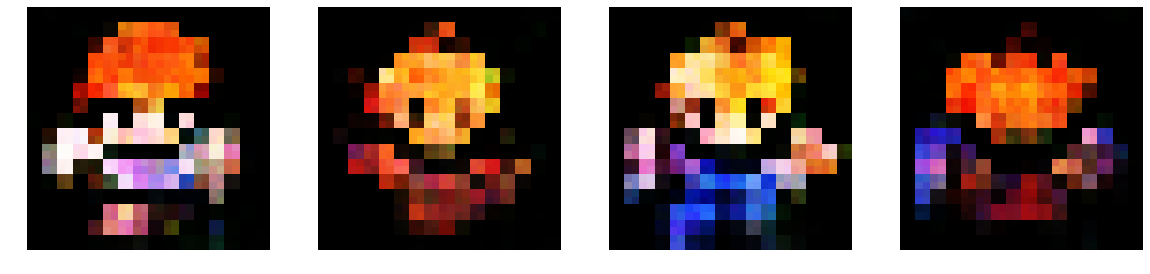

[66/100][22925] Loss_D: 0.026232 0.035134 Loss_G: 0.947057 0.995441 loss_cyc 0.397530 221.710
[66/100][22950] Loss_D: 0.023691 0.037256 Loss_G: 0.949661 0.969368 loss_cyc 0.379321 221.954
[66/100][22975] Loss_D: 0.035541 0.024458 Loss_G: 0.937964 1.030658 loss_cyc 0.392991 222.186
[66/100][23000] Loss_D: 0.031807 0.033785 Loss_G: 0.905077 0.954086 loss_cyc 0.395702 222.424
[66/100][23025] Loss_D: 0.030076 0.034120 Loss_G: 0.929844 0.979095 loss_cyc 0.406927 222.646
[66/100][23050] Loss_D: 0.038206 0.031590 Loss_G: 0.952335 1.011131 loss_cyc 0.441936 222.887
[66/100][23075] Loss_D: 0.018602 0.025122 Loss_G: 0.932898 0.968590 loss_cyc 0.369539 223.117
[66/100][23100] Loss_D: 0.016373 0.021894 Loss_G: 0.909359 0.976265 loss_cyc 0.406617 223.353
[66/100][23125] Loss_D: 0.032683 0.040923 Loss_G: 0.884463 1.032205 loss_cyc 0.413984 223.589
[66/100][23150] Loss_D: 0.027202 0.019318 Loss_G: 0.969950 0.997756 loss_cyc 0.392378 223.816
[66/100][23175] Loss_D: 0.016727 0.018909 Loss_G: 0.971900 0

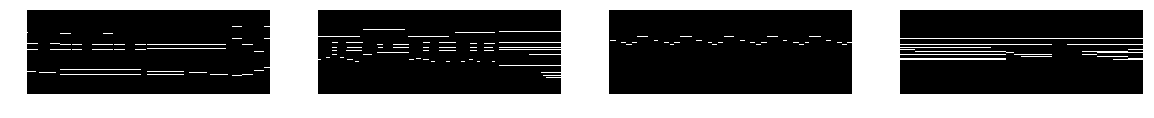

(4, 32, 32, 3)


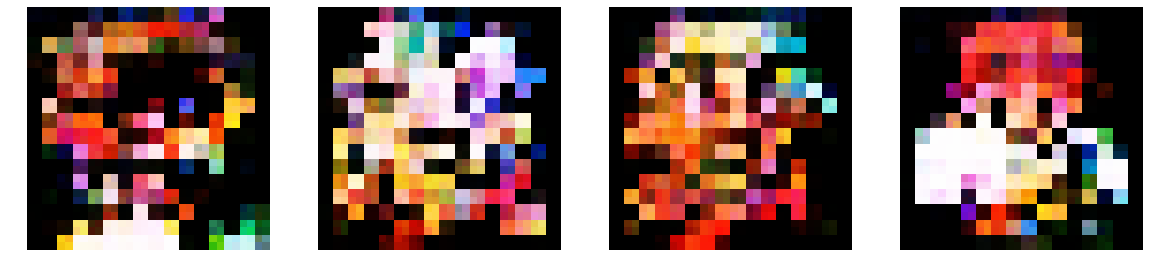

(4, 88, 256, 1)


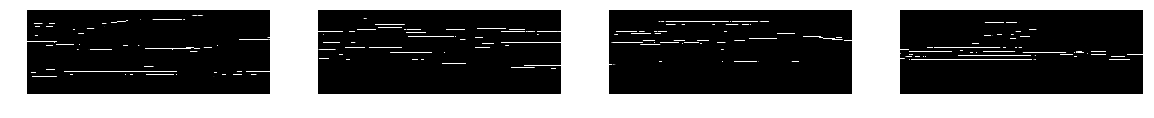

(4, 32, 32, 3)


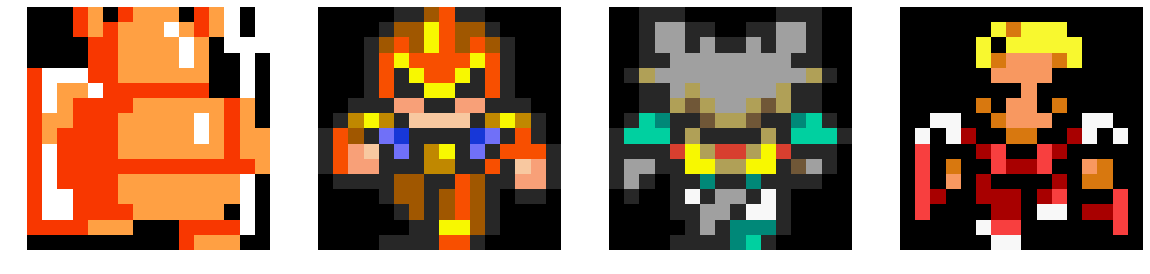

(4, 88, 256, 1)


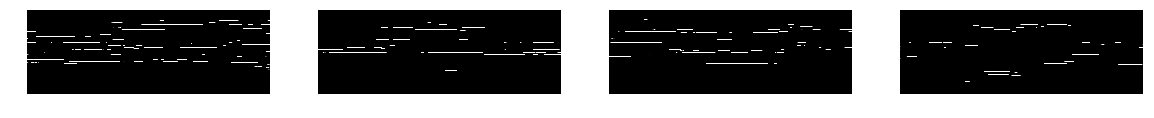

(4, 32, 32, 3)


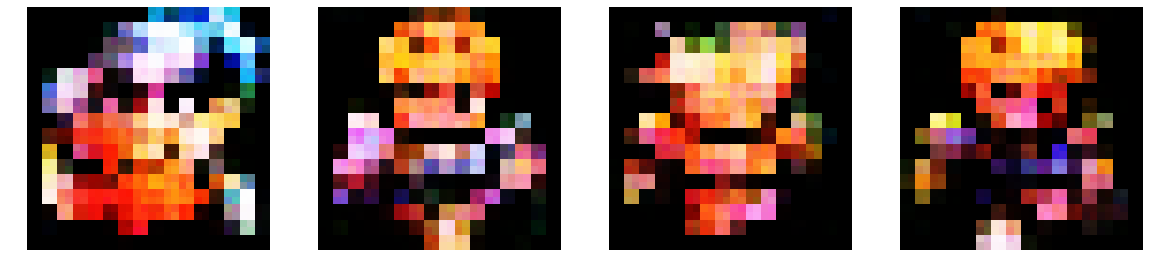

[67/100][23275] Loss_D: 0.036704 0.016008 Loss_G: 0.961373 1.052212 loss_cyc 0.413906 225.075
[67/100][23300] Loss_D: 0.017705 0.024225 Loss_G: 0.947001 1.061900 loss_cyc 0.422301 225.310
[67/100][23325] Loss_D: 0.025956 0.026473 Loss_G: 0.959836 1.019288 loss_cyc 0.383619 225.547
[67/100][23350] Loss_D: 0.018964 0.024467 Loss_G: 0.962194 1.005672 loss_cyc 0.402974 225.781
[67/100][23375] Loss_D: 0.024542 0.018112 Loss_G: 0.958474 1.002528 loss_cyc 0.410633 226.012
[67/100][23400] Loss_D: 0.023199 0.034393 Loss_G: 0.902545 0.996137 loss_cyc 0.410116 226.257
[67/100][23425] Loss_D: 0.033449 0.033953 Loss_G: 0.987885 1.037116 loss_cyc 0.414029 226.499
[67/100][23450] Loss_D: 0.027250 0.038927 Loss_G: 0.916355 1.033432 loss_cyc 0.404740 226.723
[67/100][23475] Loss_D: 0.025286 0.037294 Loss_G: 0.943459 1.002230 loss_cyc 0.406101 226.950
[67/100][23500] Loss_D: 0.028656 0.022171 Loss_G: 0.922055 0.980416 loss_cyc 0.404346 227.182
[67/100][23525] Loss_D: 0.022203 0.024062 Loss_G: 0.966353 1

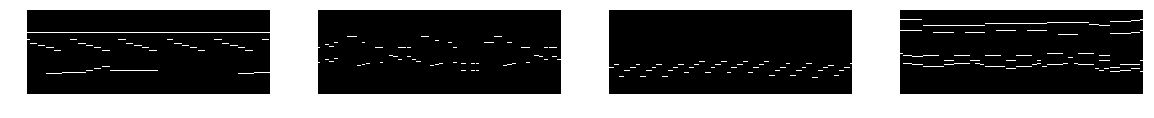

(4, 32, 32, 3)


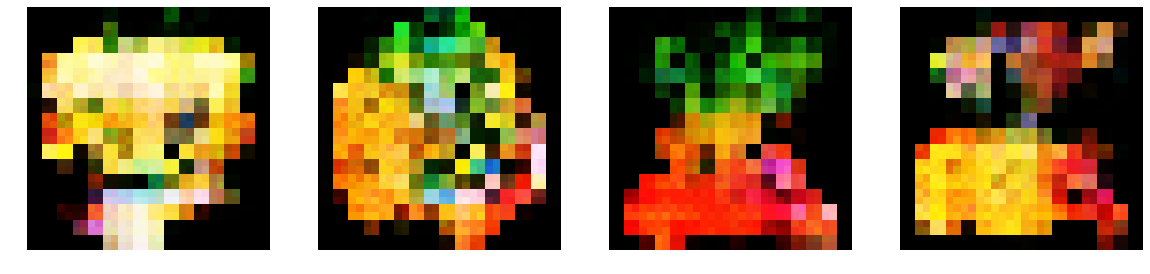

(4, 88, 256, 1)


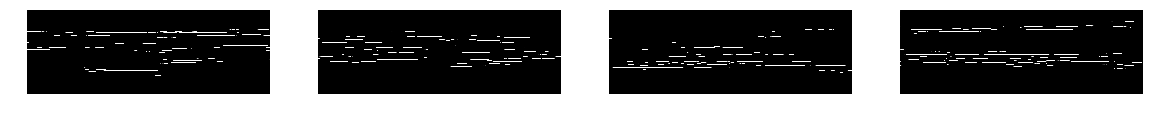

(4, 32, 32, 3)


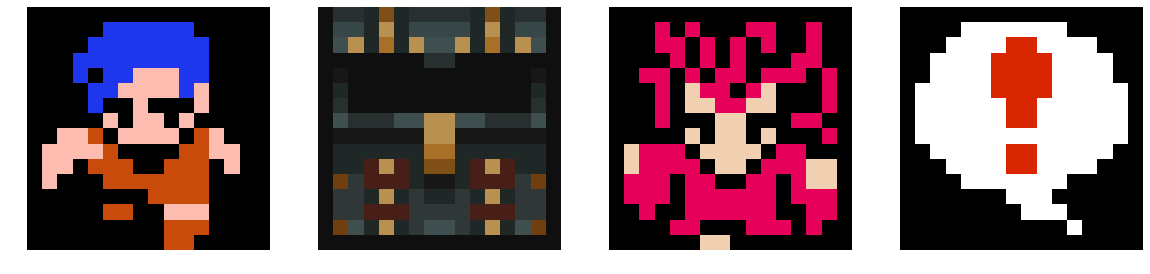

(4, 88, 256, 1)


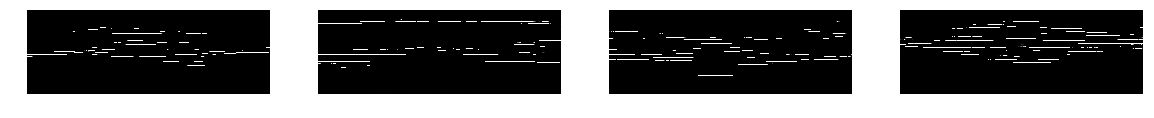

(4, 32, 32, 3)


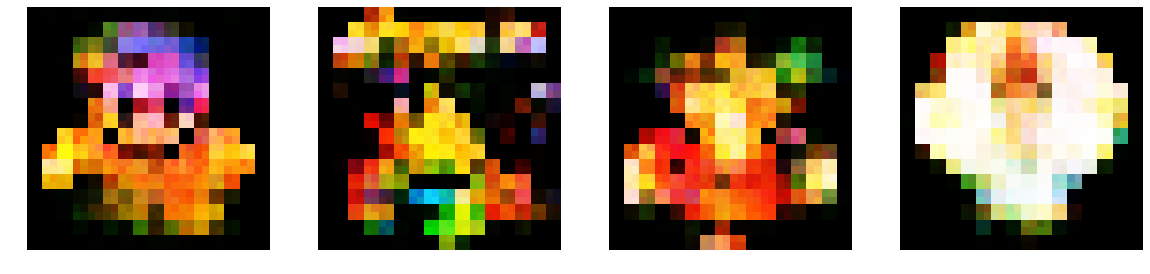

[68/100][23600] Loss_D: 0.028102 0.034990 Loss_G: 0.910809 1.084255 loss_cyc 0.429534 228.211
[68/100][23625] Loss_D: 0.024405 0.031778 Loss_G: 0.894125 1.090064 loss_cyc 0.410786 228.441
[68/100][23650] Loss_D: 0.030948 0.026252 Loss_G: 0.943089 1.033249 loss_cyc 0.406316 228.669
[68/100][23675] Loss_D: 0.030597 0.050475 Loss_G: 0.899198 1.072486 loss_cyc 0.408635 228.910
[68/100][23700] Loss_D: 0.049138 0.033167 Loss_G: 0.902915 1.052204 loss_cyc 0.390702 229.150
[68/100][23725] Loss_D: 0.025460 0.033105 Loss_G: 0.869202 1.011899 loss_cyc 0.390182 229.389
[68/100][23750] Loss_D: 0.024208 0.058420 Loss_G: 0.932068 1.011605 loss_cyc 0.425227 229.632
[68/100][23775] Loss_D: 0.022068 0.022385 Loss_G: 0.976598 1.055414 loss_cyc 0.408135 229.861
[68/100][23800] Loss_D: 0.019883 0.053556 Loss_G: 0.967344 0.936263 loss_cyc 0.398250 230.103
[68/100][23825] Loss_D: 0.027827 0.022895 Loss_G: 0.940794 0.980287 loss_cyc 0.392903 230.336
[68/100][23850] Loss_D: 0.021554 0.029018 Loss_G: 0.935831 0

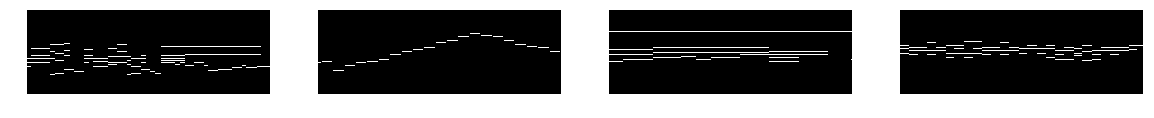

(4, 32, 32, 3)


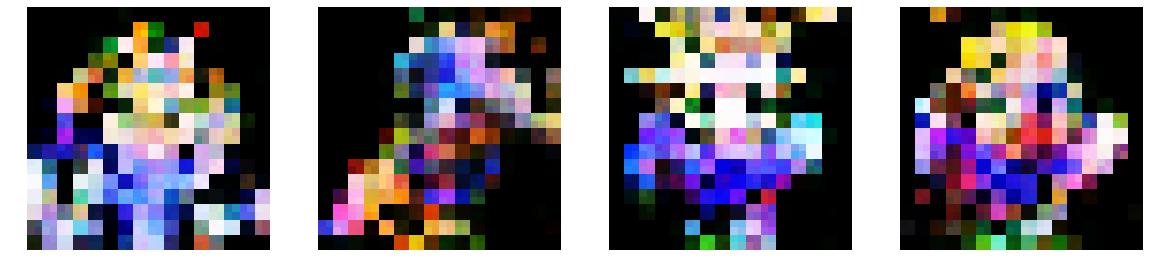

(4, 88, 256, 1)


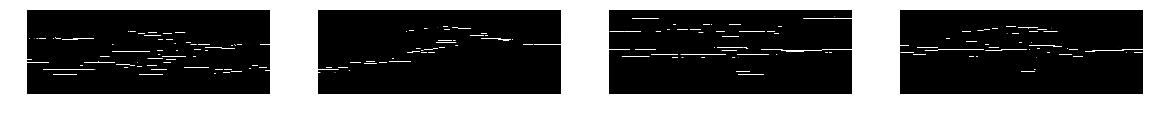

(4, 32, 32, 3)


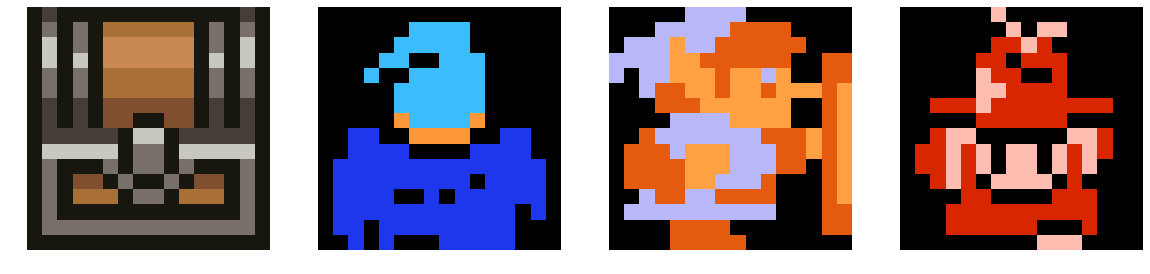

(4, 88, 256, 1)


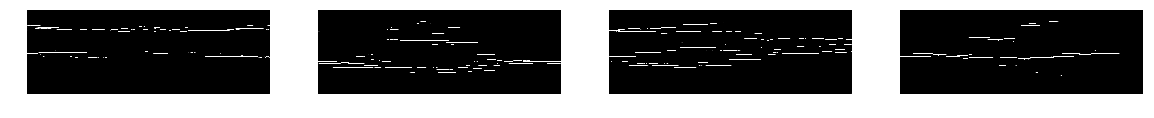

(4, 32, 32, 3)


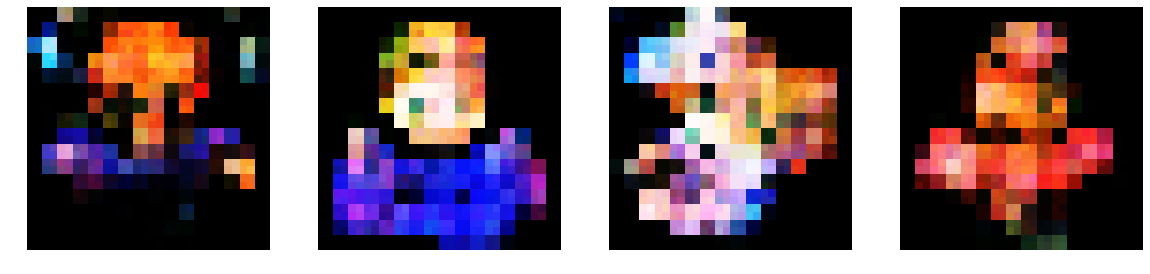

[69/100][23950] Loss_D: 0.028179 0.046204 Loss_G: 0.900033 0.988865 loss_cyc 0.404196 231.573
[69/100][23975] Loss_D: 0.031220 0.024452 Loss_G: 0.948773 0.990366 loss_cyc 0.389822 231.797
[69/100][24000] Loss_D: 0.015434 0.019194 Loss_G: 0.983679 0.975110 loss_cyc 0.376507 232.030
[69/100][24025] Loss_D: 0.025870 0.025254 Loss_G: 0.939725 1.013021 loss_cyc 0.387127 232.265
[69/100][24050] Loss_D: 0.021121 0.021692 Loss_G: 0.982688 1.049826 loss_cyc 0.386278 232.509
[69/100][24075] Loss_D: 0.030568 0.036351 Loss_G: 0.874392 0.954682 loss_cyc 0.400219 232.747
[69/100][24100] Loss_D: 0.048490 0.025021 Loss_G: 0.907565 1.012077 loss_cyc 0.415033 232.993
[69/100][24125] Loss_D: 0.042977 0.017279 Loss_G: 0.894617 1.024483 loss_cyc 0.380384 233.235
[69/100][24150] Loss_D: 0.028745 0.041993 Loss_G: 0.882087 0.982404 loss_cyc 0.377633 233.469
[69/100][24175] Loss_D: 0.029410 0.027507 Loss_G: 0.953133 1.006639 loss_cyc 0.387342 233.717
[69/100][24200] Loss_D: 0.031301 0.042760 Loss_G: 0.914696 0

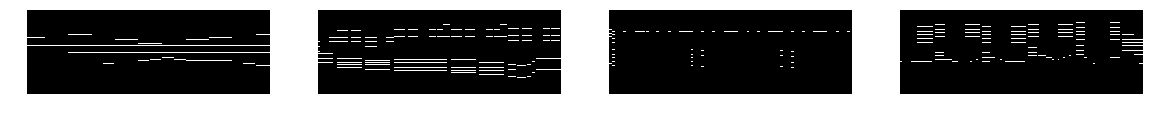

(4, 32, 32, 3)


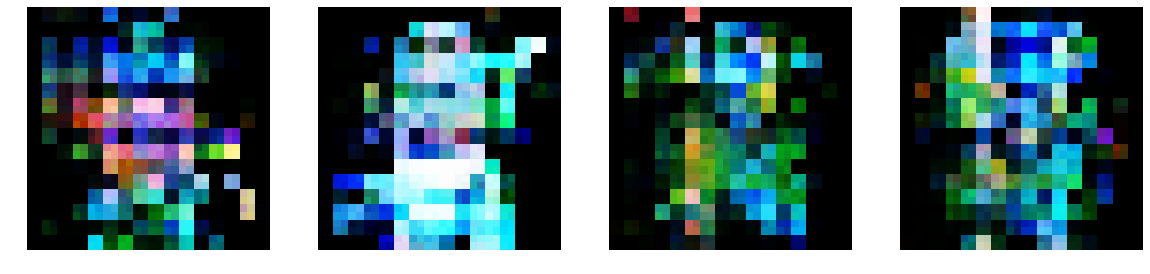

(4, 88, 256, 1)


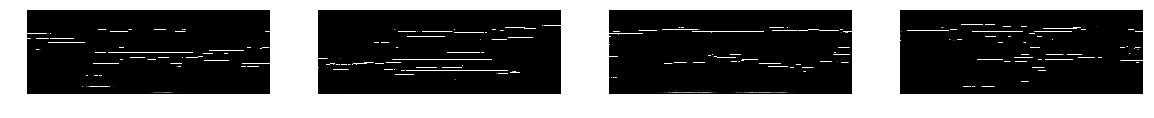

(4, 32, 32, 3)


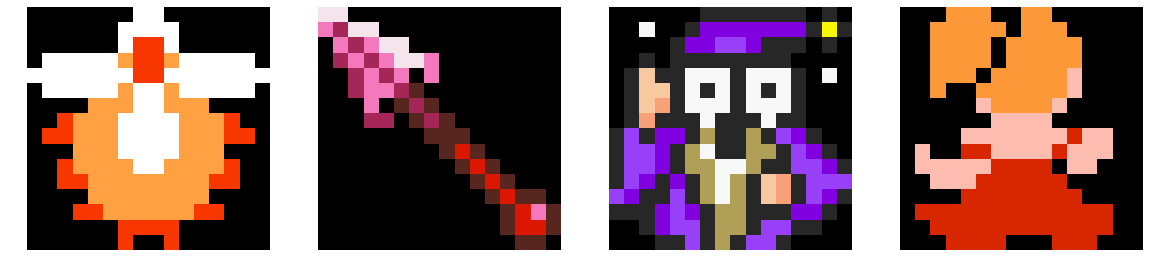

(4, 88, 256, 1)


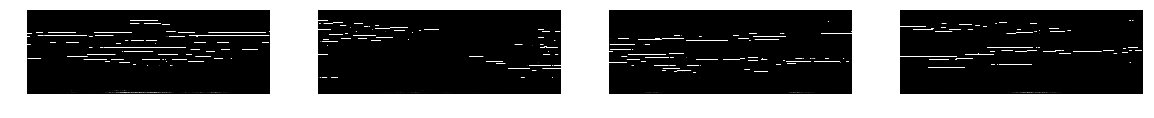

(4, 32, 32, 3)


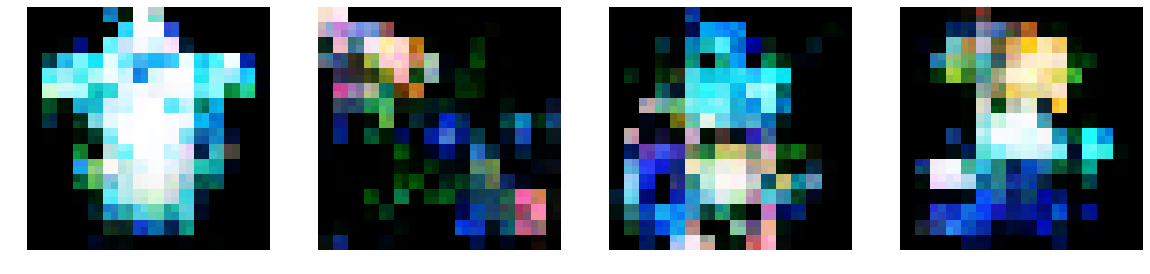

[70/100][24300] Loss_D: 0.028534 0.067244 Loss_G: 0.932871 1.025517 loss_cyc 0.462517 234.957
[70/100][24325] Loss_D: 0.033880 0.039035 Loss_G: 0.933528 0.972905 loss_cyc 0.420847 235.191
[70/100][24350] Loss_D: 0.025870 0.036495 Loss_G: 0.873562 0.993012 loss_cyc 0.408393 235.430
[70/100][24375] Loss_D: 0.016633 0.030495 Loss_G: 0.951180 0.955294 loss_cyc 0.403039 235.664
[70/100][24400] Loss_D: 0.018417 0.024318 Loss_G: 0.964872 1.049240 loss_cyc 0.372248 235.905
[70/100][24425] Loss_D: 0.029853 0.036119 Loss_G: 0.923473 0.985294 loss_cyc 0.401259 236.141
[70/100][24450] Loss_D: 0.022636 0.024736 Loss_G: 0.921420 1.088414 loss_cyc 0.395390 236.381
[70/100][24475] Loss_D: 0.028761 0.024016 Loss_G: 0.924642 1.057597 loss_cyc 0.385830 236.625
[70/100][24500] Loss_D: 0.030946 0.021396 Loss_G: 0.971386 1.035639 loss_cyc 0.423810 236.854
[70/100][24525] Loss_D: 0.027289 0.033365 Loss_G: 0.960445 1.046062 loss_cyc 0.383093 237.081
[70/100][24550] Loss_D: 0.025428 0.036574 Loss_G: 0.995806 0

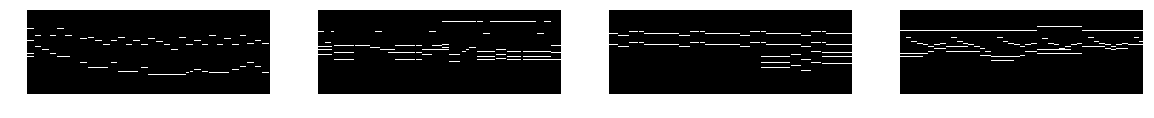

(4, 32, 32, 3)


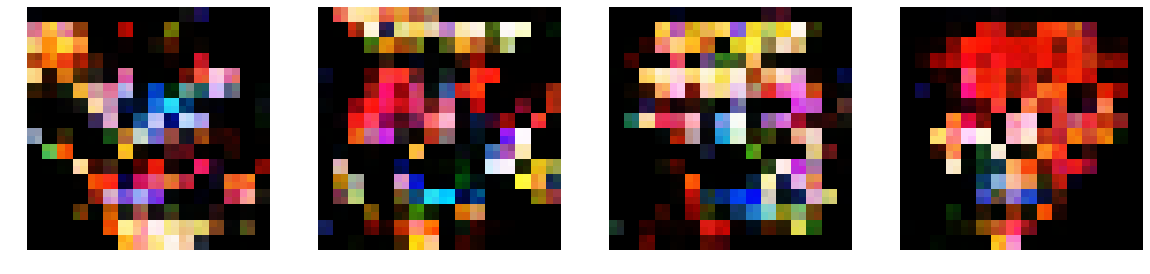

(4, 88, 256, 1)


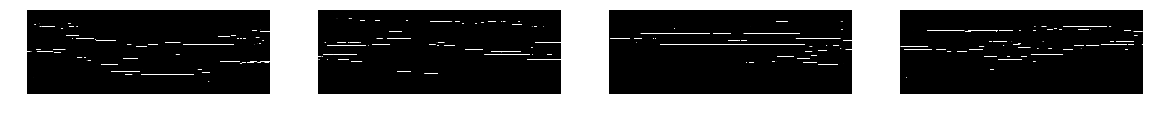

(4, 32, 32, 3)


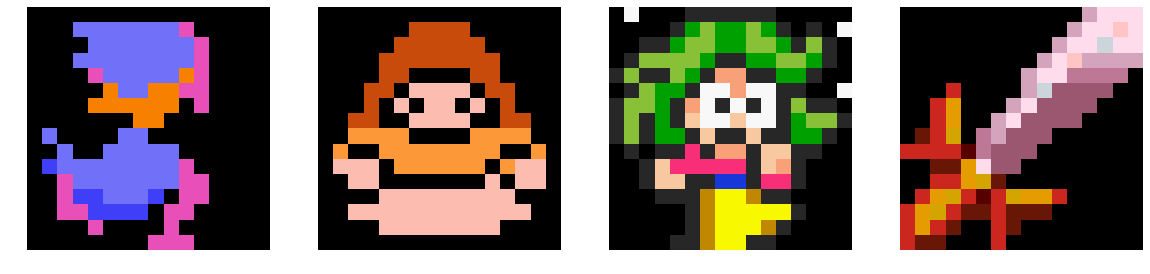

(4, 88, 256, 1)


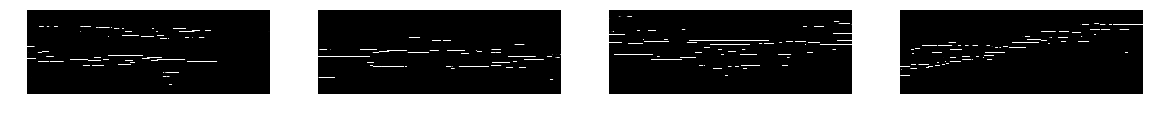

(4, 32, 32, 3)


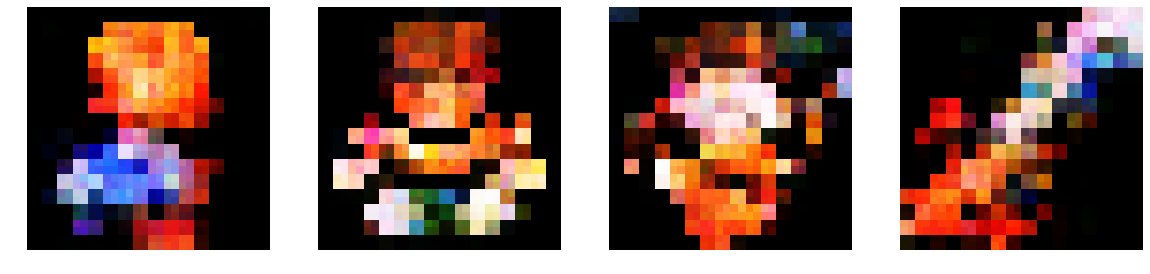

[71/100][24650] Loss_D: 0.028715 0.016386 Loss_G: 0.930302 1.003091 loss_cyc 0.389103 238.324
[71/100][24675] Loss_D: 0.016665 0.034283 Loss_G: 0.994863 1.011261 loss_cyc 0.389160 238.564
[71/100][24700] Loss_D: 0.024707 0.026404 Loss_G: 0.970901 0.980444 loss_cyc 0.410589 238.814
[71/100][24725] Loss_D: 0.029923 0.020993 Loss_G: 0.930374 0.997090 loss_cyc 0.391521 239.044
[71/100][24750] Loss_D: 0.032509 0.045535 Loss_G: 0.904715 1.068474 loss_cyc 0.390356 239.280
[71/100][24775] Loss_D: 0.022941 0.026644 Loss_G: 0.989389 1.059118 loss_cyc 0.392900 239.517
[71/100][24800] Loss_D: 0.018890 0.037262 Loss_G: 0.955451 1.100689 loss_cyc 0.394333 239.754
[71/100][24825] Loss_D: 0.014605 0.031036 Loss_G: 0.992046 0.946355 loss_cyc 0.392136 239.989
[71/100][24850] Loss_D: 0.022743 0.021356 Loss_G: 0.938043 0.990105 loss_cyc 0.410625 240.225
[71/100][24875] Loss_D: 0.024102 0.021609 Loss_G: 0.950590 1.004372 loss_cyc 0.379811 240.472
[71/100][24900] Loss_D: 0.031701 0.023122 Loss_G: 0.934600 1

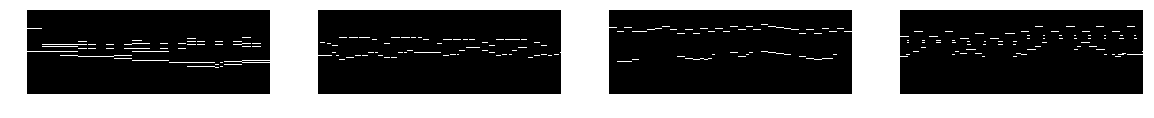

(4, 32, 32, 3)


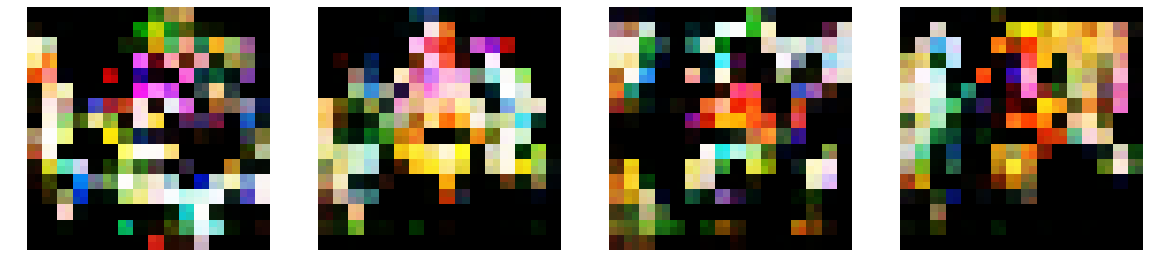

(4, 88, 256, 1)


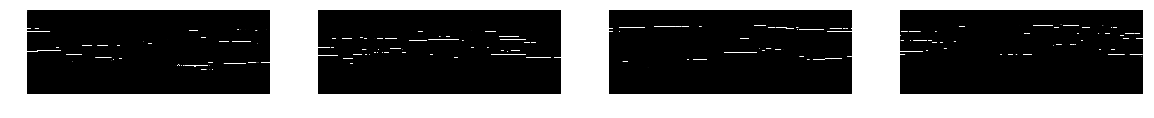

(4, 32, 32, 3)


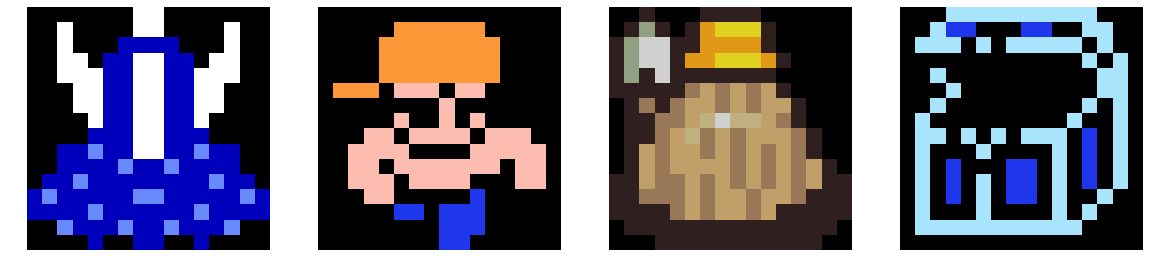

(4, 88, 256, 1)


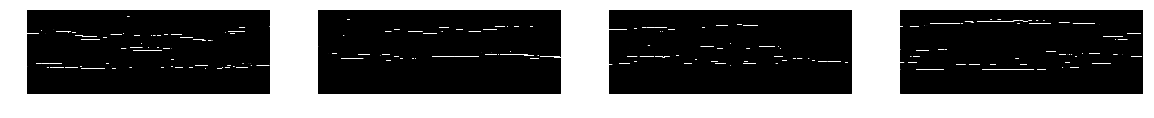

(4, 32, 32, 3)


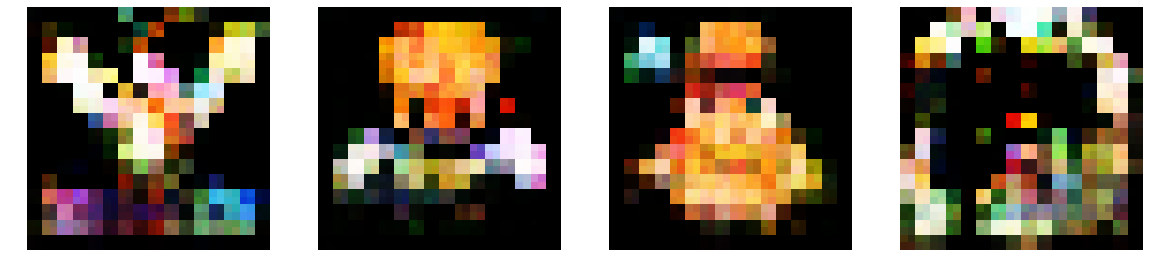

[72/100][25000] Loss_D: 0.023256 0.044687 Loss_G: 0.972655 1.081658 loss_cyc 0.388593 241.700
[72/100][25025] Loss_D: 0.017661 0.027864 Loss_G: 0.961785 1.014236 loss_cyc 0.398648 241.944
[72/100][25050] Loss_D: 0.014943 0.034300 Loss_G: 0.959437 1.030779 loss_cyc 0.398038 242.191
[72/100][25075] Loss_D: 0.016432 0.030407 Loss_G: 0.989727 0.976398 loss_cyc 0.399408 242.425
[72/100][25100] Loss_D: 0.014946 0.021984 Loss_G: 0.958685 1.034341 loss_cyc 0.404570 242.676
[72/100][25125] Loss_D: 0.019697 0.024434 Loss_G: 0.963077 1.041826 loss_cyc 0.395427 242.915
[72/100][25150] Loss_D: 0.019588 0.023340 Loss_G: 0.994861 1.007469 loss_cyc 0.392422 243.156
[72/100][25175] Loss_D: 0.026183 0.022286 Loss_G: 0.981331 1.007383 loss_cyc 0.388428 243.385
[72/100][25200] Loss_D: 0.034751 0.039539 Loss_G: 0.933444 0.992256 loss_cyc 0.407377 243.624
[72/100][25225] Loss_D: 0.017026 0.026917 Loss_G: 0.970824 1.032239 loss_cyc 0.400183 243.860
[72/100][25250] Loss_D: 0.034470 0.036106 Loss_G: 0.883464 1

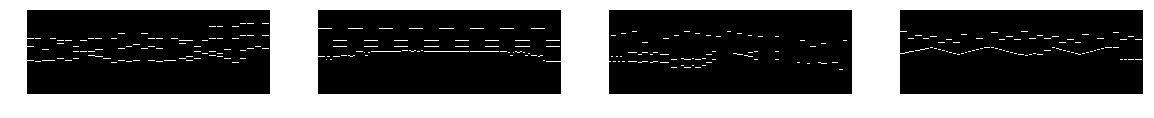

(4, 32, 32, 3)


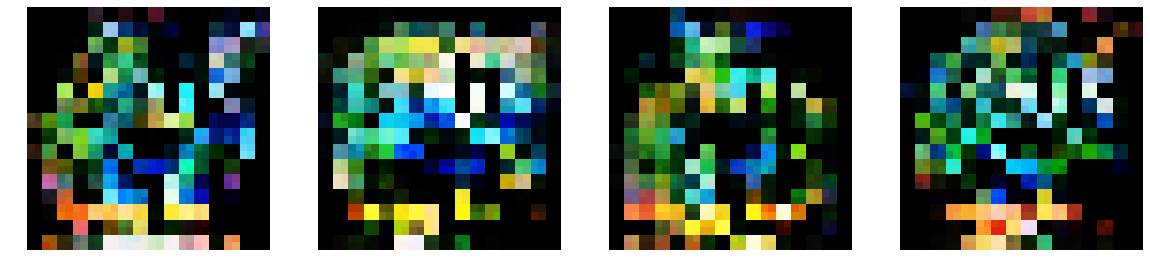

(4, 88, 256, 1)


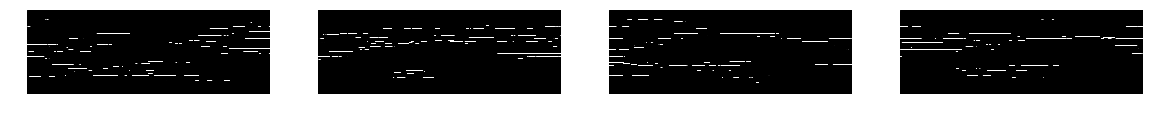

(4, 32, 32, 3)


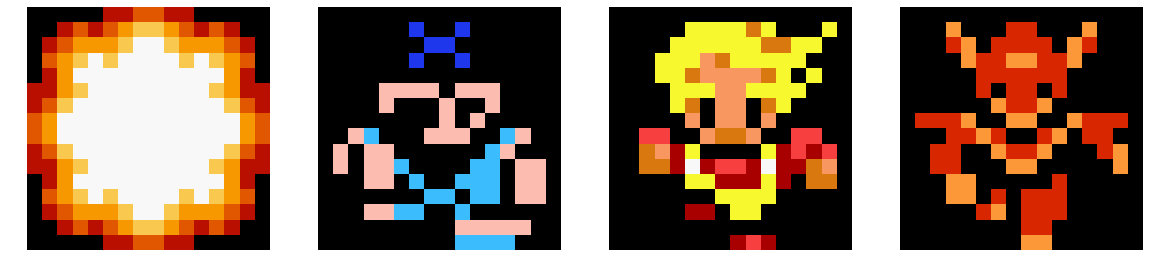

(4, 88, 256, 1)


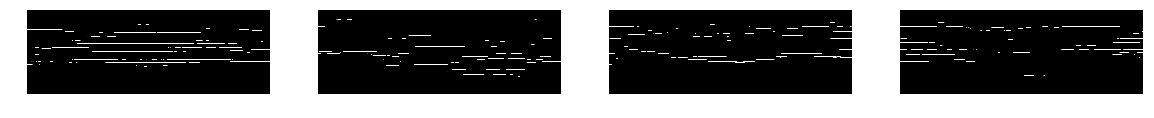

(4, 32, 32, 3)


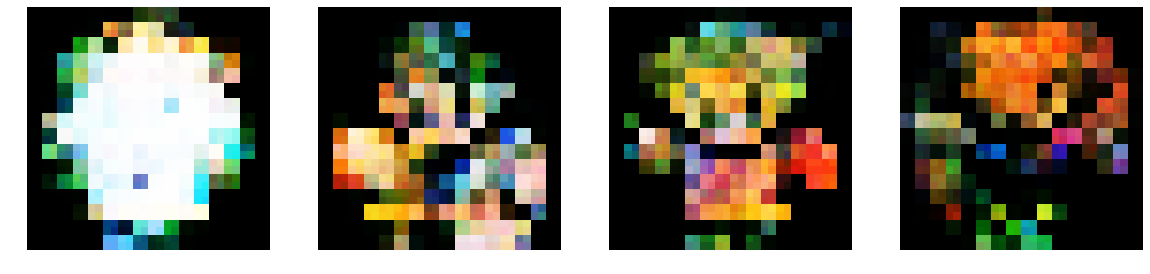

[73/100][25350] Loss_D: 0.028304 0.033042 Loss_G: 0.969785 1.028776 loss_cyc 0.386972 245.085
[73/100][25375] Loss_D: 0.020051 0.020469 Loss_G: 0.915127 1.008283 loss_cyc 0.398131 245.317
[73/100][25400] Loss_D: 0.016521 0.031757 Loss_G: 0.997185 1.032461 loss_cyc 0.383809 245.555
[73/100][25425] Loss_D: 0.028758 0.028511 Loss_G: 0.940540 0.985816 loss_cyc 0.401757 245.784
[73/100][25450] Loss_D: 0.034176 0.042171 Loss_G: 0.958607 1.038663 loss_cyc 0.425784 246.028
[73/100][25475] Loss_D: 0.019558 0.030574 Loss_G: 0.950880 1.061661 loss_cyc 0.432265 246.263
[73/100][25500] Loss_D: 0.024430 0.015365 Loss_G: 0.919949 0.987229 loss_cyc 0.423981 246.502
[73/100][25525] Loss_D: 0.020127 0.022533 Loss_G: 0.972821 1.090523 loss_cyc 0.373249 246.742
[73/100][25550] Loss_D: 0.026216 0.039641 Loss_G: 0.947300 0.926079 loss_cyc 0.396893 246.979
[73/100][25575] Loss_D: 0.025742 0.030912 Loss_G: 0.965171 1.030660 loss_cyc 0.377908 247.213
[73/100][25600] Loss_D: 0.019185 0.033701 Loss_G: 0.918290 0

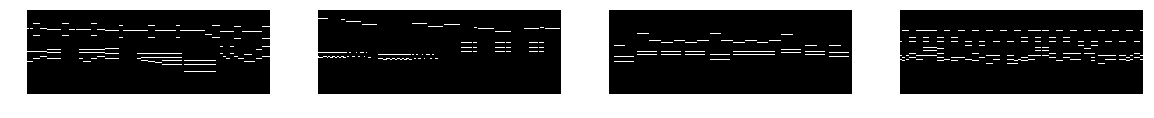

(4, 32, 32, 3)


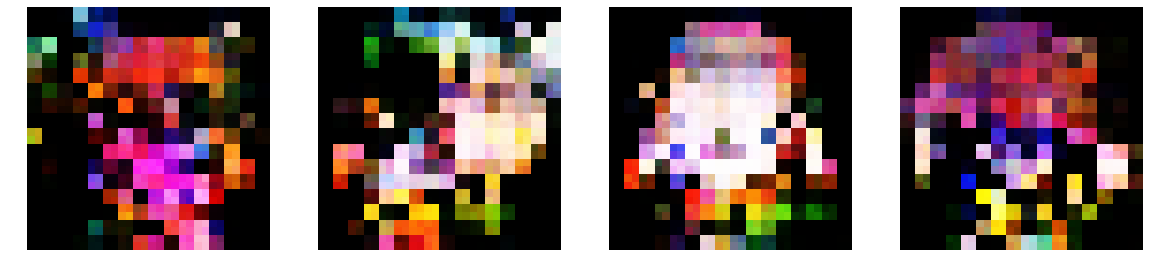

(4, 88, 256, 1)


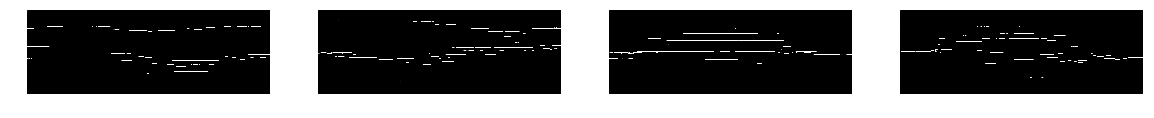

(4, 32, 32, 3)


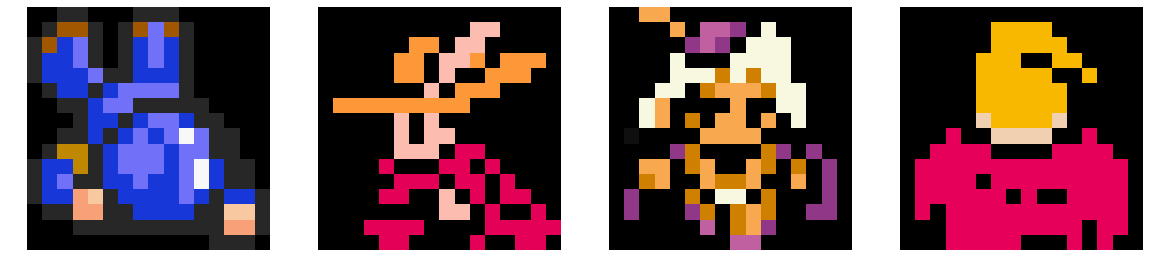

(4, 88, 256, 1)


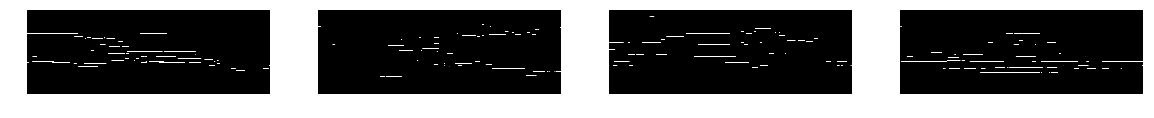

(4, 32, 32, 3)


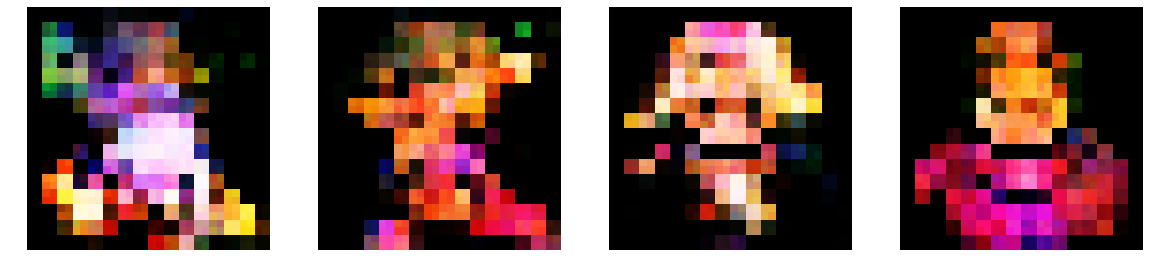

[74/100][25700] Loss_D: 0.024600 0.015830 Loss_G: 0.937217 0.998546 loss_cyc 0.401032 248.468
[74/100][25725] Loss_D: 0.035419 0.029957 Loss_G: 0.933791 1.004049 loss_cyc 0.406244 248.705
[74/100][25750] Loss_D: 0.028591 0.017217 Loss_G: 0.948768 1.015434 loss_cyc 0.387301 248.933
[74/100][25775] Loss_D: 0.029224 0.041589 Loss_G: 0.931718 0.948305 loss_cyc 0.398902 249.156
[74/100][25800] Loss_D: 0.026009 0.020106 Loss_G: 0.966749 1.016221 loss_cyc 0.396068 249.398
[74/100][25825] Loss_D: 0.022029 0.027675 Loss_G: 1.000185 1.059166 loss_cyc 0.396680 249.645
[74/100][25850] Loss_D: 0.023572 0.022630 Loss_G: 0.941145 1.006236 loss_cyc 0.383278 249.884
[74/100][25875] Loss_D: 0.016960 0.049535 Loss_G: 0.977449 1.075972 loss_cyc 0.412020 250.116
[74/100][25900] Loss_D: 0.020949 0.026529 Loss_G: 0.962673 1.098144 loss_cyc 0.387912 250.354
[74/100][25925] Loss_D: 0.020589 0.023382 Loss_G: 0.986657 1.019412 loss_cyc 0.415485 250.596
[74/100][25950] Loss_D: 0.018243 0.031996 Loss_G: 0.956717 0

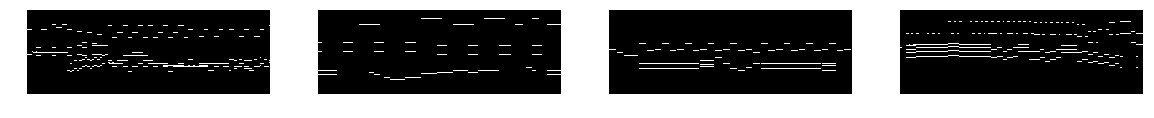

(4, 32, 32, 3)


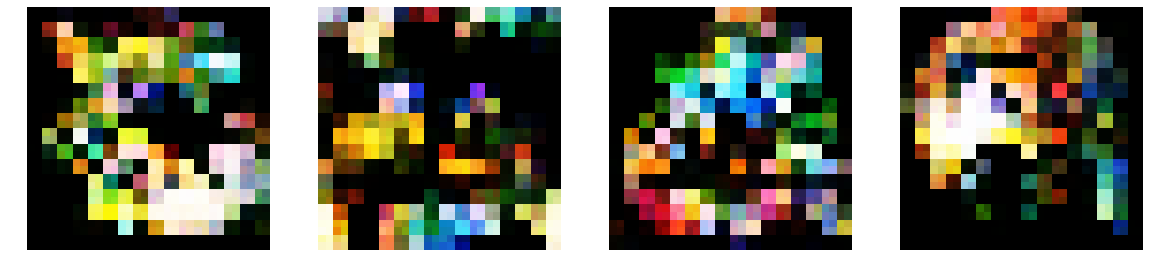

(4, 88, 256, 1)


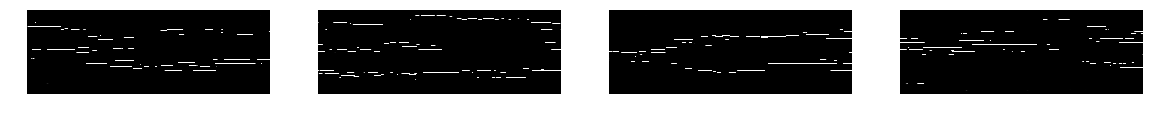

(4, 32, 32, 3)


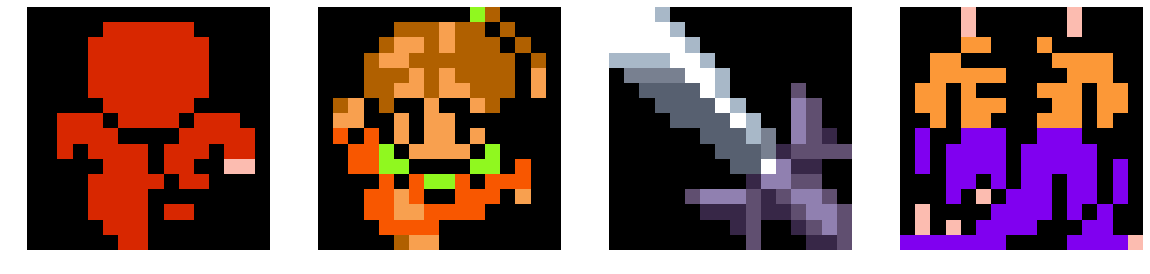

(4, 88, 256, 1)


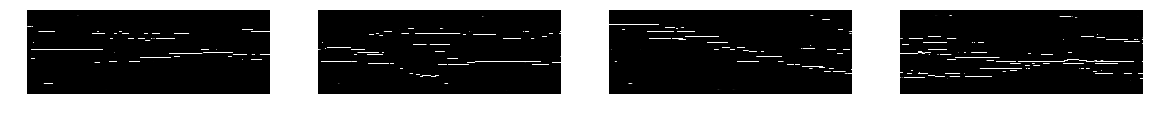

(4, 32, 32, 3)


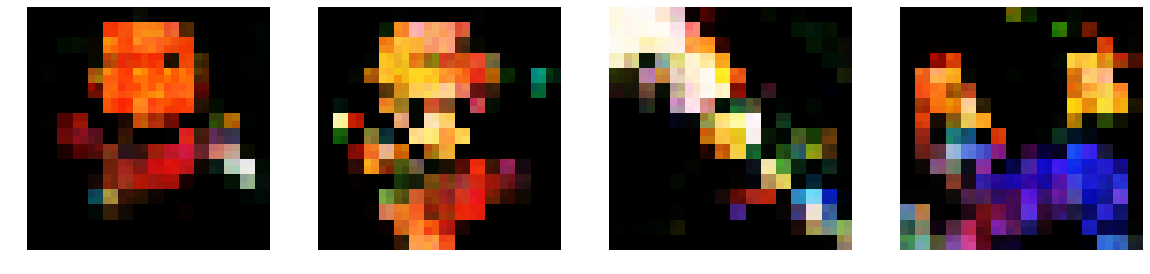

[75/100][26050] Loss_D: 0.036346 0.025094 Loss_G: 0.965846 1.033832 loss_cyc 0.390523 251.849
[75/100][26075] Loss_D: 0.029241 0.028496 Loss_G: 0.894011 0.942116 loss_cyc 0.371305 252.082
[75/100][26100] Loss_D: 0.023489 0.039118 Loss_G: 0.949703 0.954704 loss_cyc 0.406481 252.320
[75/100][26125] Loss_D: 0.024124 0.021911 Loss_G: 0.952704 0.955118 loss_cyc 0.381148 252.554
[75/100][26150] Loss_D: 0.019254 0.040821 Loss_G: 0.921980 1.015862 loss_cyc 0.408986 252.800
[75/100][26175] Loss_D: 0.020111 0.028483 Loss_G: 0.930329 1.009521 loss_cyc 0.401518 253.025
[75/100][26200] Loss_D: 0.024949 0.028974 Loss_G: 0.938553 1.026209 loss_cyc 0.410683 253.267
[75/100][26225] Loss_D: 0.021709 0.021055 Loss_G: 0.938296 0.961257 loss_cyc 0.378444 253.512
[75/100][26250] Loss_D: 0.033379 0.022298 Loss_G: 0.932210 0.975031 loss_cyc 0.383478 253.757
[75/100][26275] Loss_D: 0.024795 0.016986 Loss_G: 0.955160 0.971441 loss_cyc 0.418956 253.990
[75/100][26300] Loss_D: 0.023846 0.024563 Loss_G: 0.937224 1

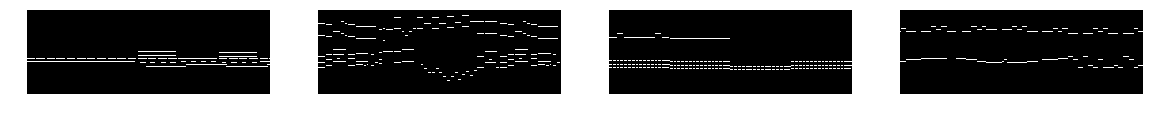

(4, 32, 32, 3)


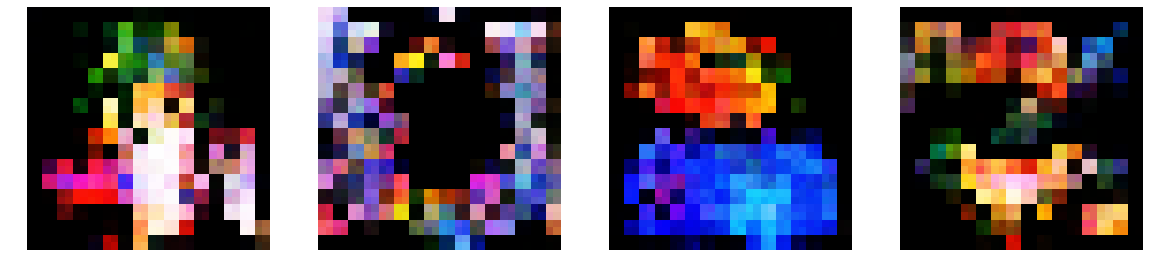

(4, 88, 256, 1)


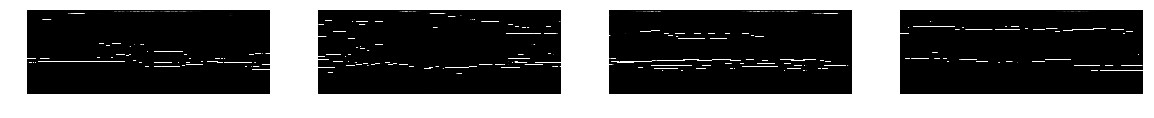

(4, 32, 32, 3)


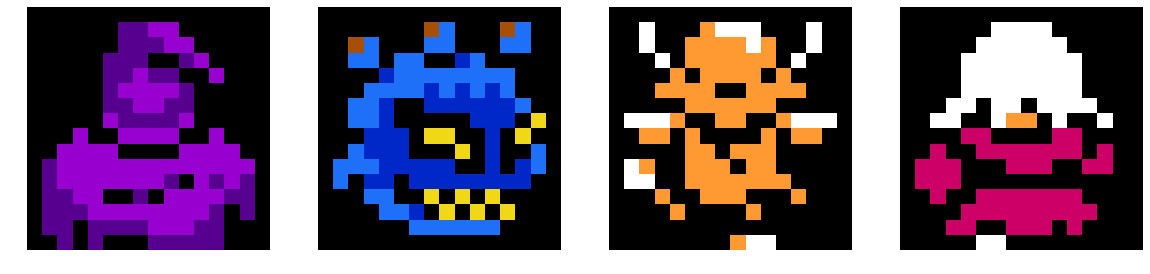

(4, 88, 256, 1)


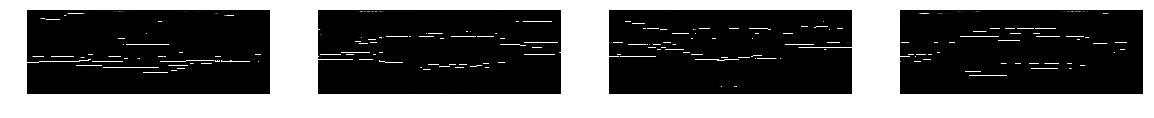

(4, 32, 32, 3)


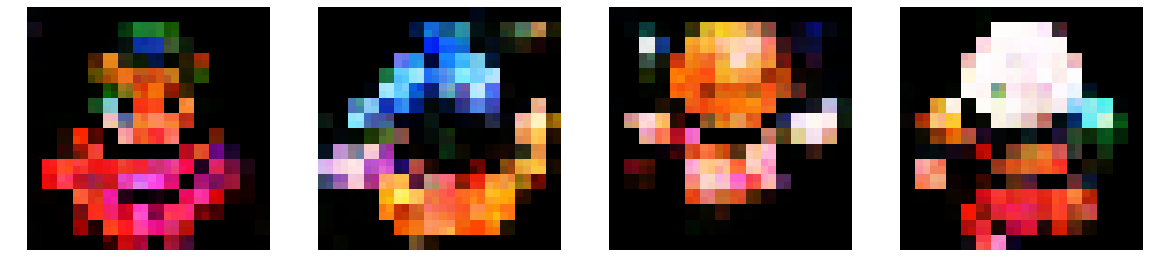

[76/100][26400] Loss_D: 0.023404 0.017326 Loss_G: 0.968861 1.029590 loss_cyc 0.379771 255.245
[76/100][26425] Loss_D: 0.031343 0.040869 Loss_G: 0.893570 0.964835 loss_cyc 0.378255 255.479
[76/100][26450] Loss_D: 0.027293 0.025118 Loss_G: 0.931483 1.069791 loss_cyc 0.432880 255.713
[76/100][26475] Loss_D: 0.021970 0.036587 Loss_G: 0.918581 1.055075 loss_cyc 0.404374 255.955
[76/100][26500] Loss_D: 0.027942 0.047961 Loss_G: 0.908463 1.049362 loss_cyc 0.406486 256.199
[76/100][26525] Loss_D: 0.022111 0.041851 Loss_G: 0.933868 0.955815 loss_cyc 0.390363 256.441
[76/100][26550] Loss_D: 0.018936 0.037535 Loss_G: 0.931746 0.979167 loss_cyc 0.396221 256.682
[76/100][26575] Loss_D: 0.016617 0.030659 Loss_G: 0.973705 1.054685 loss_cyc 0.399149 256.924
[76/100][26600] Loss_D: 0.018688 0.032988 Loss_G: 0.996222 0.999377 loss_cyc 0.388810 257.152
[76/100][26625] Loss_D: 0.014485 0.038330 Loss_G: 0.985005 0.983886 loss_cyc 0.388053 257.389
[76/100][26650] Loss_D: 0.022452 0.035051 Loss_G: 0.889402 1

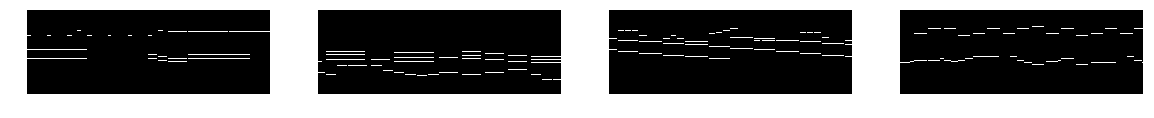

(4, 32, 32, 3)


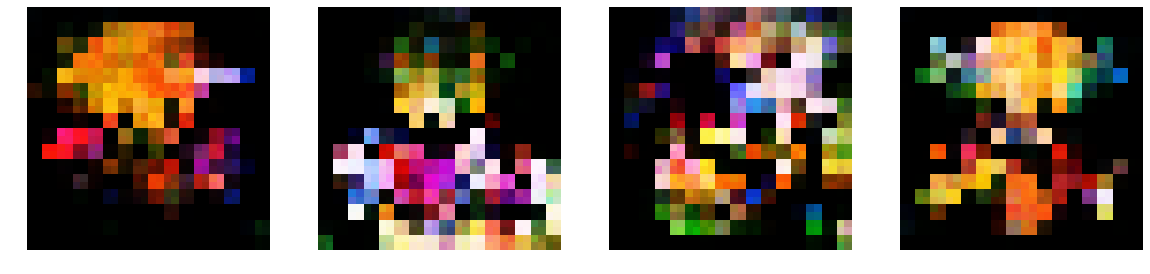

(4, 88, 256, 1)


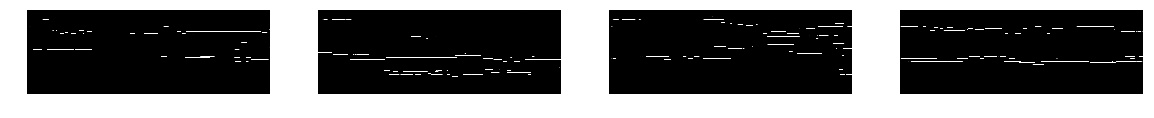

(4, 32, 32, 3)


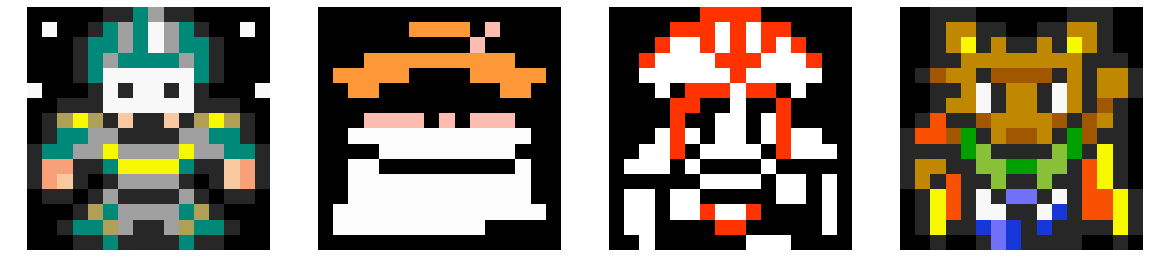

(4, 88, 256, 1)


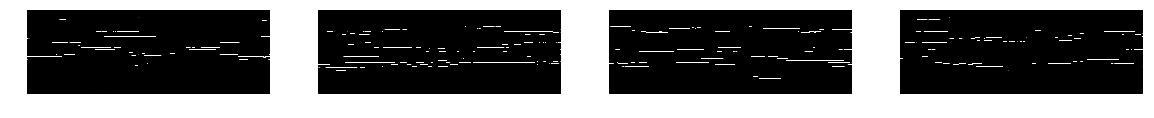

(4, 32, 32, 3)


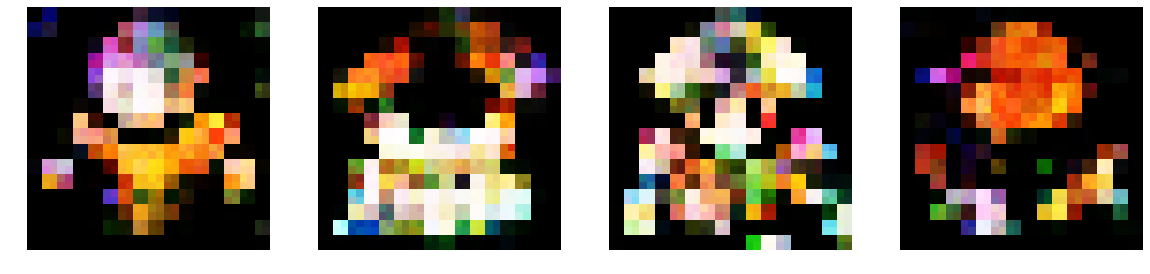

[77/100][26725] Loss_D: 0.012548 0.025535 Loss_G: 1.031802 1.005068 loss_cyc 0.370403 258.381
[77/100][26750] Loss_D: 0.014496 0.048128 Loss_G: 0.993963 1.028117 loss_cyc 0.375030 258.627
[77/100][26775] Loss_D: 0.022120 0.030111 Loss_G: 0.914528 0.984654 loss_cyc 0.374124 258.857
[77/100][26800] Loss_D: 0.033135 0.027397 Loss_G: 0.987209 1.009410 loss_cyc 0.400877 259.095
[77/100][26825] Loss_D: 0.015209 0.024400 Loss_G: 0.905474 0.944752 loss_cyc 0.382954 259.328
[77/100][26850] Loss_D: 0.025140 0.041070 Loss_G: 1.016088 0.968915 loss_cyc 0.394808 259.575
[77/100][26875] Loss_D: 0.020436 0.018113 Loss_G: 0.947041 0.957839 loss_cyc 0.386963 259.817
[77/100][26900] Loss_D: 0.017762 0.023149 Loss_G: 0.957187 0.999526 loss_cyc 0.398095 260.052
[77/100][26925] Loss_D: 0.021755 0.038276 Loss_G: 0.926321 0.966241 loss_cyc 0.382714 260.288
[77/100][26950] Loss_D: 0.019610 0.025567 Loss_G: 0.896817 1.046213 loss_cyc 0.414131 260.520
[77/100][26975] Loss_D: 0.021357 0.040884 Loss_G: 0.927732 1

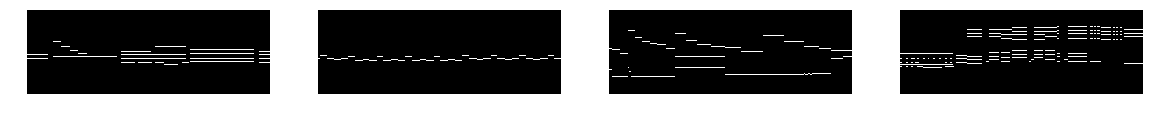

(4, 32, 32, 3)


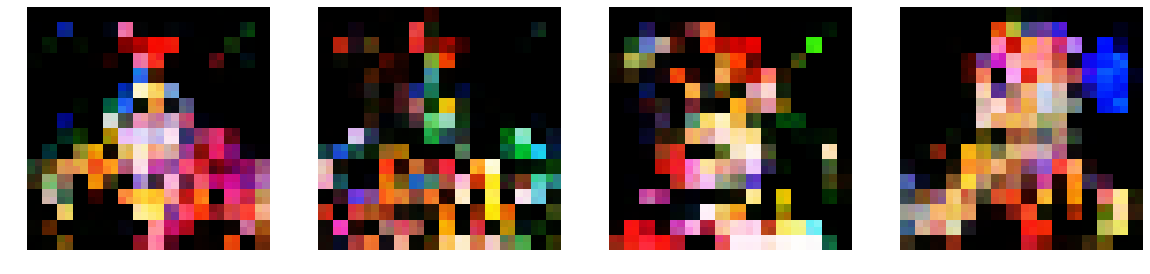

(4, 88, 256, 1)


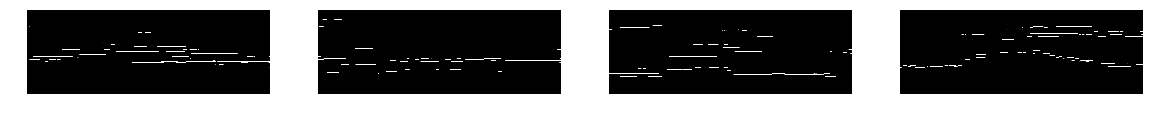

(4, 32, 32, 3)


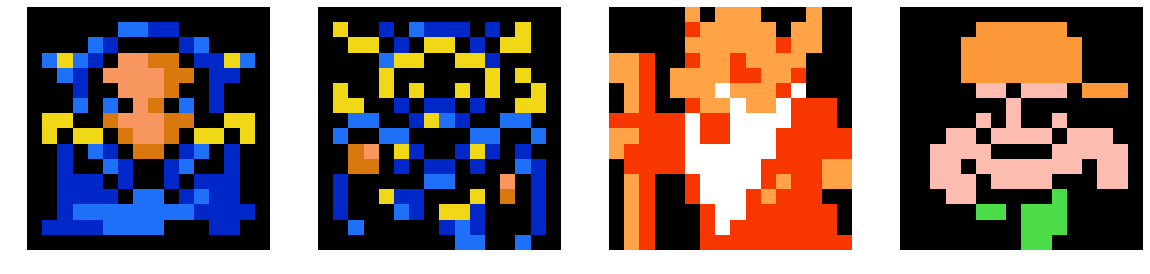

(4, 88, 256, 1)


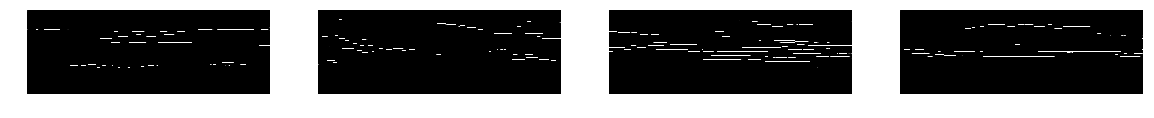

(4, 32, 32, 3)


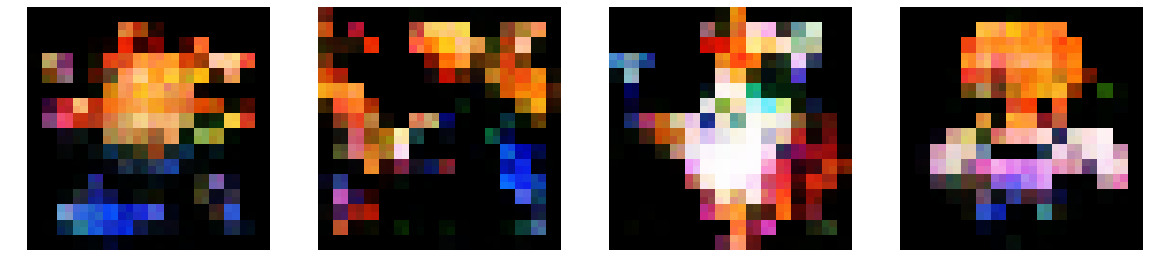

[78/100][27075] Loss_D: 0.026679 0.016569 Loss_G: 0.952393 1.000123 loss_cyc 0.394424 261.756
[78/100][27100] Loss_D: 0.032867 0.014444 Loss_G: 0.912926 0.979585 loss_cyc 0.376763 262.004
[78/100][27125] Loss_D: 0.014597 0.027542 Loss_G: 0.955578 0.980182 loss_cyc 0.391083 262.234
[78/100][27150] Loss_D: 0.020118 0.017814 Loss_G: 0.945554 1.027968 loss_cyc 0.388703 262.466
[78/100][27175] Loss_D: 0.024577 0.015686 Loss_G: 0.933738 1.079028 loss_cyc 0.387823 262.714
[78/100][27200] Loss_D: 0.028256 0.029423 Loss_G: 0.922681 1.019052 loss_cyc 0.377471 262.944
[78/100][27225] Loss_D: 0.022011 0.024023 Loss_G: 0.996841 0.996581 loss_cyc 0.381413 263.180
[78/100][27250] Loss_D: 0.024073 0.022208 Loss_G: 0.957948 1.024992 loss_cyc 0.400203 263.425
[78/100][27275] Loss_D: 0.015088 0.019068 Loss_G: 0.978860 1.038309 loss_cyc 0.380406 263.668
[78/100][27300] Loss_D: 0.025200 0.024451 Loss_G: 0.974249 0.935044 loss_cyc 0.372167 263.907
[78/100][27325] Loss_D: 0.012961 0.016365 Loss_G: 1.009086 1

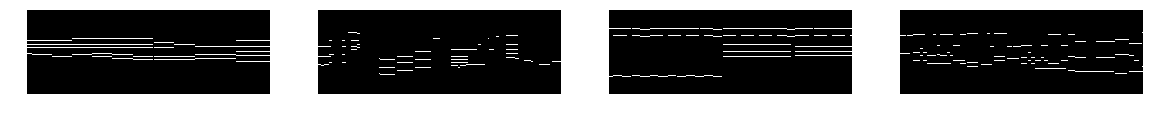

(4, 32, 32, 3)


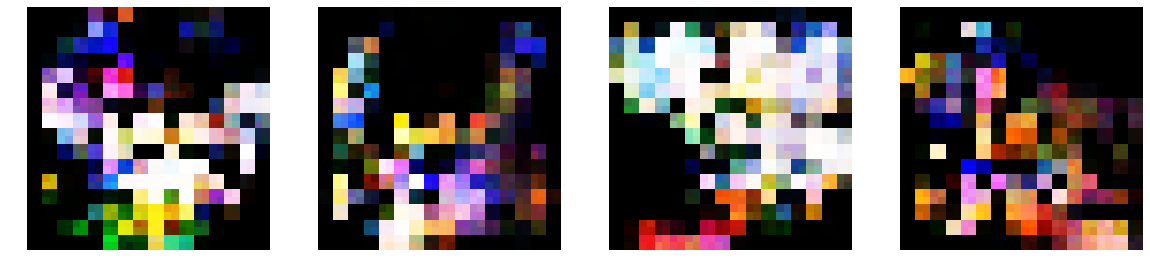

(4, 88, 256, 1)


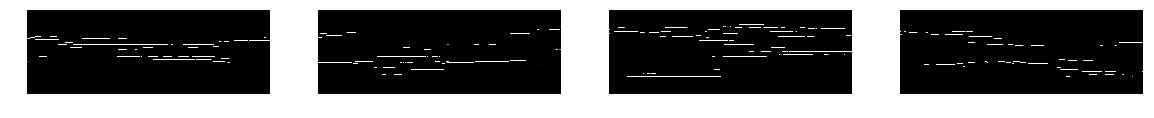

(4, 32, 32, 3)


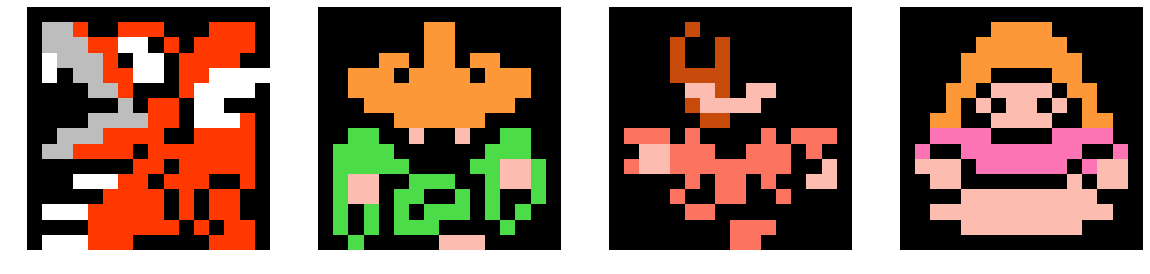

(4, 88, 256, 1)


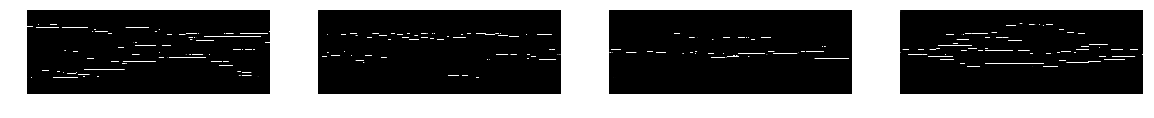

(4, 32, 32, 3)


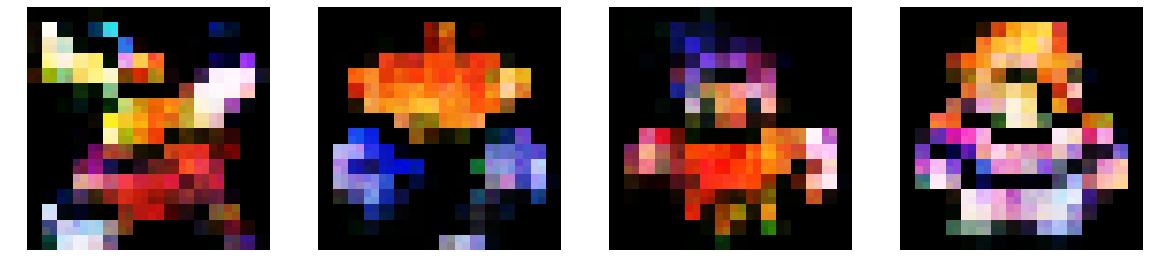

[79/100][27425] Loss_D: 0.023109 0.030489 Loss_G: 0.986857 1.007400 loss_cyc 0.417622 265.145
[79/100][27450] Loss_D: 0.022281 0.024025 Loss_G: 0.935830 1.045546 loss_cyc 0.379390 265.381
[79/100][27475] Loss_D: 0.019149 0.030219 Loss_G: 0.951055 1.011883 loss_cyc 0.352889 265.611
[79/100][27500] Loss_D: 0.035740 0.010829 Loss_G: 0.952033 0.997321 loss_cyc 0.370366 265.854
[79/100][27525] Loss_D: 0.022678 0.019870 Loss_G: 0.971941 1.095665 loss_cyc 0.376550 266.095
[79/100][27550] Loss_D: 0.022238 0.034758 Loss_G: 0.918907 1.060320 loss_cyc 0.384589 266.333
[79/100][27575] Loss_D: 0.032569 0.022804 Loss_G: 0.917352 1.002759 loss_cyc 0.387851 266.570
[79/100][27600] Loss_D: 0.030900 0.028393 Loss_G: 0.889673 0.987050 loss_cyc 0.394549 266.802
[79/100][27625] Loss_D: 0.025713 0.033786 Loss_G: 0.904512 1.028428 loss_cyc 0.373884 267.045
[79/100][27650] Loss_D: 0.028723 0.035589 Loss_G: 0.990515 1.014564 loss_cyc 0.396912 267.286
[79/100][27675] Loss_D: 0.025707 0.024731 Loss_G: 0.924619 1

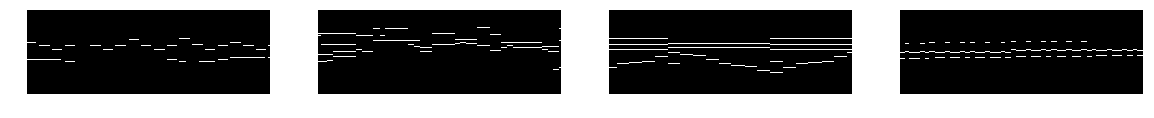

(4, 32, 32, 3)


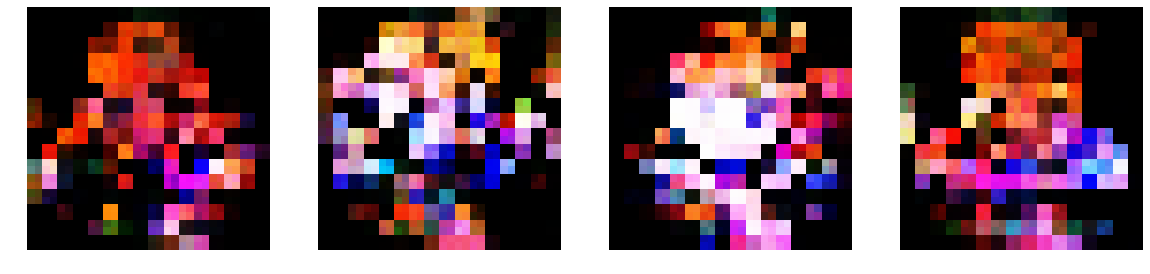

(4, 88, 256, 1)


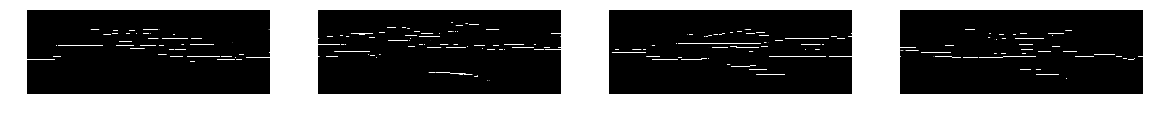

(4, 32, 32, 3)


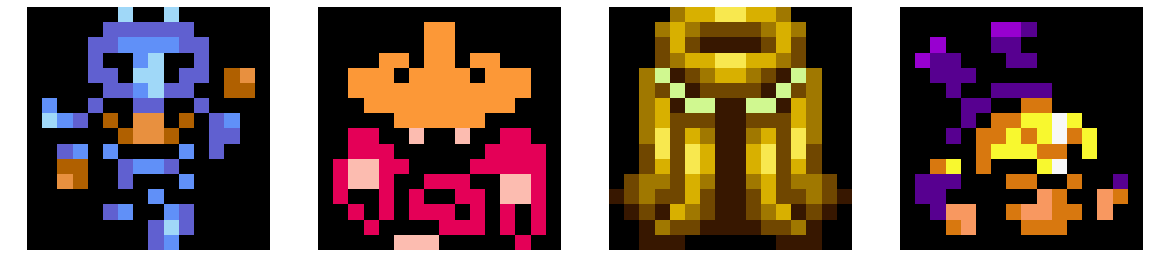

(4, 88, 256, 1)


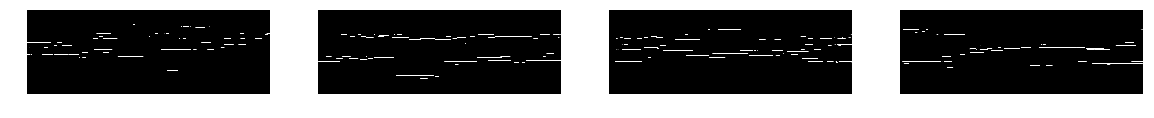

(4, 32, 32, 3)


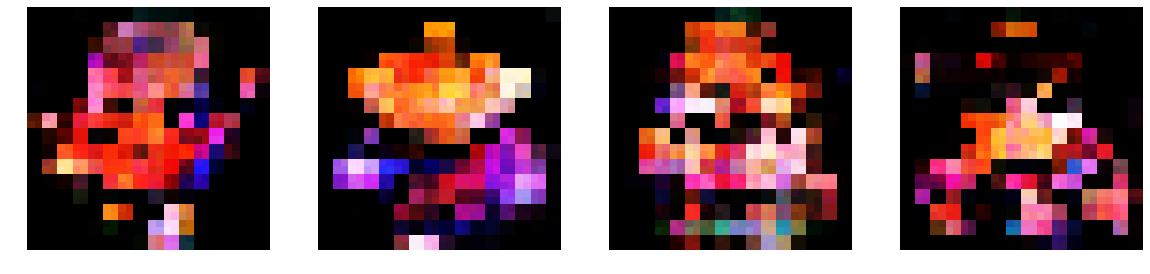

[80/100][27775] Loss_D: 0.024438 0.027856 Loss_G: 0.896935 1.087513 loss_cyc 0.421511 268.521
[80/100][27800] Loss_D: 0.028036 0.037083 Loss_G: 0.949091 1.064132 loss_cyc 0.374012 268.753
[80/100][27825] Loss_D: 0.022555 0.018818 Loss_G: 0.982799 0.982213 loss_cyc 0.378801 268.987
[80/100][27850] Loss_D: 0.015485 0.023822 Loss_G: 0.962394 1.057572 loss_cyc 0.395535 269.227
[80/100][27875] Loss_D: 0.027630 0.015765 Loss_G: 0.890407 1.098607 loss_cyc 0.393887 269.471
[80/100][27900] Loss_D: 0.023023 0.030651 Loss_G: 0.921771 1.044061 loss_cyc 0.396069 269.702
[80/100][27925] Loss_D: 0.021460 0.023778 Loss_G: 0.987507 1.000738 loss_cyc 0.396715 269.936
[80/100][27950] Loss_D: 0.017947 0.024799 Loss_G: 0.936941 0.935422 loss_cyc 0.399666 270.178
[80/100][27975] Loss_D: 0.018639 0.015035 Loss_G: 0.956366 1.011467 loss_cyc 0.392771 270.415
[80/100][28000] Loss_D: 0.028148 0.035174 Loss_G: 0.906813 1.078701 loss_cyc 0.415820 270.648
[80/100][28025] Loss_D: 0.017786 0.012921 Loss_G: 0.970269 0

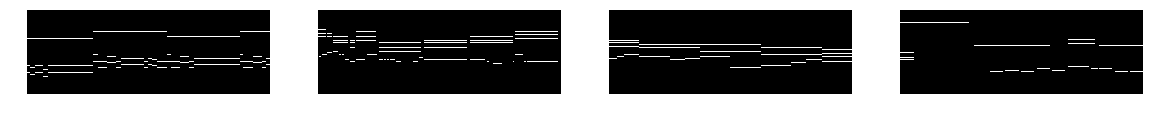

(4, 32, 32, 3)


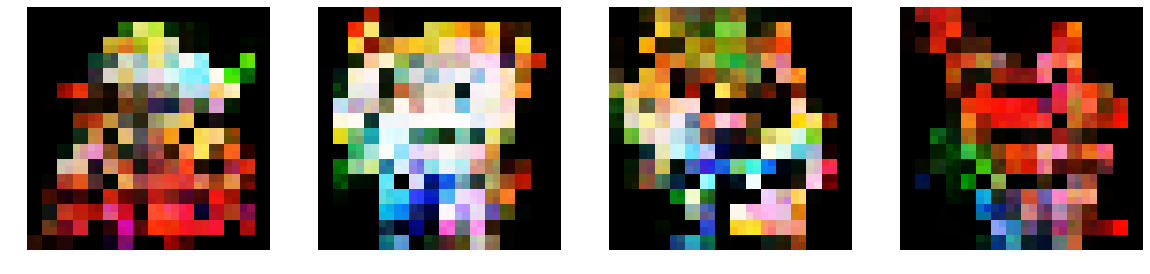

(4, 88, 256, 1)


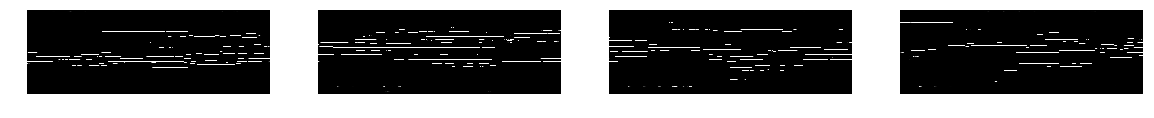

(4, 32, 32, 3)


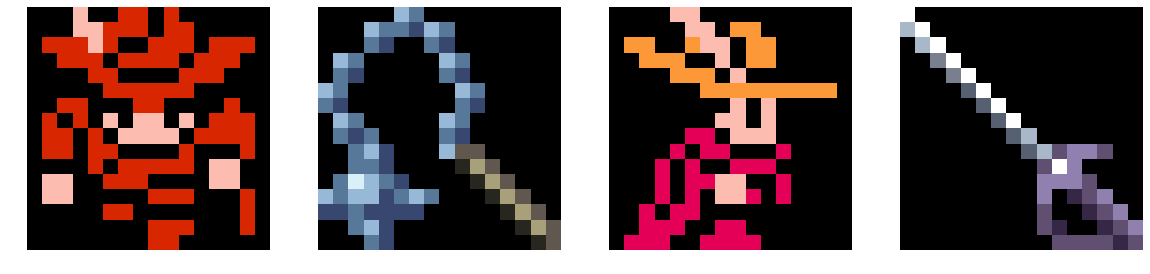

(4, 88, 256, 1)


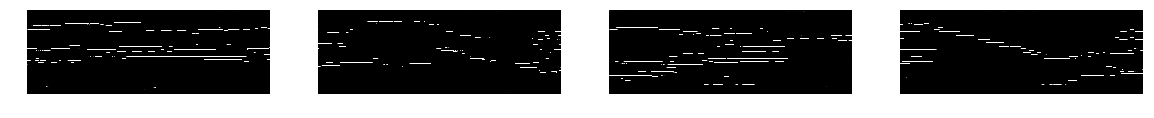

(4, 32, 32, 3)


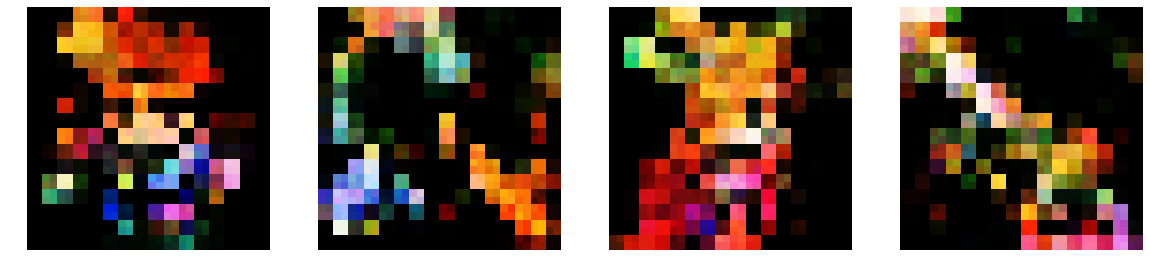

[81/100][28125] Loss_D: 0.016963 0.034154 Loss_G: 0.960613 1.054854 loss_cyc 0.391030 271.900
[81/100][28150] Loss_D: 0.020095 0.035144 Loss_G: 0.985971 0.965504 loss_cyc 0.424229 272.142
[81/100][28175] Loss_D: 0.031645 0.014132 Loss_G: 0.937252 1.027020 loss_cyc 0.387781 272.375
[81/100][28200] Loss_D: 0.020453 0.018098 Loss_G: 0.918788 1.017056 loss_cyc 0.398903 272.617
[81/100][28225] Loss_D: 0.023025 0.021230 Loss_G: 0.998423 1.011300 loss_cyc 0.380298 272.864
[81/100][28250] Loss_D: 0.020982 0.026140 Loss_G: 0.929907 1.081529 loss_cyc 0.386969 273.099
[81/100][28275] Loss_D: 0.026815 0.026099 Loss_G: 0.985272 1.035160 loss_cyc 0.411116 273.334
[81/100][28300] Loss_D: 0.019109 0.032817 Loss_G: 0.969700 1.076564 loss_cyc 0.385474 273.574
[81/100][28325] Loss_D: 0.025005 0.035425 Loss_G: 0.962747 1.009141 loss_cyc 0.400538 273.805
[81/100][28350] Loss_D: 0.012371 0.021228 Loss_G: 0.999533 0.971133 loss_cyc 0.392742 274.044
[81/100][28375] Loss_D: 0.023197 0.014244 Loss_G: 0.953920 1

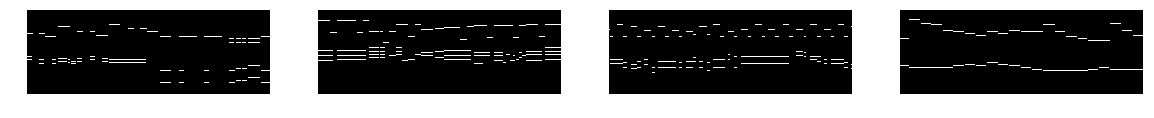

(4, 32, 32, 3)


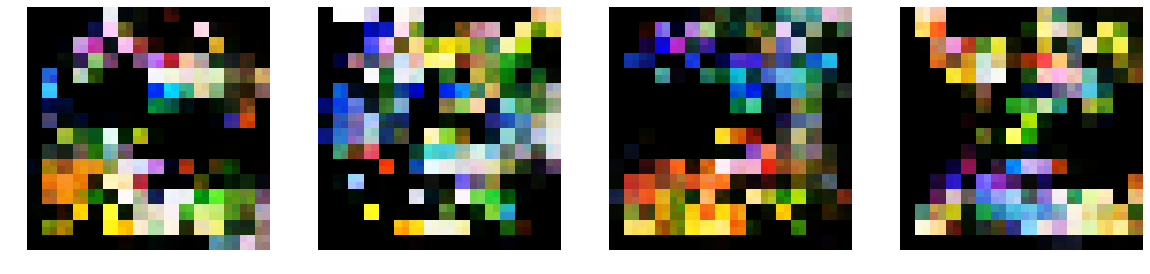

(4, 88, 256, 1)


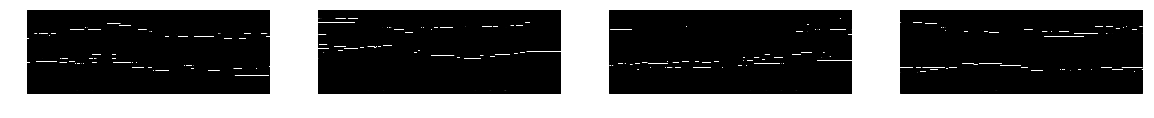

(4, 32, 32, 3)


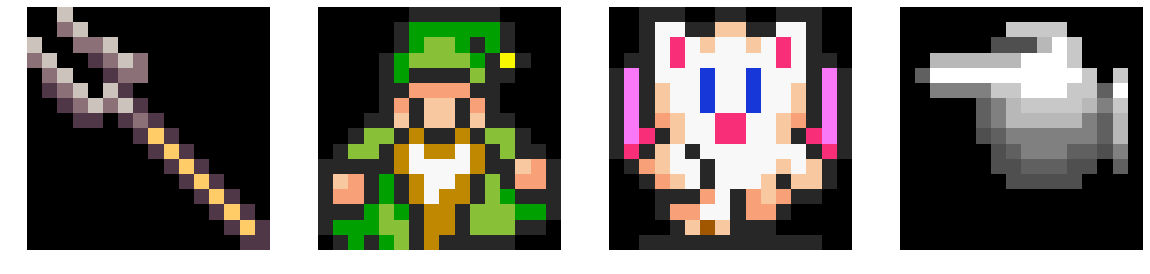

(4, 88, 256, 1)


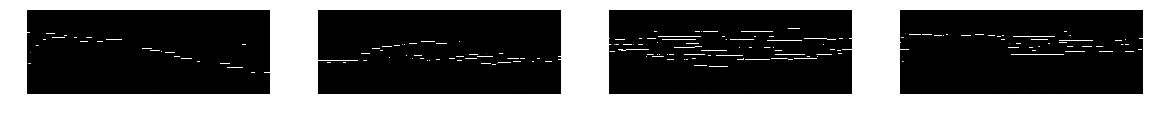

(4, 32, 32, 3)


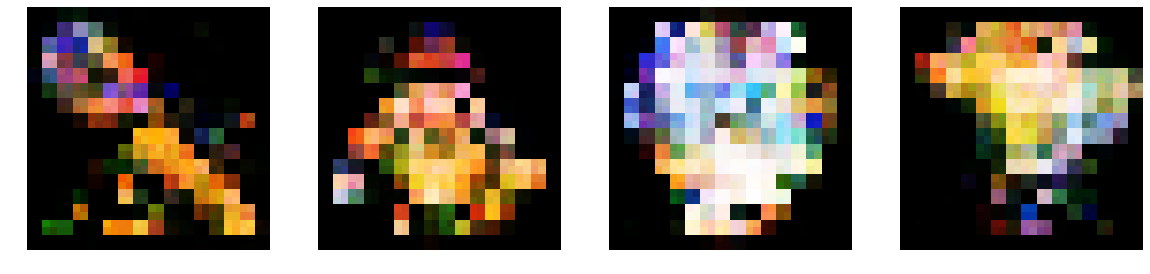

[82/100][28475] Loss_D: 0.023849 0.016879 Loss_G: 0.952169 0.958487 loss_cyc 0.367205 275.293
[82/100][28500] Loss_D: 0.026518 0.034449 Loss_G: 0.937826 1.085582 loss_cyc 0.378007 275.540
[82/100][28525] Loss_D: 0.023136 0.029027 Loss_G: 0.904635 1.079242 loss_cyc 0.358975 275.780
[82/100][28550] Loss_D: 0.030579 0.020856 Loss_G: 0.901259 0.951100 loss_cyc 0.363566 276.023
[82/100][28575] Loss_D: 0.017915 0.024731 Loss_G: 1.008312 0.995930 loss_cyc 0.379120 276.249
[82/100][28600] Loss_D: 0.018666 0.026268 Loss_G: 0.964884 0.963852 loss_cyc 0.368994 276.482
[82/100][28625] Loss_D: 0.018561 0.026278 Loss_G: 0.964272 0.997983 loss_cyc 0.364582 276.720
[82/100][28650] Loss_D: 0.020861 0.040665 Loss_G: 0.965111 1.066109 loss_cyc 0.399941 276.962
[82/100][28675] Loss_D: 0.016072 0.024190 Loss_G: 0.966035 1.036910 loss_cyc 0.370400 277.203
[82/100][28700] Loss_D: 0.024987 0.017277 Loss_G: 0.930680 1.001700 loss_cyc 0.368764 277.439
[82/100][28725] Loss_D: 0.018099 0.028715 Loss_G: 0.906818 1

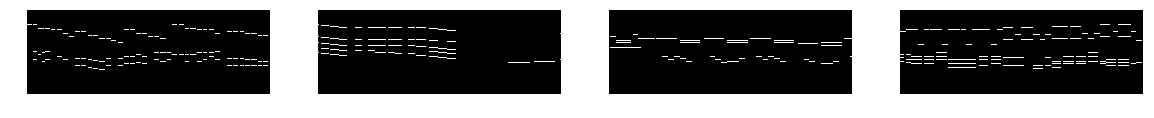

(4, 32, 32, 3)


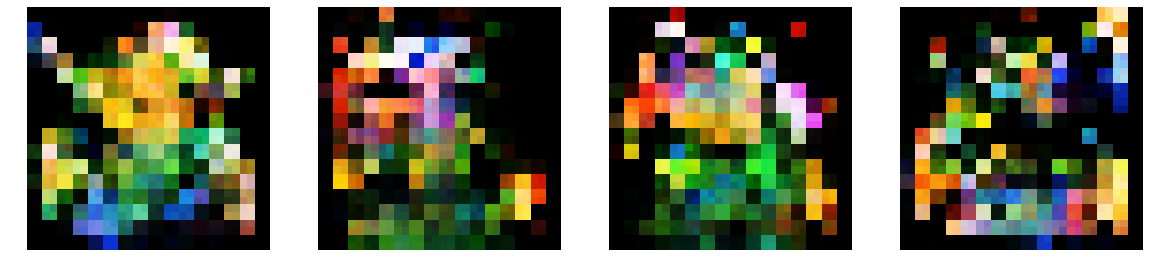

(4, 88, 256, 1)


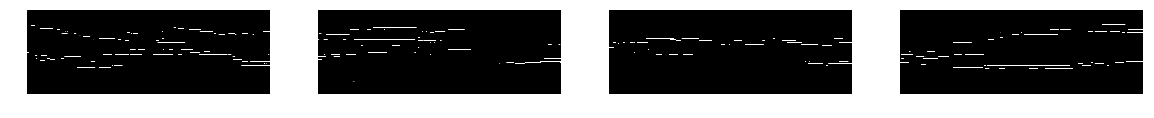

(4, 32, 32, 3)


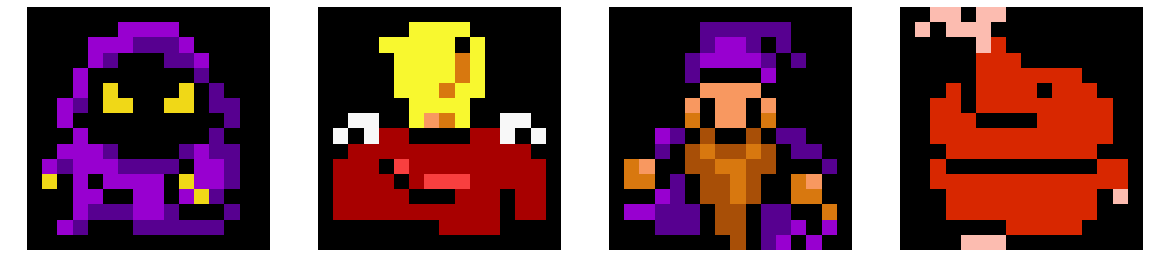

(4, 88, 256, 1)


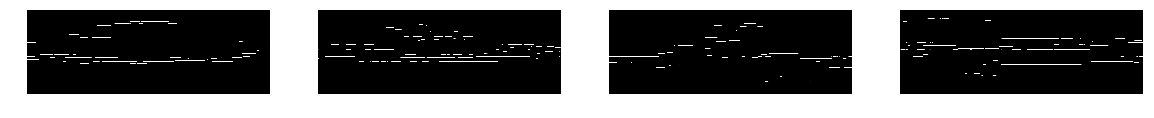

(4, 32, 32, 3)


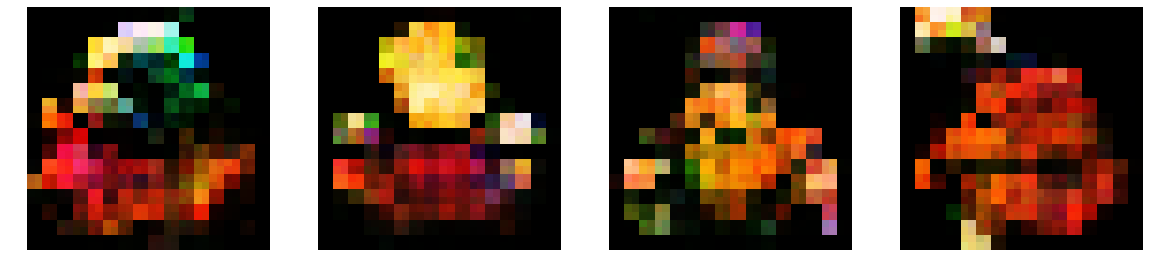

[83/100][28825] Loss_D: 0.018474 0.037919 Loss_G: 0.919890 1.026358 loss_cyc 0.387763 278.664
[83/100][28850] Loss_D: 0.032535 0.017900 Loss_G: 0.952336 1.054688 loss_cyc 0.367883 278.896
[83/100][28875] Loss_D: 0.016654 0.038660 Loss_G: 0.982731 0.984661 loss_cyc 0.384094 279.127
[83/100][28900] Loss_D: 0.029178 0.040164 Loss_G: 0.970698 1.030228 loss_cyc 0.360422 279.375
[83/100][28925] Loss_D: 0.033797 0.034006 Loss_G: 0.932779 1.026447 loss_cyc 0.392994 279.614
[83/100][28950] Loss_D: 0.031477 0.026949 Loss_G: 0.951683 1.036187 loss_cyc 0.389596 279.851
[83/100][28975] Loss_D: 0.014302 0.044589 Loss_G: 0.943356 1.047254 loss_cyc 0.353335 280.093
[83/100][29000] Loss_D: 0.033287 0.017702 Loss_G: 0.885398 1.007806 loss_cyc 0.399500 280.322
[83/100][29025] Loss_D: 0.022833 0.018899 Loss_G: 0.959298 1.024459 loss_cyc 0.387694 280.553
[83/100][29050] Loss_D: 0.026372 0.023441 Loss_G: 0.966732 0.969521 loss_cyc 0.381440 280.797
[83/100][29075] Loss_D: 0.022088 0.025147 Loss_G: 1.014994 1

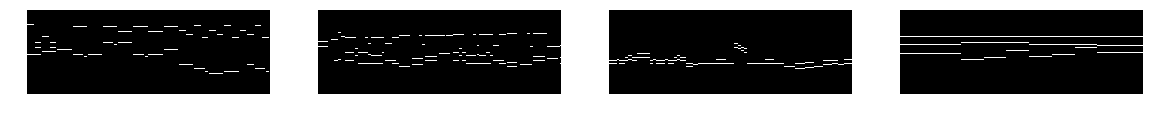

(4, 32, 32, 3)


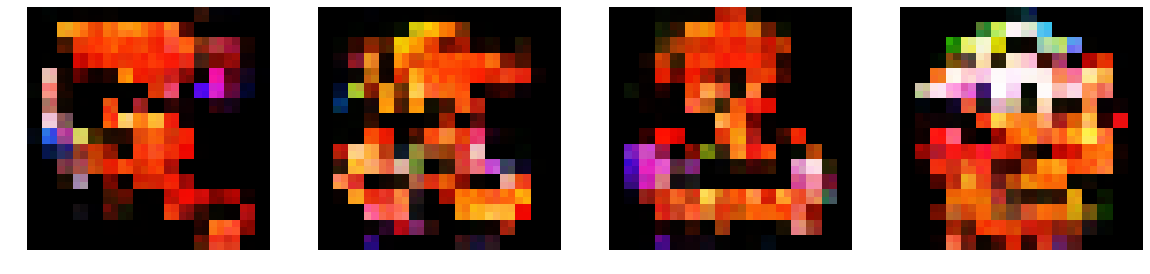

(4, 88, 256, 1)


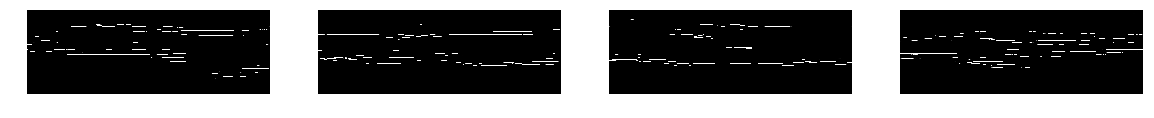

(4, 32, 32, 3)


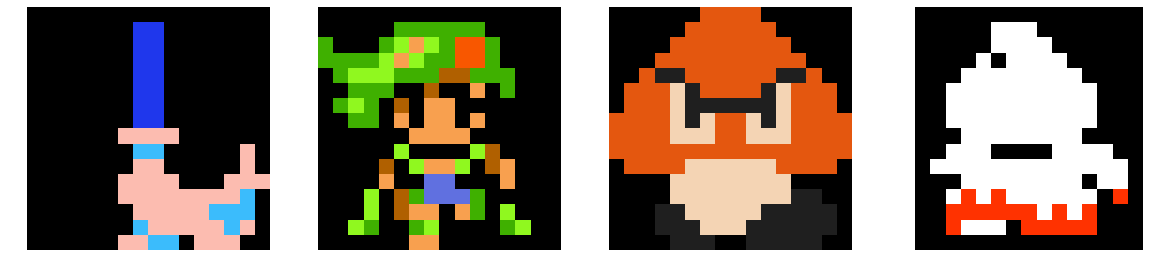

(4, 88, 256, 1)


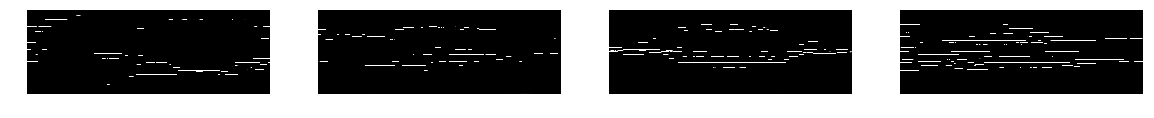

(4, 32, 32, 3)


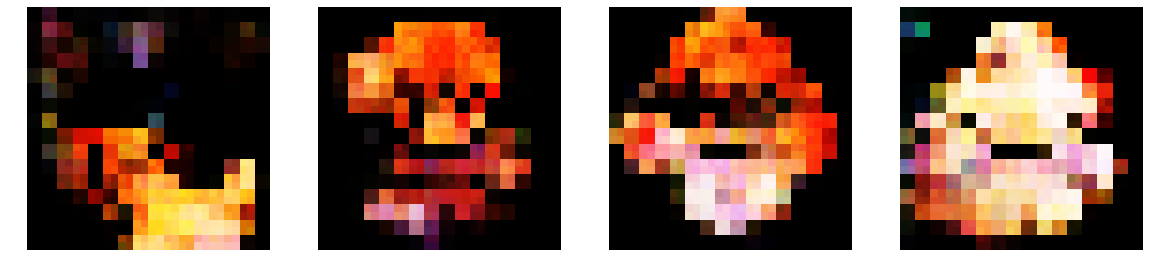

[84/100][29175] Loss_D: 0.020664 0.023803 Loss_G: 0.904987 1.032839 loss_cyc 0.388069 282.019
[84/100][29200] Loss_D: 0.019797 0.034945 Loss_G: 1.007872 1.008664 loss_cyc 0.387771 282.250
[84/100][29225] Loss_D: 0.021442 0.019595 Loss_G: 0.958284 1.028314 loss_cyc 0.360042 282.479
[84/100][29250] Loss_D: 0.026497 0.031703 Loss_G: 0.958980 1.042003 loss_cyc 0.390597 282.714
[84/100][29275] Loss_D: 0.016983 0.017985 Loss_G: 0.952709 0.970259 loss_cyc 0.371358 282.941
[84/100][29300] Loss_D: 0.028560 0.020208 Loss_G: 0.943505 1.053986 loss_cyc 0.387179 283.185
[84/100][29325] Loss_D: 0.013126 0.022485 Loss_G: 0.942412 1.002001 loss_cyc 0.386343 283.424
[84/100][29350] Loss_D: 0.020268 0.055558 Loss_G: 0.947556 0.991766 loss_cyc 0.399351 283.676
[84/100][29375] Loss_D: 0.026826 0.027226 Loss_G: 0.913069 0.972394 loss_cyc 0.370832 283.913
[84/100][29400] Loss_D: 0.016727 0.018513 Loss_G: 0.966708 1.021928 loss_cyc 0.390963 284.149
[84/100][29425] Loss_D: 0.021661 0.030384 Loss_G: 0.924038 0

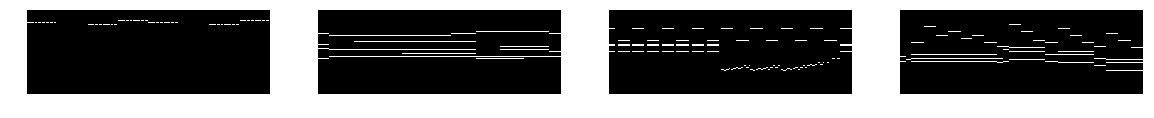

(4, 32, 32, 3)


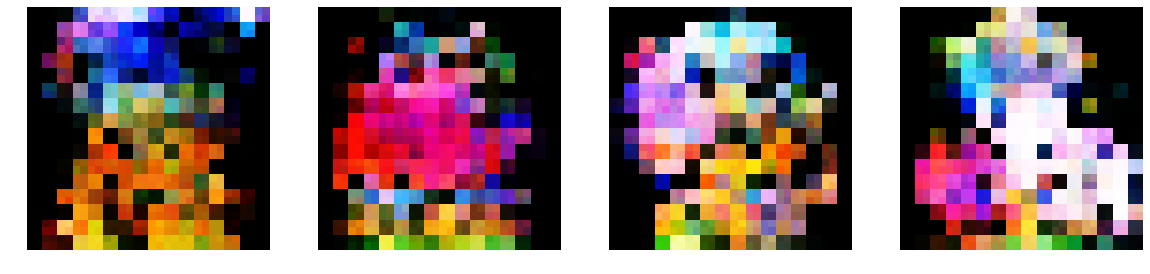

(4, 88, 256, 1)


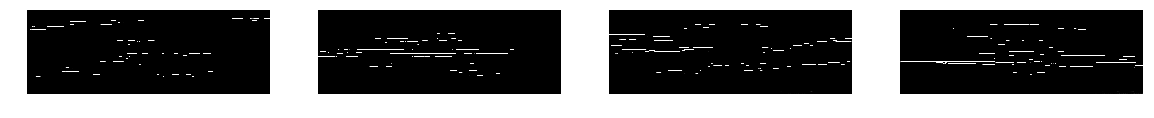

(4, 32, 32, 3)


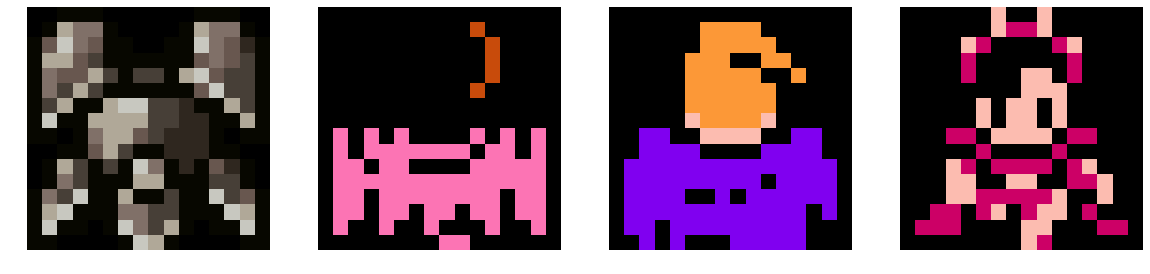

(4, 88, 256, 1)


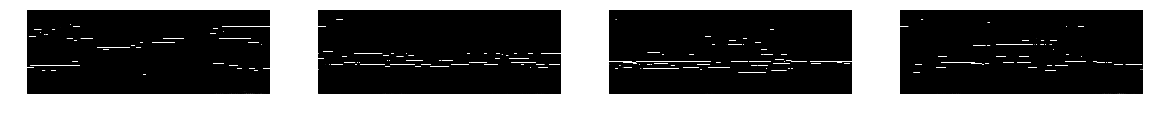

(4, 32, 32, 3)


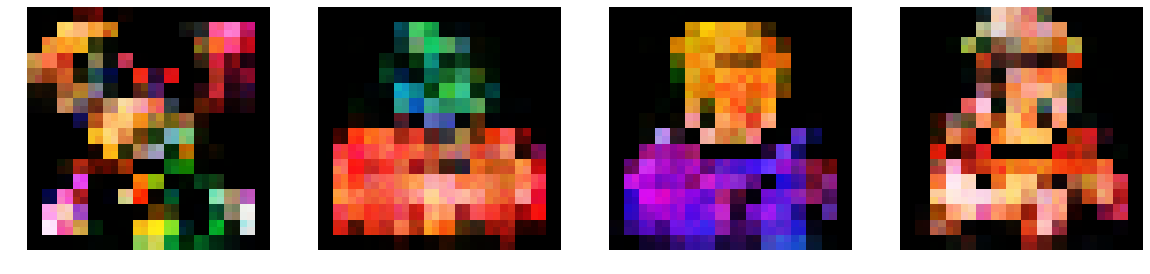

[85/100][29500] Loss_D: 0.017113 0.031736 Loss_G: 0.927388 1.026224 loss_cyc 0.407152 285.166
[85/100][29525] Loss_D: 0.015498 0.020331 Loss_G: 0.986628 1.022907 loss_cyc 0.417531 285.401
[85/100][29550] Loss_D: 0.016670 0.041584 Loss_G: 0.968476 1.122204 loss_cyc 0.376929 285.635
[85/100][29575] Loss_D: 0.026048 0.038922 Loss_G: 0.912188 1.058383 loss_cyc 0.386980 285.878
[85/100][29600] Loss_D: 0.019916 0.032261 Loss_G: 0.995589 1.015536 loss_cyc 0.399554 286.113
[85/100][29625] Loss_D: 0.017241 0.018906 Loss_G: 0.991058 1.000430 loss_cyc 0.400231 286.345
[85/100][29650] Loss_D: 0.028623 0.022207 Loss_G: 0.877178 1.016046 loss_cyc 0.387436 286.585
[85/100][29675] Loss_D: 0.017508 0.040295 Loss_G: 0.950998 1.096643 loss_cyc 0.404550 286.829
[85/100][29700] Loss_D: 0.020977 0.016342 Loss_G: 0.955820 0.997635 loss_cyc 0.354373 287.067
[85/100][29725] Loss_D: 0.018731 0.030793 Loss_G: 0.949150 0.948139 loss_cyc 0.384745 287.299
[85/100][29750] Loss_D: 0.017207 0.026515 Loss_G: 1.009108 0

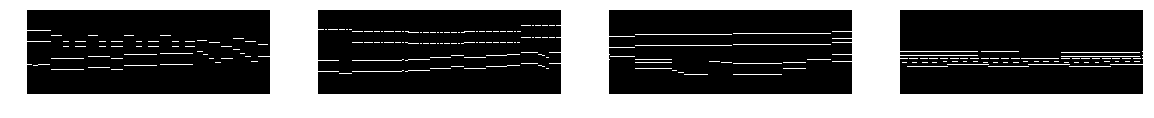

(4, 32, 32, 3)


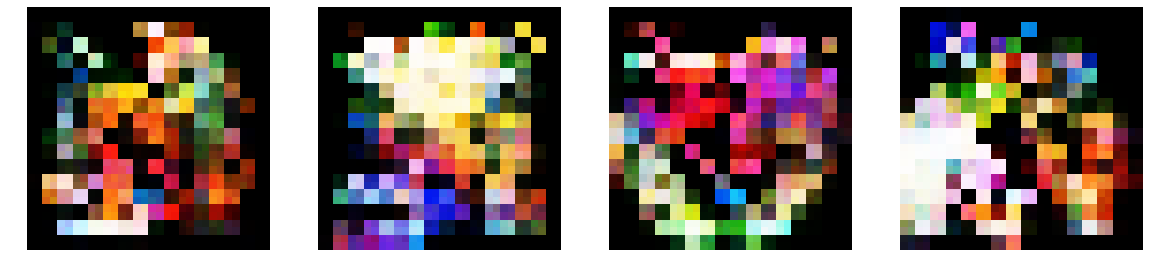

(4, 88, 256, 1)


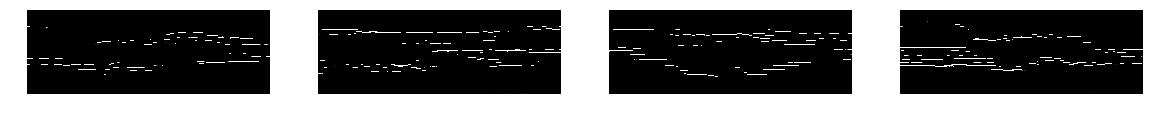

(4, 32, 32, 3)


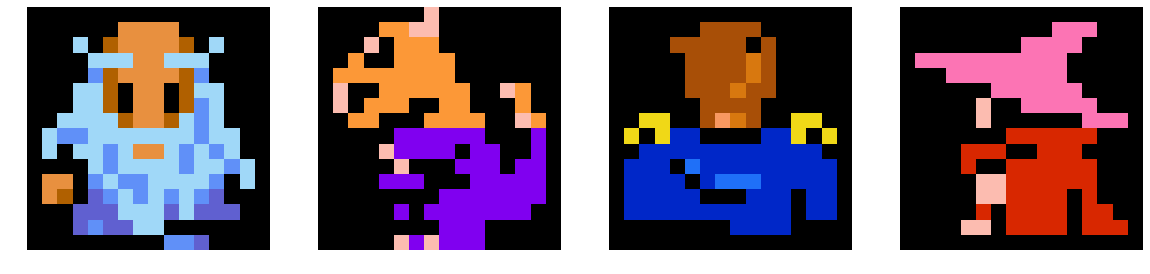

(4, 88, 256, 1)


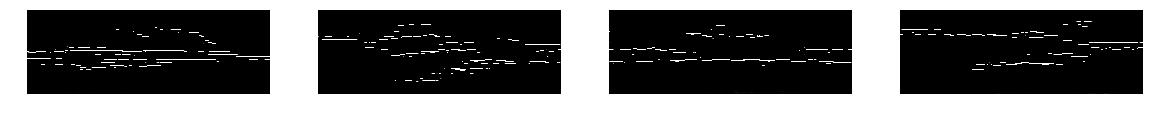

(4, 32, 32, 3)


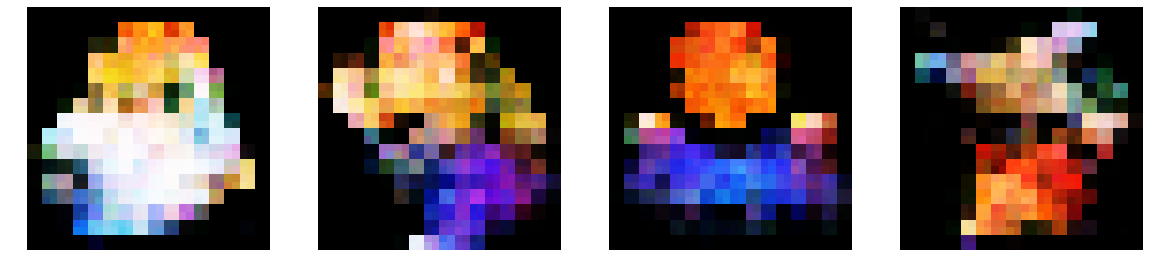

[86/100][29850] Loss_D: 0.032201 0.016659 Loss_G: 0.930739 1.020118 loss_cyc 0.403499 288.547
[86/100][29875] Loss_D: 0.025378 0.015314 Loss_G: 0.919696 0.983129 loss_cyc 0.395660 288.779
[86/100][29900] Loss_D: 0.018806 0.008137 Loss_G: 1.010378 1.027040 loss_cyc 0.369073 289.007
[86/100][29925] Loss_D: 0.018299 0.013315 Loss_G: 0.937246 1.011579 loss_cyc 0.349463 289.242
[86/100][29950] Loss_D: 0.027499 0.018009 Loss_G: 0.943847 0.989665 loss_cyc 0.354447 289.472
[86/100][29975] Loss_D: 0.012411 0.016717 Loss_G: 0.945968 0.967894 loss_cyc 0.367101 289.719
[86/100][30000] Loss_D: 0.022658 0.027825 Loss_G: 0.931530 1.104385 loss_cyc 0.371995 289.960
[86/100][30025] Loss_D: 0.016801 0.027186 Loss_G: 0.993533 1.055205 loss_cyc 0.370755 290.200
[86/100][30050] Loss_D: 0.018056 0.017182 Loss_G: 0.916534 1.094385 loss_cyc 0.384812 290.426
[86/100][30075] Loss_D: 0.019424 0.031797 Loss_G: 0.948957 1.019259 loss_cyc 0.387610 290.666
[86/100][30100] Loss_D: 0.016936 0.029541 Loss_G: 0.973308 0

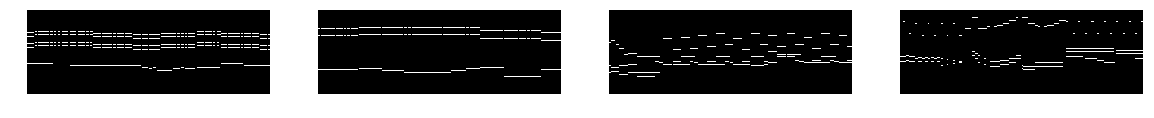

(4, 32, 32, 3)


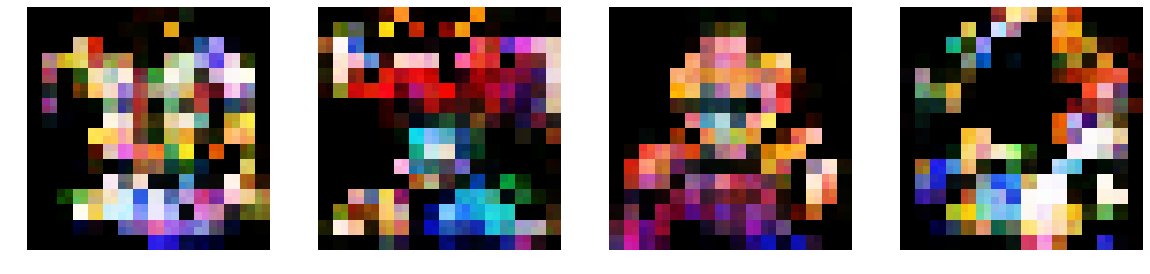

(4, 88, 256, 1)


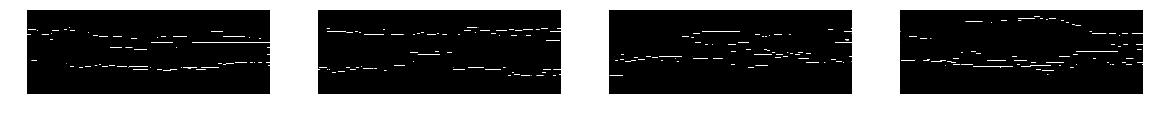

(4, 32, 32, 3)


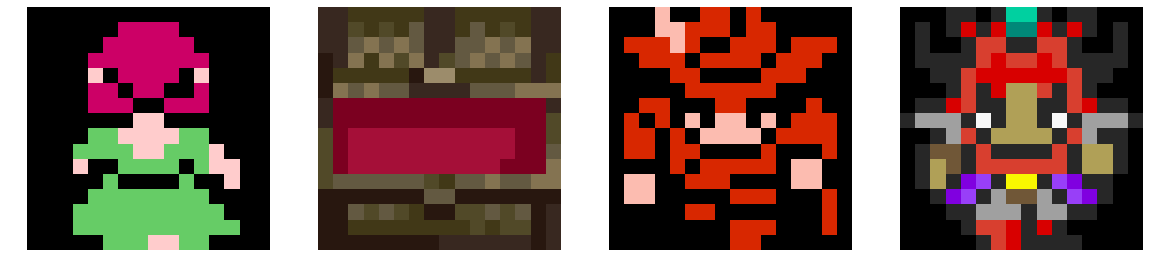

(4, 88, 256, 1)


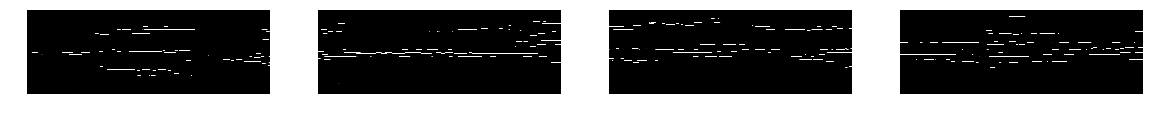

(4, 32, 32, 3)


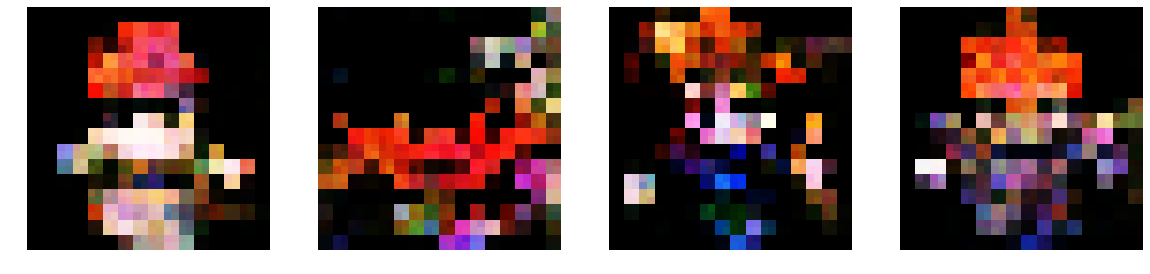

[87/100][30200] Loss_D: 0.033844 0.022331 Loss_G: 0.923089 0.973387 loss_cyc 0.384141 291.919
[87/100][30225] Loss_D: 0.026664 0.041396 Loss_G: 0.913575 1.091636 loss_cyc 0.409695 292.151
[87/100][30250] Loss_D: 0.028874 0.044734 Loss_G: 0.919006 1.031324 loss_cyc 0.372103 292.379
[87/100][30275] Loss_D: 0.025397 0.020579 Loss_G: 0.972770 0.990959 loss_cyc 0.373076 292.619
[87/100][30300] Loss_D: 0.018115 0.046419 Loss_G: 0.993164 1.017576 loss_cyc 0.380412 292.841
[87/100][30325] Loss_D: 0.027733 0.031084 Loss_G: 0.943855 0.928952 loss_cyc 0.382518 293.074
[87/100][30350] Loss_D: 0.022215 0.034505 Loss_G: 0.919883 1.029572 loss_cyc 0.401920 293.317
[87/100][30375] Loss_D: 0.022928 0.026995 Loss_G: 0.939623 0.991098 loss_cyc 0.372705 293.553
[87/100][30400] Loss_D: 0.040076 0.024124 Loss_G: 0.930348 0.925299 loss_cyc 0.364680 293.799
[87/100][30425] Loss_D: 0.052747 0.019209 Loss_G: 0.899652 0.981359 loss_cyc 0.358420 294.030
[87/100][30450] Loss_D: 0.020108 0.017997 Loss_G: 0.986412 0

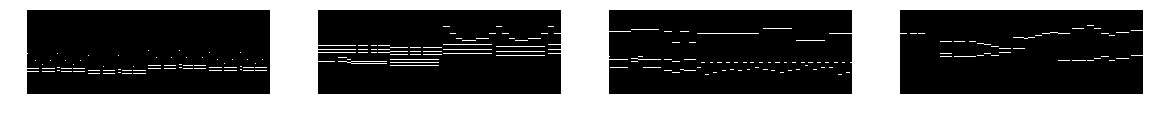

(4, 32, 32, 3)


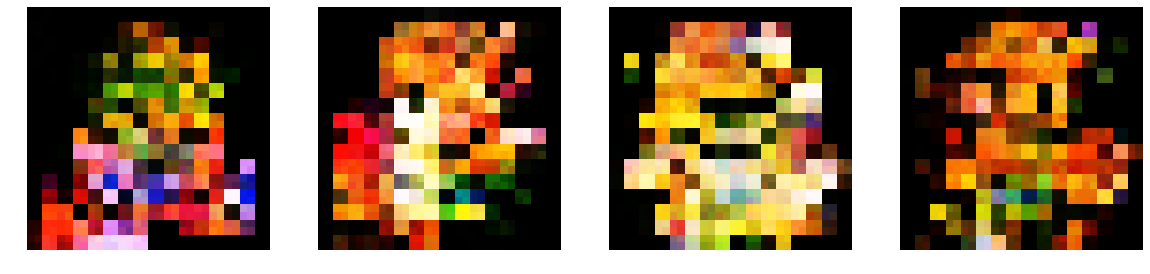

(4, 88, 256, 1)


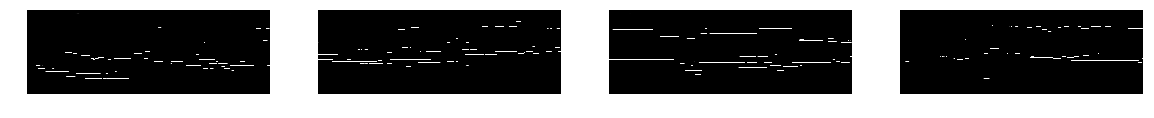

(4, 32, 32, 3)


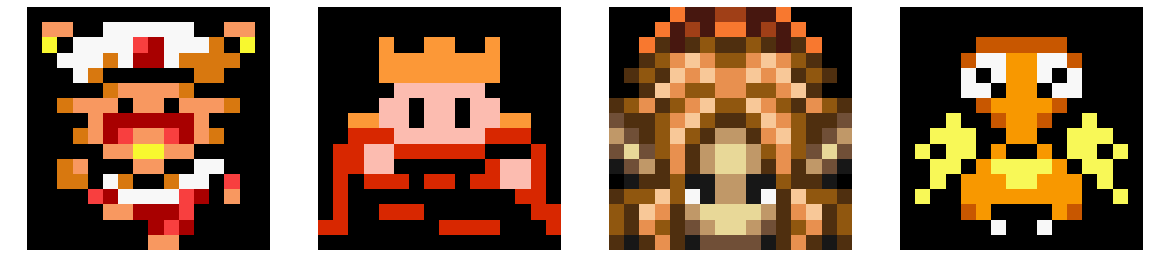

(4, 88, 256, 1)


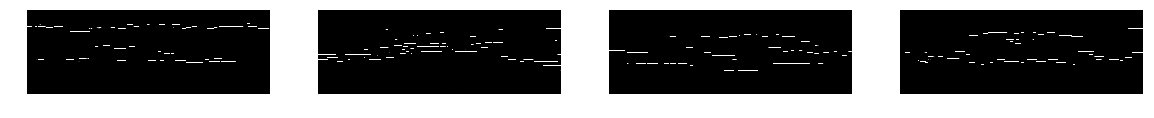

(4, 32, 32, 3)


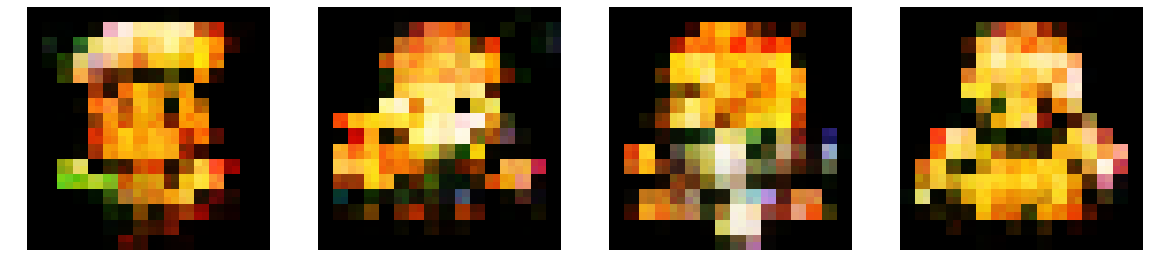

[88/100][30550] Loss_D: 0.024095 0.034726 Loss_G: 0.948207 1.028076 loss_cyc 0.397458 295.300
[88/100][30575] Loss_D: 0.019684 0.025259 Loss_G: 0.996951 1.096797 loss_cyc 0.361002 295.535
[88/100][30600] Loss_D: 0.017280 0.017429 Loss_G: 0.994640 1.038447 loss_cyc 0.392427 295.766
[88/100][30625] Loss_D: 0.024241 0.035358 Loss_G: 0.966521 1.020516 loss_cyc 0.373710 295.993
[88/100][30650] Loss_D: 0.018350 0.025499 Loss_G: 0.966989 0.960349 loss_cyc 0.370773 296.236
[88/100][30675] Loss_D: 0.027272 0.016820 Loss_G: 0.965635 1.043565 loss_cyc 0.355785 296.470
[88/100][30700] Loss_D: 0.023199 0.014728 Loss_G: 0.929027 0.982354 loss_cyc 0.387949 296.713
[88/100][30725] Loss_D: 0.020563 0.040836 Loss_G: 0.942581 1.078741 loss_cyc 0.376489 296.946
[88/100][30750] Loss_D: 0.023726 0.024024 Loss_G: 0.968434 1.004312 loss_cyc 0.358022 297.192
[88/100][30775] Loss_D: 0.015724 0.023784 Loss_G: 0.940847 0.983355 loss_cyc 0.387897 297.431
[88/100][30800] Loss_D: 0.016611 0.025836 Loss_G: 0.956271 1

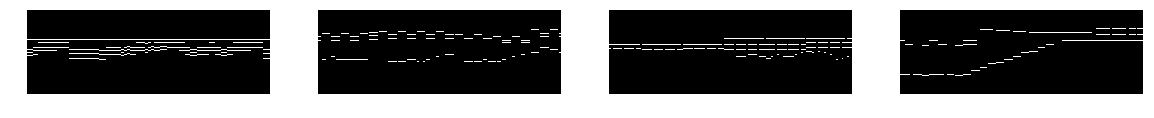

(4, 32, 32, 3)


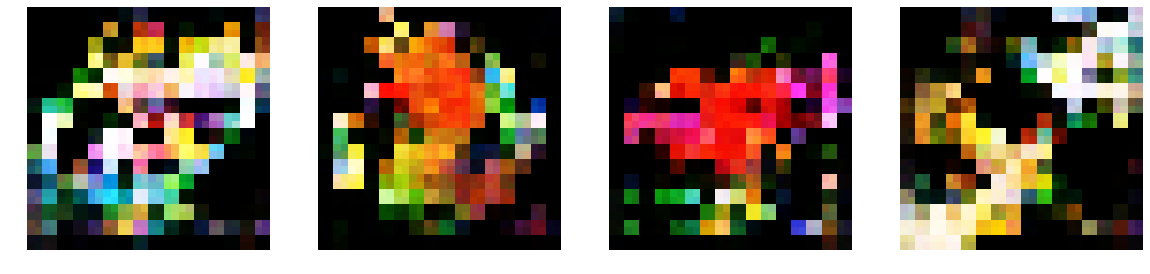

(4, 88, 256, 1)


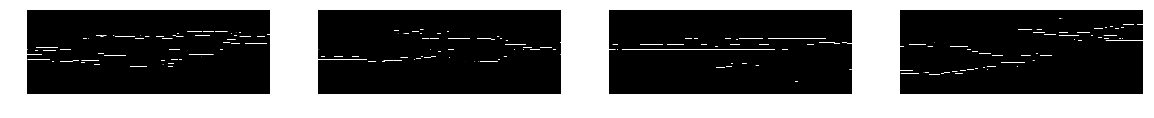

(4, 32, 32, 3)


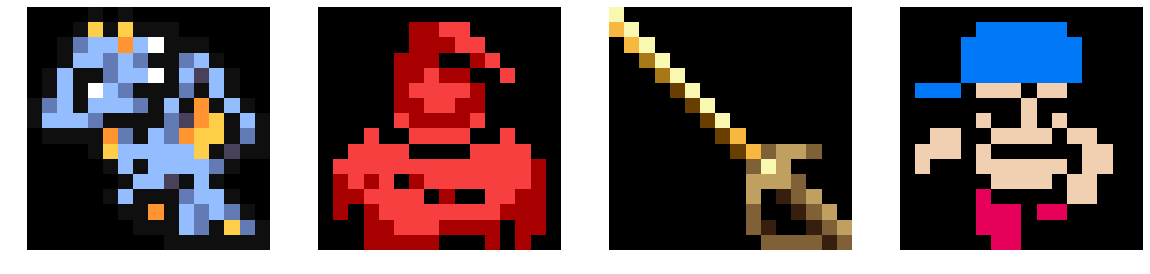

(4, 88, 256, 1)


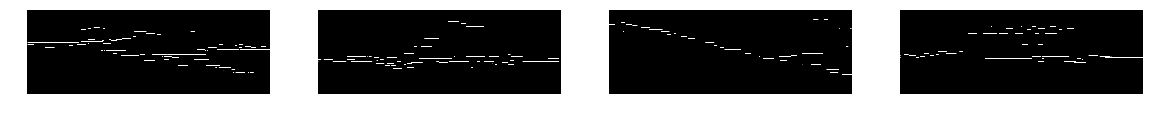

(4, 32, 32, 3)


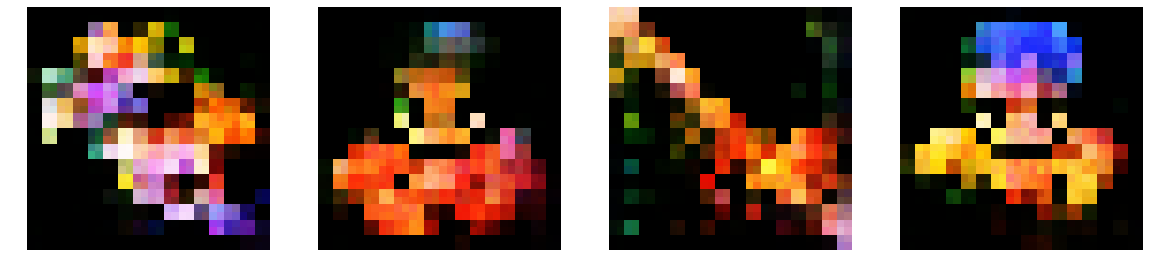

[89/100][30900] Loss_D: 0.030726 0.020839 Loss_G: 0.992093 0.918037 loss_cyc 0.380924 298.676
[89/100][30925] Loss_D: 0.021324 0.036507 Loss_G: 0.942913 0.973349 loss_cyc 0.364681 298.919
[89/100][30950] Loss_D: 0.024146 0.021588 Loss_G: 0.954502 1.002097 loss_cyc 0.396151 299.176
[89/100][30975] Loss_D: 0.015483 0.025031 Loss_G: 0.985479 0.971159 loss_cyc 0.385514 299.404
[89/100][31000] Loss_D: 0.019724 0.018119 Loss_G: 0.964797 1.017196 loss_cyc 0.387423 299.655
[89/100][31025] Loss_D: 0.016167 0.023358 Loss_G: 0.944579 1.036206 loss_cyc 0.387686 299.886
[89/100][31050] Loss_D: 0.016610 0.012326 Loss_G: 0.961639 0.911234 loss_cyc 0.405924 300.121
[89/100][31075] Loss_D: 0.012597 0.027953 Loss_G: 0.995345 1.031588 loss_cyc 0.371642 300.354
[89/100][31100] Loss_D: 0.020758 0.036149 Loss_G: 0.956265 1.093642 loss_cyc 0.373651 300.590
[89/100][31125] Loss_D: 0.016679 0.013357 Loss_G: 0.971395 1.021552 loss_cyc 0.358568 300.828
[89/100][31150] Loss_D: 0.013125 0.019872 Loss_G: 0.948297 0

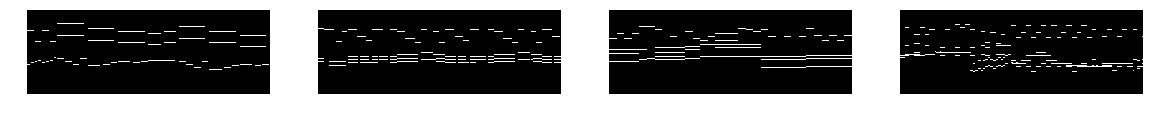

(4, 32, 32, 3)


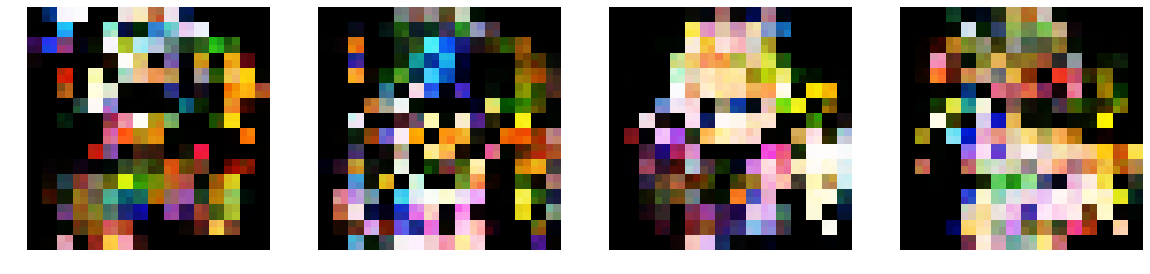

(4, 88, 256, 1)


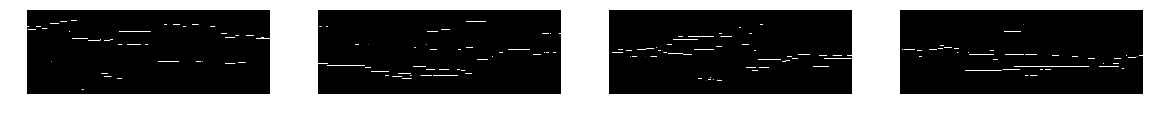

(4, 32, 32, 3)


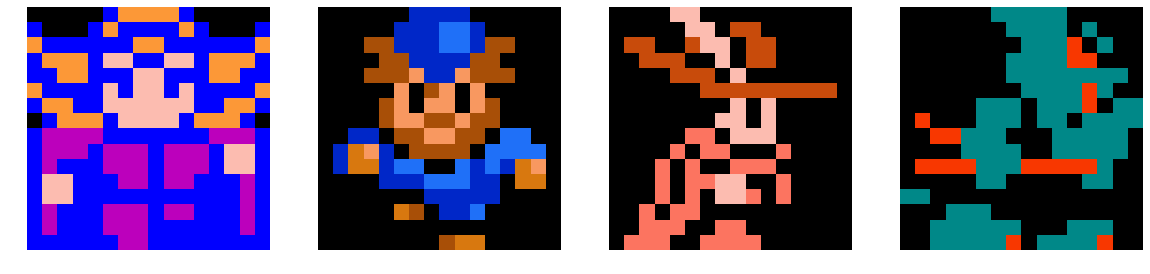

(4, 88, 256, 1)


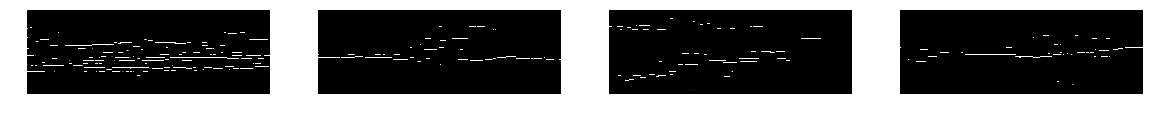

(4, 32, 32, 3)


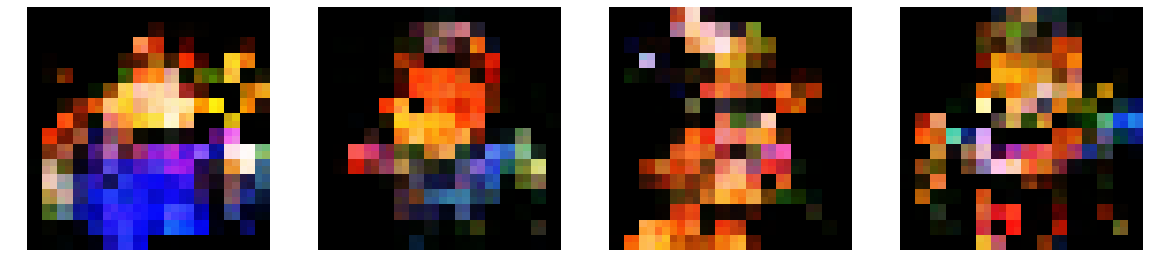

[90/100][31250] Loss_D: 0.021981 0.011886 Loss_G: 0.928944 0.998285 loss_cyc 0.372117 302.061
[90/100][31275] Loss_D: 0.031762 0.035598 Loss_G: 0.924251 0.966080 loss_cyc 0.368564 302.306
[90/100][31300] Loss_D: 0.020663 0.019099 Loss_G: 0.962338 0.968166 loss_cyc 0.378709 302.546
[90/100][31325] Loss_D: 0.013770 0.019807 Loss_G: 0.990641 1.040065 loss_cyc 0.381042 302.786
[90/100][31350] Loss_D: 0.015260 0.018643 Loss_G: 0.971045 1.087652 loss_cyc 0.374608 303.024
[90/100][31375] Loss_D: 0.024521 0.029049 Loss_G: 0.962807 1.023025 loss_cyc 0.381243 303.253
[90/100][31400] Loss_D: 0.012317 0.020767 Loss_G: 0.993155 1.020427 loss_cyc 0.364310 303.487
[90/100][31425] Loss_D: 0.025239 0.023317 Loss_G: 0.924156 0.957278 loss_cyc 0.364170 303.728
[90/100][31450] Loss_D: 0.019627 0.018243 Loss_G: 0.987515 1.025956 loss_cyc 0.399202 303.978
[90/100][31475] Loss_D: 0.014856 0.022816 Loss_G: 0.953412 0.999925 loss_cyc 0.420555 304.202
[90/100][31500] Loss_D: 0.018930 0.011542 Loss_G: 0.964397 1

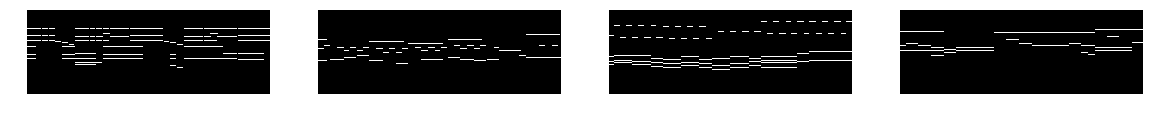

(4, 32, 32, 3)


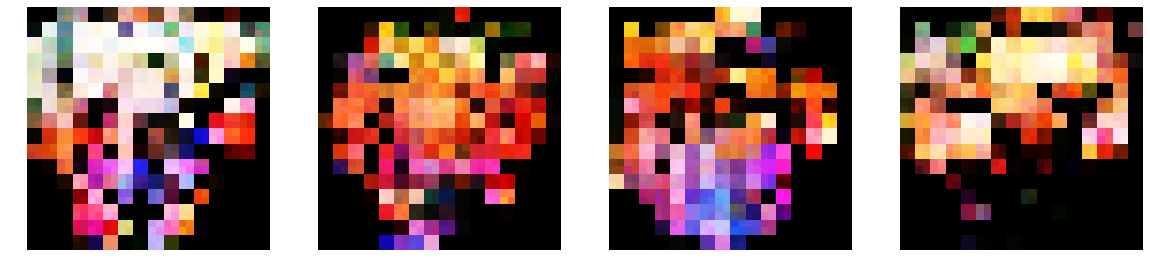

(4, 88, 256, 1)


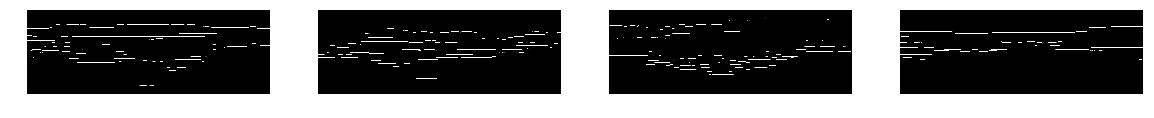

(4, 32, 32, 3)


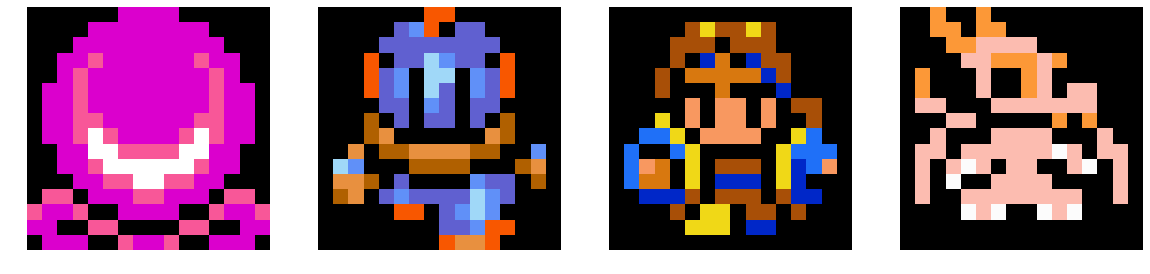

(4, 88, 256, 1)


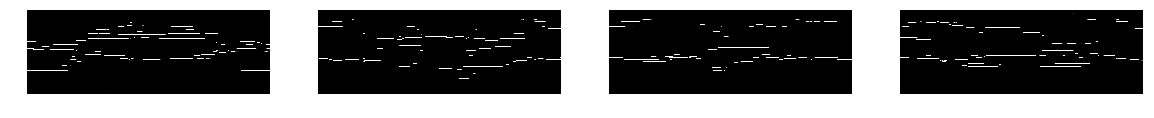

(4, 32, 32, 3)


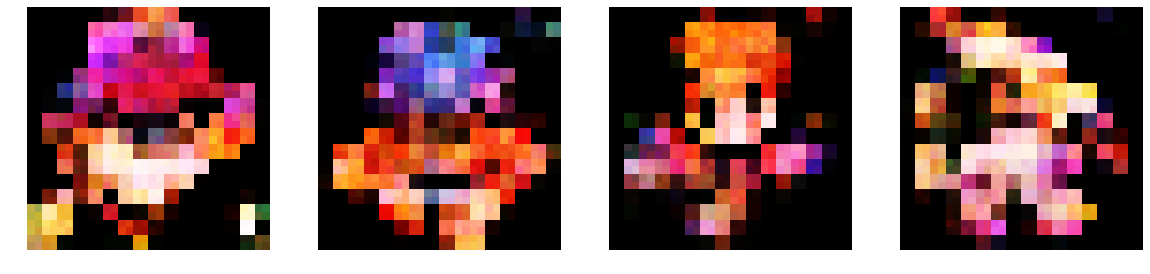

[91/100][31600] Loss_D: 0.016115 0.029439 Loss_G: 0.979189 1.088966 loss_cyc 0.369042 305.444
[91/100][31625] Loss_D: 0.018570 0.017298 Loss_G: 0.963405 0.957977 loss_cyc 0.380433 305.688
[91/100][31650] Loss_D: 0.012434 0.022275 Loss_G: 0.971544 0.980479 loss_cyc 0.383895 305.925
[91/100][31675] Loss_D: 0.025005 0.019017 Loss_G: 0.968769 1.077335 loss_cyc 0.386236 306.167
[91/100][31700] Loss_D: 0.014185 0.009059 Loss_G: 0.979634 0.993251 loss_cyc 0.352119 306.390
[91/100][31725] Loss_D: 0.018368 0.012372 Loss_G: 0.955387 1.007759 loss_cyc 0.370586 306.631
[91/100][31750] Loss_D: 0.011388 0.017078 Loss_G: 0.975916 0.994944 loss_cyc 0.375217 306.872
[91/100][31775] Loss_D: 0.009986 0.022787 Loss_G: 0.963790 0.995974 loss_cyc 0.361894 307.106
[91/100][31800] Loss_D: 0.015712 0.012258 Loss_G: 0.978781 0.998099 loss_cyc 0.357253 307.340
[91/100][31825] Loss_D: 0.015346 0.022478 Loss_G: 1.021482 1.020684 loss_cyc 0.410114 307.573
[91/100][31850] Loss_D: 0.014888 0.015586 Loss_G: 0.941786 1

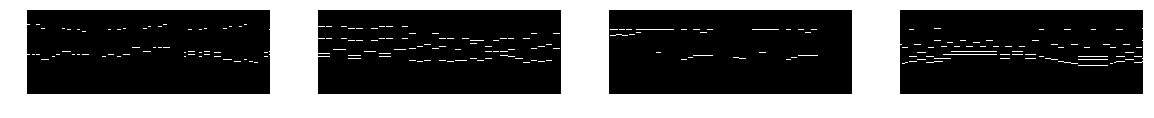

(4, 32, 32, 3)


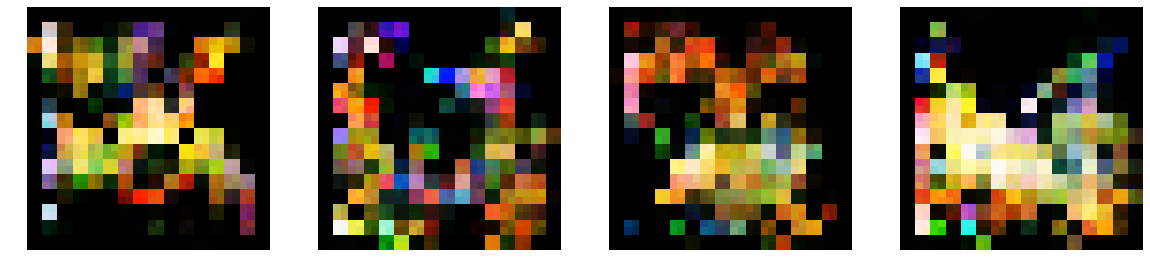

(4, 88, 256, 1)


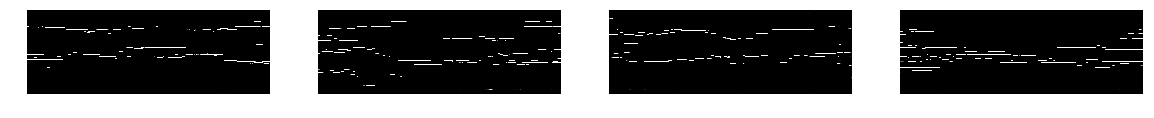

(4, 32, 32, 3)


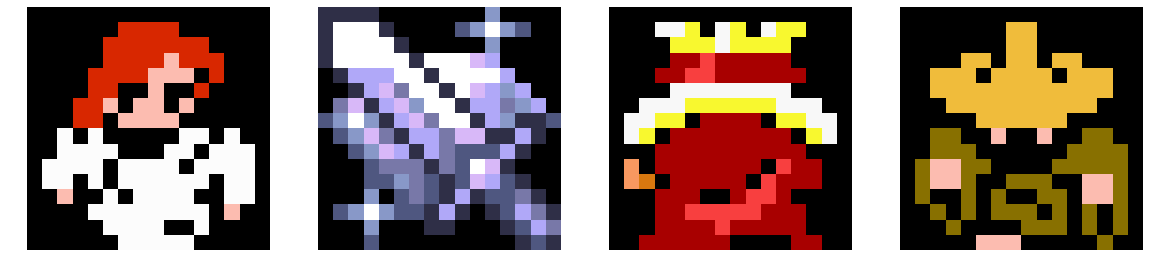

(4, 88, 256, 1)


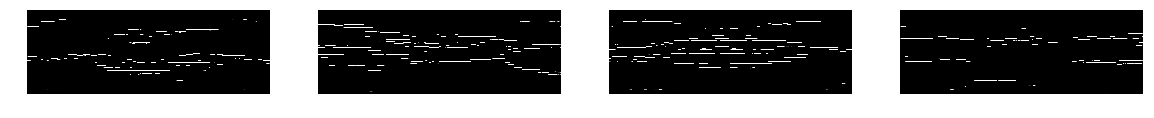

(4, 32, 32, 3)


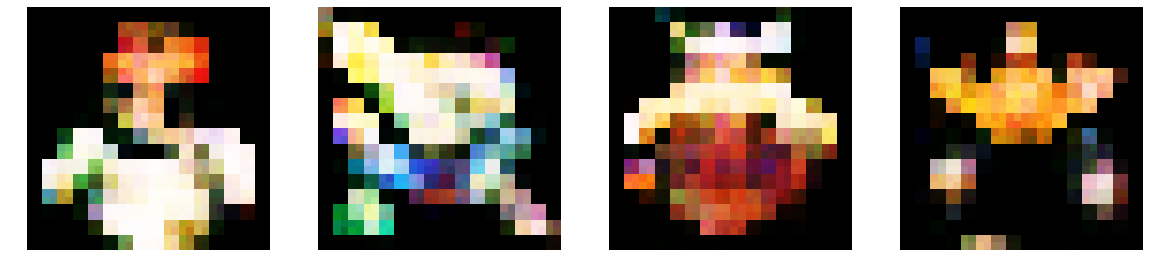

[92/100][31950] Loss_D: 0.018217 0.009647 Loss_G: 0.936971 0.969505 loss_cyc 0.367538 308.803
[92/100][31975] Loss_D: 0.021294 0.010245 Loss_G: 0.960314 1.027114 loss_cyc 0.391956 309.050
[92/100][32000] Loss_D: 0.014640 0.018555 Loss_G: 0.995360 1.005227 loss_cyc 0.376837 309.278
[92/100][32025] Loss_D: 0.013857 0.015379 Loss_G: 0.930441 1.036555 loss_cyc 0.372079 309.522
[92/100][32050] Loss_D: 0.014406 0.019724 Loss_G: 1.006334 1.023491 loss_cyc 0.387353 309.749
[92/100][32075] Loss_D: 0.021272 0.017529 Loss_G: 0.916324 1.029561 loss_cyc 0.372982 309.990
[92/100][32100] Loss_D: 0.018989 0.023923 Loss_G: 0.973061 0.970370 loss_cyc 0.351527 310.226
[92/100][32125] Loss_D: 0.016448 0.009628 Loss_G: 0.985064 1.022316 loss_cyc 0.375210 310.474
[92/100][32150] Loss_D: 0.010773 0.010433 Loss_G: 0.985557 0.982364 loss_cyc 0.343300 310.712
[92/100][32175] Loss_D: 0.018850 0.018315 Loss_G: 0.926272 1.021751 loss_cyc 0.381982 310.942
[92/100][32200] Loss_D: 0.018037 0.021908 Loss_G: 0.947334 1

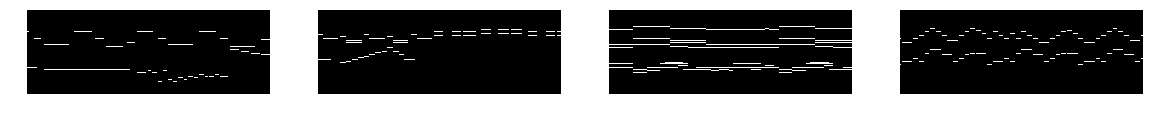

(4, 32, 32, 3)


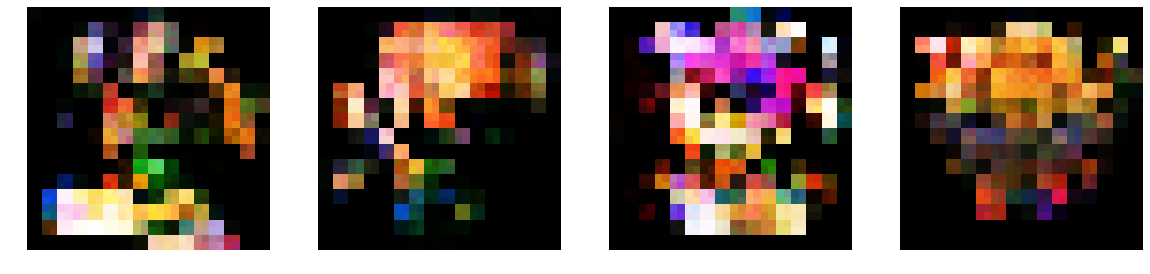

(4, 88, 256, 1)


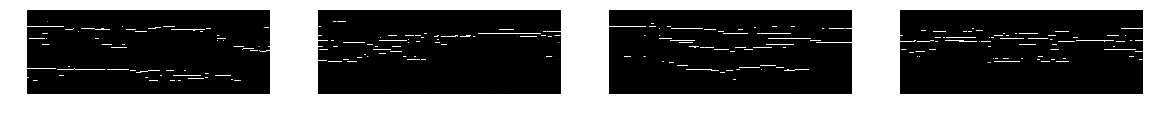

(4, 32, 32, 3)


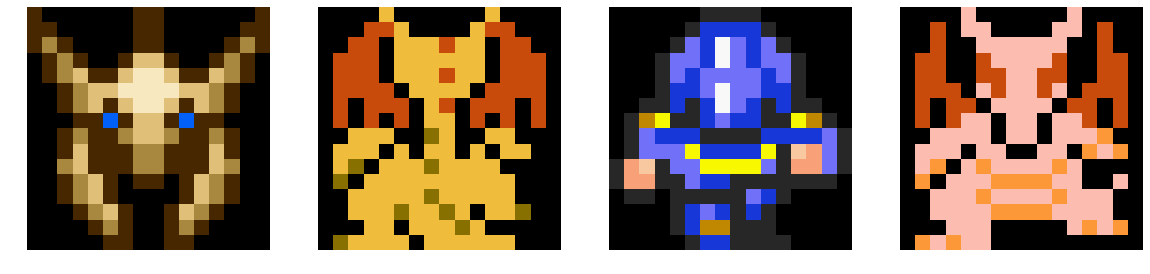

(4, 88, 256, 1)


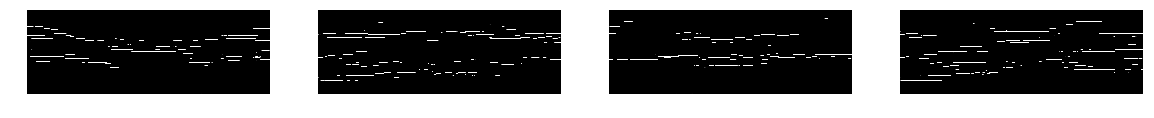

(4, 32, 32, 3)


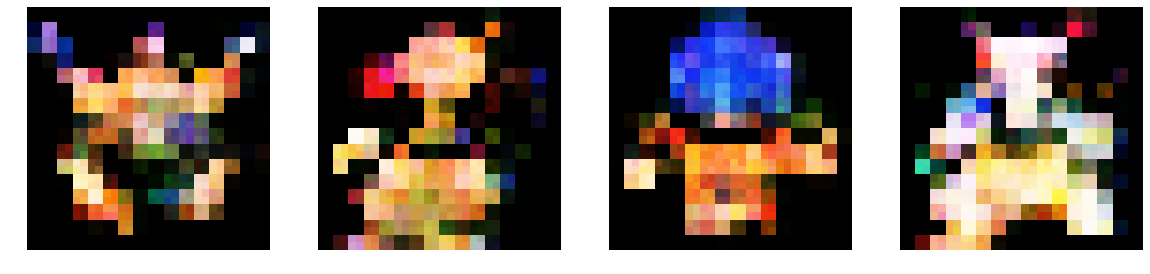

[93/100][32275] Loss_D: 0.023730 0.017888 Loss_G: 0.929992 0.999656 loss_cyc 0.346004 311.951
[93/100][32300] Loss_D: 0.022605 0.033091 Loss_G: 0.950165 1.006389 loss_cyc 0.358385 312.184
[93/100][32325] Loss_D: 0.013784 0.020093 Loss_G: 0.930696 1.028887 loss_cyc 0.372024 312.432
[93/100][32350] Loss_D: 0.016015 0.016492 Loss_G: 0.974779 1.011570 loss_cyc 0.353360 312.667
[93/100][32375] Loss_D: 0.021729 0.017101 Loss_G: 0.981370 1.097455 loss_cyc 0.360676 312.902
[93/100][32400] Loss_D: 0.019428 0.024072 Loss_G: 0.968671 1.000442 loss_cyc 0.392760 313.129
[93/100][32425] Loss_D: 0.021423 0.032488 Loss_G: 0.933970 0.977475 loss_cyc 0.363834 313.373
[93/100][32450] Loss_D: 0.019989 0.016229 Loss_G: 0.940526 1.009264 loss_cyc 0.342149 313.602
[93/100][32475] Loss_D: 0.013154 0.018460 Loss_G: 0.982120 1.019359 loss_cyc 0.358669 313.842
[93/100][32500] Loss_D: 0.022780 0.011179 Loss_G: 0.946977 1.039483 loss_cyc 0.346440 314.084
[93/100][32525] Loss_D: 0.029354 0.013298 Loss_G: 0.930741 0

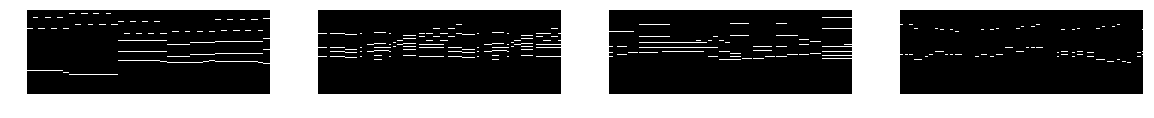

(4, 32, 32, 3)


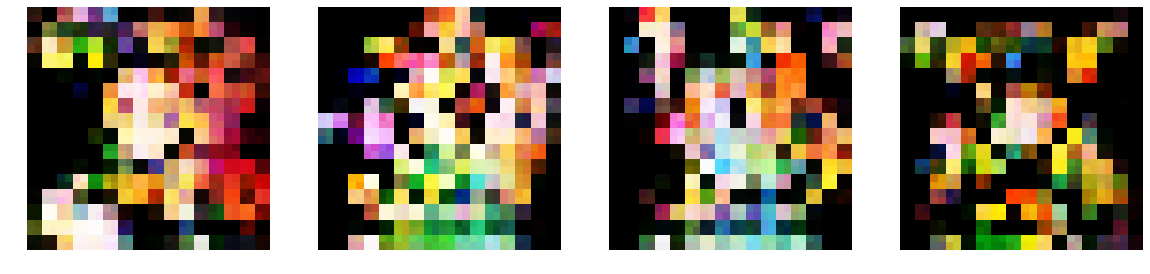

(4, 88, 256, 1)


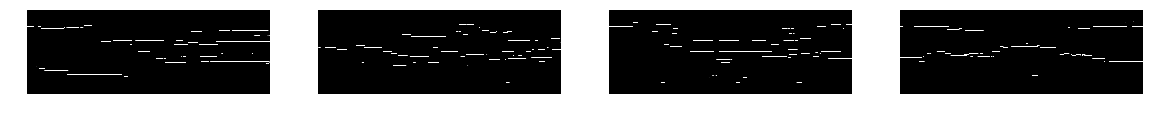

(4, 32, 32, 3)


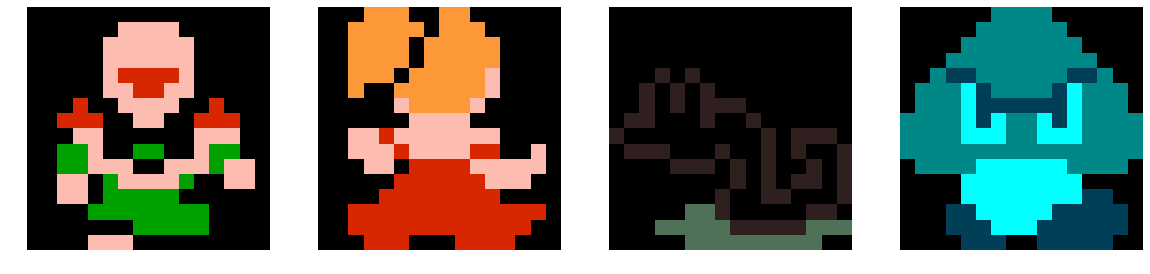

(4, 88, 256, 1)


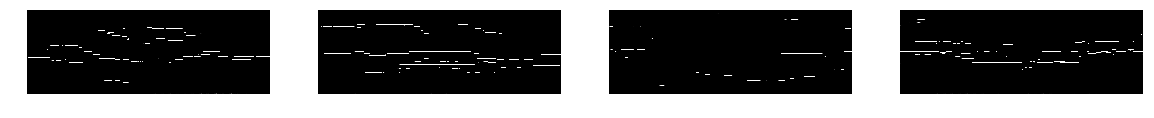

(4, 32, 32, 3)


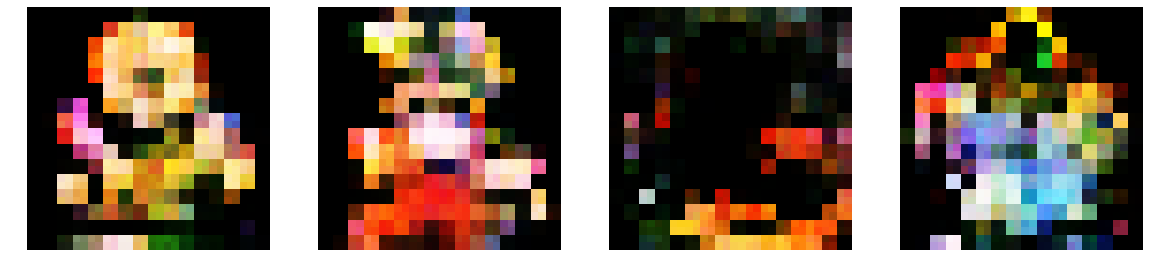

[94/100][32625] Loss_D: 0.016054 0.018188 Loss_G: 0.969674 0.971231 loss_cyc 0.356328 315.327
[94/100][32650] Loss_D: 0.016647 0.046462 Loss_G: 0.988405 1.055089 loss_cyc 0.335884 315.564
[94/100][32675] Loss_D: 0.015551 0.043498 Loss_G: 0.949455 1.110037 loss_cyc 0.365386 315.805
[94/100][32700] Loss_D: 0.022097 0.017423 Loss_G: 0.931464 0.998136 loss_cyc 0.361561 316.028
[94/100][32725] Loss_D: 0.022731 0.043187 Loss_G: 0.981883 1.041666 loss_cyc 0.359406 316.266
[94/100][32750] Loss_D: 0.019098 0.030348 Loss_G: 0.989387 1.076819 loss_cyc 0.349606 316.499
[94/100][32775] Loss_D: 0.027593 0.023291 Loss_G: 0.921590 1.039972 loss_cyc 0.369732 316.730
[94/100][32800] Loss_D: 0.028607 0.026839 Loss_G: 0.948242 1.035679 loss_cyc 0.342541 316.969
[94/100][32825] Loss_D: 0.014243 0.031524 Loss_G: 0.999830 1.020611 loss_cyc 0.362717 317.203
[94/100][32850] Loss_D: 0.021568 0.039916 Loss_G: 0.940570 0.977964 loss_cyc 0.368752 317.442
[94/100][32875] Loss_D: 0.030565 0.010753 Loss_G: 0.964605 1

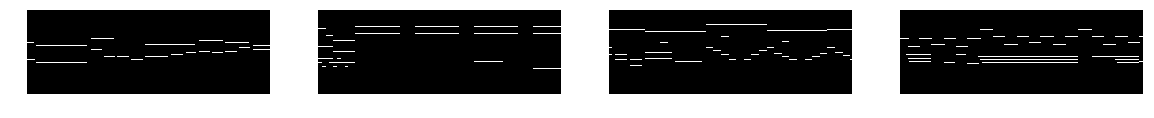

(4, 32, 32, 3)


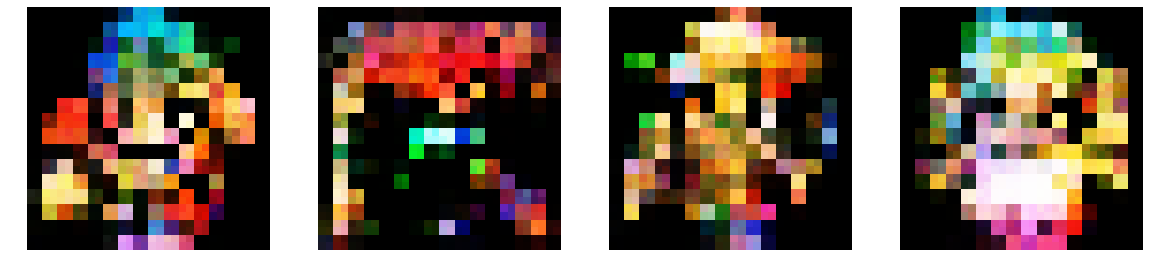

(4, 88, 256, 1)


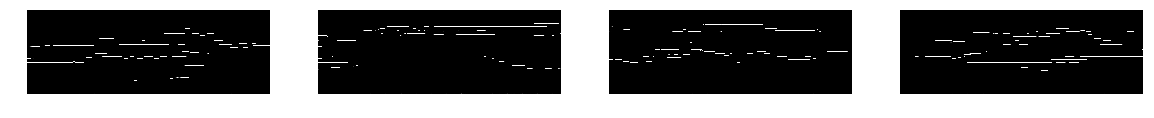

(4, 32, 32, 3)


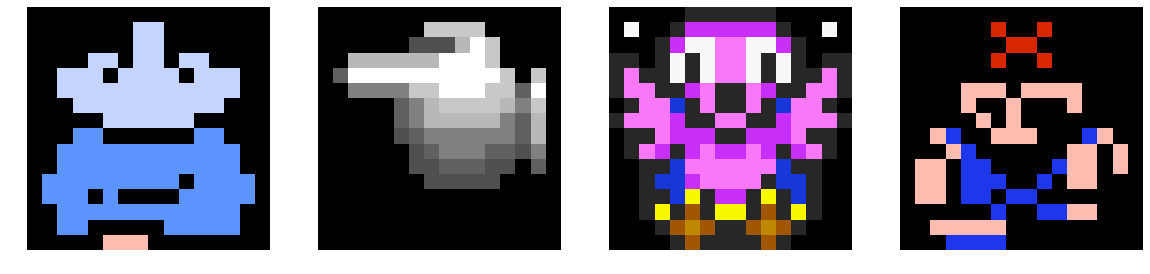

(4, 88, 256, 1)


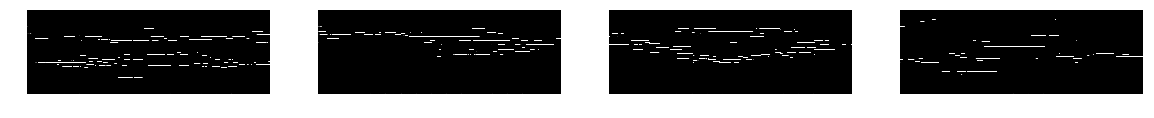

(4, 32, 32, 3)


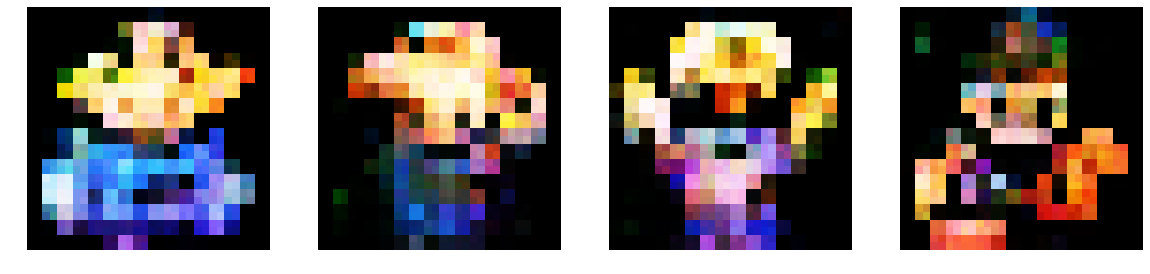

[95/100][32975] Loss_D: 0.016891 0.017181 Loss_G: 0.936034 1.002130 loss_cyc 0.340363 318.706
[95/100][33000] Loss_D: 0.019169 0.033369 Loss_G: 0.919536 1.005727 loss_cyc 0.356008 318.940
[95/100][33025] Loss_D: 0.016979 0.049935 Loss_G: 0.989925 0.999448 loss_cyc 0.343306 319.177
[95/100][33050] Loss_D: 0.011937 0.017844 Loss_G: 0.997829 0.995670 loss_cyc 0.355753 319.413
[95/100][33075] Loss_D: 0.020230 0.033308 Loss_G: 1.023985 0.987498 loss_cyc 0.359879 319.642
[95/100][33100] Loss_D: 0.024158 0.028296 Loss_G: 0.966520 1.001163 loss_cyc 0.343556 319.895
[95/100][33125] Loss_D: 0.016283 0.029922 Loss_G: 0.977827 0.991060 loss_cyc 0.356650 320.140
[95/100][33150] Loss_D: 0.015122 0.019779 Loss_G: 0.965010 1.015463 loss_cyc 0.358082 320.369
[95/100][33175] Loss_D: 0.018244 0.009005 Loss_G: 0.953216 0.983940 loss_cyc 0.389249 320.601
[95/100][33200] Loss_D: 0.017091 0.025167 Loss_G: 0.966884 1.064175 loss_cyc 0.364505 320.836
[95/100][33225] Loss_D: 0.016513 0.016494 Loss_G: 0.956114 0

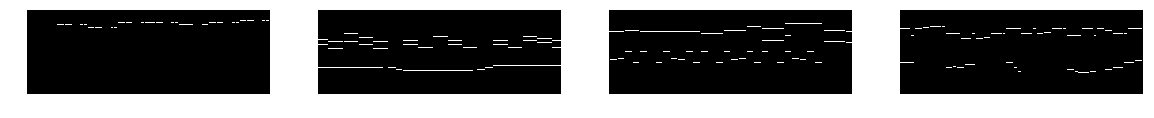

(4, 32, 32, 3)


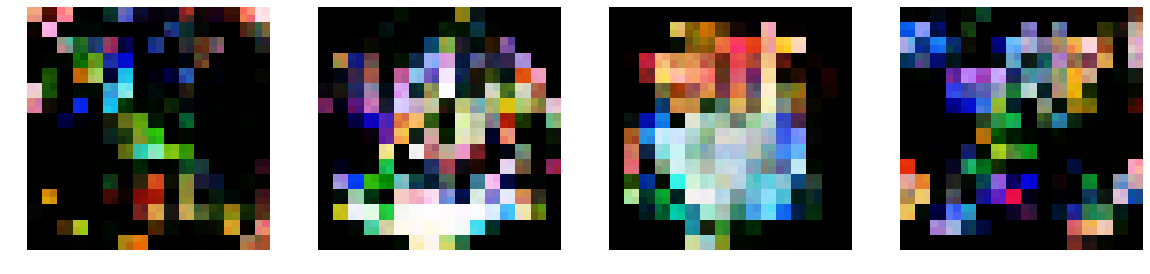

(4, 88, 256, 1)


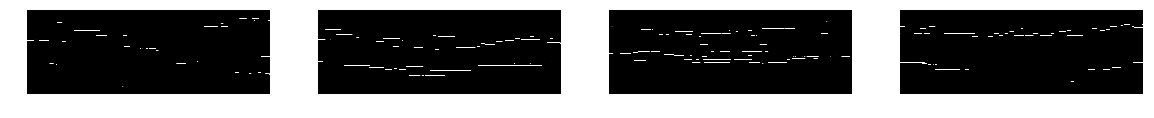

(4, 32, 32, 3)


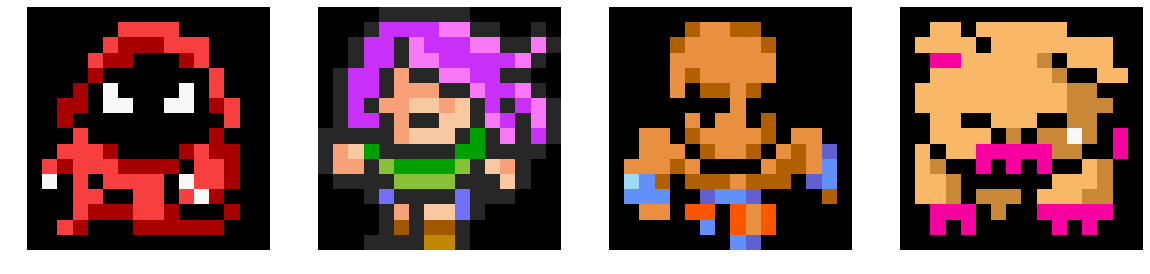

(4, 88, 256, 1)


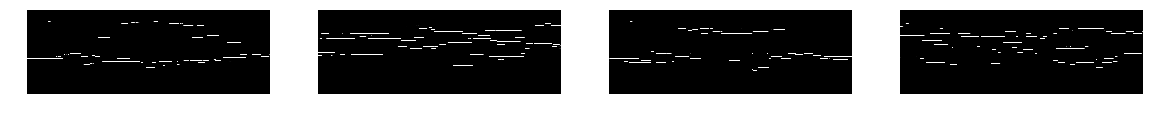

(4, 32, 32, 3)


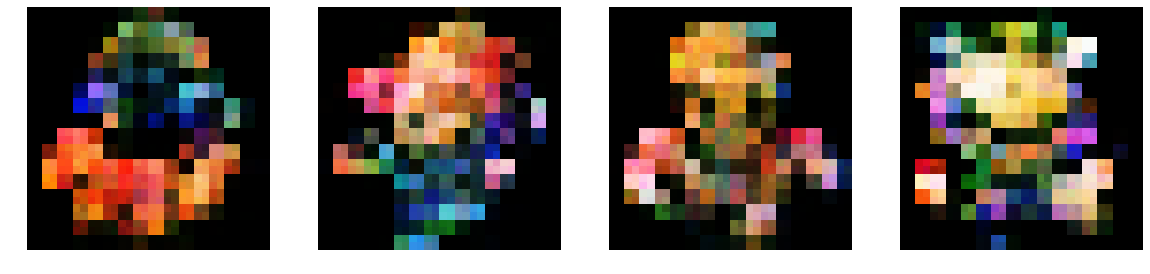

[96/100][33325] Loss_D: 0.014141 0.041762 Loss_G: 0.952909 0.979289 loss_cyc 0.370652 322.082
[96/100][33350] Loss_D: 0.017496 0.034283 Loss_G: 0.970286 0.924708 loss_cyc 0.353884 322.311
[96/100][33375] Loss_D: 0.014355 0.012943 Loss_G: 0.930441 0.979561 loss_cyc 0.370959 322.552
[96/100][33400] Loss_D: 0.017850 0.035764 Loss_G: 0.953181 1.019167 loss_cyc 0.366503 322.797
[96/100][33425] Loss_D: 0.016522 0.029044 Loss_G: 0.989188 1.001909 loss_cyc 0.370188 323.035
[96/100][33450] Loss_D: 0.018716 0.026273 Loss_G: 0.916427 0.929230 loss_cyc 0.372456 323.277
[96/100][33475] Loss_D: 0.015065 0.033365 Loss_G: 0.926416 1.030726 loss_cyc 0.379986 323.511
[96/100][33500] Loss_D: 0.011789 0.020337 Loss_G: 0.952982 1.032007 loss_cyc 0.383373 323.745
[96/100][33525] Loss_D: 0.023658 0.011767 Loss_G: 0.932646 0.994128 loss_cyc 0.366371 323.978
[96/100][33550] Loss_D: 0.028933 0.024349 Loss_G: 0.927626 1.036230 loss_cyc 0.384301 324.206
[96/100][33575] Loss_D: 0.017879 0.015385 Loss_G: 0.931682 1

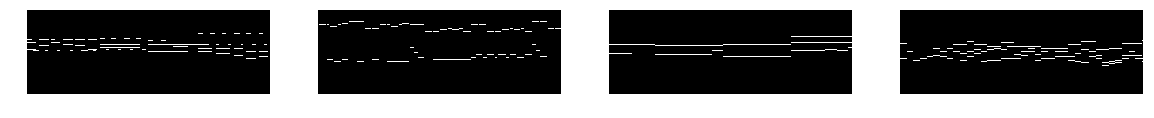

(4, 32, 32, 3)


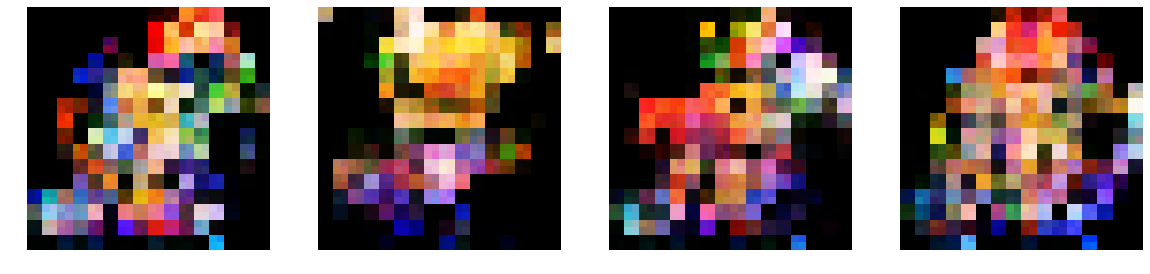

(4, 88, 256, 1)


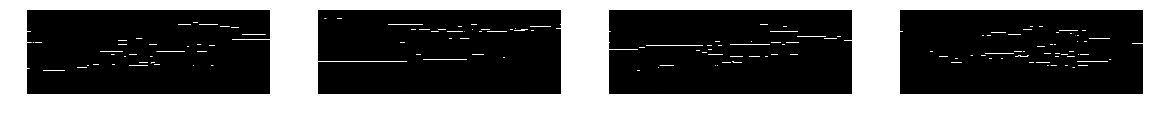

(4, 32, 32, 3)


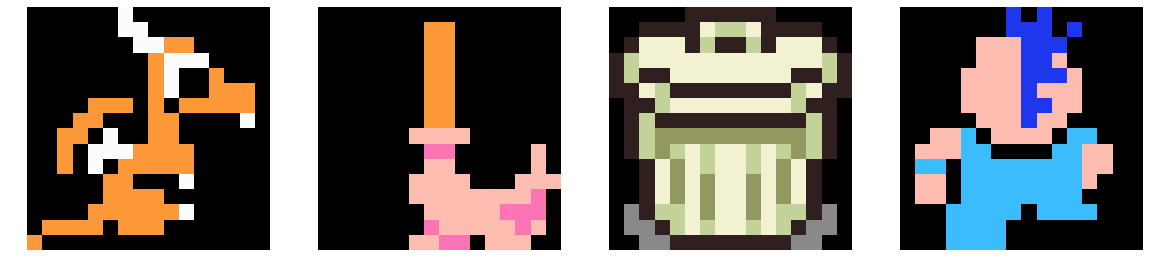

(4, 88, 256, 1)


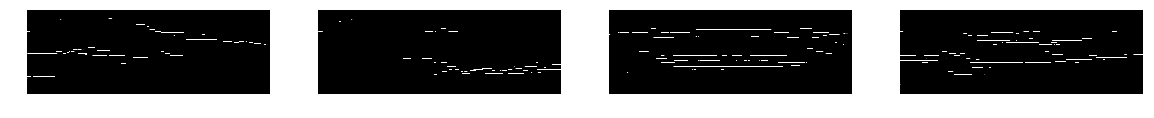

(4, 32, 32, 3)


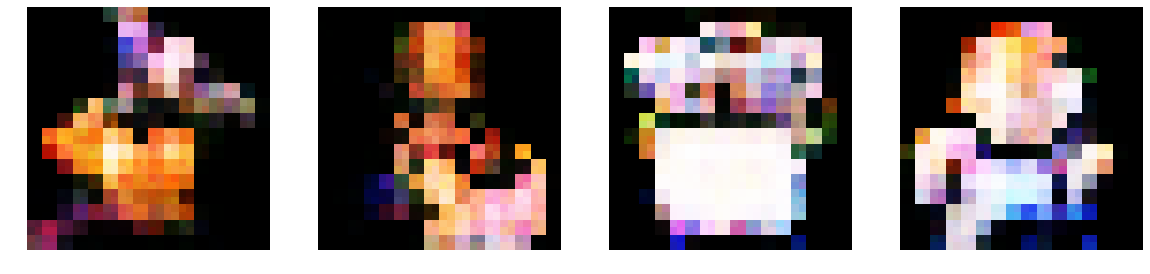

[97/100][33675] Loss_D: 0.014335 0.025540 Loss_G: 0.943968 0.993198 loss_cyc 0.392407 325.455
[97/100][33700] Loss_D: 0.020180 0.027713 Loss_G: 0.991504 1.039725 loss_cyc 0.385540 325.687
[97/100][33725] Loss_D: 0.016079 0.016307 Loss_G: 0.957811 1.010765 loss_cyc 0.356405 325.915
[97/100][33750] Loss_D: 0.015466 0.016914 Loss_G: 1.003901 0.985881 loss_cyc 0.350086 326.161
[97/100][33775] Loss_D: 0.008586 0.011482 Loss_G: 0.961384 0.998848 loss_cyc 0.366748 326.410
[97/100][33800] Loss_D: 0.010243 0.015803 Loss_G: 0.996827 0.970076 loss_cyc 0.410172 326.651
[97/100][33825] Loss_D: 0.022061 0.028511 Loss_G: 0.947407 1.017839 loss_cyc 0.375586 326.886
[97/100][33850] Loss_D: 0.020848 0.009070 Loss_G: 0.950961 0.930420 loss_cyc 0.376570 327.117
[97/100][33875] Loss_D: 0.019359 0.013020 Loss_G: 0.985564 1.045822 loss_cyc 0.371271 327.356
[97/100][33900] Loss_D: 0.021141 0.020034 Loss_G: 0.932887 1.026085 loss_cyc 0.352784 327.593
[97/100][33925] Loss_D: 0.009258 0.009513 Loss_G: 0.979957 1

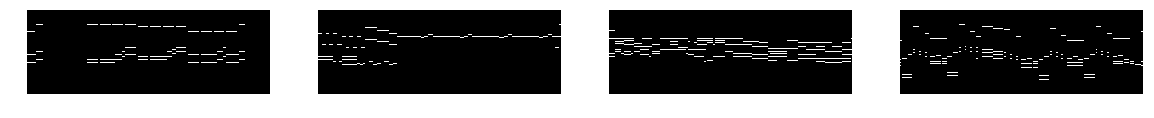

(4, 32, 32, 3)


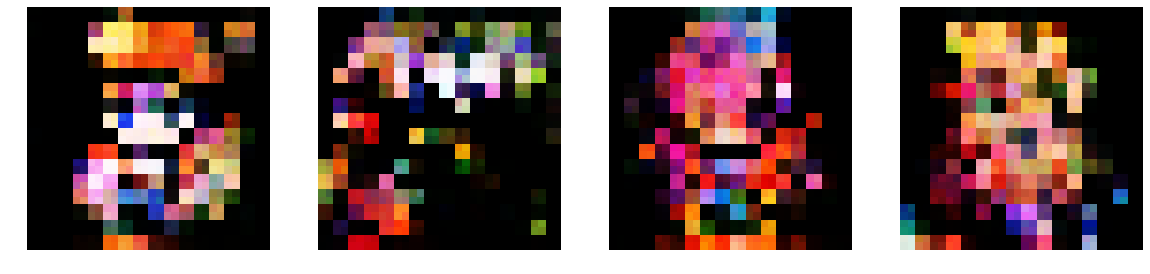

(4, 88, 256, 1)


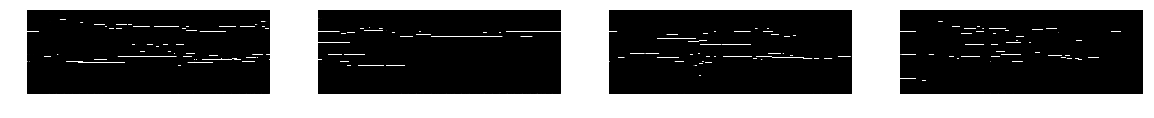

(4, 32, 32, 3)


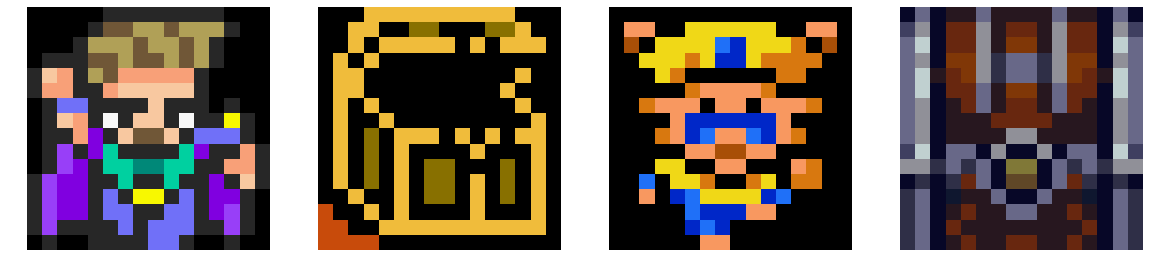

(4, 88, 256, 1)


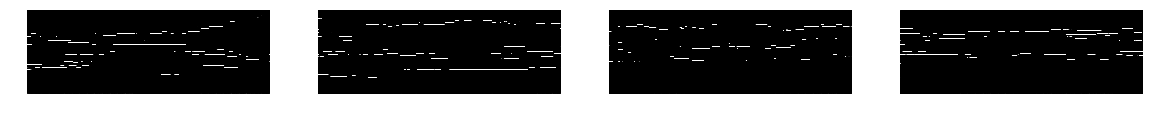

(4, 32, 32, 3)


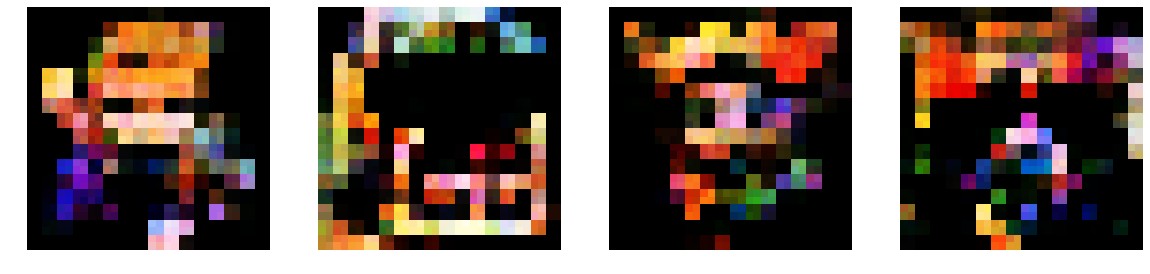

[98/100][34025] Loss_D: 0.021416 0.008644 Loss_G: 0.949871 0.991532 loss_cyc 0.407153 328.833
[98/100][34050] Loss_D: 0.020608 0.019095 Loss_G: 1.002287 1.040012 loss_cyc 0.371663 329.065
[98/100][34075] Loss_D: 0.021945 0.016027 Loss_G: 0.951166 1.002183 loss_cyc 0.356467 329.309
[98/100][34100] Loss_D: 0.015355 0.016544 Loss_G: 0.999179 1.019138 loss_cyc 0.387571 329.543
[98/100][34125] Loss_D: 0.022832 0.020162 Loss_G: 0.931240 1.049518 loss_cyc 0.357861 329.789
[98/100][34150] Loss_D: 0.012299 0.012146 Loss_G: 0.941884 1.004042 loss_cyc 0.347557 330.014
[98/100][34175] Loss_D: 0.016756 0.020042 Loss_G: 0.949855 0.970209 loss_cyc 0.345689 330.263
[98/100][34200] Loss_D: 0.017209 0.013369 Loss_G: 0.970814 1.021038 loss_cyc 0.345000 330.499
[98/100][34225] Loss_D: 0.016504 0.024668 Loss_G: 0.944140 1.012222 loss_cyc 0.362473 330.737
[98/100][34250] Loss_D: 0.017589 0.013431 Loss_G: 1.009693 1.027126 loss_cyc 0.356072 330.969
[98/100][34275] Loss_D: 0.018421 0.031827 Loss_G: 0.950152 0

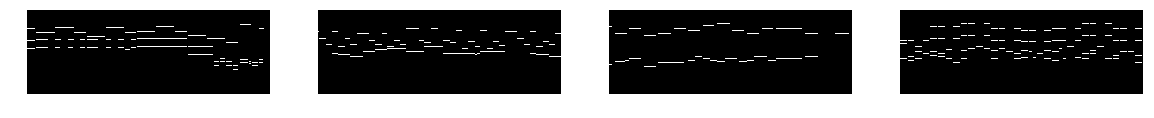

(4, 32, 32, 3)


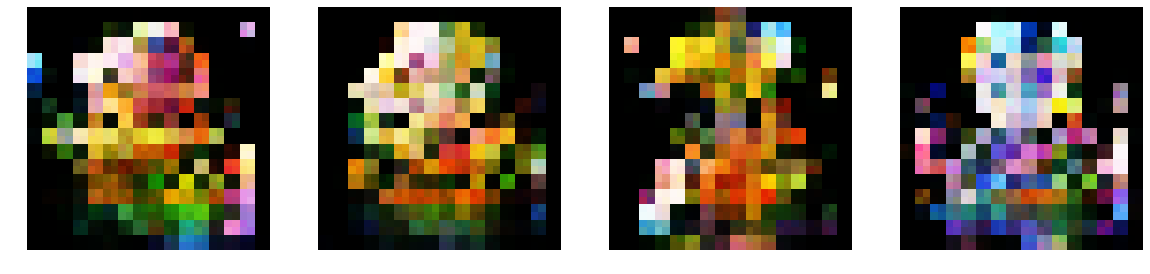

(4, 88, 256, 1)


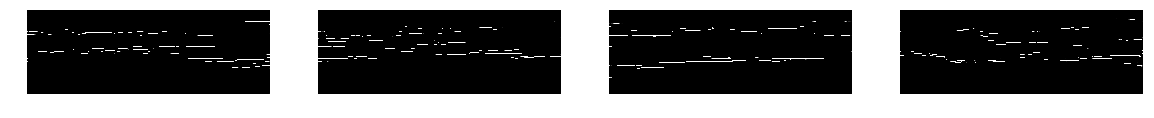

(4, 32, 32, 3)


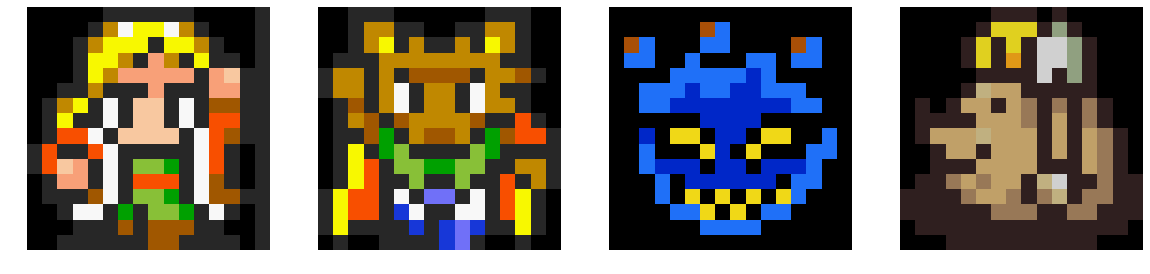

(4, 88, 256, 1)


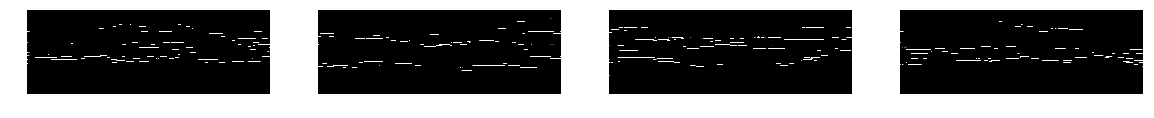

(4, 32, 32, 3)


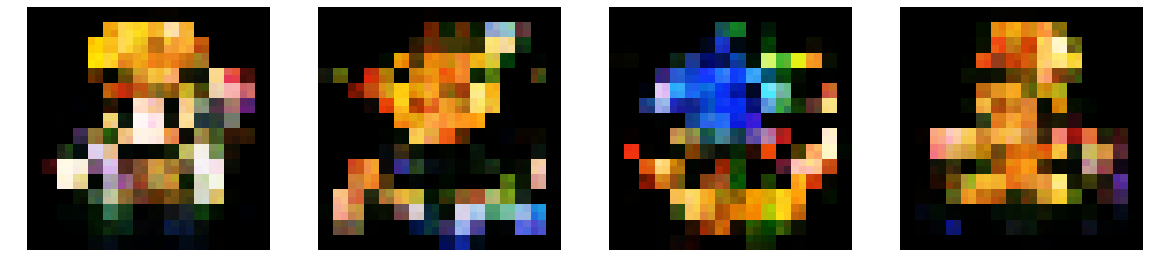

[99/100][34375] Loss_D: 0.019017 0.018098 Loss_G: 0.960984 1.072522 loss_cyc 0.370594 332.195
[99/100][34400] Loss_D: 0.016191 0.022536 Loss_G: 0.945954 1.075396 loss_cyc 0.371024 332.432
[99/100][34425] Loss_D: 0.026284 0.023625 Loss_G: 0.876006 1.003585 loss_cyc 0.360448 332.662
[99/100][34450] Loss_D: 0.018787 0.025957 Loss_G: 1.003564 0.966740 loss_cyc 0.391966 332.902
[99/100][34475] Loss_D: 0.018294 0.035990 Loss_G: 0.981292 1.093780 loss_cyc 0.373467 333.141
[99/100][34500] Loss_D: 0.009853 0.013202 Loss_G: 0.993685 1.005812 loss_cyc 0.374280 333.377
[99/100][34525] Loss_D: 0.015622 0.018255 Loss_G: 0.931903 0.976183 loss_cyc 0.366077 333.612
[99/100][34550] Loss_D: 0.015746 0.007483 Loss_G: 0.967217 0.977297 loss_cyc 0.339567 333.862
[99/100][34575] Loss_D: 0.019538 0.012230 Loss_G: 0.972272 1.001737 loss_cyc 0.331589 334.094
[99/100][34600] Loss_D: 0.017774 0.018786 Loss_G: 0.981320 1.039388 loss_cyc 0.351481 334.327
[99/100][34625] Loss_D: 0.017802 0.009573 Loss_G: 0.956709 0

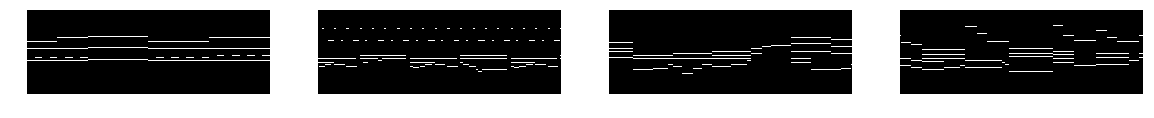

(4, 32, 32, 3)


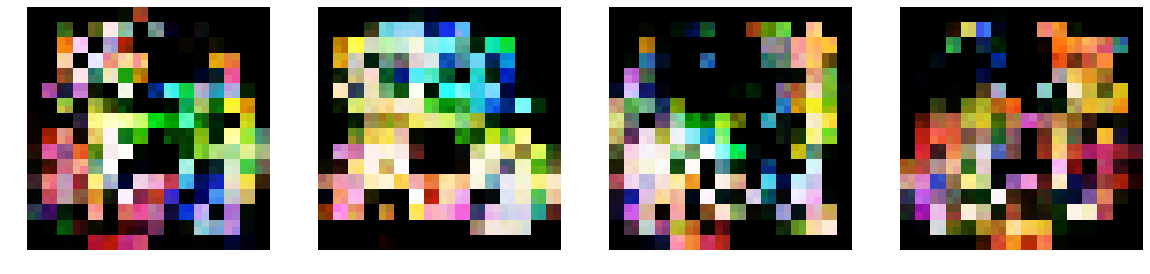

(4, 88, 256, 1)


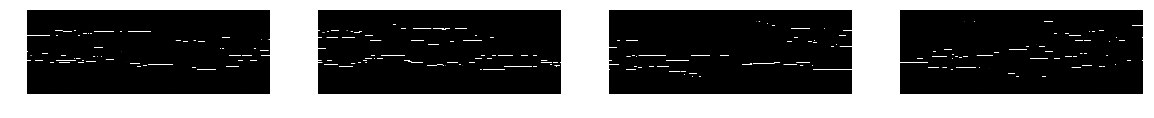

(4, 32, 32, 3)


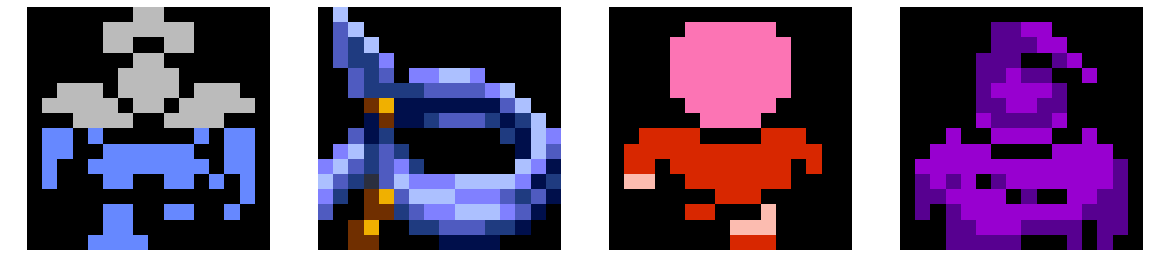

(4, 88, 256, 1)


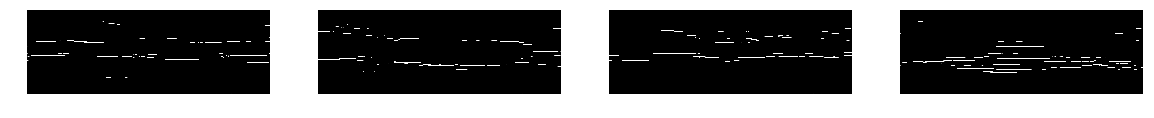

(4, 32, 32, 3)


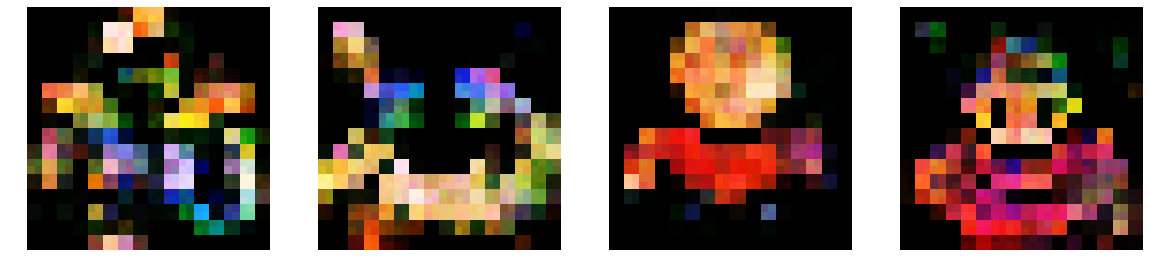

(4, 88, 256, 1)


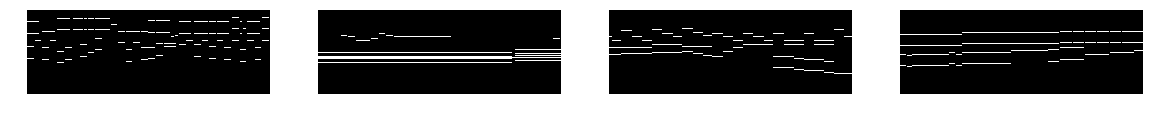

(4, 32, 32, 3)


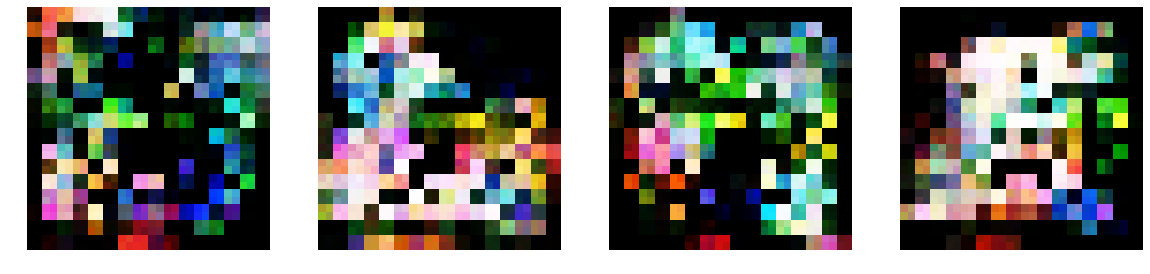

(4, 88, 256, 1)


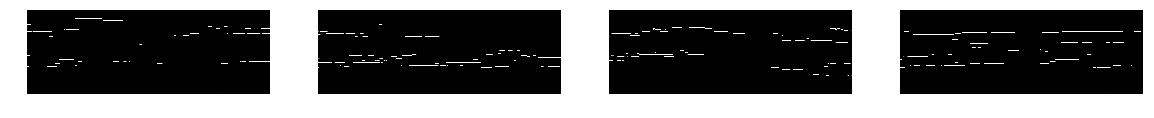

(4, 32, 32, 3)


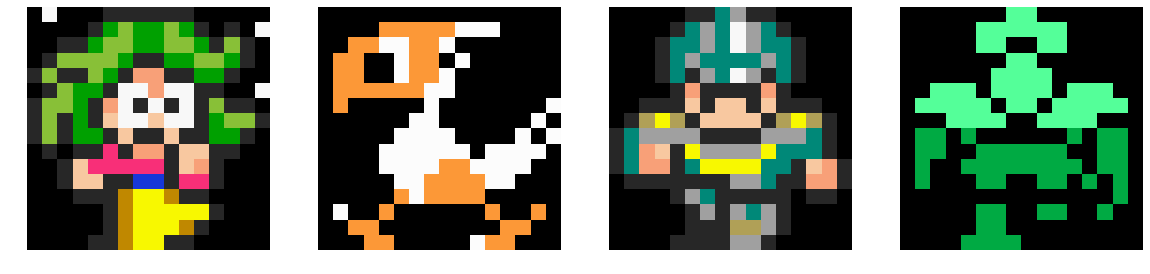

(4, 88, 256, 1)


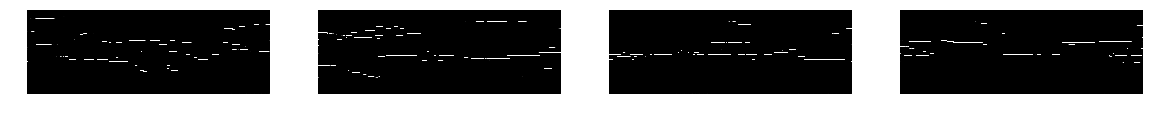

(4, 32, 32, 3)


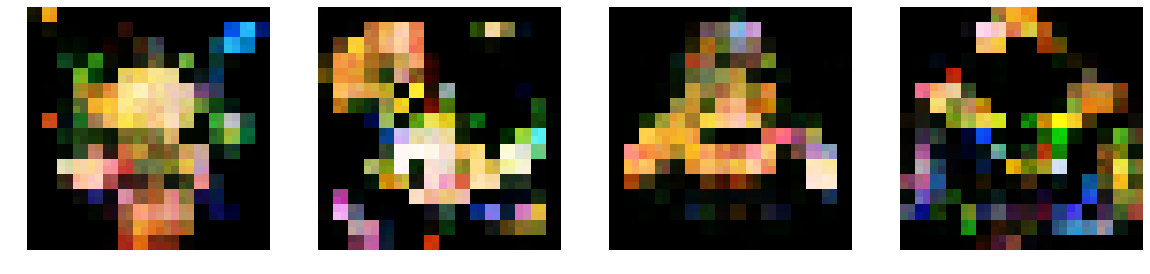

In [31]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 100
gen_iterations = 0
epoch = 0
errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0

past_epoch = 0
display_iters = 25
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchMS(train_M, train_S, batchSize)

while epoch < niter: 
    epoch, M, S = next(train_batch)  
    errDM, errDS  = netD_train([M, S])
    errDM_sum +=errDM
    errDS_sum +=errDS

    # epoch, trainA, trainB = next(train_batch)
    errGM, errGS, errCyc = netG_train([M, S])
    errGM_sum += errGM
    errGS_sum += errGS
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        #clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDM_sum/display_iters, errDS_sum/display_iters,
           errGM_sum/display_iters, errGS_sum/display_iters, 
           errCyc_sum/display_iters), "%.3f" % ((time.time()-t0)/60.0))
        errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0
    if epoch != past_epoch:
        _, M, S = train_batch.send(4)
        showG(M,S)
        if epoch == 500:
            netDM.save('run08b_netDM')
            netDS.save('run08b_netDS')
            netGM.save('run08b_netGM')
            netGS.save('run08b_netGS')
        past_epoch = epoch
        
        
_, M, S = train_batch.send(4)
showG(M,S)

In [32]:
# save all the things
netDM.save('run14_netDM')
netDS.save('run14_netDS')
netGM.save('run14_netGM')
netGS.save('run14_netGS')

In [33]:

def getG(M,S):
    def G(fn_generate, X):
        fakes = []
        recs = []
        for i in range(X.shape[0]):
            fake, rec = fn_generate([X[i:i+1]])
            fakes.append(fake[0])
            recs.append(rec[0])
        return [np.array(fakes), np.array(recs)]
    rM = G(cycleM_generate, M)
    rS = G(cycleS_generate, S)
    arr = [M,*rM,S,*rS]
    return arr


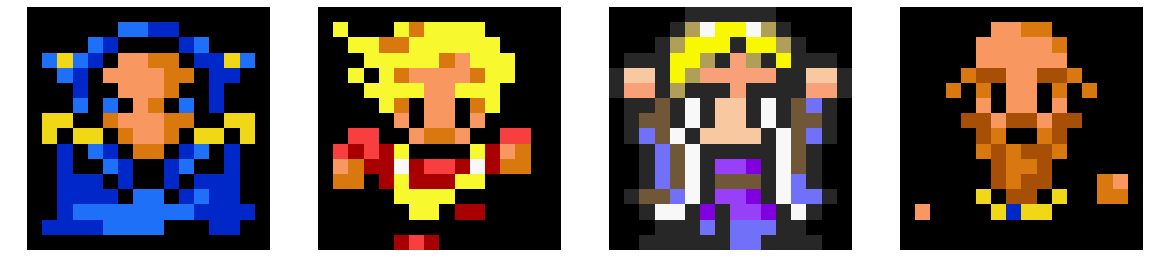

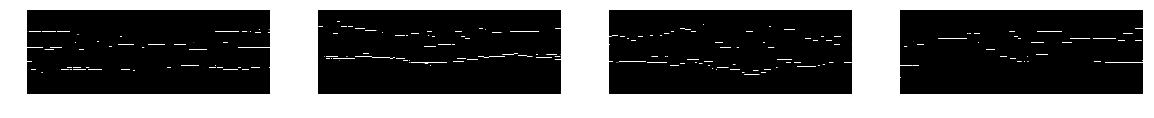

In [38]:

_, M, S = train_batch.send(4)

peek = getG(M,S)
p = 3
showX(peek[p], peek[p].shape[1], peek[p].shape[2], peek[p].shape[3], 1)
p = 4
showX(peek[p], peek[p].shape[1], peek[p].shape[2], peek[p].shape[3], 1)
threshold = 0.99
peek[p] = (peek[p] - threshold).clip(0, 1)
peek[p] = (peek[p] * 1000).clip(0, 1)


pm = to_midi(peek[p][0], fs, pitch_range, force_velocity= binary_music)
pm.write('test1.mid')

pm = to_midi(peek[p][1], fs, pitch_range, force_velocity= binary_music)
pm.write('test2.mid')

pm = to_midi(peek[p][2], fs, pitch_range, force_velocity= binary_music)
pm.write('test3.mid')

pm = to_midi(peek[p][3], fs, pitch_range, force_velocity= binary_music)
pm.write('test4.mid')
